In [1]:
import numpy as np
import tensorflow as tf
import random
import os

# Seed value
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)

random.seed(seed_value)

np.random.seed(seed_value)

tf.random.set_seed(seed_value)

In [2]:
# Importing necessary libraries for stock price prediction 
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, SimpleRNN, BatchNormalization, LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import backend as K
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.pruners import MedianPruner
import optuna.visualization as ov

## Data Loading

In [3]:
# Define the stock symbols
symbols = ["AON", "POOL", "VYGVQ"]

# Create a dictionary to store the data
stock_data = {}

# Fetch the stock data
for symbol in symbols:
    ticker = yf.Ticker(symbol)
    # Get historical market data
    df = ticker.history(period="max")
    stock_data[symbol] = df
    print(f"Initial rows of data for {symbol}:")
    print(df.head())
    print(df.info())

Initial rows of data for AON:
                           Open      High       Low     Close  Volume  \
Date                                                                    
1980-06-02 00:00:00-04:00   0.0  1.103274  1.095717  1.095717  118800   
1980-06-03 00:00:00-04:00   0.0  1.110830  1.095717  1.110830  141750   
1980-06-04 00:00:00-04:00   0.0  1.110830  1.103274  1.110830  102600   
1980-06-05 00:00:00-04:00   0.0  1.118387  1.103274  1.118387  575100   
1980-06-06 00:00:00-04:00   0.0  1.125943  1.103273  1.103273   88425   

                           Dividends  Stock Splits  
Date                                                
1980-06-02 00:00:00-04:00        0.0           0.0  
1980-06-03 00:00:00-04:00        0.0           0.0  
1980-06-04 00:00:00-04:00        0.0           0.0  
1980-06-05 00:00:00-04:00        0.0           0.0  
1980-06-06 00:00:00-04:00        0.0           0.0  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10963 entries, 1980-06-02 00:00:00

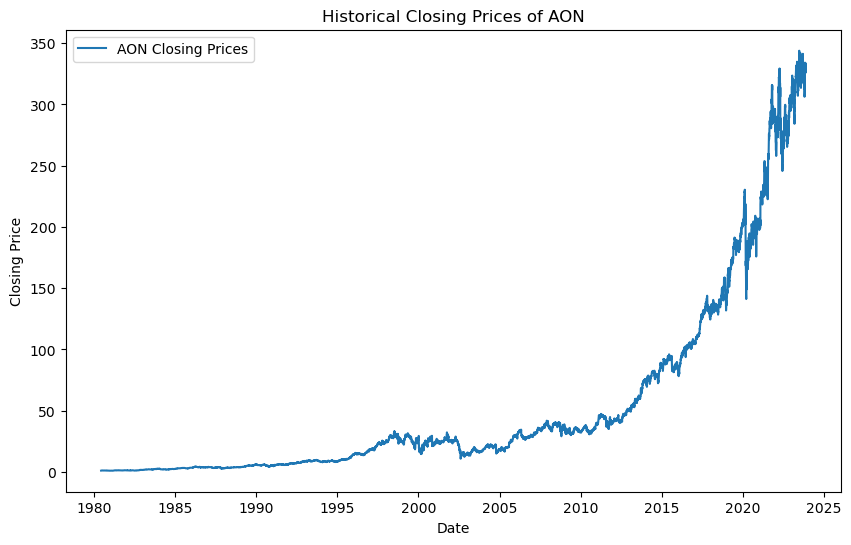

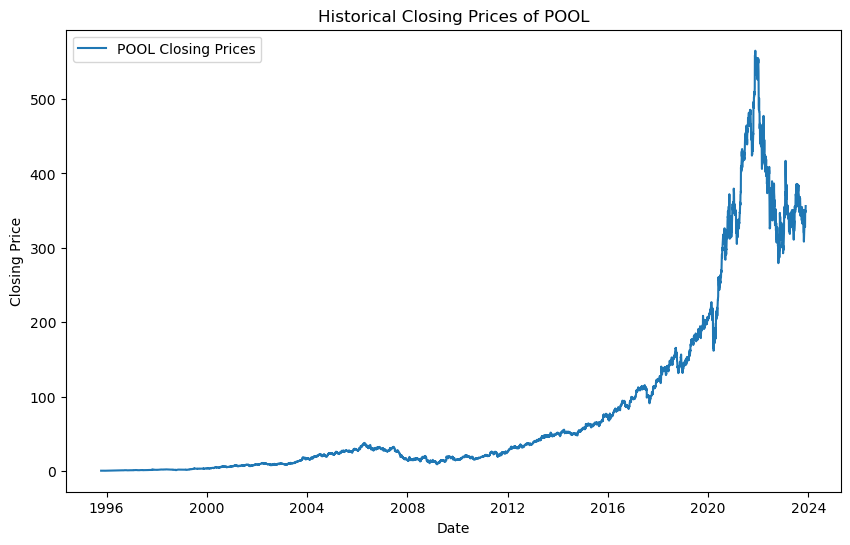

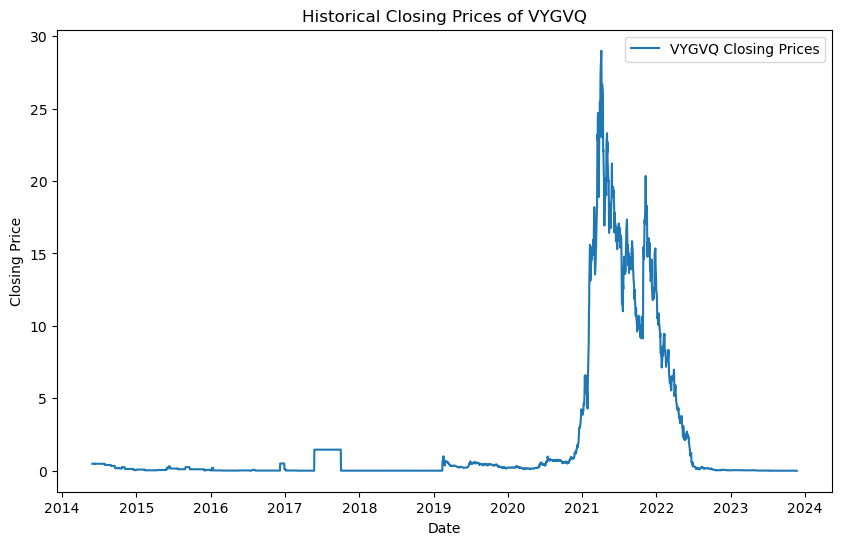

In [4]:
# Plotting the historical closing prices for each stock
for symbol, df in stock_data.items():
    plt.figure(figsize=(10, 6))
    plt.plot(df['Close'], label=f'{symbol} Closing Prices')
    plt.title(f'Historical Closing Prices of {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

## Feature Engineering - Calculating Residuals

In [5]:
window_size = 20  

for symbol, df in stock_data.items():
    # Calculate the moving average and residuals
    df['Moving_Average'] = df['Close'].rolling(window=window_size).mean()
    df['Residual'] = df['Close'] - df['Moving_Average']

    # Drop NaN values
    df.dropna(subset=['Moving_Average', 'Residual'], inplace=True)

    # Print the first few rows of the modified DataFrame
    print(f"Initial rows of data for {symbol} after processing:")
    print(df.head())

Initial rows of data for AON after processing:
                           Open      High       Low     Close  Volume  \
Date                                                                    
1980-06-27 00:00:00-04:00   0.0  1.186397  1.163727  1.171283  109350   
1980-06-30 00:00:00-04:00   0.0  1.171283  1.141056  1.156170  108000   
1980-07-01 00:00:00-04:00   0.0  1.201510  1.156170  1.193954  150525   
1980-07-02 00:00:00-04:00   0.0  1.186397  1.171284  1.186397   43875   
1980-07-03 00:00:00-04:00   0.0  1.224180  1.186396  1.224180   56700   

                           Dividends  Stock Splits  Moving_Average  Residual  
Date                                                                          
1980-06-27 00:00:00-04:00        0.0           0.0        1.173550 -0.002267  
1980-06-30 00:00:00-04:00        0.0           0.0        1.176573 -0.020403  
1980-07-01 00:00:00-04:00        0.0           0.0        1.180729  0.013224  
1980-07-02 00:00:00-04:00        0.0          

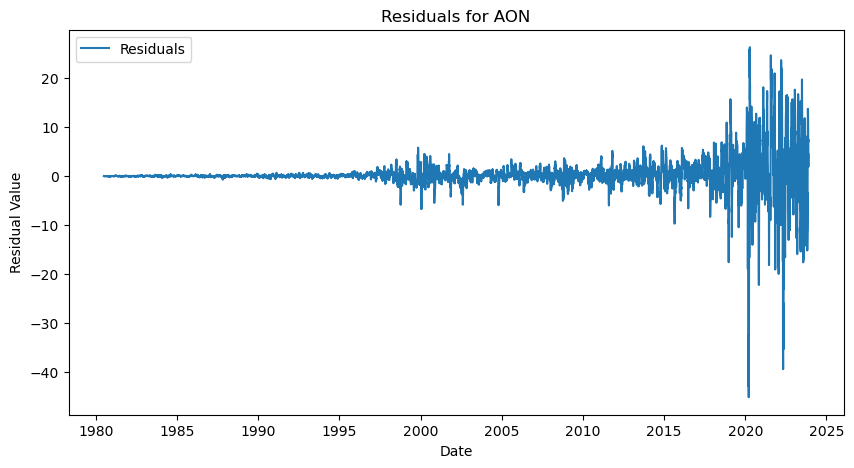

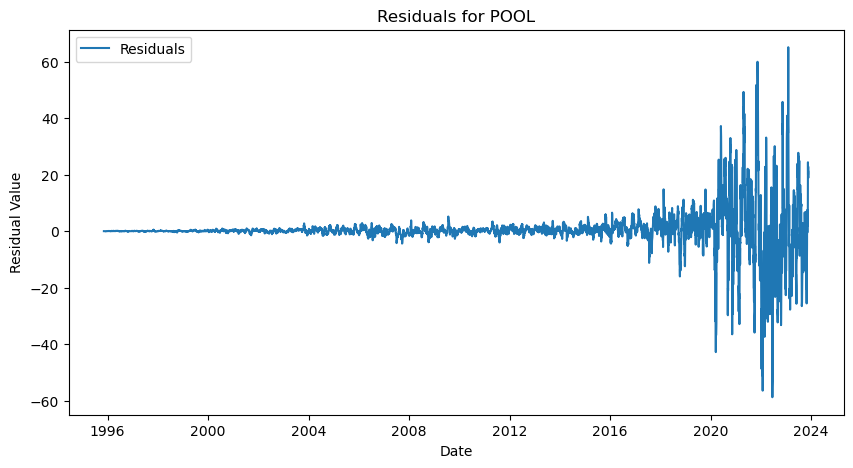

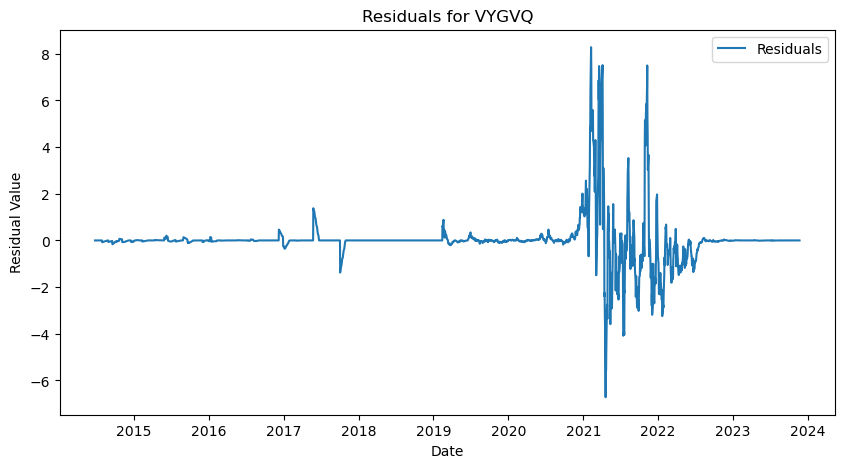

In [6]:
for symbol, df in stock_data.items():
    # Plotting the residuals
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df['Residual'], label='Residuals')
    plt.title(f'Residuals for {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Residual Value')
    plt.legend()
    plt.show()

## Data Prepossessing 

In [7]:
split_data = {}

for symbol, df in stock_data.items():
    # Calculate split indices (15% for test and validation each, rest for training)
    total_length = len(df)
    test_val_size = int(0.15 * total_length)
    train_size = total_length - 2 * test_val_size

    # Split the data chronologically
    train_df = df.iloc[:train_size]
    val_df = df.iloc[train_size:train_size + test_val_size]
    test_df = df.iloc[train_size + test_val_size:]

    # Store the split data
    split_data[symbol] = {'train': train_df, 'validation': val_df, 'test': test_df}

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
sequence_length = 60
train_data = {}
validation_data = {}
test_data = {}

for symbol in split_data:
    # Make deep copies for train, validation, and test sets
    train_df = split_data[symbol]['train'].copy()
    val_df = split_data[symbol]['validation'].copy()
    test_df = split_data[symbol]['test'].copy()

    # Normalize the 'Residual' column for each dataset
    train_df['Normalized_Residual'] = scaler.fit_transform(train_df['Residual'].values.reshape(-1, 1))
    val_df['Normalized_Residual'] = scaler.transform(val_df['Residual'].values.reshape(-1, 1))
    test_df['Normalized_Residual'] = scaler.transform(test_df['Residual'].values.reshape(-1, 1))

    # Update the split_data dictionary with the normalized data
    split_data[symbol] = {'train': train_df, 'validation': val_df, 'test': test_df}

    # Create sequences and labels for each set
    for key in split_data[symbol]:
        sequences = []
        labels = []
        df = split_data[symbol][key]
        for i in range(len(df) - sequence_length):
            sequence = df['Normalized_Residual'].iloc[i:i + sequence_length].values
            label = df['Normalized_Residual'].iloc[i + sequence_length]
            sequences.append(sequence)
            labels.append(label)
        sequences = np.array(sequences)
        labels = np.array(labels)
        if key == 'train':
            train_data[symbol] = (sequences, labels)
        elif key == 'validation':
            validation_data[symbol] = (sequences, labels)
        elif key == 'test':
            test_data[symbol] = (sequences, labels)

for symbol in split_data:
    print(f"{symbol} - Training set: {len(train_data[symbol][0])} samples")
    print(f"{symbol} - Validation set: {len(validation_data[symbol][0])} samples")
    print(f"{symbol} - Test set: {len(test_data[symbol][0])} samples")

AON - Training set: 7602 samples
AON - Validation set: 1581 samples
AON - Test set: 1581 samples
POOL - Training set: 4882 samples
POOL - Validation set: 998 samples
POOL - Test set: 998 samples
VYGVQ - Training set: 1601 samples
VYGVQ - Validation set: 295 samples
VYGVQ - Test set: 295 samples


## Statistical Testing

In [35]:
def check_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Apply the function to check stationarity 
    print(f'Checking stationarity for {symbol}')
    check_stationarity(train_data[symbol][1])  


Checking stationarity for AON
Results of Dickey-Fuller Test:
Test Statistic                -1.362330e+01
p-value                        1.779585e-25
#Lags Used                     3.600000e+01
Number of Observations Used    7.563000e+03
Critical Value (1%)           -3.431215e+00
Critical Value (5%)           -2.861922e+00
Critical Value (10%)          -2.566973e+00
dtype: float64
Checking stationarity for POOL
Results of Dickey-Fuller Test:
Test Statistic                -1.219929e+01
p-value                        1.233782e-22
#Lags Used                     2.200000e+01
Number of Observations Used    4.857000e+03
Critical Value (1%)           -3.431697e+00
Critical Value (5%)           -2.862135e+00
Critical Value (10%)          -2.567087e+00
dtype: float64
Checking stationarity for VYGVQ
Results of Dickey-Fuller Test:
Test Statistic                   -5.049693
p-value                           0.000018
#Lags Used                       20.000000
Number of Observations Used    1578.000

ACF and PACF for AON


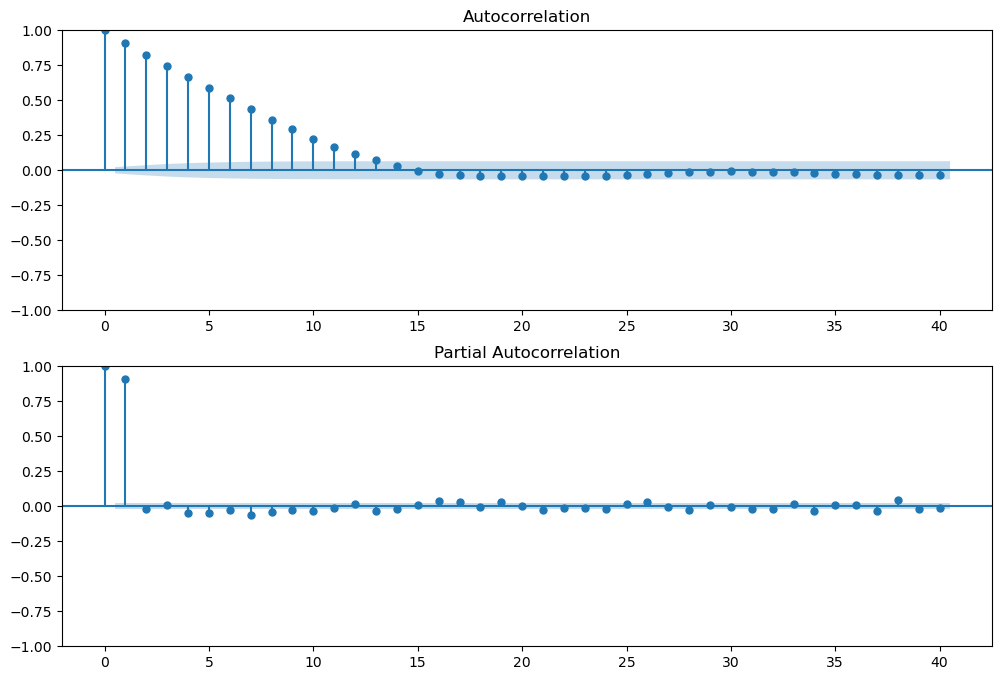

ACF and PACF for POOL


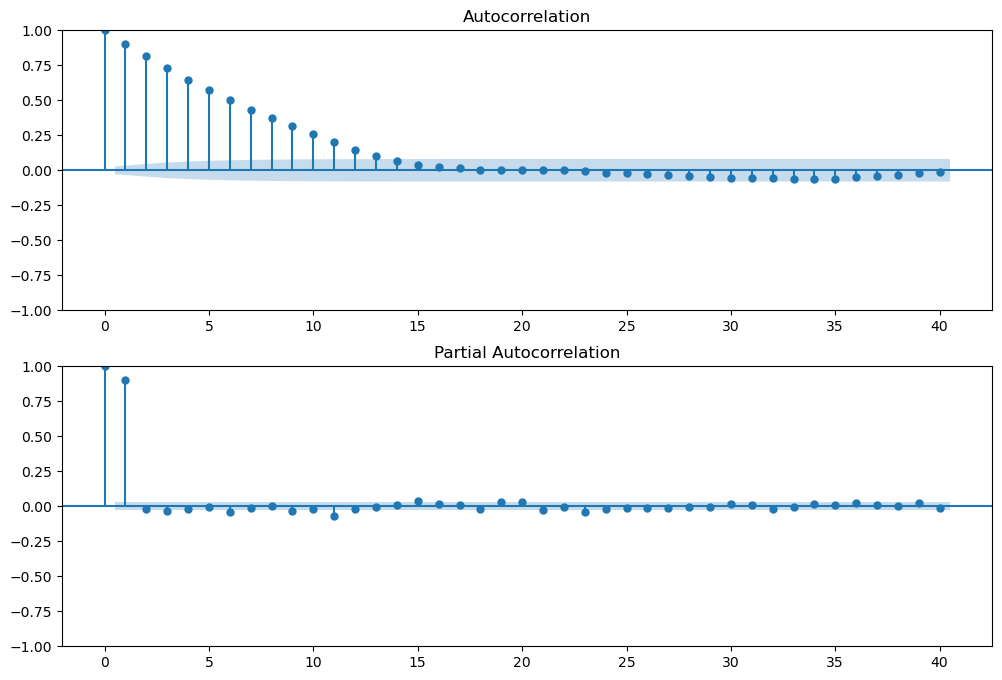

ACF and PACF for VYGVQ


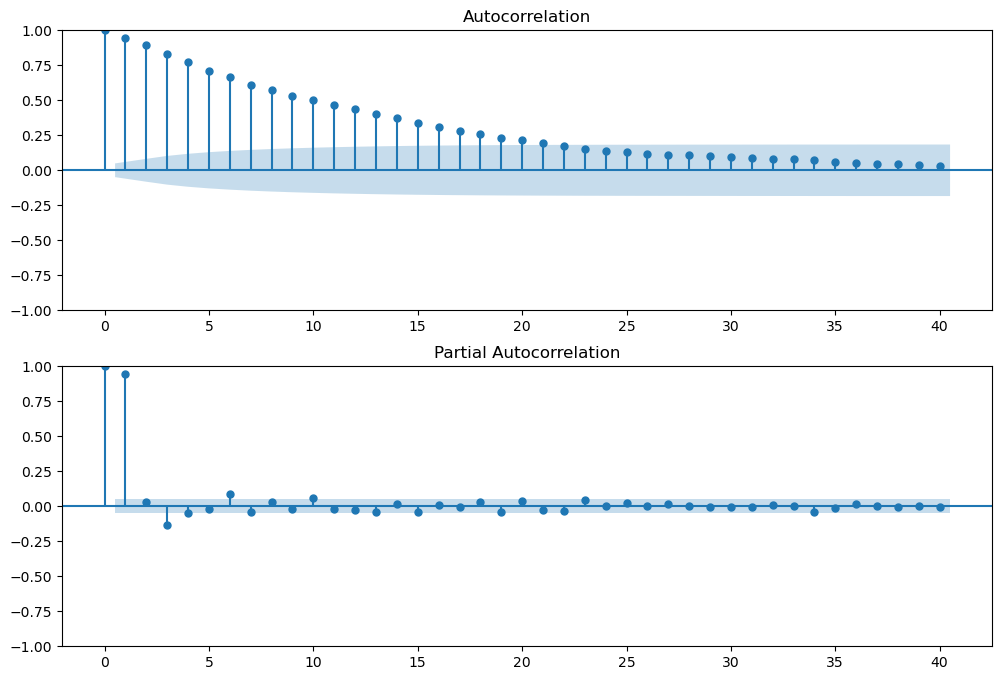

In [36]:
def plot_acf_pacf(timeseries, lags=40):
    if isinstance(timeseries, np.ndarray):
        timeseries = pd.Series(timeseries)

    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(timeseries.dropna(), lags=lags, ax=ax1)  
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(timeseries.dropna(), lags=lags, ax=ax2)  

# Apply the function for each stock symbol
for symbol in ['AON', 'POOL', 'VYGVQ']:
    print(f'ACF and PACF for {symbol}')
    plot_acf_pacf(train_data[symbol][1])  
    plt.show()

In [51]:
# Function to fit ARIMA model
def fit_arima(train_data, order=(1, 0, 1)):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to fit SARIMA model
def fit_sarima(train_data, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)):
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    return model_fit

arima_orders = {
    'AON': (2, 0, 2),
    'POOL': (2, 0, 2),
    'VYGVQ': (2, 0, 2)
}
sarima_orders = {
    'AON': ((1, 0, 1), (1, 0, 1, 12)),
    'POOL': ((1, 0, 1), (1, 0, 1, 12)),
    'VYGVQ': ((1, 0, 1), (1, 0, 1, 12))
}

for symbol in ['AON', 'POOL', 'VYGVQ']:
    print(f"Fitting ARIMA model for {symbol}")
    arima_models[symbol] = fit_arima(train_data[symbol][1], order=arima_orders[symbol])

    print(f"Fitting SARIMA model for {symbol}")
    sarima_models[symbol] = fit_sarima(train_data[symbol][1], order=sarima_orders[symbol][0], seasonal_order=sarima_orders[symbol][1])


def calculate_rmse_mae(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    return rmse, mae

# Calculate the metrics for each stock symbol
for symbol in ['AON', 'POOL', 'VYGVQ']:
    actual = test_data[symbol][1]  

    # ARIMA predictions and metrics
    arima_predictions = arima_models[symbol].predict(start=len(train_data[symbol][1]), end=len(train_data[symbol][1])+len(test_data[symbol][1])-1)
    arima_rmse, arima_mae = calculate_rmse_mae(actual, arima_predictions)
    print(f"ARIMA metrics for {symbol}: RMSE={arima_rmse}, MAE={arima_mae}")

    # SARIMA predictions and metrics
    sarima_predictions = sarima_models[symbol].predict(start=len(train_data[symbol][1]), end=len(train_data[symbol][1])+len(test_data[symbol][1])-1)
    sarima_rmse, sarima_mae = calculate_rmse_mae(actual, sarima_predictions)
    print(f"SARIMA metrics for {symbol}: RMSE={sarima_rmse}, MAE={sarima_mae}")

Fitting ARIMA model for AON
Fitting SARIMA model for AON
Fitting ARIMA model for POOL
Fitting SARIMA model for POOL


C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fitting ARIMA model for VYGVQ
Fitting SARIMA model for VYGVQ


C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



ARIMA metrics for AON: RMSE=0.7052892566581265, MAE=0.5056934246718755
SARIMA metrics for AON: RMSE=0.788747821286302, MAE=0.5869098908809073
ARIMA metrics for POOL: RMSE=1.9012564140354977, MAE=1.4723035559017241
SARIMA metrics for POOL: RMSE=1.9106043455412713, MAE=1.4652241024480976
ARIMA metrics for VYGVQ: RMSE=0.008361819413500643, MAE=0.008047317514239944
SARIMA metrics for VYGVQ: RMSE=0.06661175279782101, MAE=0.05847313756091527


In [19]:
# Calculate returns for AON and drop NaN values
stock_data['AON']['returns'] = stock_data['AON']['Close'].pct_change()
stock_data['AON'].dropna(subset=['returns'], inplace=True)

# GARCH Model Specification for AON
garch_model_aon = arch_model(stock_data['AON']['returns'], vol='Garch', p=1, q=1)

# Fit the model for AON
garch_fit_aon = garch_model_aon.fit()

# Display the model summary for AON
print("GARCH Model Summary for AON:\n")
print(garch_fit_aon.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 21040501383.656094
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2.486170104823046e+19
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4.908954729859054e+24
Iteration:      4,   Func. Count:     49,   Neg. LLF: 2.7770869801581508e+22
Iteration:      5,   Func. Count:     60,   Neg. LLF: 1.705980646498791e+23
Iteration:      6,   Func. Count:     73,   Neg. LLF: 3.035219150245802e+23
Iteration:      7,   Func. Count:     88,   Neg. LLF: 4.16053325182718e+16
Iteration:      8,   Func. Count:    103,   Neg. LLF: 5479084788081.475
Iteration:      9,   Func. Count:    117,   Neg. LLF: -10046.56201763196
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10046.56156011729
            Iterations: 13
            Function evaluations: 117
            Gradient evaluations: 9
GARCH Model Summary for AON:

                     Constant Mean - GARCH Model Results                      
Dep. Va

C:\Users\nikhi\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003048. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [17]:
# Calculate returns for POOL and drop NaN values
stock_data['POOL']['returns'] = stock_data['POOL']['Close'].pct_change()
stock_data['POOL'].dropna(subset=['returns'], inplace=True)

# GARCH Model Specification for POOL
garch_model_pool = arch_model(stock_data['POOL']['returns'], vol='Garch', p=1, q=1)

# Fit the model for POOL
garch_fit_pool = garch_model_pool.fit()

# Display the model summary for POOL
print("GARCH Model Summary for POOL:\n")
print(garch_fit_pool.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7.929070091255073e+18
Iteration:      2,   Func. Count:     19,   Neg. LLF: 47942733323077.01
Iteration:      3,   Func. Count:     29,   Neg. LLF: 9.044017571511902e+18
Iteration:      4,   Func. Count:     41,   Neg. LLF: -17396.302745374338
Optimization terminated successfully    (Exit mode 0)
            Current function value: -17396.302768333117
            Iterations: 8
            Function evaluations: 41
            Gradient evaluations: 4
GARCH Model Summary for POOL:

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                17396.3
Distribution:                  Normal   AIC:                          -34784.6
Method:            Maximum Likelihood   BIC:                       

C:\Users\nikhi\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005141. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [18]:
# Calculate returns for VYGVQ and drop NaN values
stock_data['VYGVQ']['returns'] = stock_data['VYGVQ']['Close'].pct_change()
stock_data['VYGVQ'].dropna(subset=['returns'], inplace=True)

# GARCH Model Specification for VYGVQ
garch_model_vygvq = arch_model(stock_data['VYGVQ']['returns'], vol='Garch', p=1, q=1)

# Fit the model for VYGVQ
garch_fit_vygvq = garch_model_vygvq.fit()

# Display the model summary for VYGVQ
print("\nGARCH Model Summary for VYGVQ:\n")
print(garch_fit_vygvq.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 14443.50662461844
Iteration:      2,   Func. Count:     13,   Neg. LLF: 8407.533827752297
Iteration:      3,   Func. Count:     18,   Neg. LLF: 8559.521749897624
Iteration:      4,   Func. Count:     25,   Neg. LLF: 8748.676920699952
Iteration:      5,   Func. Count:     34,   Neg. LLF: 8407.472583642502
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8408.008271479357
Iteration:      7,   Func. Count:     48,   Neg. LLF: 8407.326989872394
Iteration:      8,   Func. Count:     53,   Neg. LLF: 8407.008381218107
Iteration:      9,   Func. Count:     58,   Neg. LLF: 974341.0258089311
Iteration:     10,   Func. Count:     64,   Neg. LLF: 975423.0728921257
Iteration:     11,   Func. Count:     70,   Neg. LLF: 13912.376130654748
Iteration:     12,   Func. Count:     78,   Neg. LLF: 17145.478028688172
Iteration:     13,   Func. Count:     86,   Neg. LLF: 8406.581073524223
Iteration:     14,   Func. Count:     91,   Neg. LLF: 8406.572

## Model Building - RNN

In [38]:
# Common hyperparameters
batch_size = 32
epochs = 50
learning_rate = 0.001

# Preparing data for each symbol
data_per_symbol = {}

for symbol in ['AON', 'POOL', 'VYGVQ']:
    train_sequences, train_labels = train_data[symbol]
    val_sequences, val_labels = validation_data[symbol]
    test_sequences, test_labels = test_data[symbol]

    # Convert to TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_sequences, val_labels)).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_sequences, test_labels)).batch(batch_size)

    data_per_symbol[symbol] = (train_dataset, val_dataset, test_dataset)

In [39]:
models = {}
histories = {}

for symbol in ['AON', 'POOL', 'VYGVQ']:
    train_dataset, val_dataset, _ = data_per_symbol[symbol]

    # Vanilla RNN Model
    vanilla_rnn_model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(50, activation='tanh', input_shape=(sequence_length, 1)),
        tf.keras.layers.Dense(1)
    ])

    vanilla_rnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                              loss='mean_squared_error')

    history_vanilla_rnn = vanilla_rnn_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

    # LSTM Model
    lstm_model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, activation='tanh', input_shape=(sequence_length, 1)),
        tf.keras.layers.Dense(1)
    ])

    lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                       loss='mean_squared_error')

    history_lstm = lstm_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

    # GRU Model
    gru_model = tf.keras.Sequential([
        tf.keras.layers.GRU(50, activation='tanh', input_shape=(sequence_length, 1)),
        tf.keras.layers.Dense(1)
    ])

    gru_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='mean_squared_error')

    history_gru = gru_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

    # Store models and histories
    models[symbol] = {'vanilla_rnn': vanilla_rnn_model, 'lstm': lstm_model, 'gru': gru_model}
    histories[symbol] = {'vanilla_rnn': history_vanilla_rnn, 'lstm': history_lstm, 'gru': history_gru}


Epoch 1/50
238/238 [==============================] - 8s 19ms/step - loss: 0.0050 - val_loss: 0.0084
Epoch 2/50
238/238 [==============================] - 4s 17ms/step - loss: 0.0018 - val_loss: 0.0072
Epoch 3/50
238/238 [==============================] - 4s 17ms/step - loss: 0.0015 - val_loss: 0.0064
Epoch 4/50
238/238 [==============================] - 20s 82ms/step - loss: 0.0013 - val_loss: 0.0056
Epoch 5/50
238/238 [==============================] - 17s 72ms/step - loss: 0.0012 - val_loss: 0.0050
Epoch 6/50
238/238 [==============================] - 12s 50ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 7/50
238/238 [==============================] - 15s 65ms/step - loss: 9.9922e-04 - val_loss: 0.0044
Epoch 8/50
238/238 [==============================] - 15s 60ms/step - loss: 9.5354e-04 - val_loss: 0.0043
Epoch 9/50
238/238 [==============================] - 9s 40ms/step - loss: 9.2471e-04 - val_loss: 0.0042
Epoch 10/50
238/238 [==============================] - 10s 41ms/step - los

Epoch 29/50
238/238 [==============================] - 8s 34ms/step - loss: 8.6222e-04 - val_loss: 0.0040
Epoch 30/50
238/238 [==============================] - 12s 53ms/step - loss: 8.6131e-04 - val_loss: 0.0040
Epoch 31/50
238/238 [==============================] - 12s 52ms/step - loss: 8.6050e-04 - val_loss: 0.0040
Epoch 32/50
238/238 [==============================] - 14s 60ms/step - loss: 8.5976e-04 - val_loss: 0.0039
Epoch 33/50
238/238 [==============================] - 12s 49ms/step - loss: 8.5909e-04 - val_loss: 0.0039
Epoch 34/50
238/238 [==============================] - 12s 51ms/step - loss: 8.5848e-04 - val_loss: 0.0039
Epoch 35/50
238/238 [==============================] - 11s 46ms/step - loss: 8.5792e-04 - val_loss: 0.0040
Epoch 36/50
238/238 [==============================] - 14s 59ms/step - loss: 8.5743e-04 - val_loss: 0.0040
Epoch 37/50
238/238 [==============================] - 11s 47ms/step - loss: 8.5699e-04 - val_loss: 0.0040
Epoch 38/50
238/238 [=================

153/153 [==============================] - 5s 34ms/step - loss: 0.0017 - val_loss: 0.0284
Epoch 37/50
153/153 [==============================] - 5s 30ms/step - loss: 0.0017 - val_loss: 0.0284
Epoch 38/50
153/153 [==============================] - 5s 35ms/step - loss: 0.0017 - val_loss: 0.0284
Epoch 39/50
153/153 [==============================] - 5s 34ms/step - loss: 0.0017 - val_loss: 0.0283
Epoch 40/50
153/153 [==============================] - 5s 33ms/step - loss: 0.0017 - val_loss: 0.0283
Epoch 41/50
153/153 [==============================] - 5s 35ms/step - loss: 0.0017 - val_loss: 0.0282
Epoch 42/50
153/153 [==============================] - 5s 34ms/step - loss: 0.0017 - val_loss: 0.0282
Epoch 43/50
153/153 [==============================] - 5s 33ms/step - loss: 0.0017 - val_loss: 0.0281
Epoch 44/50
153/153 [==============================] - 4s 26ms/step - loss: 0.0017 - val_loss: 0.0281
Epoch 45/50
153/153 [==============================] - 4s 25ms/step - loss: 0.0017 - val_loss:

Epoch 17/50
50/50 [==============================] - 1s 12ms/step - loss: 8.3681e-04 - val_loss: 0.0705
Epoch 18/50
50/50 [==============================] - 1s 12ms/step - loss: 8.0319e-04 - val_loss: 0.0686
Epoch 19/50
50/50 [==============================] - 1s 12ms/step - loss: 7.7286e-04 - val_loss: 0.0669
Epoch 20/50
50/50 [==============================] - 10s 210ms/step - loss: 7.4540e-04 - val_loss: 0.0653
Epoch 21/50
50/50 [==============================] - 1s 17ms/step - loss: 7.2049e-04 - val_loss: 0.0639
Epoch 22/50
50/50 [==============================] - 1s 15ms/step - loss: 6.9784e-04 - val_loss: 0.0625
Epoch 23/50
50/50 [==============================] - 1s 17ms/step - loss: 6.7721e-04 - val_loss: 0.0613
Epoch 24/50
50/50 [==============================] - 1s 18ms/step - loss: 6.5840e-04 - val_loss: 0.0601
Epoch 25/50
50/50 [==============================] - 1s 18ms/step - loss: 6.4122e-04 - val_loss: 0.0591
Epoch 26/50
50/50 [==============================] - 1s 17ms/s

In [40]:
evaluation_results = {}

for symbol in ['AON', 'POOL', 'VYGVQ']:
    _, _, test_dataset = data_per_symbol[symbol]
    evaluation_results[symbol] = {}

    for model_type in ['vanilla_rnn', 'lstm', 'gru']:
        model = models[symbol][model_type]
        test_loss = model.evaluate(test_dataset)
        evaluation_results[symbol][model_type] = test_loss
        print(f"{symbol} - {model_type} Test Loss:", test_loss)

50/50 [==============================] - 0s 8ms/step - loss: 0.0769
AON - vanilla_rnn Test Loss: 0.07686774432659149
50/50 [==============================] - 1s 18ms/step - loss: 0.0926
AON - lstm Test Loss: 0.09262548387050629
50/50 [==============================] - 1s 14ms/step - loss: 0.0974
AON - gru Test Loss: 0.09741195291280746
32/32 [==============================] - 0s 7ms/step - loss: 0.8048
POOL - vanilla_rnn Test Loss: 0.80475252866745
32/32 [==============================] - 1s 14ms/step - loss: 0.7811
POOL - lstm Test Loss: 0.7811300158500671
32/32 [==============================] - 0s 12ms/step - loss: 1.3038
POOL - gru Test Loss: 1.3037556409835815
10/10 [==============================] - 0s 6ms/step - loss: 1.1956e-04
VYGVQ - vanilla_rnn Test Loss: 0.00011956047819694504
10/10 [==============================] - 0s 14ms/step - loss: 7.5122e-05
VYGVQ - lstm Test Loss: 7.51217085053213e-05
10/10 [==============================] - 0s 12ms/step - loss: 8.4258e-05
VYGVQ - g

In [41]:
predicted_values = {}
actual_values = {}

for symbol in ['AON', 'POOL', 'VYGVQ']:
    test_sequences, test_labels = test_data[symbol]
    actual_values[symbol] = test_labels

    predicted_values[symbol] = {}
    for model_type in ['vanilla_rnn', 'lstm', 'gru']:
        model = models[symbol][model_type]
        predicted = model.predict(test_sequences)
        predicted_values[symbol][model_type] = predicted

10/10 [==============================] - 1s 12ms/step


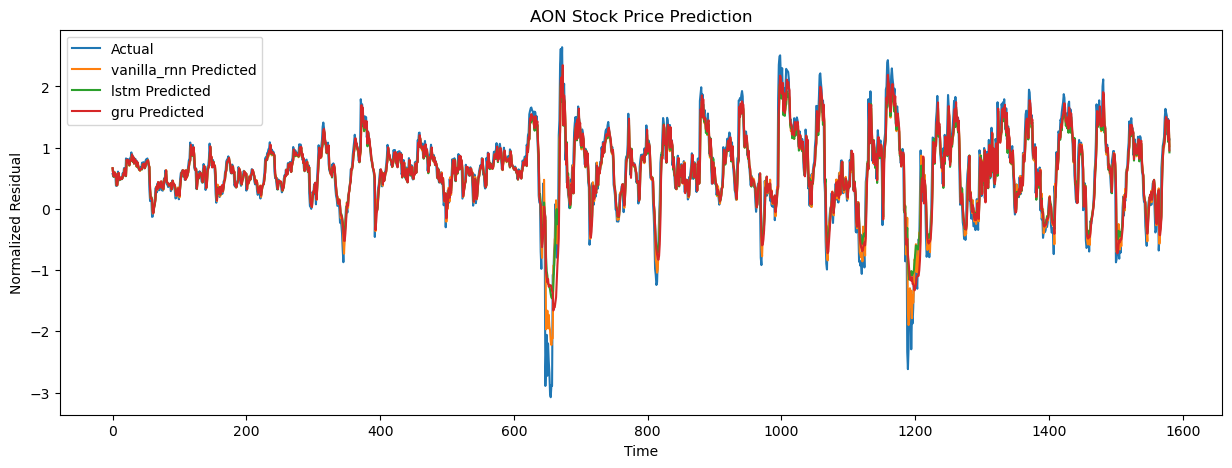

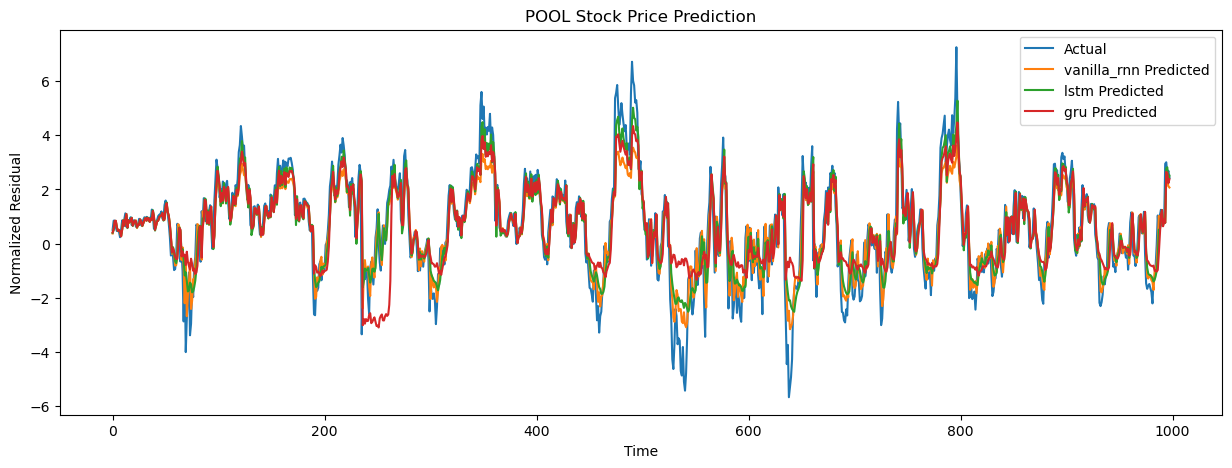

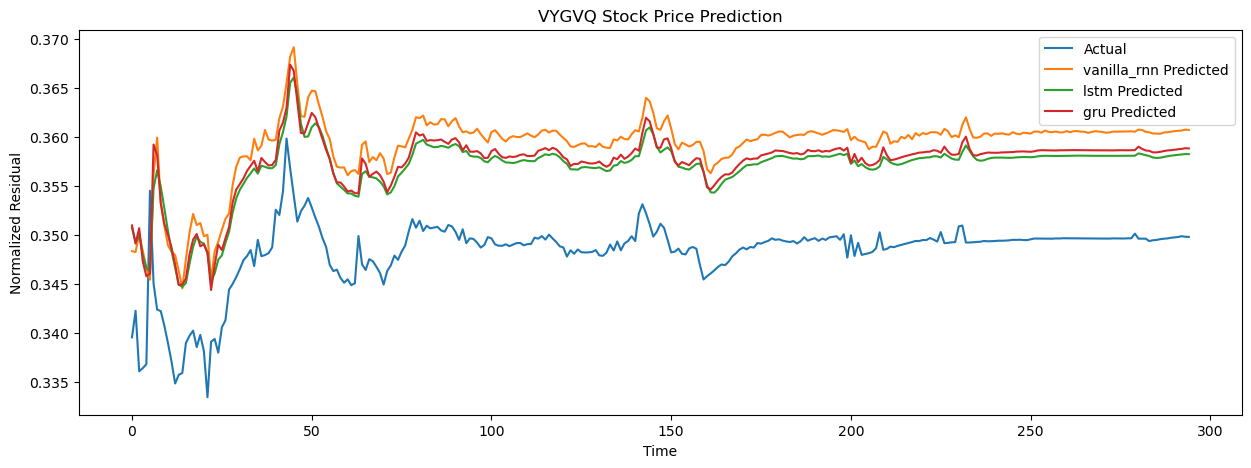

In [42]:
for symbol in ['AON', 'POOL', 'VYGVQ']:
    plt.figure(figsize=(15, 5))
    plt.plot(actual_values[symbol], label='Actual')

    for model_type in ['vanilla_rnn', 'lstm', 'gru']:
        plt.plot(predicted_values[symbol][model_type], label=model_type + ' Predicted')

    plt.title(f'{symbol} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Normalized Residual')
    plt.legend()
    plt.show()


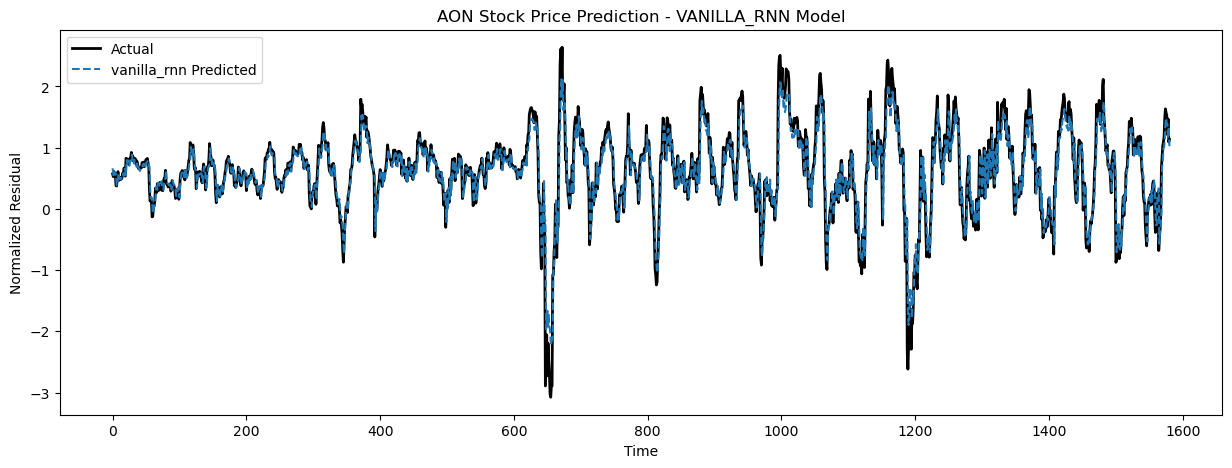

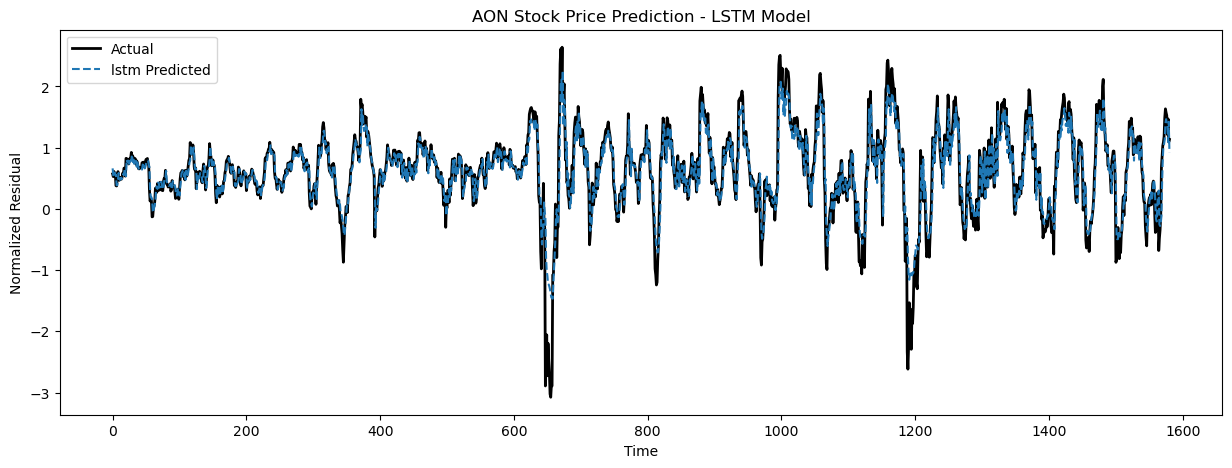

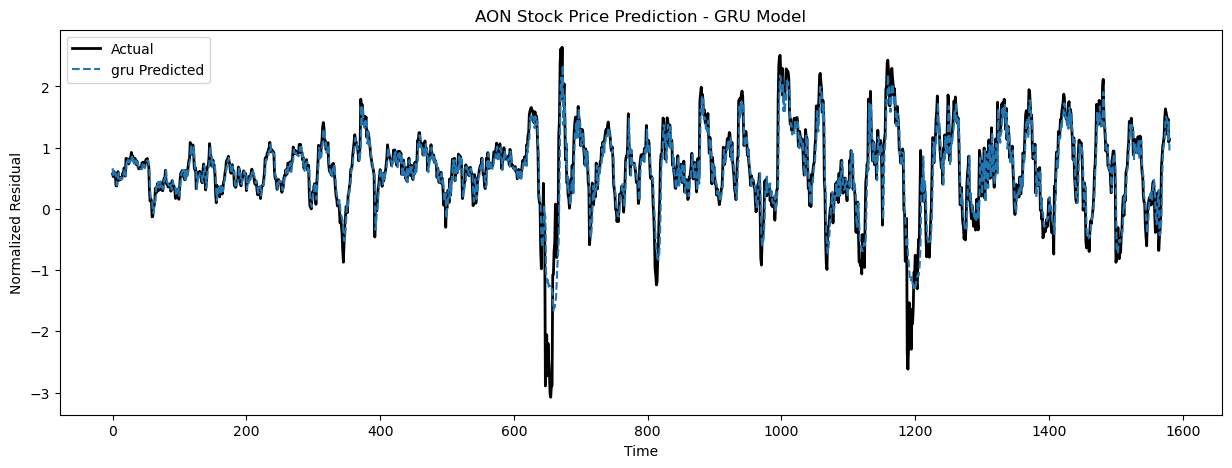

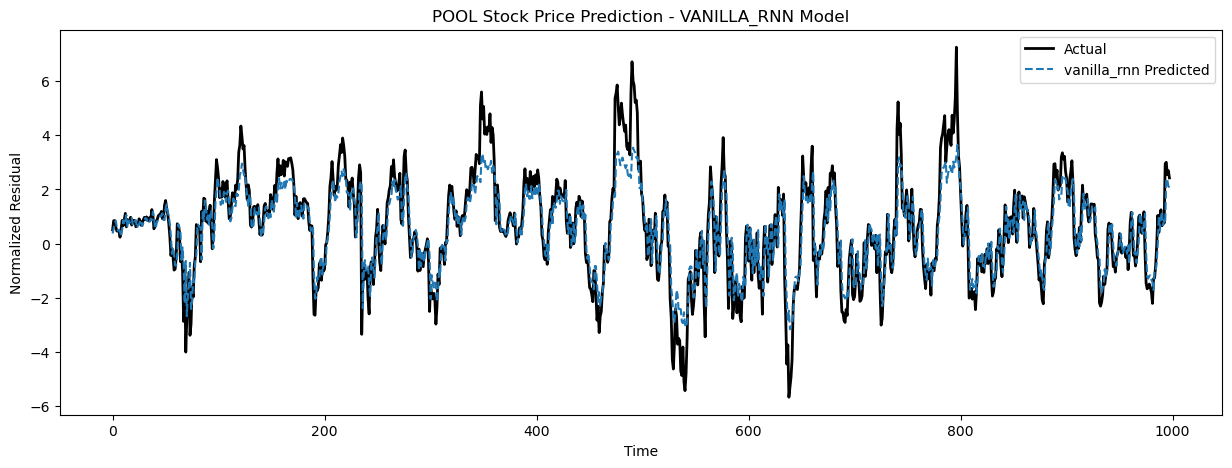

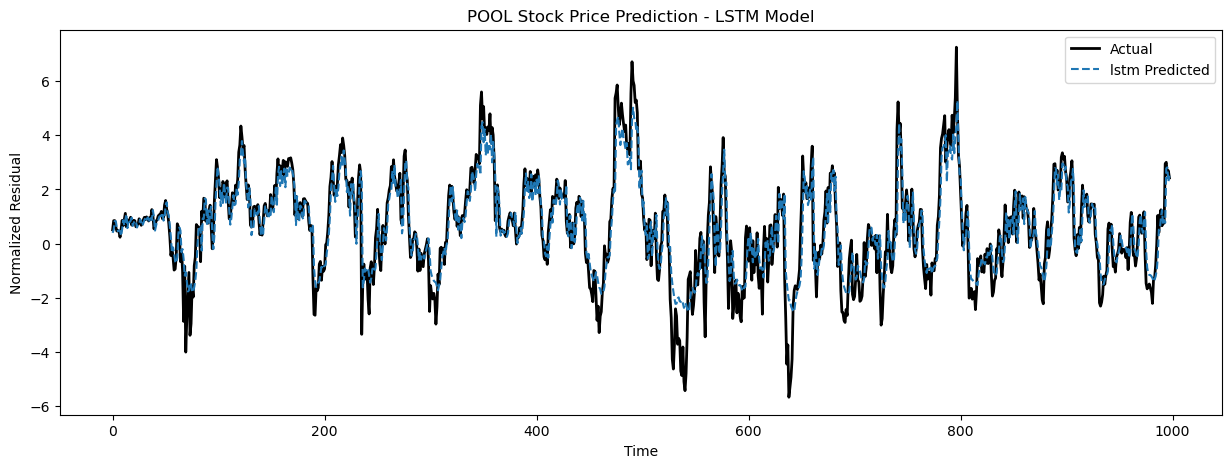

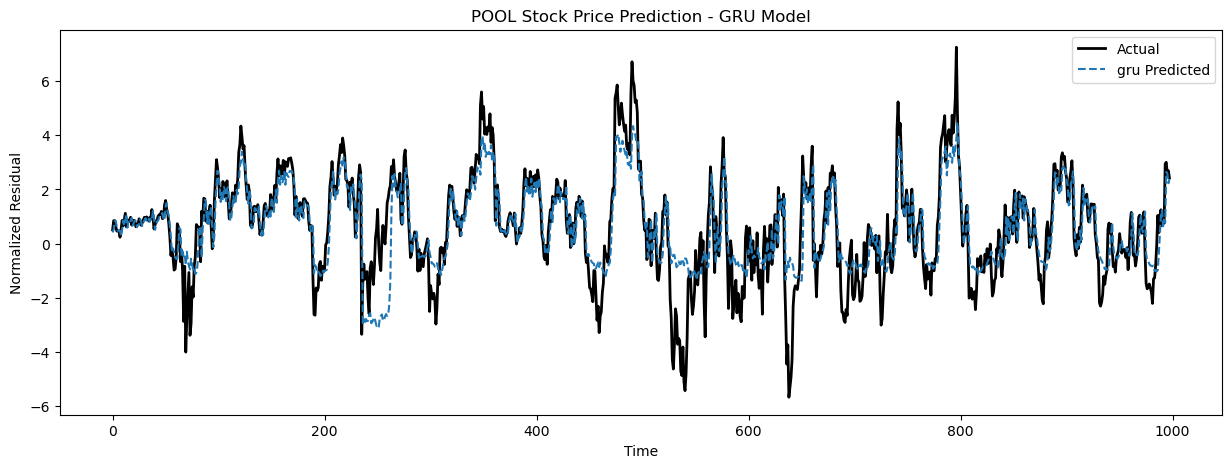

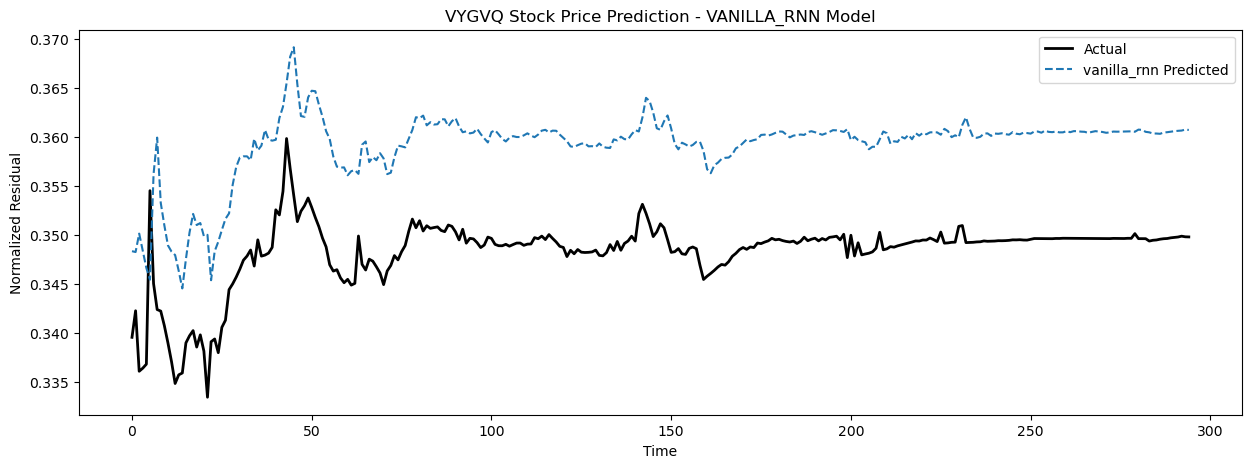

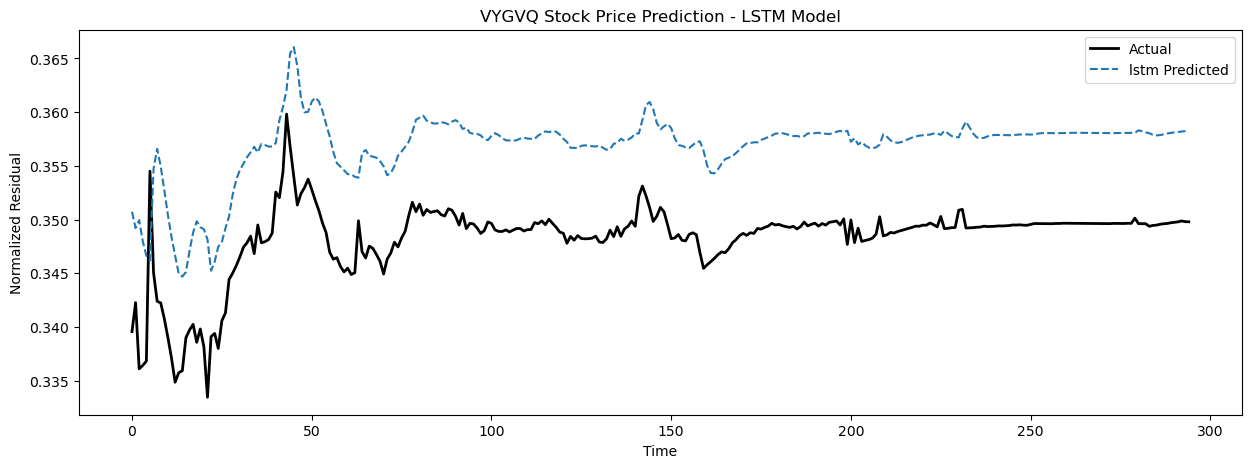

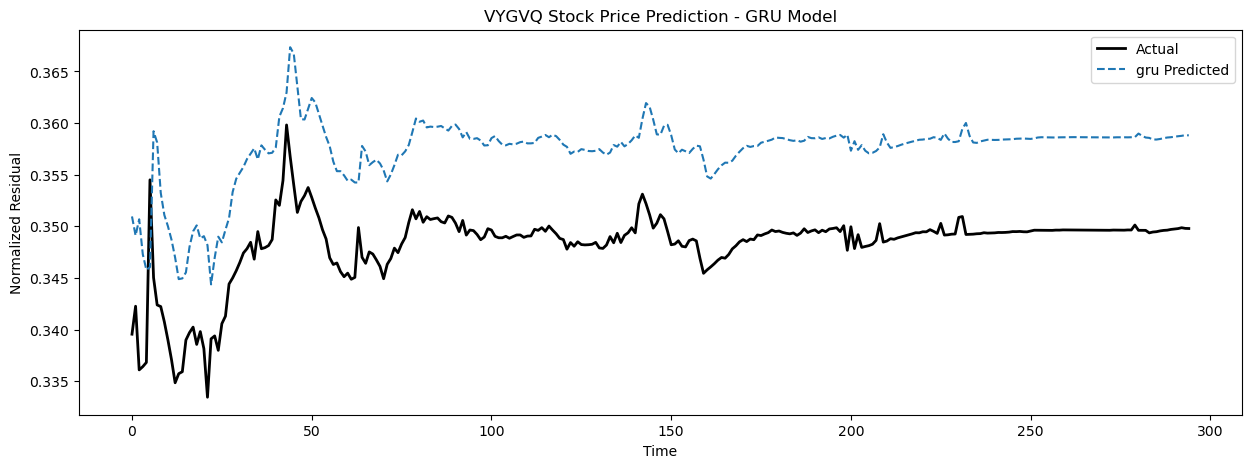

In [43]:
import matplotlib.pyplot as plt

for symbol in ['AON', 'POOL', 'VYGVQ']:
    for model_type in ['vanilla_rnn', 'lstm', 'gru']:
        plt.figure(figsize=(15, 5))
        plt.plot(actual_values[symbol], label='Actual', color='black', linewidth=2)
        plt.plot(predicted_values[symbol][model_type], label=model_type + ' Predicted', linestyle='--')

        plt.title(f'{symbol} Stock Price Prediction - {model_type.upper()} Model')
        plt.xlabel('Time')
        plt.ylabel('Normalized Residual')
        plt.legend()
        plt.show()


In [52]:
metrics_results = {}

for symbol in ['AON', 'POOL', 'VYGVQ']:
    metrics_results[symbol] = {}

    for model_type in ['vanilla_rnn', 'lstm', 'gru']:
        # Get the actual and predicted values
        actual = actual_values[symbol].flatten()
        predicted = predicted_values[symbol][model_type].flatten()

        # Calculate MAE
        mae = mean_absolute_error(actual, predicted)

        # Calculate RMSE
        rmse = mean_squared_error(actual, predicted, squared=False)

        # Store the metrics
        metrics_results[symbol][model_type] = {
            'MAE': mae,
            'RMSE': rmse
        }

        print(f'{symbol} - {model_type} - MAE: {mae:.5f}, RMSE: {rmse:.5f}')


AON - vanilla_rnn - MAE: 0.18503, RMSE: 0.27725
AON - lstm - MAE: 0.19600, RMSE: 0.30434
AON - gru - MAE: 0.19747, RMSE: 0.31211
POOL - vanilla_rnn - MAE: 0.65675, RMSE: 0.89708
POOL - lstm - MAE: 0.64446, RMSE: 0.88382
POOL - gru - MAE: 0.79575, RMSE: 1.14182
VYGVQ - vanilla_rnn - MAE: 0.01087, RMSE: 0.01093
VYGVQ - lstm - MAE: 0.00858, RMSE: 0.00867
VYGVQ - gru - MAE: 0.00910, RMSE: 0.00918


## Hyperparameter Tuning

In [14]:
def build_model(trial, model_type, input_shape):
    # Hyperparameters to be optimized
    units = trial.suggest_categorical('units', [50, 100, 150])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Model building
    model = Sequential()
    if model_type == 'lstm':
        model.add(LSTM(units, input_shape=input_shape, return_sequences=True))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(units))
    elif model_type == 'gru':
        model.add(GRU(units, input_shape=input_shape, return_sequences=True))
        model.add(Dropout(dropout_rate))
        model.add(GRU(units))

    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    return model, batch_size

def objective(trial, model_type, symbol):
    K.clear_session()  # Clear the TensorFlow session before starting a new trial.

    # Get the appropriate dataset for the symbol
    train_sequences, train_labels = train_data[symbol]
    val_sequences, val_labels = validation_data[symbol]

    # Build the model
    model, batch_size = build_model(trial, model_type, input_shape=(sequence_length, 1))

    # Early stopping and ModelCheckpoint callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    checkpoint_filepath = f'tmp/checkpoint_{trial.number}'
    model_checkpoint = ModelCheckpoint(checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

    # Pruning callback
    pruning_callback = TFKerasPruningCallback(trial, 'val_loss')

    # Train the model
    model.fit(
        train_sequences,
        train_labels,
        epochs=50,
        batch_size=batch_size,
        validation_data=(val_sequences, val_labels),
        callbacks=[early_stopping, model_checkpoint, pruning_callback],
        verbose=1
    )

    # Load the best model weights before evaluating
    model.load_weights(checkpoint_filepath)

    # Evaluate the model on the validation set
    val_loss = model.evaluate(val_sequences, val_labels, verbose=0)
    return val_loss, model

# Define the number of trials
n_trials = 25

# Run separate studies for each stock and model type
final_models = {}
for symbol in ['AON', 'POOL', 'VYGVQ']:
    for model_type in ['lstm', 'gru']:
        print(f"Optimizing {model_type} model for {symbol}")

        # Create a pruner and a study
        pruner = MedianPruner()
        study = optuna.create_study(direction='minimize', pruner=pruner)
        study.optimize(lambda trial: objective(trial, model_type, symbol)[0], n_trials=n_trials)

        # Visualization after each study
        ov.plot_optimization_history(study)
        ov.plot_param_importances(study)

        # Retrieve the best model
        best_trial = study.best_trial
        _, best_model = objective(best_trial, model_type, symbol)
        final_models[(symbol, model_type)] = best_model

# Print out the best parameters and performance for each model and stock
for (symbol, model_type), best_model in final_models.items():
    print(f"Best {model_type} model for {symbol} has been saved.")


[I 2023-11-19 13:27:00,164] A new study created in memory with name: no-name-6f6ad58a-339e-426e-a074-b4b66560c118


Optimizing lstm model for AON
Epoch 1/50
60/60 [==============================] - 8s 38ms/step - loss: 0.0555 - val_loss: 0.0151
Epoch 2/50
60/60 [==============================] - 1s 22ms/step - loss: 0.0040 - val_loss: 0.0136
Epoch 3/50
60/60 [==============================] - 1s 18ms/step - loss: 0.0035 - val_loss: 0.0117
Epoch 4/50
60/60 [==============================] - 1s 18ms/step - loss: 0.0031 - val_loss: 0.0098
Epoch 5/50
60/60 [==============================] - 1s 20ms/step - loss: 0.0026 - val_loss: 0.0083
Epoch 6/50
60/60 [==============================] - 1s 21ms/step - loss: 0.0024 - val_loss: 0.0078
Epoch 7/50
60/60 [==============================] - 2s 30ms/step - loss: 0.0022 - val_loss: 0.0071
Epoch 8/50
60/60 [==============================] - 2s 26ms/step - loss: 0.0021 - val_loss: 0.0068
Epoch 9/50
60/60 [==============================] - 2s 26ms/step - loss: 0.0019 - val_loss: 0.0063
Epoch 10/50
60/60 [==============================] - 1s 24ms/step - loss: 0.001

[I 2023-11-19 13:27:42,579] Trial 0 finished with value: 0.004012834280729294 and parameters: {'units': 150, 'dropout_rate': 0.2182406035023027, 'learning_rate': 0.008093236972651055, 'batch_size': 128}. Best is trial 0 with value: 0.004012834280729294.


Epoch 1/50
238/238 [==============================] - 8s 14ms/step - loss: 0.0102 - val_loss: 0.0087
Epoch 2/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0076
Epoch 3/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0022 - val_loss: 0.0063
Epoch 4/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0017 - val_loss: 0.0055
Epoch 5/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0015 - val_loss: 0.0050
Epoch 6/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 7/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0013 - val_loss: 0.0049
Epoch 8/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 9/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 10/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0012 - val_loss: 0.0

[I 2023-11-19 13:28:27,741] Trial 1 finished with value: 0.004114220850169659 and parameters: {'units': 100, 'dropout_rate': 0.4921577128800432, 'learning_rate': 0.006744189242245451, 'batch_size': 32}. Best is trial 0 with value: 0.004012834280729294.


Epoch 1/50
238/238 [==============================] - 7s 12ms/step - loss: 0.0117 - val_loss: 0.0121
Epoch 2/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0045 - val_loss: 0.0088
Epoch 3/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0035 - val_loss: 0.0074
Epoch 4/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0028 - val_loss: 0.0067
Epoch 5/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0024 - val_loss: 0.0063
Epoch 6/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0019 - val_loss: 0.0056
Epoch 7/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0016 - val_loss: 0.0051
Epoch 8/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0014 - val_loss: 0.0048
Epoch 9/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0013 - val_loss: 0.0044
Epoch 10/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0012 - val_loss: 

[I 2023-11-19 13:29:54,456] Trial 2 finished with value: 0.004088033922016621 and parameters: {'units': 100, 'dropout_rate': 0.44497716291779554, 'learning_rate': 0.0027797882488487897, 'batch_size': 32}. Best is trial 0 with value: 0.004012834280729294.


Epoch 1/50
238/238 [==============================] - 6s 13ms/step - loss: 0.1367 - val_loss: 0.0256
Epoch 2/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0120 - val_loss: 0.0213
Epoch 3/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0111 - val_loss: 0.0210
Epoch 4/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0102 - val_loss: 0.0208
Epoch 5/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0098 - val_loss: 0.0204
Epoch 6/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0091 - val_loss: 0.0200
Epoch 7/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0088 - val_loss: 0.0198
Epoch 8/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0083 - val_loss: 0.0194
Epoch 9/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0082 - val_loss: 0.0192
Epoch 10/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0077 - val_loss

[I 2023-11-19 13:32:19,914] Trial 3 finished with value: 0.010225154459476471 and parameters: {'units': 100, 'dropout_rate': 0.37784689564192986, 'learning_rate': 1.237647575810483e-05, 'batch_size': 32}. Best is trial 0 with value: 0.004012834280729294.


Epoch 1/50
60/60 [==============================] - 6s 23ms/step - loss: 0.0204 - val_loss: 0.0144
Epoch 2/50
60/60 [==============================] - 1s 10ms/step - loss: 0.0043 - val_loss: 0.0132
Epoch 3/50
60/60 [==============================] - 1s 10ms/step - loss: 0.0040 - val_loss: 0.0121
Epoch 4/50
60/60 [==============================] - 1s 10ms/step - loss: 0.0036 - val_loss: 0.0111
Epoch 5/50
60/60 [==============================] - 1s 10ms/step - loss: 0.0032 - val_loss: 0.0098
Epoch 6/50
60/60 [==============================] - 1s 10ms/step - loss: 0.0029 - val_loss: 0.0089
Epoch 7/50
60/60 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.0083
Epoch 8/50
60/60 [==============================] - 1s 10ms/step - loss: 0.0027 - val_loss: 0.0082
Epoch 9/50
60/60 [==============================] - 1s 10ms/step - loss: 0.0025 - val_loss: 0.0075
Epoch 10/50
60/60 [==============================] - 1s 10ms/step - loss: 0.0025 - val_loss: 0.0073
Epoch 11/

[I 2023-11-19 13:33:05,575] Trial 4 finished with value: 0.003997208550572395 and parameters: {'units': 50, 'dropout_rate': 0.11658470236590608, 'learning_rate': 0.0019571044906337137, 'batch_size': 128}. Best is trial 4 with value: 0.003997208550572395.


Epoch 1/50
238/238 [==============================] - 7s 13ms/step - loss: 0.0105 - val_loss: 0.0095
Epoch 2/50
238/238 [==============================] - 3s 13ms/step - loss: 0.0039 - val_loss: 0.0077
Epoch 3/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0028 - val_loss: 0.0067
Epoch 4/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0024 - val_loss: 0.0060
Epoch 5/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0019 - val_loss: 0.0055
Epoch 6/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0017 - val_loss: 0.0052
Epoch 7/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0015 - val_loss: 0.0047
Epoch 8/50
238/238 [==============================] - 3s 13ms/step - loss: 0.0014 - val_loss: 0.0048
Epoch 9/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 10/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0012 - val_loss: 

[I 2023-11-19 13:34:31,576] Trial 5 finished with value: 0.004049576353281736 and parameters: {'units': 150, 'dropout_rate': 0.4963806155150967, 'learning_rate': 0.003785930071869428, 'batch_size': 32}. Best is trial 4 with value: 0.003997208550572395.


Epoch 1/50
60/60 [==============================] - 6s 31ms/step - loss: 0.0252 - val_loss: 0.0122
Epoch 2/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0031 - val_loss: 0.0110
Epoch 3/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0027 - val_loss: 0.0091
Epoch 4/50
56/60 [===========================>..] - ETA: 0s - loss: 0.0024

[I 2023-11-19 13:34:40,770] Trial 6 pruned. Trial was pruned at epoch 3.


Epoch 1/50
236/238 [============================>.] - ETA: 0s - loss: 0.0334

[I 2023-11-19 13:34:47,711] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/50
56/60 [===========================>..] - ETA: 0s - loss: 0.0981

[I 2023-11-19 13:34:53,881] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/50
233/238 [============================>.] - ETA: 0s - loss: 0.0184

[I 2023-11-19 13:35:01,290] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/50
117/119 [============================>.] - ETA: 0s - loss: 0.0139

[I 2023-11-19 13:35:08,784] Trial 10 pruned. Trial was pruned at epoch 0.


Epoch 1/50
54/60 [==========================>...] - ETA: 0s - loss: 0.0197

[I 2023-11-19 13:35:13,734] Trial 11 pruned. Trial was pruned at epoch 0.


Epoch 1/50
60/60 [==============================] - 6s 27ms/step - loss: 0.0177 - val_loss: 0.0120
Epoch 2/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0036 - val_loss: 0.0108
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 0.0033

[I 2023-11-19 13:35:22,448] Trial 12 pruned. Trial was pruned at epoch 2.


Epoch 1/50
60/60 [==============================] - 5s 27ms/step - loss: 0.0110 - val_loss: 0.0120
Epoch 2/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0028 - val_loss: 0.0105
Epoch 3/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0025 - val_loss: 0.0089
Epoch 4/50
60/60 [==============================] - 1s 16ms/step - loss: 0.0023 - val_loss: 0.0081
Epoch 5/50
60/60 [==============================] - ETA: 0s - loss: 0.0022

[I 2023-11-19 13:35:31,518] Trial 13 pruned. Trial was pruned at epoch 4.


Epoch 1/50
119/119 [==============================] - 6s 15ms/step - loss: 0.0124 - val_loss: 0.0132
Epoch 2/50
116/119 [============================>.] - ETA: 0s - loss: 0.0047

[I 2023-11-19 13:35:39,103] Trial 14 pruned. Trial was pruned at epoch 1.


Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.0269

[I 2023-11-19 13:35:45,308] Trial 15 pruned. Trial was pruned at epoch 0.


Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.0545

[I 2023-11-19 13:35:52,999] Trial 16 pruned. Trial was pruned at epoch 0.


Epoch 1/50
60/60 [==============================] - 6s 38ms/step - loss: 0.0091 - val_loss: 0.0086
Epoch 2/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0023 - val_loss: 0.0077
Epoch 3/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0021 - val_loss: 0.0073
Epoch 4/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0020 - val_loss: 0.0068
Epoch 5/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0018 - val_loss: 0.0064
Epoch 6/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0017 - val_loss: 0.0060
Epoch 7/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0017 - val_loss: 0.0060
Epoch 8/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0016 - val_loss: 0.0053
Epoch 9/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0015 - val_loss: 0.0050
Epoch 10/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0014 - val_loss: 0.0047
Epoch 11/

[I 2023-11-19 13:36:14,815] Trial 17 finished with value: 0.004059793893247843 and parameters: {'units': 150, 'dropout_rate': 0.13657152538519696, 'learning_rate': 0.003163759585466673, 'batch_size': 128}. Best is trial 4 with value: 0.003997208550572395.


Epoch 1/50
115/119 [===========================>..] - ETA: 0s - loss: 0.0141

[I 2023-11-19 13:36:20,334] Trial 18 pruned. Trial was pruned at epoch 0.


Epoch 1/50
58/60 [============================>.] - ETA: 0s - loss: 0.0436

[I 2023-11-19 13:36:26,218] Trial 19 pruned. Trial was pruned at epoch 0.


Epoch 1/50
60/60 [==============================] - 6s 28ms/step - loss: 0.0149 - val_loss: 0.0103
Epoch 2/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0031 - val_loss: 0.0080
Epoch 3/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0028 - val_loss: 0.0073
Epoch 4/50
56/60 [===========================>..] - ETA: 0s - loss: 0.0027

[I 2023-11-19 13:36:35,539] Trial 20 pruned. Trial was pruned at epoch 3.


Epoch 1/50
238/238 [==============================] - 8s 14ms/step - loss: 0.0071 - val_loss: 0.0085
Epoch 2/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0068
Epoch 3/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0024 - val_loss: 0.0060
Epoch 4/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0020 - val_loss: 0.0054
Epoch 5/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0017 - val_loss: 0.0049
Epoch 6/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 7/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 8/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 9/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 10/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0012 - val_lo

[I 2023-11-19 13:37:34,074] Trial 21 finished with value: 0.003939453978091478 and parameters: {'units': 150, 'dropout_rate': 0.3019648831575332, 'learning_rate': 0.003314624250267933, 'batch_size': 32}. Best is trial 21 with value: 0.003939453978091478.


Epoch 1/50
238/238 [==============================] - 7s 13ms/step - loss: 0.0075 - val_loss: 0.0095
Epoch 2/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0075
Epoch 3/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0027 - val_loss: 0.0067
Epoch 4/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0023 - val_loss: 0.0059
Epoch 5/50
238/238 [==============================] - 3s 13ms/step - loss: 0.0020 - val_loss: 0.0054
Epoch 6/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0018 - val_loss: 0.0050
Epoch 7/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0016 - val_loss: 0.0046
Epoch 8/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 9/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 10/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0013 - val_loss

[I 2023-11-19 13:38:19,677] Trial 22 finished with value: 0.004241140093654394 and parameters: {'units': 150, 'dropout_rate': 0.30203907891023457, 'learning_rate': 0.0021254038678355596, 'batch_size': 32}. Best is trial 21 with value: 0.003939453978091478.


Epoch 1/50
117/119 [============================>.] - ETA: 0s - loss: 0.0126

[I 2023-11-19 13:38:25,427] Trial 23 pruned. Trial was pruned at epoch 0.


Epoch 1/50
57/60 [===========================>..] - ETA: 0s - loss: 0.0157

[I 2023-11-19 13:38:31,372] Trial 24 pruned. Trial was pruned at epoch 0.


Epoch 1/50
238/238 [==============================] - 6s 13ms/step - loss: 0.0154 - val_loss: 0.0100
Epoch 2/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0034 - val_loss: 0.0086
Epoch 3/50
238/238 [==============================] - 3s 13ms/step - loss: 0.0026 - val_loss: 0.0067
Epoch 4/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0023 - val_loss: 0.0059
Epoch 5/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0020 - val_loss: 0.0051
Epoch 6/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0017 - val_loss: 0.0047
Epoch 7/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 8/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 9/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0014 - val_loss: 0.0042
Epoch 10/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0013 - val_los

[I 2023-11-19 13:39:18,519] A new study created in memory with name: no-name-3dcf007c-6ae7-475c-ab52-b3559bbdea47


Optimizing gru model for AON
Epoch 1/50
238/238 [==============================] - 8s 22ms/step - loss: 0.0680 - val_loss: 0.0126
Epoch 2/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0143 - val_loss: 0.0122
Epoch 3/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0126 - val_loss: 0.0116
Epoch 4/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0111 - val_loss: 0.0114
Epoch 5/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0101 - val_loss: 0.0112
Epoch 6/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0094 - val_loss: 0.0108
Epoch 7/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0087 - val_loss: 0.0108
Epoch 8/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0083 - val_loss: 0.0105
Epoch 9/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0080 - val_loss: 0.0100
Epoch 10/50
238/238 [==============================] - 2s 9ms/step -

[I 2023-11-19 13:41:20,641] Trial 0 finished with value: 0.005109580233693123 and parameters: {'units': 50, 'dropout_rate': 0.4012191812611693, 'learning_rate': 5.210569473208581e-05, 'batch_size': 32}. Best is trial 0 with value: 0.005109580233693123.


Epoch 1/50
119/119 [==============================] - 5s 16ms/step - loss: 0.0089 - val_loss: 0.0064
Epoch 2/50
119/119 [==============================] - 1s 10ms/step - loss: 0.0029 - val_loss: 0.0057
Epoch 3/50
119/119 [==============================] - 1s 11ms/step - loss: 0.0026 - val_loss: 0.0052
Epoch 4/50
119/119 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0047
Epoch 5/50
119/119 [==============================] - 1s 12ms/step - loss: 0.0022 - val_loss: 0.0055
Epoch 6/50
119/119 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 7/50
119/119 [==============================] - 1s 12ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 8/50
119/119 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 9/50
119/119 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0040
Epoch 10/50
119/119 [==============================] - 1s 10ms/step - loss: 0.0018 - val_lo

[I 2023-11-19 13:41:44,697] Trial 1 finished with value: 0.003959124442189932 and parameters: {'units': 150, 'dropout_rate': 0.3461864615461556, 'learning_rate': 0.0013096821824985611, 'batch_size': 64}. Best is trial 1 with value: 0.003959124442189932.


Epoch 1/50
119/119 [==============================] - 6s 15ms/step - loss: 0.1243 - val_loss: 0.0350
Epoch 2/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0107 - val_loss: 0.0118
Epoch 3/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0081 - val_loss: 0.0115
Epoch 4/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0077 - val_loss: 0.0113
Epoch 5/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0074 - val_loss: 0.0113
Epoch 6/50
119/119 [==============================] - 1s 10ms/step - loss: 0.0073 - val_loss: 0.0111
Epoch 7/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0069 - val_loss: 0.0111
Epoch 8/50
119/119 [==============================] - 1s 11ms/step - loss: 0.0066 - val_loss: 0.0108
Epoch 9/50
119/119 [==============================] - 1s 12ms/step - loss: 0.0064 - val_loss: 0.0106
Epoch 10/50
119/119 [==============================] - 2s 13ms/step - loss: 0.0062 - val_loss: 0

[I 2023-11-19 13:43:11,216] Trial 2 finished with value: 0.007298531476408243 and parameters: {'units': 50, 'dropout_rate': 0.25007794448829757, 'learning_rate': 5.256677180372586e-05, 'batch_size': 64}. Best is trial 1 with value: 0.003959124442189932.


Epoch 1/50
238/238 [==============================] - 6s 12ms/step - loss: 0.0743 - val_loss: 0.0114
Epoch 2/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0063 - val_loss: 0.0110
Epoch 3/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0058 - val_loss: 0.0107
Epoch 4/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0054 - val_loss: 0.0105
Epoch 5/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0053 - val_loss: 0.0102
Epoch 6/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0049 - val_loss: 0.0099
Epoch 7/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0047 - val_loss: 0.0096
Epoch 8/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0045 - val_loss: 0.0092
Epoch 9/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0045 - val_loss: 0.0089
Epoch 10/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0041 - val_loss: 0

[I 2023-11-19 13:44:57,485] Trial 3 finished with value: 0.004980252590030432 and parameters: {'units': 100, 'dropout_rate': 0.31172998322024276, 'learning_rate': 4.18796350445137e-05, 'batch_size': 32}. Best is trial 1 with value: 0.003959124442189932.


Epoch 1/50
238/238 [==============================] - 7s 12ms/step - loss: 0.0069 - val_loss: 0.0053
Epoch 2/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0028 - val_loss: 0.0042
Epoch 3/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 4/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 5/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 6/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 7/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0041


[I 2023-11-19 13:45:18,804] Trial 4 finished with value: 0.004002740141004324 and parameters: {'units': 50, 'dropout_rate': 0.28664644620381075, 'learning_rate': 0.004622240312674665, 'batch_size': 32}. Best is trial 1 with value: 0.003959124442189932.


Epoch 1/50
60/60 [==============================] - 5s 26ms/step - loss: 0.0177 - val_loss: 0.0068
Epoch 2/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0027 - val_loss: 0.0061
Epoch 3/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0025 - val_loss: 0.0056
Epoch 4/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0023 - val_loss: 0.0054
Epoch 5/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0021 - val_loss: 0.0050
Epoch 6/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0021 - val_loss: 0.0049
Epoch 7/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0019 - val_loss: 0.0047
Epoch 8/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 9/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0018 - val_loss: 0.0044
Epoch 10/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 11/

[I 2023-11-19 13:45:40,979] Trial 5 finished with value: 0.00393875315785408 and parameters: {'units': 150, 'dropout_rate': 0.2610995885971151, 'learning_rate': 0.0014893489566050063, 'batch_size': 128}. Best is trial 5 with value: 0.00393875315785408.


Epoch 1/50
119/119 [==============================] - 6s 16ms/step - loss: 0.0089 - val_loss: 0.0052
Epoch 2/50
119/119 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 3/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 4/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 5/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 6/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 7/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 8/50
119/119 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0041


[I 2023-11-19 13:46:06,048] Trial 6 finished with value: 0.003945136908441782 and parameters: {'units': 100, 'dropout_rate': 0.12803213930339427, 'learning_rate': 0.004190090522517919, 'batch_size': 64}. Best is trial 5 with value: 0.00393875315785408.


Epoch 1/50
118/119 [============================>.] - ETA: 0s - loss: 0.2258

[I 2023-11-19 13:46:12,706] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/50
57/60 [===========================>..] - ETA: 0s - loss: 0.0590

[I 2023-11-19 13:46:19,198] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/50
116/119 [============================>.] - ETA: 0s - loss: 0.0138

[I 2023-11-19 13:46:26,077] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/50
57/60 [===========================>..] - ETA: 0s - loss: 0.0207

[I 2023-11-19 13:46:31,404] Trial 10 pruned. Trial was pruned at epoch 0.


Epoch 1/50
60/60 [==============================] - 5s 32ms/step - loss: 0.0103 - val_loss: 0.0050
Epoch 2/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 3/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0015 - val_loss: 0.0042
Epoch 4/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0015 - val_loss: 0.0041
Epoch 5/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 6/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 7/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 8/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 9/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 10/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 11/

[I 2023-11-19 13:46:55,429] Trial 11 finished with value: 0.003937916364520788 and parameters: {'units': 150, 'dropout_rate': 0.15054127345327037, 'learning_rate': 0.004176265562981018, 'batch_size': 128}. Best is trial 11 with value: 0.003937916364520788.


Epoch 1/50
59/60 [============================>.] - ETA: 0s - loss: 0.0329

[I 2023-11-19 13:47:00,623] Trial 12 pruned. Trial was pruned at epoch 0.


Epoch 1/50
59/60 [============================>.] - ETA: 0s - loss: 0.0135

[I 2023-11-19 13:47:06,980] Trial 13 pruned. Trial was pruned at epoch 0.


Epoch 1/50
60/60 [==============================] - 5s 26ms/step - loss: 0.0137 - val_loss: 0.0059
Epoch 2/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0021 - val_loss: 0.0052
Epoch 3/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 4/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 5/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 6/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 7/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 8/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 9/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 10/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 11/

[I 2023-11-19 13:47:31,061] Trial 14 finished with value: 0.003943486139178276 and parameters: {'units': 150, 'dropout_rate': 0.18593819453587207, 'learning_rate': 0.00275684286470575, 'batch_size': 128}. Best is trial 11 with value: 0.003937916364520788.


Epoch 1/50
56/60 [===========================>..] - ETA: 0s - loss: 0.0215

[I 2023-11-19 13:47:37,220] Trial 15 pruned. Trial was pruned at epoch 0.


Epoch 1/50
59/60 [============================>.] - ETA: 0s - loss: 0.0667

[I 2023-11-19 13:47:42,511] Trial 16 pruned. Trial was pruned at epoch 0.


Epoch 1/50
60/60 [==============================] - 7s 26ms/step - loss: 0.0133 - val_loss: 0.0063
Epoch 2/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0026 - val_loss: 0.0057
Epoch 3/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0022 - val_loss: 0.0052
Epoch 4/50
55/60 [==========================>...] - ETA: 0s - loss: 0.0020

[I 2023-11-19 13:47:52,642] Trial 17 pruned. Trial was pruned at epoch 3.


Epoch 1/50
57/60 [===========================>..] - ETA: 0s - loss: 0.0196

[I 2023-11-19 13:47:58,110] Trial 18 pruned. Trial was pruned at epoch 0.


Epoch 1/50
60/60 [==============================] - 6s 25ms/step - loss: 0.0146 - val_loss: 0.0063
Epoch 2/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0024 - val_loss: 0.0056
Epoch 3/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0050
Epoch 4/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0019 - val_loss: 0.0046
Epoch 5/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 6/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 7/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 0.0042
Epoch 8/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 0.0041
Epoch 9/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 10/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 11/

[I 2023-11-19 13:48:16,655] Trial 19 finished with value: 0.003951457794755697 and parameters: {'units': 150, 'dropout_rate': 0.22092364342055087, 'learning_rate': 0.0026135932132115656, 'batch_size': 128}. Best is trial 11 with value: 0.003937916364520788.


Epoch 1/50
235/238 [============================>.] - ETA: 0s - loss: 0.0183

[I 2023-11-19 13:48:23,252] Trial 20 pruned. Trial was pruned at epoch 0.


Epoch 1/50
60/60 [==============================] - 6s 25ms/step - loss: 0.0108 - val_loss: 0.0056
Epoch 2/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0048
Epoch 3/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0045
Epoch 4/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 5/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 0.0041
Epoch 6/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 0.0047
Epoch 7/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 8/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 9/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 10/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0040


[I 2023-11-19 13:48:39,845] Trial 21 finished with value: 0.003966759890317917 and parameters: {'units': 150, 'dropout_rate': 0.19140486852087368, 'learning_rate': 0.0035720073550309047, 'batch_size': 128}. Best is trial 11 with value: 0.003937916364520788.


Epoch 1/50
57/60 [===========================>..] - ETA: 0s - loss: 0.0144

[I 2023-11-19 13:48:46,074] Trial 22 pruned. Trial was pruned at epoch 0.


Epoch 1/50
56/60 [===========================>..] - ETA: 0s - loss: 0.0228

[I 2023-11-19 13:48:51,878] Trial 23 pruned. Trial was pruned at epoch 0.


Epoch 1/50
60/60 [==============================] - 6s 26ms/step - loss: 0.0138 - val_loss: 0.0062
Epoch 2/50
55/60 [==========================>...] - ETA: 0s - loss: 0.0023

[I 2023-11-19 13:48:59,504] Trial 24 pruned. Trial was pruned at epoch 1.


Epoch 1/50
60/60 [==============================] - 5s 26ms/step - loss: 0.0101 - val_loss: 0.0047
Epoch 2/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 3/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 4/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 5/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 6/50
60/60 [==============================] - 1s 16ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 7/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 8/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 9/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 10/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 11/

[I 2023-11-19 13:49:23,757] A new study created in memory with name: no-name-bd9976b7-1893-4042-bc45-6e7ed569c296


Optimizing lstm model for POOL
Epoch 1/50
39/39 [==============================] - 5s 34ms/step - loss: 0.0232 - val_loss: 0.0959
Epoch 2/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0067 - val_loss: 0.0889
Epoch 3/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0062 - val_loss: 0.0809
Epoch 4/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0058 - val_loss: 0.0739
Epoch 5/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0053 - val_loss: 0.0695
Epoch 6/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0048 - val_loss: 0.0618
Epoch 7/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0046 - val_loss: 0.0607
Epoch 8/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0043 - val_loss: 0.0562
Epoch 9/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0042 - val_loss: 0.0545
Epoch 10/50
39/39 [==============================] - 0s 12ms/step - loss: 0.00

[I 2023-11-19 13:49:48,024] Trial 0 finished with value: 0.031848691403865814 and parameters: {'units': 100, 'dropout_rate': 0.2610565021868858, 'learning_rate': 0.0016388414679550346, 'batch_size': 128}. Best is trial 0 with value: 0.031848691403865814.


Epoch 1/50
77/77 [==============================] - 6s 22ms/step - loss: 0.1659 - val_loss: 0.2951
Epoch 2/50
77/77 [==============================] - 1s 11ms/step - loss: 0.0595 - val_loss: 0.1565
Epoch 3/50
77/77 [==============================] - 1s 11ms/step - loss: 0.0119 - val_loss: 0.1476
Epoch 4/50
77/77 [==============================] - 1s 11ms/step - loss: 0.0107 - val_loss: 0.1467
Epoch 5/50
77/77 [==============================] - 1s 11ms/step - loss: 0.0106 - val_loss: 0.1454
Epoch 6/50
77/77 [==============================] - 1s 11ms/step - loss: 0.0104 - val_loss: 0.1440
Epoch 7/50
77/77 [==============================] - 1s 11ms/step - loss: 0.0103 - val_loss: 0.1428
Epoch 8/50
77/77 [==============================] - 1s 11ms/step - loss: 0.0100 - val_loss: 0.1416
Epoch 9/50
77/77 [==============================] - 1s 12ms/step - loss: 0.0098 - val_loss: 0.1401
Epoch 10/50
77/77 [==============================] - 1s 15ms/step - loss: 0.0098 - val_loss: 0.1389
Epoch 11/

[I 2023-11-19 13:50:39,594] Trial 1 finished with value: 0.08951881527900696 and parameters: {'units': 150, 'dropout_rate': 0.3319016138397602, 'learning_rate': 1.206643556335992e-05, 'batch_size': 64}. Best is trial 0 with value: 0.031848691403865814.


Epoch 1/50
77/77 [==============================] - 8s 28ms/step - loss: 0.0166 - val_loss: 0.0955
Epoch 2/50
77/77 [==============================] - 1s 14ms/step - loss: 0.0084 - val_loss: 0.0741
Epoch 3/50
77/77 [==============================] - 1s 12ms/step - loss: 0.0065 - val_loss: 0.0596
Epoch 4/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0057 - val_loss: 0.0559
Epoch 5/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0049 - val_loss: 0.0494
Epoch 6/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0040 - val_loss: 0.0434
Epoch 7/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0036 - val_loss: 0.0402
Epoch 8/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0033 - val_loss: 0.0377
Epoch 9/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0030 - val_loss: 0.0342
Epoch 10/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.0327
Epoch 11/

[I 2023-11-19 13:51:05,509] Trial 2 finished with value: 0.029294975101947784 and parameters: {'units': 50, 'dropout_rate': 0.45394840112408175, 'learning_rate': 0.0035169582491635875, 'batch_size': 64}. Best is trial 2 with value: 0.029294975101947784.


Epoch 1/50
39/39 [==============================] - 5s 35ms/step - loss: 0.1990 - val_loss: 0.3768
Epoch 2/50
39/39 [==============================] - 1s 14ms/step - loss: 0.1220 - val_loss: 0.2583
Epoch 3/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0546 - val_loss: 0.1685
Epoch 4/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0162 - val_loss: 0.1527
Epoch 5/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0122 - val_loss: 0.1519
Epoch 6/50
39/39 [==============================] - 1s 15ms/step - loss: 0.0122 - val_loss: 0.1512
Epoch 7/50
39/39 [==============================] - 1s 18ms/step - loss: 0.0120 - val_loss: 0.1505
Epoch 8/50
39/39 [==============================] - 1s 16ms/step - loss: 0.0118 - val_loss: 0.1499
Epoch 9/50
39/39 [==============================] - 1s 16ms/step - loss: 0.0115 - val_loss: 0.1491
Epoch 10/50
39/39 [==============================] - 1s 16ms/step - loss: 0.0115 - val_loss: 0.1483
Epoch 11/

[I 2023-11-19 13:51:50,168] Trial 3 finished with value: 0.11758116632699966 and parameters: {'units': 150, 'dropout_rate': 0.35835822413102847, 'learning_rate': 1.349150852205717e-05, 'batch_size': 128}. Best is trial 2 with value: 0.029294975101947784.


Epoch 1/50
153/153 [==============================] - 6s 20ms/step - loss: 0.0612 - val_loss: 0.1477
Epoch 2/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0105 - val_loss: 0.1442
Epoch 3/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0102 - val_loss: 0.1396
Epoch 4/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0100 - val_loss: 0.1353
Epoch 5/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0096 - val_loss: 0.1310
Epoch 6/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0089 - val_loss: 0.1267
Epoch 7/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0088 - val_loss: 0.1226
Epoch 8/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0082 - val_loss: 0.1189
Epoch 9/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0080 - val_loss: 0.1156
Epoch 10/50
153/153 [==============================] - 2s 14ms/step - loss: 0.0078 - val_lo

[I 2023-11-19 13:54:15,624] Trial 4 finished with value: 0.06174309551715851 and parameters: {'units': 150, 'dropout_rate': 0.3267162081708216, 'learning_rate': 2.1416827508369458e-05, 'batch_size': 32}. Best is trial 2 with value: 0.029294975101947784.


Epoch 1/50
77/77 [==============================] - 5s 19ms/step - loss: 0.0134 - val_loss: 0.0746
Epoch 2/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0061 - val_loss: 0.0618
Epoch 3/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0049 - val_loss: 0.0490
Epoch 4/50
77/77 [==============================] - 1s 14ms/step - loss: 0.0043 - val_loss: 0.0472
Epoch 5/50
77/77 [==============================] - 1s 13ms/step - loss: 0.0036 - val_loss: 0.0374
Epoch 6/50
77/77 [==============================] - 1s 13ms/step - loss: 0.0033 - val_loss: 0.0347
Epoch 7/50
77/77 [==============================] - 1s 14ms/step - loss: 0.0029 - val_loss: 0.0329
Epoch 8/50
77/77 [==============================] - 1s 11ms/step - loss: 0.0027 - val_loss: 0.0325
Epoch 9/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0026 - val_loss: 0.0314
Epoch 10/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0025 - val_loss: 0.0314
Epoch 11/

[I 2023-11-19 13:54:36,368] Trial 5 finished with value: 0.029192326590418816 and parameters: {'units': 50, 'dropout_rate': 0.2965862328279668, 'learning_rate': 0.0047083387667921535, 'batch_size': 64}. Best is trial 5 with value: 0.029192326590418816.


Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 0.1270

[I 2023-11-19 13:54:42,502] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/50
39/39 [==============================] - 4s 31ms/step - loss: 0.0220 - val_loss: 0.0904
Epoch 2/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0088 - val_loss: 0.0776
Epoch 3/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0079 - val_loss: 0.0680
Epoch 4/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0069 - val_loss: 0.0662
Epoch 5/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0060 - val_loss: 0.0613
Epoch 6/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0054 - val_loss: 0.0558
Epoch 7/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0050 - val_loss: 0.0534
Epoch 8/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0046 - val_loss: 0.0483
Epoch 9/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0042 - val_loss: 0.0445
Epoch 10/50
39/39 [==============================] - 1s 15ms/step - loss: 0.0037 - val_loss: 0.0432
Epoch 11/

[I 2023-11-19 13:55:06,524] Trial 7 finished with value: 0.030127527192234993 and parameters: {'units': 50, 'dropout_rate': 0.46439434772390065, 'learning_rate': 0.0048527079787641855, 'batch_size': 128}. Best is trial 5 with value: 0.029192326590418816.


Epoch 1/50
37/39 [===========================>..] - ETA: 0s - loss: 0.0246

[I 2023-11-19 13:55:12,016] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/50
34/39 [=========================>....] - ETA: 0s - loss: 0.0394

[I 2023-11-19 13:55:17,743] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/50
77/77 [==============================] - 6s 20ms/step - loss: 0.0199 - val_loss: 0.0851
Epoch 2/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0056 - val_loss: 0.0612
Epoch 3/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0042 - val_loss: 0.0492
Epoch 4/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0038 - val_loss: 0.0449
Epoch 5/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0394
Epoch 6/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0349
Epoch 7/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0329
Epoch 8/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0024 - val_loss: 0.0311
Epoch 9/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0301
Epoch 10/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0299
Epoch 11/50
7

[I 2023-11-19 13:55:42,918] Trial 10 finished with value: 0.029864192008972168 and parameters: {'units': 50, 'dropout_rate': 0.21018549268815748, 'learning_rate': 0.008578833044679424, 'batch_size': 64}. Best is trial 5 with value: 0.029192326590418816.


Epoch 1/50
77/77 [==============================] - 6s 25ms/step - loss: 0.0176 - val_loss: 0.0936
Epoch 2/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0085 - val_loss: 0.0746
Epoch 3/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0068 - val_loss: 0.0629
Epoch 4/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0058 - val_loss: 0.0593
Epoch 5/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0053 - val_loss: 0.0531
Epoch 6/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0046 - val_loss: 0.0468
Epoch 7/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0043 - val_loss: 0.0437
Epoch 8/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0039 - val_loss: 0.0416
Epoch 9/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0035 - val_loss: 0.0378
Epoch 10/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0033 - val_loss: 0.0361
Epoch 11/5

[I 2023-11-19 13:56:11,408] Trial 11 finished with value: 0.029624156653881073 and parameters: {'units': 50, 'dropout_rate': 0.40609384822054395, 'learning_rate': 0.0028636391715035543, 'batch_size': 64}. Best is trial 5 with value: 0.029192326590418816.


Epoch 1/50
77/77 [==============================] - 6s 25ms/step - loss: 0.0134 - val_loss: 0.0742
Epoch 2/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0057 - val_loss: 0.0521
Epoch 3/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0042 - val_loss: 0.0417
Epoch 4/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0035 - val_loss: 0.0400
Epoch 5/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.0330
Epoch 6/50
77/77 [==============================] - 1s 11ms/step - loss: 0.0026 - val_loss: 0.0304
Epoch 7/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0306
Epoch 8/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0297
Epoch 9/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0291
Epoch 10/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0022 - val_loss: 0.0293
Epoch 11/5

[I 2023-11-19 13:56:26,664] Trial 12 finished with value: 0.029094617813825607 and parameters: {'units': 50, 'dropout_rate': 0.4140212763758957, 'learning_rate': 0.008807043794342048, 'batch_size': 64}. Best is trial 12 with value: 0.029094617813825607.


Epoch 1/50
77/77 [==============================] - 6s 20ms/step - loss: 0.0148 - val_loss: 0.0775
Epoch 2/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0058 - val_loss: 0.0541
Epoch 3/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0045 - val_loss: 0.0444
Epoch 4/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0037 - val_loss: 0.0416
Epoch 5/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0359
Epoch 6/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0027 - val_loss: 0.0324
Epoch 7/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 0.0302
Epoch 8/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0024 - val_loss: 0.0295
Epoch 9/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0292
Epoch 10/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0290
Epoch 11/5

[I 2023-11-19 13:56:42,686] Trial 13 finished with value: 0.02902492694556713 and parameters: {'units': 50, 'dropout_rate': 0.40301633964166267, 'learning_rate': 0.00963681148087304, 'batch_size': 64}. Best is trial 13 with value: 0.02902492694556713.


Epoch 1/50
153/153 [==============================] - 8s 15ms/step - loss: 0.0141 - val_loss: 0.0676
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0052 - val_loss: 0.0498
Epoch 3/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0036 - val_loss: 0.0381
Epoch 4/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0029 - val_loss: 0.0345
Epoch 5/50
153/153 [==============================] - 2s 14ms/step - loss: 0.0025 - val_loss: 0.0308
Epoch 6/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0023 - val_loss: 0.0299
Epoch 7/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0296
Epoch 8/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0024 - val_loss: 0.0282
Epoch 9/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0297
Epoch 10/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss:

[I 2023-11-19 13:57:08,209] Trial 14 finished with value: 0.028233561664819717 and parameters: {'units': 50, 'dropout_rate': 0.4098343050246008, 'learning_rate': 0.009250001170828614, 'batch_size': 32}. Best is trial 14 with value: 0.028233561664819717.


Epoch 1/50
153/153 [==============================] - 7s 17ms/step - loss: 0.0128 - val_loss: 0.0627
Epoch 2/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0048 - val_loss: 0.0510
Epoch 3/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0035 - val_loss: 0.0394
Epoch 4/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0346
Epoch 5/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0026 - val_loss: 0.0305
Epoch 6/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0024 - val_loss: 0.0290
Epoch 7/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0023 - val_loss: 0.0294
Epoch 8/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0024 - val_loss: 0.0276
Epoch 9/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0022 - val_loss: 0.0287
Epoch 10/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0021 - val_los

[I 2023-11-19 13:57:31,707] Trial 15 finished with value: 0.027600042521953583 and parameters: {'units': 50, 'dropout_rate': 0.40270902914232537, 'learning_rate': 0.009940273438373417, 'batch_size': 32}. Best is trial 15 with value: 0.027600042521953583.


Epoch 1/50
153/153 [==============================] - 5s 15ms/step - loss: 0.0124 - val_loss: 0.0839
Epoch 2/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0073 - val_loss: 0.0671
Epoch 3/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0058 - val_loss: 0.0558
Epoch 4/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0053 - val_loss: 0.0543
Epoch 5/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0047 - val_loss: 0.0477
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0042 - val_loss: 0.0432
Epoch 7/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0040 - val_loss: 0.0398
Epoch 8/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0035 - val_loss: 0.0367
Epoch 9/50
151/153 [============================>.] - ETA: 0s - loss: 0.0032

[I 2023-11-19 13:57:50,850] Trial 16 pruned. Trial was pruned at epoch 8.


Epoch 1/50
148/153 [============================>.] - ETA: 0s - loss: 0.0207

[I 2023-11-19 13:58:01,412] Trial 17 pruned. Trial was pruned at epoch 0.


Epoch 1/50
153/153 [==============================] - 6s 19ms/step - loss: 0.0120 - val_loss: 0.0801
Epoch 2/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0070 - val_loss: 0.0677
Epoch 3/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0058 - val_loss: 0.0558
Epoch 4/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0047 - val_loss: 0.0527
Epoch 5/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0039 - val_loss: 0.0434
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0035 - val_loss: 0.0398
Epoch 7/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0385
Epoch 8/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0351
Epoch 9/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0026 - val_loss: 0.0333
Epoch 10/50
153/153 [==============================] - 2s 14ms/step - loss: 0.0023 - val_loss: 0

[I 2023-11-19 13:58:46,636] Trial 18 finished with value: 0.027870316058397293 and parameters: {'units': 50, 'dropout_rate': 0.37312163584385205, 'learning_rate': 0.002279576397165134, 'batch_size': 32}. Best is trial 15 with value: 0.027600042521953583.


Epoch 1/50
153/153 [==============================] - 7s 16ms/step - loss: 0.0108 - val_loss: 0.0720
Epoch 2/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0058 - val_loss: 0.0598
Epoch 3/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0047 - val_loss: 0.0498
Epoch 4/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0044 - val_loss: 0.0442
Epoch 5/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0039 - val_loss: 0.0399
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0036 - val_loss: 0.0380
Epoch 7/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0033 - val_loss: 0.0334
Epoch 8/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0030 - val_loss: 0.0310
Epoch 9/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0027 - val_loss: 0.0319
Epoch 10/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 

[I 2023-11-19 13:59:31,907] Trial 19 finished with value: 0.02818695642054081 and parameters: {'units': 100, 'dropout_rate': 0.36775584427062197, 'learning_rate': 0.001715281783898277, 'batch_size': 32}. Best is trial 15 with value: 0.027600042521953583.


Epoch 1/50
152/153 [============================>.] - ETA: 0s - loss: 0.0351

[I 2023-11-19 13:59:38,902] Trial 20 pruned. Trial was pruned at epoch 0.


Epoch 1/50
153/153 [==============================] - 6s 16ms/step - loss: 0.0097 - val_loss: 0.0640
Epoch 2/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0053 - val_loss: 0.0494
Epoch 3/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0043 - val_loss: 0.0424
Epoch 4/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0039 - val_loss: 0.0386
Epoch 5/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0034 - val_loss: 0.0346
Epoch 6/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0334
Epoch 7/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.0305
Epoch 8/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0026 - val_loss: 0.0294
Epoch 9/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0302
Epoch 10/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0022 - val_lo

[I 2023-11-19 14:00:01,847] Trial 21 finished with value: 0.029446499422192574 and parameters: {'units': 100, 'dropout_rate': 0.3715494684226784, 'learning_rate': 0.002367803209079415, 'batch_size': 32}. Best is trial 15 with value: 0.027600042521953583.


Epoch 1/50
153/153 [==============================] - 6s 15ms/step - loss: 0.0090 - val_loss: 0.0556
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0046 - val_loss: 0.0446
Epoch 3/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0036 - val_loss: 0.0366
Epoch 4/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0325
Epoch 5/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0027 - val_loss: 0.0320
Epoch 6/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0025 - val_loss: 0.0314
Epoch 7/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0024 - val_loss: 0.0294
Epoch 8/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0284
Epoch 9/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0294
Epoch 10/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 

[I 2023-11-19 14:00:35,705] Trial 22 finished with value: 0.027127105742692947 and parameters: {'units': 100, 'dropout_rate': 0.37271121249254896, 'learning_rate': 0.004286471228449147, 'batch_size': 32}. Best is trial 22 with value: 0.027127105742692947.


Epoch 1/50
153/153 [==============================] - 6s 15ms/step - loss: 0.0087 - val_loss: 0.0520
Epoch 2/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0044 - val_loss: 0.0411
Epoch 3/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0033 - val_loss: 0.0362
Epoch 4/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0030 - val_loss: 0.0319
Epoch 5/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0025 - val_loss: 0.0318
Epoch 6/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0024 - val_loss: 0.0311
Epoch 7/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0282
Epoch 8/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0023 - val_loss: 0.0277
Epoch 9/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0284
Epoch 10/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss:

[I 2023-11-19 14:00:59,669] Trial 23 finished with value: 0.027739468961954117 and parameters: {'units': 100, 'dropout_rate': 0.3691921062467729, 'learning_rate': 0.005348579005841352, 'batch_size': 32}. Best is trial 22 with value: 0.027127105742692947.


Epoch 1/50
153/153 [==============================] - 5s 14ms/step - loss: 0.0094 - val_loss: 0.0528
Epoch 2/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0042 - val_loss: 0.0409
Epoch 3/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0034 - val_loss: 0.0359
Epoch 4/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0317
Epoch 5/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0026 - val_loss: 0.0303
Epoch 6/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0025 - val_loss: 0.0299
Epoch 7/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0024 - val_loss: 0.0292
Epoch 8/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0022 - val_loss: 0.0281
Epoch 9/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0292
Epoch 10/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 

[I 2023-11-19 14:01:23,730] Trial 24 finished with value: 0.028089068830013275 and parameters: {'units': 100, 'dropout_rate': 0.30972700934963215, 'learning_rate': 0.005125922919986179, 'batch_size': 32}. Best is trial 22 with value: 0.027127105742692947.


Epoch 1/50
153/153 [==============================] - 6s 15ms/step - loss: 0.0082 - val_loss: 0.0555
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0045 - val_loss: 0.0423
Epoch 3/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0035 - val_loss: 0.0369
Epoch 4/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0329
Epoch 5/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0323
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 0.0317
Epoch 7/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0024 - val_loss: 0.0295
Epoch 8/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0023 - val_loss: 0.0287
Epoch 9/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0291
Epoch 10/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.

[I 2023-11-19 14:01:46,834] A new study created in memory with name: no-name-3c61b668-5af0-4ac8-8a78-51ce49f7bef5


Optimizing gru model for POOL
Epoch 1/50
77/77 [==============================] - 5s 19ms/step - loss: 0.0958 - val_loss: 0.0848
Epoch 2/50
77/77 [==============================] - 1s 12ms/step - loss: 0.0062 - val_loss: 0.0817
Epoch 3/50
77/77 [==============================] - 1s 13ms/step - loss: 0.0060 - val_loss: 0.0800
Epoch 4/50
77/77 [==============================] - 1s 14ms/step - loss: 0.0060 - val_loss: 0.0773
Epoch 5/50
77/77 [==============================] - 1s 13ms/step - loss: 0.0058 - val_loss: 0.0754
Epoch 6/50
77/77 [==============================] - 1s 12ms/step - loss: 0.0055 - val_loss: 0.0734
Epoch 7/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0053 - val_loss: 0.0711
Epoch 8/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0052 - val_loss: 0.0686
Epoch 9/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0052 - val_loss: 0.0671
Epoch 10/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0050 - 

[I 2023-11-19 14:02:32,014] Trial 0 finished with value: 0.03373584896326065 and parameters: {'units': 100, 'dropout_rate': 0.17664145628259248, 'learning_rate': 6.398729479531627e-05, 'batch_size': 64}. Best is trial 0 with value: 0.03373584896326065.


Epoch 1/50
39/39 [==============================] - 5s 42ms/step - loss: 0.0387 - val_loss: 0.0728
Epoch 2/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0144 - val_loss: 0.0663
Epoch 3/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0124 - val_loss: 0.0636
Epoch 4/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0619
Epoch 5/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0104 - val_loss: 0.0603
Epoch 6/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0096 - val_loss: 0.0589
Epoch 7/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0093 - val_loss: 0.0577
Epoch 8/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0086 - val_loss: 0.0555
Epoch 9/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0081 - val_loss: 0.0542
Epoch 10/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0079 - val_loss: 0.0530
Epoch 11/

[I 2023-11-19 14:02:59,518] Trial 1 finished with value: 0.029972057789564133 and parameters: {'units': 50, 'dropout_rate': 0.4605258005395432, 'learning_rate': 0.00038487494257331617, 'batch_size': 128}. Best is trial 1 with value: 0.029972057789564133.


Epoch 1/50
77/77 [==============================] - 5s 23ms/step - loss: 0.1460 - val_loss: 0.2238
Epoch 2/50
77/77 [==============================] - 1s 13ms/step - loss: 0.0420 - val_loss: 0.1019
Epoch 3/50
77/77 [==============================] - 1s 14ms/step - loss: 0.0080 - val_loss: 0.0786
Epoch 4/50
77/77 [==============================] - 1s 14ms/step - loss: 0.0051 - val_loss: 0.0769
Epoch 5/50
77/77 [==============================] - 1s 12ms/step - loss: 0.0050 - val_loss: 0.0763
Epoch 6/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0050 - val_loss: 0.0757
Epoch 7/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0050 - val_loss: 0.0750
Epoch 8/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0050 - val_loss: 0.0744
Epoch 9/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0049 - val_loss: 0.0737
Epoch 10/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0048 - val_loss: 0.0729
Epoch 11/

[I 2023-11-19 14:03:47,686] Trial 2 finished with value: 0.04686560481786728 and parameters: {'units': 150, 'dropout_rate': 0.1112154310870829, 'learning_rate': 1.4344718678632066e-05, 'batch_size': 64}. Best is trial 1 with value: 0.029972057789564133.


Epoch 1/50
39/39 [==============================] - 5s 30ms/step - loss: 0.0377 - val_loss: 0.0724
Epoch 2/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0052 - val_loss: 0.0370
Epoch 3/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0037 - val_loss: 0.0322
Epoch 4/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0035 - val_loss: 0.0305
Epoch 5/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0032 - val_loss: 0.0297
Epoch 6/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 0.0295
Epoch 7/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0032 - val_loss: 0.0297
Epoch 8/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0029 - val_loss: 0.0294
Epoch 9/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0026 - val_loss: 0.0290
Epoch 10/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0026 - val_loss: 0.0299
Epoch 11/

[I 2023-11-19 14:04:03,199] Trial 3 finished with value: 0.028232019394636154 and parameters: {'units': 100, 'dropout_rate': 0.4243610926426039, 'learning_rate': 0.009290199792498802, 'batch_size': 128}. Best is trial 3 with value: 0.028232019394636154.


Epoch 1/50
77/77 [==============================] - 5s 20ms/step - loss: 0.1417 - val_loss: 0.1695
Epoch 2/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0169 - val_loss: 0.0787
Epoch 3/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0054 - val_loss: 0.0776
Epoch 4/50
77/77 [==============================] - 1s 11ms/step - loss: 0.0054 - val_loss: 0.0764
Epoch 5/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0053 - val_loss: 0.0754
Epoch 6/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0052 - val_loss: 0.0745
Epoch 7/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0052 - val_loss: 0.0733
Epoch 8/50
77/77 [==============================] - 1s 10ms/step - loss: 0.0051 - val_loss: 0.0723
Epoch 9/50
77/77 [==============================] - 1s 13ms/step - loss: 0.0051 - val_loss: 0.0714
Epoch 10/50
77/77 [==============================] - 1s 14ms/step - loss: 0.0049 - val_loss: 0.0701
Epoch 11/

[I 2023-11-19 14:05:29,128] Trial 4 finished with value: 0.04002799838781357 and parameters: {'units': 150, 'dropout_rate': 0.15420359392880945, 'learning_rate': 2.286941577750256e-05, 'batch_size': 64}. Best is trial 3 with value: 0.028232019394636154.


Epoch 1/50
39/39 [==============================] - 4s 31ms/step - loss: 0.0355 - val_loss: 0.0709
Epoch 2/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0110 - val_loss: 0.0652
Epoch 3/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0095 - val_loss: 0.0623
Epoch 4/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0081 - val_loss: 0.0586
Epoch 5/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0077 - val_loss: 0.0571
Epoch 6/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0071 - val_loss: 0.0532
Epoch 7/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0070 - val_loss: 0.0521
Epoch 8/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0065 - val_loss: 0.0478
Epoch 9/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0062 - val_loss: 0.0478
Epoch 10/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0061 - val_loss: 0.0454
Epoch 11/

[I 2023-11-19 14:05:50,978] Trial 5 finished with value: 0.02918224222958088 and parameters: {'units': 50, 'dropout_rate': 0.39977484355822024, 'learning_rate': 0.0008085692394599843, 'batch_size': 128}. Best is trial 3 with value: 0.028232019394636154.


Epoch 1/50
39/39 [==============================] - 5s 35ms/step - loss: 0.0652 - val_loss: 0.0732
Epoch 2/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0080 - val_loss: 0.0715
Epoch 3/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0073 - val_loss: 0.0705
Epoch 4/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0070 - val_loss: 0.0677
Epoch 5/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0064 - val_loss: 0.0661
Epoch 6/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0063 - val_loss: 0.0640
Epoch 7/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0063 - val_loss: 0.0625
Epoch 8/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0059 - val_loss: 0.0599
Epoch 9/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0055 - val_loss: 0.0590
Epoch 10/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0054 - val_loss: 0.0575
Epoch 11/

[I 2023-11-19 14:06:36,186] Trial 6 finished with value: 0.033097729086875916 and parameters: {'units': 150, 'dropout_rate': 0.4244902538417529, 'learning_rate': 0.00013017785051642423, 'batch_size': 128}. Best is trial 3 with value: 0.028232019394636154.


Epoch 1/50
77/77 [==============================] - ETA: 0s - loss: 0.0698

[I 2023-11-19 14:06:41,365] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/50
38/39 [============================>.] - ETA: 0s - loss: 0.0609

[I 2023-11-19 14:06:47,331] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/50
148/153 [============================>.] - ETA: 0s - loss: 0.0355

[I 2023-11-19 14:06:53,490] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/50
153/153 [==============================] - 7s 18ms/step - loss: 0.0096 - val_loss: 0.0337
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0037 - val_loss: 0.0306
Epoch 3/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0306
Epoch 4/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0026 - val_loss: 0.0285
Epoch 5/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0320
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0302
Epoch 7/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0303


[I 2023-11-19 14:07:11,780] Trial 10 finished with value: 0.028466209769248962 and parameters: {'units': 100, 'dropout_rate': 0.49933915355668745, 'learning_rate': 0.007655194895436996, 'batch_size': 32}. Best is trial 3 with value: 0.028232019394636154.


Epoch 1/50
153/153 [==============================] - 7s 14ms/step - loss: 0.0155 - val_loss: 0.0366
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0039 - val_loss: 0.0319
Epoch 3/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0304
Epoch 4/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0293
Epoch 5/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0339
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0300
Epoch 7/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0023 - val_loss: 0.0297


[I 2023-11-19 14:07:27,882] Trial 11 finished with value: 0.02934381365776062 and parameters: {'units': 100, 'dropout_rate': 0.49683781293682827, 'learning_rate': 0.008599425697748091, 'batch_size': 32}. Best is trial 3 with value: 0.028232019394636154.


Epoch 1/50
153/153 [==============================] - 6s 14ms/step - loss: 0.0099 - val_loss: 0.0342
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0038 - val_loss: 0.0313
Epoch 3/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0303
Epoch 4/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0026 - val_loss: 0.0282
Epoch 5/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0292
Epoch 6/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0022 - val_loss: 0.0291
Epoch 7/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0023 - val_loss: 0.0294


[I 2023-11-19 14:07:52,499] Trial 12 finished with value: 0.02823372185230255 and parameters: {'units': 100, 'dropout_rate': 0.4910185882494086, 'learning_rate': 0.008247338853132658, 'batch_size': 32}. Best is trial 3 with value: 0.028232019394636154.


Epoch 1/50
153/153 [==============================] - 7s 16ms/step - loss: 0.0083 - val_loss: 0.0360
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0041 - val_loss: 0.0299
Epoch 3/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0289
Epoch 4/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0286
Epoch 5/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0284
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0289
Epoch 7/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0026 - val_loss: 0.0283
Epoch 8/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0026 - val_loss: 0.0292
Epoch 9/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0022 - val_loss: 0.0287
Epoch 10/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0022 - val_loss: 0.

[I 2023-11-19 14:08:17,155] Trial 13 finished with value: 0.02832961641252041 and parameters: {'units': 100, 'dropout_rate': 0.38237818033955845, 'learning_rate': 0.0022686798677022755, 'batch_size': 32}. Best is trial 3 with value: 0.028232019394636154.


Epoch 1/50
39/39 [==============================] - 5s 33ms/step - loss: 0.0191 - val_loss: 0.0493
Epoch 2/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0048 - val_loss: 0.0392
Epoch 3/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0040 - val_loss: 0.0345
Epoch 4/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0037 - val_loss: 0.0316
Epoch 5/50
39/39 [==============================] - 1s 15ms/step - loss: 0.0033 - val_loss: 0.0299
Epoch 6/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0032 - val_loss: 0.0292
Epoch 7/50
39/39 [==============================] - 1s 15ms/step - loss: 0.0031 - val_loss: 0.0287
Epoch 8/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0031 - val_loss: 0.0287
Epoch 9/50
39/39 [==============================] - 1s 15ms/step - loss: 0.0028 - val_loss: 0.0285
Epoch 10/50
39/39 [==============================] - 1s 15ms/step - loss: 0.0028 - val_loss: 0.0287
Epoch 11/

[I 2023-11-19 14:08:30,901] Trial 14 finished with value: 0.02755560539662838 and parameters: {'units': 100, 'dropout_rate': 0.36452742233702545, 'learning_rate': 0.0032839777857597784, 'batch_size': 128}. Best is trial 14 with value: 0.02755560539662838.


Epoch 1/50
39/39 [==============================] - 4s 31ms/step - loss: 0.0162 - val_loss: 0.0520
Epoch 2/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0048 - val_loss: 0.0421
Epoch 3/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0042 - val_loss: 0.0373
Epoch 4/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0038 - val_loss: 0.0358
Epoch 5/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0035 - val_loss: 0.0321
Epoch 6/50
39/39 [==============================] - 1s 16ms/step - loss: 0.0034 - val_loss: 0.0307
Epoch 7/50
39/39 [==============================] - 1s 15ms/step - loss: 0.0031 - val_loss: 0.0301
Epoch 8/50
39/39 [==============================] - 1s 15ms/step - loss: 0.0031 - val_loss: 0.0293
Epoch 9/50
39/39 [==============================] - 1s 15ms/step - loss: 0.0029 - val_loss: 0.0288
Epoch 10/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0028 - val_loss: 0.0299
Epoch 11/

[I 2023-11-19 14:08:44,556] Trial 15 finished with value: 0.027730531990528107 and parameters: {'units': 100, 'dropout_rate': 0.33276259899333305, 'learning_rate': 0.0023219364263882885, 'batch_size': 128}. Best is trial 14 with value: 0.02755560539662838.


Epoch 1/50
39/39 [==============================] - 5s 31ms/step - loss: 0.0195 - val_loss: 0.0482
Epoch 2/50
36/39 [==========================>...] - ETA: 0s - loss: 0.0047

[I 2023-11-19 14:08:50,178] Trial 16 pruned. Trial was pruned at epoch 1.


Epoch 1/50
39/39 [==============================] - 6s 38ms/step - loss: 0.0206 - val_loss: 0.0483
Epoch 2/50
39/39 [==============================] - ETA: 0s - loss: 0.0049

[I 2023-11-19 14:08:57,032] Trial 17 pruned. Trial was pruned at epoch 1.


Epoch 1/50
39/39 [==============================] - 5s 32ms/step - loss: 0.0223 - val_loss: 0.0578
Epoch 2/50
35/39 [=========================>....] - ETA: 0s - loss: 0.0046

[I 2023-11-19 14:09:02,638] Trial 18 pruned. Trial was pruned at epoch 1.


Epoch 1/50
39/39 [==============================] - 5s 39ms/step - loss: 0.0232 - val_loss: 0.0566
Epoch 2/50
36/39 [==========================>...] - ETA: 0s - loss: 0.0057

[I 2023-11-19 14:09:08,703] Trial 19 pruned. Trial was pruned at epoch 1.


Epoch 1/50
39/39 [==============================] - 4s 31ms/step - loss: 0.0233 - val_loss: 0.0664
Epoch 2/50
38/39 [============================>.] - ETA: 0s - loss: 0.0062

[I 2023-11-19 14:09:17,571] Trial 20 pruned. Trial was pruned at epoch 1.


Epoch 1/50
39/39 [==============================] - 6s 41ms/step - loss: 0.0207 - val_loss: 0.0468
Epoch 2/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0047 - val_loss: 0.0374
Epoch 3/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0038 - val_loss: 0.0330
Epoch 4/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0034 - val_loss: 0.0299
Epoch 5/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0031 - val_loss: 0.0290
Epoch 6/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0031 - val_loss: 0.0288
Epoch 7/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0030 - val_loss: 0.0284
Epoch 8/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0287
Epoch 9/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0027 - val_loss: 0.0286
Epoch 10/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0027 - val_loss: 0.0291


[I 2023-11-19 14:09:32,526] Trial 21 finished with value: 0.028383778408169746 and parameters: {'units': 100, 'dropout_rate': 0.35345665914779234, 'learning_rate': 0.004134207076898331, 'batch_size': 128}. Best is trial 14 with value: 0.02755560539662838.


Epoch 1/50
39/39 [==============================] - 6s 35ms/step - loss: 0.0216 - val_loss: 0.0479
Epoch 2/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0051 - val_loss: 0.0380
Epoch 3/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0040 - val_loss: 0.0336
Epoch 4/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0037 - val_loss: 0.0309
Epoch 5/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0034 - val_loss: 0.0293
Epoch 6/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0034 - val_loss: 0.0290
Epoch 7/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 0.0287
Epoch 8/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0032 - val_loss: 0.0288
Epoch 9/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0028 - val_loss: 0.0282
Epoch 10/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0028 - val_loss: 0.0293
Epoch 11/

[I 2023-11-19 14:09:47,130] Trial 22 finished with value: 0.027572445571422577 and parameters: {'units': 100, 'dropout_rate': 0.4111928880909454, 'learning_rate': 0.004207596748909301, 'batch_size': 128}. Best is trial 14 with value: 0.02755560539662838.


Epoch 1/50
39/39 [==============================] - 6s 31ms/step - loss: 0.0147 - val_loss: 0.0394
Epoch 2/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0044 - val_loss: 0.0335
Epoch 3/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0038 - val_loss: 0.0304
Epoch 4/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0034 - val_loss: 0.0302
Epoch 5/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0034 - val_loss: 0.0300
Epoch 6/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0032 - val_loss: 0.0282
Epoch 7/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0030 - val_loss: 0.0282
Epoch 8/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0285
Epoch 9/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 0.0285


[I 2023-11-19 14:10:01,931] Trial 23 finished with value: 0.028155408799648285 and parameters: {'units': 100, 'dropout_rate': 0.3944925788187455, 'learning_rate': 0.00467689691044508, 'batch_size': 128}. Best is trial 14 with value: 0.02755560539662838.


Epoch 1/50
38/39 [============================>.] - ETA: 0s - loss: 0.0170

[I 2023-11-19 14:10:07,938] Trial 24 pruned. Trial was pruned at epoch 0.


Epoch 1/50
39/39 [==============================] - 4s 33ms/step - loss: 0.0208 - val_loss: 0.0483
Epoch 2/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0047 - val_loss: 0.0388
Epoch 3/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0040 - val_loss: 0.0343
Epoch 4/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0037 - val_loss: 0.0314
Epoch 5/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0032 - val_loss: 0.0297
Epoch 6/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0032 - val_loss: 0.0288
Epoch 7/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0031 - val_loss: 0.0285
Epoch 8/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0031 - val_loss: 0.0285
Epoch 9/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0028 - val_loss: 0.0283
Epoch 10/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 0.0292
Epoch 11/

[I 2023-11-19 14:10:21,766] A new study created in memory with name: no-name-bbc5943a-708f-4c36-a9c3-c752a55e53eb


Optimizing lstm model for VYGVQ
Epoch 1/50
50/50 [==============================] - 5s 27ms/step - loss: 0.1309 - val_loss: 0.2171
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0810 - val_loss: 0.1994
Epoch 3/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0370 - val_loss: 0.1980
Epoch 4/50
50/50 [==============================] - 0s 10ms/step - loss: 0.0097 - val_loss: 0.2181
Epoch 5/50
50/50 [==============================] - 0s 9ms/step - loss: 0.0053 - val_loss: 0.2222
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0053 - val_loss: 0.2209


[I 2023-11-19 14:10:30,254] Trial 0 finished with value: 0.19800303876399994 and parameters: {'units': 100, 'dropout_rate': 0.380171684248504, 'learning_rate': 1.8589566703538406e-05, 'batch_size': 32}. Best is trial 0 with value: 0.19800303876399994.


Epoch 1/50
13/13 [==============================] - 5s 80ms/step - loss: 0.0302 - val_loss: 0.1797
Epoch 2/50
13/13 [==============================] - 0s 17ms/step - loss: 0.0052 - val_loss: 0.1740
Epoch 3/50
13/13 [==============================] - 0s 17ms/step - loss: 0.0030 - val_loss: 0.1649
Epoch 4/50
13/13 [==============================] - 0s 14ms/step - loss: 0.0026 - val_loss: 0.1679
Epoch 5/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0025 - val_loss: 0.1631
Epoch 6/50
13/13 [==============================] - 0s 14ms/step - loss: 0.0021 - val_loss: 0.1637
Epoch 7/50
13/13 [==============================] - 0s 15ms/step - loss: 0.0023 - val_loss: 0.1620
Epoch 8/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0022 - val_loss: 0.1601
Epoch 9/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0022 - val_loss: 0.1600
Epoch 10/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0022 - val_loss: 0.1576
Epoch 11/

[I 2023-11-19 14:10:45,088] Trial 1 finished with value: 0.11525753140449524 and parameters: {'units': 100, 'dropout_rate': 0.22276207709535412, 'learning_rate': 0.0005275994963980982, 'batch_size': 128}. Best is trial 1 with value: 0.11525753140449524.


Epoch 1/50
50/50 [==============================] - 5s 27ms/step - loss: 0.0971 - val_loss: 0.1900
Epoch 2/50
50/50 [==============================] - 0s 10ms/step - loss: 0.0240 - val_loss: 0.2008
Epoch 3/50
50/50 [==============================] - 0s 10ms/step - loss: 0.0028 - val_loss: 0.2060
Epoch 4/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.2055


[I 2023-11-19 14:10:52,613] Trial 2 finished with value: 0.18995541334152222 and parameters: {'units': 100, 'dropout_rate': 0.1857130301108123, 'learning_rate': 3.328936039797728e-05, 'batch_size': 32}. Best is trial 1 with value: 0.11525753140449524.


Epoch 1/50
13/13 [==============================] - 4s 86ms/step - loss: 0.0215 - val_loss: 0.1167
Epoch 2/50
13/13 [==============================] - 0s 25ms/step - loss: 0.0045 - val_loss: 0.1123
Epoch 3/50
13/13 [==============================] - 0s 21ms/step - loss: 0.0032 - val_loss: 0.1098
Epoch 4/50
13/13 [==============================] - 0s 22ms/step - loss: 0.0027 - val_loss: 0.1071
Epoch 5/50
13/13 [==============================] - 0s 28ms/step - loss: 0.0026 - val_loss: 0.1043
Epoch 6/50
13/13 [==============================] - 0s 22ms/step - loss: 0.0023 - val_loss: 0.1022
Epoch 7/50
13/13 [==============================] - 0s 22ms/step - loss: 0.0023 - val_loss: 0.1007
Epoch 8/50
13/13 [==============================] - 0s 22ms/step - loss: 0.0022 - val_loss: 0.1004
Epoch 9/50
13/13 [==============================] - 0s 21ms/step - loss: 0.0022 - val_loss: 0.1028
Epoch 10/50
13/13 [==============================] - 0s 24ms/step - loss: 0.0021 - val_loss: 0.0992
Epoch 11/

[I 2023-11-19 14:11:06,247] Trial 3 finished with value: 0.06697148829698563 and parameters: {'units': 150, 'dropout_rate': 0.472449393615319, 'learning_rate': 0.002676343263993369, 'batch_size': 128}. Best is trial 3 with value: 0.06697148829698563.


Epoch 1/50
25/25 [==============================] - 4s 44ms/step - loss: 0.0340 - val_loss: 0.1825
Epoch 2/50
25/25 [==============================] - 0s 11ms/step - loss: 0.0042 - val_loss: 0.1854
Epoch 3/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 0.1821
Epoch 4/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 0.1794
Epoch 5/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 0.1776
Epoch 6/50
25/25 [==============================] - 0s 16ms/step - loss: 0.0027 - val_loss: 0.1755
Epoch 7/50
25/25 [==============================] - 0s 16ms/step - loss: 0.0027 - val_loss: 0.1731
Epoch 8/50
25/25 [==============================] - 0s 17ms/step - loss: 0.0024 - val_loss: 0.1713
Epoch 9/50
25/25 [==============================] - 0s 16ms/step - loss: 0.0025 - val_loss: 0.1690
Epoch 10/50
25/25 [==============================] - 0s 16ms/step - loss: 0.0024 - val_loss: 0.1658
Epoch 11/

[I 2023-11-19 14:11:30,091] Trial 4 finished with value: 0.11401499062776566 and parameters: {'units': 100, 'dropout_rate': 0.29659628194337945, 'learning_rate': 0.00030309590777063294, 'batch_size': 64}. Best is trial 3 with value: 0.06697148829698563.


Epoch 1/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1226

[I 2023-11-19 14:11:34,792] Trial 5 pruned. Trial was pruned at epoch 0.


Epoch 1/50
13/13 [==============================] - 5s 116ms/step - loss: 0.0715 - val_loss: 0.1824
Epoch 2/50
13/13 [==============================] - 0s 19ms/step - loss: 0.0100 - val_loss: 0.2176
Epoch 3/50
10/13 [======================>.......] - ETA: 0s - loss: 0.0065

[I 2023-11-19 14:11:41,840] Trial 6 pruned. Trial was pruned at epoch 2.


Epoch 1/50
50/50 [==============================] - 4s 26ms/step - loss: 0.0220 - val_loss: 0.1671
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0056 - val_loss: 0.1603
Epoch 3/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0057 - val_loss: 0.1585
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0048 - val_loss: 0.1586
Epoch 5/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0043 - val_loss: 0.1526
Epoch 6/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0043 - val_loss: 0.1514
Epoch 7/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0043 - val_loss: 0.1521
Epoch 8/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0043 - val_loss: 0.1444
Epoch 9/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0036 - val_loss: 0.1426
Epoch 10/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0036 - val_loss: 0.1379
Epoch 11/

[I 2023-11-19 14:12:07,989] Trial 7 finished with value: 0.1023271456360817 and parameters: {'units': 50, 'dropout_rate': 0.48874844480771185, 'learning_rate': 0.0006519053557636308, 'batch_size': 32}. Best is trial 3 with value: 0.06697148829698563.


Epoch 1/50
50/50 [==============================] - 5s 27ms/step - loss: 0.0106 - val_loss: 0.1642
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0021 - val_loss: 0.1580
Epoch 3/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.1526
Epoch 4/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.1479
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 0.1375
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.1362
Epoch 7/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.1294
Epoch 8/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.1248
Epoch 9/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.1195
Epoch 10/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0015 - val_loss: 0.1174
Epoch 11/

[I 2023-11-19 14:12:52,947] Trial 8 finished with value: 0.05057695508003235 and parameters: {'units': 150, 'dropout_rate': 0.18654990116418768, 'learning_rate': 0.0005658951146874448, 'batch_size': 32}. Best is trial 8 with value: 0.05057695508003235.


Epoch 1/50
21/25 [========================>.....] - ETA: 0s - loss: 0.0321

[I 2023-11-19 14:12:58,032] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/50
50/50 [==============================] - 6s 38ms/step - loss: 0.0387 - val_loss: 0.1556
Epoch 2/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0025 - val_loss: 0.1356
Epoch 3/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.1207
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0015 - val_loss: 0.1151
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.1042
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0984
Epoch 7/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0861
Epoch 8/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0791
Epoch 9/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0011 - val_loss: 0.0815
Epoch 10/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 0.0736
Epoch 11/

[I 2023-11-19 14:13:31,440] Trial 10 finished with value: 0.04073324799537659 and parameters: {'units': 150, 'dropout_rate': 0.10171334185648635, 'learning_rate': 0.009244655507758869, 'batch_size': 32}. Best is trial 10 with value: 0.04073324799537659.


Epoch 1/50
50/50 [==============================] - 5s 26ms/step - loss: 0.0613 - val_loss: 0.1620
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0027 - val_loss: 0.1503
Epoch 3/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.1366
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.1263
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.1226
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.1199
Epoch 7/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.1080
Epoch 8/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.0958
Epoch 9/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0014 - val_loss: 0.0991
Epoch 10/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0860
Epoch 11/

[I 2023-11-19 14:14:04,305] Trial 11 finished with value: 0.04285770282149315 and parameters: {'units': 150, 'dropout_rate': 0.11232477610740774, 'learning_rate': 0.008752120918848302, 'batch_size': 32}. Best is trial 10 with value: 0.04073324799537659.


Epoch 1/50
50/50 [==============================] - 5s 27ms/step - loss: 0.0225 - val_loss: 0.1533
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0024 - val_loss: 0.1291
Epoch 3/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.1098
Epoch 4/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0932
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0831
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 0.0813
Epoch 7/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 0.0691
Epoch 8/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 0.0624
Epoch 9/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0010 - val_loss: 0.0669
Epoch 10/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0010 - val_loss: 0.0597
Epoch 11/

[I 2023-11-19 14:14:23,417] Trial 12 finished with value: 0.04671034589409828 and parameters: {'units': 150, 'dropout_rate': 0.10789994332084474, 'learning_rate': 0.007150022473433377, 'batch_size': 32}. Best is trial 10 with value: 0.04073324799537659.


Epoch 1/50
48/50 [===========================>..] - ETA: 0s - loss: 0.0362

[I 2023-11-19 14:14:33,083] Trial 13 pruned. Trial was pruned at epoch 0.


Epoch 1/50
50/50 [==============================] - 5s 28ms/step - loss: 0.0064 - val_loss: 0.1313
Epoch 2/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0018 - val_loss: 0.1252
Epoch 3/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0020 - val_loss: 0.1122
Epoch 4/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0016 - val_loss: 0.0995
Epoch 5/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0015 - val_loss: 0.0915
Epoch 6/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0015 - val_loss: 0.0866
Epoch 7/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0015 - val_loss: 0.0781
Epoch 8/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0012 - val_loss: 0.0728
Epoch 9/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0694
Epoch 10/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 0.0676
Epoch 11/

[I 2023-11-19 14:14:54,283] Trial 14 finished with value: 0.051541198045015335 and parameters: {'units': 50, 'dropout_rate': 0.10253722422484975, 'learning_rate': 0.003616767266621881, 'batch_size': 32}. Best is trial 10 with value: 0.04073324799537659.


Epoch 1/50
50/50 [==============================] - 6s 35ms/step - loss: 0.0098 - val_loss: 0.1324
Epoch 2/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.1230
Epoch 3/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.1141
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0015 - val_loss: 0.1039
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0974
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0896
Epoch 7/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0853
Epoch 8/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0764
Epoch 9/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0742
Epoch 10/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0718
Epoch 11/

[I 2023-11-19 14:15:21,897] Trial 15 finished with value: 0.044308800250291824 and parameters: {'units': 150, 'dropout_rate': 0.14814556635246234, 'learning_rate': 0.0020266493550598176, 'batch_size': 32}. Best is trial 10 with value: 0.04073324799537659.


Epoch 1/50
25/25 [==============================] - 5s 64ms/step - loss: 0.0294 - val_loss: 0.1512
Epoch 2/50
25/25 [==============================] - 0s 20ms/step - loss: 0.0032 - val_loss: 0.1469
Epoch 3/50
25/25 [==============================] - 0s 19ms/step - loss: 0.0027 - val_loss: 0.1355
Epoch 4/50
25/25 [==============================] - 0s 13ms/step - loss: 0.0022 - val_loss: 0.1183
Epoch 5/50
25/25 [==============================] - 0s 14ms/step - loss: 0.0019 - val_loss: 0.1045
Epoch 6/50
25/25 [==============================] - 0s 13ms/step - loss: 0.0016 - val_loss: 0.1039
Epoch 7/50
25/25 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 0.1030
Epoch 8/50
25/25 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0883
Epoch 9/50
25/25 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0859
Epoch 10/50
25/25 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0840
Epoch 11/

[I 2023-11-19 14:15:35,916] Trial 16 finished with value: 0.051867034286260605 and parameters: {'units': 150, 'dropout_rate': 0.23053424261735256, 'learning_rate': 0.005412968764368084, 'batch_size': 64}. Best is trial 10 with value: 0.04073324799537659.


Epoch 1/50
50/50 [==============================] - 6s 38ms/step - loss: 0.0069 - val_loss: 0.1230
Epoch 2/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0016 - val_loss: 0.1153
Epoch 3/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 0.1082
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.0974
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0913
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0848
Epoch 7/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.0797
Epoch 8/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0726
Epoch 9/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 0.0697
Epoch 10/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0660
Epoch 11/

[I 2023-11-19 14:16:20,568] Trial 17 finished with value: 0.04310036078095436 and parameters: {'units': 150, 'dropout_rate': 0.1563313608124972, 'learning_rate': 0.0016758536005825528, 'batch_size': 32}. Best is trial 10 with value: 0.04073324799537659.


Epoch 1/50
50/50 [==============================] - 5s 26ms/step - loss: 0.0064 - val_loss: 0.1034
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0918
Epoch 3/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0794
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0685
Epoch 5/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0626
Epoch 6/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0011 - val_loss: 0.0613
Epoch 7/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0011 - val_loss: 0.0553
Epoch 8/50
50/50 [==============================] - 1s 11ms/step - loss: 9.4942e-04 - val_loss: 0.0516
Epoch 9/50
50/50 [==============================] - 1s 10ms/step - loss: 8.5126e-04 - val_loss: 0.0514
Epoch 10/50
50/50 [==============================] - 1s 11ms/step - loss: 7.8561e-04 - val_loss: 0.05

[I 2023-11-19 14:16:40,770] Trial 18 finished with value: 0.04171636328101158 and parameters: {'units': 50, 'dropout_rate': 0.14982827587120767, 'learning_rate': 0.009493734447491787, 'batch_size': 32}. Best is trial 10 with value: 0.04073324799537659.


Epoch 1/50
25/25 [==============================] - 4s 43ms/step - loss: 0.0063 - val_loss: 0.1454
Epoch 2/50
25/25 [==============================] - 0s 15ms/step - loss: 0.0023 - val_loss: 0.1364
Epoch 3/50
25/25 [==============================] - 0s 14ms/step - loss: 0.0020 - val_loss: 0.1346
Epoch 4/50
24/25 [===========================>..] - ETA: 0s - loss: 0.0021

[I 2023-11-19 14:16:46,824] Trial 19 pruned. Trial was pruned at epoch 3.


Epoch 1/50
48/50 [===========================>..] - ETA: 0s - loss: 0.0084

[I 2023-11-19 14:16:53,191] Trial 20 pruned. Trial was pruned at epoch 0.


Epoch 1/50
50/50 [==============================] - 5s 27ms/step - loss: 0.0070 - val_loss: 0.0916
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0859
Epoch 3/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 0.0756
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0670
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0609
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0010 - val_loss: 0.0571
Epoch 7/50
50/50 [==============================] - 1s 11ms/step - loss: 9.8385e-04 - val_loss: 0.0535
Epoch 8/50
50/50 [==============================] - 1s 10ms/step - loss: 8.3264e-04 - val_loss: 0.0522
Epoch 9/50
50/50 [==============================] - 1s 11ms/step - loss: 9.6638e-04 - val_loss: 0.0500
Epoch 10/50
50/50 [==============================] - 1s 15ms/step - loss: 8.1311e-04 - val_loss: 

[I 2023-11-19 14:17:17,157] Trial 21 finished with value: 0.042274829000234604 and parameters: {'units': 50, 'dropout_rate': 0.1337078834829158, 'learning_rate': 0.009961747089617187, 'batch_size': 32}. Best is trial 10 with value: 0.04073324799537659.


Epoch 1/50
46/50 [==========================>...] - ETA: 0s - loss: 0.0253

[I 2023-11-19 14:17:23,310] Trial 22 pruned. Trial was pruned at epoch 0.


Epoch 1/50
50/50 [==============================] - 5s 26ms/step - loss: 0.0071 - val_loss: 0.1264
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.1140
Epoch 3/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.1051
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0892
Epoch 5/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0015 - val_loss: 0.0817
Epoch 6/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0014 - val_loss: 0.0796
Epoch 7/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0014 - val_loss: 0.0718
Epoch 8/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0011 - val_loss: 0.0655
Epoch 9/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 0.0669
Epoch 10/50
50/50 [==============================] - 1s 14ms/step - loss: 9.3183e-04 - val_loss: 0.0615
Epoch

[I 2023-11-19 14:17:39,920] Trial 23 pruned. Trial was pruned at epoch 18.


Epoch 1/50
50/50 [==============================] - 5s 27ms/step - loss: 0.0106 - val_loss: 0.1417
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0024 - val_loss: 0.1279
Epoch 3/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0021 - val_loss: 0.1211
Epoch 4/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0020 - val_loss: 0.1086
Epoch 5/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.1008
Epoch 6/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0016 - val_loss: 0.0962
Epoch 7/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0016 - val_loss: 0.0909
Epoch 8/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0014 - val_loss: 0.0812
Epoch 9/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0015 - val_loss: 0.0793
Epoch 10/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0735
Epoch 11/

[I 2023-11-19 14:17:53,846] Trial 24 pruned. Trial was pruned at epoch 14.


Epoch 1/50
50/50 [==============================] - 5s 28ms/step - loss: 0.0297 - val_loss: 0.1510
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0024 - val_loss: 0.1303
Epoch 3/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 0.1165
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0015 - val_loss: 0.1046
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0939
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0895
Epoch 7/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0783
Epoch 8/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 0.0733
Epoch 9/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0011 - val_loss: 0.0773
Epoch 10/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0011 - val_loss: 0.0665
Epoch 11/

[I 2023-11-19 14:18:48,229] A new study created in memory with name: no-name-5939fd00-ecac-4609-be50-497cd14e0f7d


Optimizing gru model for VYGVQ
Epoch 1/50
25/25 [==============================] - 4s 43ms/step - loss: 0.0821 - val_loss: 0.1326
Epoch 2/50
25/25 [==============================] - 0s 16ms/step - loss: 0.0077 - val_loss: 0.1173
Epoch 3/50
25/25 [==============================] - 0s 17ms/step - loss: 0.0030 - val_loss: 0.1134
Epoch 4/50
25/25 [==============================] - 0s 16ms/step - loss: 0.0029 - val_loss: 0.1128
Epoch 5/50
25/25 [==============================] - 0s 17ms/step - loss: 0.0025 - val_loss: 0.1119
Epoch 6/50
25/25 [==============================] - 0s 17ms/step - loss: 0.0025 - val_loss: 0.1110
Epoch 7/50
25/25 [==============================] - 0s 18ms/step - loss: 0.0026 - val_loss: 0.1100
Epoch 8/50
25/25 [==============================] - 0s 18ms/step - loss: 0.0025 - val_loss: 0.1089
Epoch 9/50
25/25 [==============================] - 0s 17ms/step - loss: 0.0026 - val_loss: 0.1081
Epoch 10/50
25/25 [==============================] - 0s 16ms/step - loss: 0.00

[I 2023-11-19 14:19:10,771] Trial 0 finished with value: 0.08253978192806244 and parameters: {'units': 150, 'dropout_rate': 0.3132125051964888, 'learning_rate': 7.36810370485413e-05, 'batch_size': 64}. Best is trial 0 with value: 0.08253978192806244.


Epoch 1/50
25/25 [==============================] - 4s 39ms/step - loss: 0.0393 - val_loss: 0.1322
Epoch 2/50
25/25 [==============================] - 0s 13ms/step - loss: 0.0054 - val_loss: 0.1199
Epoch 3/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0036 - val_loss: 0.1178
Epoch 4/50
25/25 [==============================] - 0s 11ms/step - loss: 0.0036 - val_loss: 0.1151
Epoch 5/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0038 - val_loss: 0.1121
Epoch 6/50
25/25 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 0.1095
Epoch 7/50
25/25 [==============================] - 0s 11ms/step - loss: 0.0034 - val_loss: 0.1067
Epoch 8/50
25/25 [==============================] - 0s 11ms/step - loss: 0.0032 - val_loss: 0.1042
Epoch 9/50
25/25 [==============================] - 0s 11ms/step - loss: 0.0029 - val_loss: 0.1016
Epoch 10/50
25/25 [==============================] - 0s 13ms/step - loss: 0.0027 - val_loss: 0.0989
Epoch 11/

[I 2023-11-19 14:19:31,702] Trial 1 finished with value: 0.06262537091970444 and parameters: {'units': 50, 'dropout_rate': 0.2449901604489552, 'learning_rate': 0.00038108427107954267, 'batch_size': 64}. Best is trial 1 with value: 0.06262537091970444.


Epoch 1/50
50/50 [==============================] - 4s 25ms/step - loss: 0.0101 - val_loss: 0.0772
Epoch 2/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0018 - val_loss: 0.0493
Epoch 3/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 0.0479
Epoch 4/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0013 - val_loss: 0.0403
Epoch 5/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 0.0388
Epoch 6/50
50/50 [==============================] - 1s 14ms/step - loss: 9.4509e-04 - val_loss: 0.0380
Epoch 7/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 0.0382
Epoch 8/50
50/50 [==============================] - 1s 10ms/step - loss: 9.3451e-04 - val_loss: 0.0390
Epoch 9/50
50/50 [==============================] - 0s 9ms/step - loss: 8.7146e-04 - val_loss: 0.0390


[I 2023-11-19 14:19:41,907] Trial 2 finished with value: 0.038019511848688126 and parameters: {'units': 50, 'dropout_rate': 0.2450709704840632, 'learning_rate': 0.006826914192087694, 'batch_size': 32}. Best is trial 2 with value: 0.038019511848688126.


Epoch 1/50
13/13 [==============================] - 4s 75ms/step - loss: 0.0372 - val_loss: 0.1085
Epoch 2/50
13/13 [==============================] - 0s 21ms/step - loss: 0.0064 - val_loss: 0.0929
Epoch 3/50
13/13 [==============================] - 0s 18ms/step - loss: 0.0030 - val_loss: 0.0908
Epoch 4/50
13/13 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 0.0899
Epoch 5/50
13/13 [==============================] - 0s 18ms/step - loss: 0.0020 - val_loss: 0.0883
Epoch 6/50
13/13 [==============================] - 0s 17ms/step - loss: 0.0019 - val_loss: 0.0875
Epoch 7/50
13/13 [==============================] - 0s 18ms/step - loss: 0.0018 - val_loss: 0.0864
Epoch 8/50
13/13 [==============================] - 0s 17ms/step - loss: 0.0018 - val_loss: 0.0852
Epoch 9/50
13/13 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0843
Epoch 10/50
13/13 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0830
Epoch 11/

[I 2023-11-19 14:20:05,736] Trial 3 finished with value: 0.05888357013463974 and parameters: {'units': 150, 'dropout_rate': 0.2410762743409816, 'learning_rate': 0.0002757880066900581, 'batch_size': 128}. Best is trial 2 with value: 0.038019511848688126.


Epoch 1/50
13/13 [==============================] - 5s 67ms/step - loss: 0.0236 - val_loss: 0.0867
Epoch 2/50
13/13 [==============================] - 0s 14ms/step - loss: 0.0055 - val_loss: 0.0882
Epoch 3/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0037 - val_loss: 0.0848
Epoch 4/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0031 - val_loss: 0.0761
Epoch 5/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0025 - val_loss: 0.0659
Epoch 6/50
13/13 [==============================] - 0s 15ms/step - loss: 0.0023 - val_loss: 0.0590
Epoch 7/50
13/13 [==============================] - 0s 15ms/step - loss: 0.0022 - val_loss: 0.0553
Epoch 8/50
13/13 [==============================] - 0s 15ms/step - loss: 0.0019 - val_loss: 0.0536
Epoch 9/50
13/13 [==============================] - 0s 17ms/step - loss: 0.0018 - val_loss: 0.0501
Epoch 10/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0015 - val_loss: 0.0471
Epoch 11/

[I 2023-11-19 14:20:20,450] Trial 4 finished with value: 0.03758084774017334 and parameters: {'units': 50, 'dropout_rate': 0.39858470870038787, 'learning_rate': 0.007573743668188515, 'batch_size': 128}. Best is trial 4 with value: 0.03758084774017334.


Epoch 1/50
13/13 [==============================] - 5s 69ms/step - loss: 0.0174 - val_loss: 0.0797
Epoch 2/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0030 - val_loss: 0.0755
Epoch 3/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0018 - val_loss: 0.0678
Epoch 4/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0016 - val_loss: 0.0593
Epoch 5/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0013 - val_loss: 0.0506
Epoch 6/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0011 - val_loss: 0.0467
Epoch 7/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0010 - val_loss: 0.0447
Epoch 8/50
13/13 [==============================] - 0s 15ms/step - loss: 0.0010 - val_loss: 0.0445
Epoch 9/50
13/13 [==============================] - 0s 16ms/step - loss: 8.7493e-04 - val_loss: 0.0430
Epoch 10/50
13/13 [==============================] - 0s 15ms/step - loss: 8.2057e-04 - val_loss: 0.0419
E

[I 2023-11-19 14:20:29,675] Trial 5 finished with value: 0.03799796849489212 and parameters: {'units': 50, 'dropout_rate': 0.1071814102181453, 'learning_rate': 0.008312338330680498, 'batch_size': 128}. Best is trial 4 with value: 0.03758084774017334.


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.0803

[I 2023-11-19 14:20:35,197] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/50
47/50 [===========================>..] - ETA: 0s - loss: 0.1006

[I 2023-11-19 14:20:40,722] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/50
50/50 [==============================] - 5s 26ms/step - loss: 0.0078 - val_loss: 0.0557
Epoch 2/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0016 - val_loss: 0.0459
Epoch 3/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0013 - val_loss: 0.0413
Epoch 4/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 0.0405
Epoch 5/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0010 - val_loss: 0.0410
Epoch 6/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0011 - val_loss: 0.0381
Epoch 7/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0010 - val_loss: 0.0375
Epoch 8/50
50/50 [==============================] - 1s 12ms/step - loss: 8.4949e-04 - val_loss: 0.0401
Epoch 9/50
50/50 [==============================] - 1s 10ms/step - loss: 9.8726e-04 - val_loss: 0.0404
Epoch 10/50
50/50 [==============================] - 1s 11ms/step - loss: 8.3768e-04 - val_loss: 0.03

[I 2023-11-19 14:20:54,585] Trial 8 finished with value: 0.03675419092178345 and parameters: {'units': 150, 'dropout_rate': 0.3298965301314566, 'learning_rate': 0.005029731873187114, 'batch_size': 32}. Best is trial 8 with value: 0.03675419092178345.


Epoch 1/50
13/13 [==============================] - 4s 75ms/step - loss: 0.0169 - val_loss: 0.0610
Epoch 2/50
13/13 [==============================] - 0s 21ms/step - loss: 0.0034 - val_loss: 0.0594
Epoch 3/50
13/13 [==============================] - 0s 18ms/step - loss: 0.0024 - val_loss: 0.0554
Epoch 4/50
13/13 [==============================] - 0s 18ms/step - loss: 0.0019 - val_loss: 0.0518
Epoch 5/50
13/13 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0493
Epoch 6/50
13/13 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0485
Epoch 7/50
13/13 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0471
Epoch 8/50
13/13 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0456
Epoch 9/50
13/13 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0455
Epoch 10/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0014 - val_loss: 0.0440
Epoch 11/

[I 2023-11-19 14:21:03,475] Trial 9 finished with value: 0.038885001093149185 and parameters: {'units': 100, 'dropout_rate': 0.39707382494379906, 'learning_rate': 0.004639826599380437, 'batch_size': 128}. Best is trial 8 with value: 0.03675419092178345.


Epoch 1/50
50/50 [==============================] - 5s 26ms/step - loss: 0.0073 - val_loss: 0.0671
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0602
Epoch 3/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 0.0554
Epoch 4/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 0.0525
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0493
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0469
Epoch 7/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0451
Epoch 8/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 0.0432
Epoch 9/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 0.0431
Epoch 10/50
50/50 [==============================] - 1s 12ms/step - loss: 9.8829e-04 - val_loss: 0.0429
Epoch

[I 2023-11-19 14:21:28,023] Trial 10 finished with value: 0.03779244050383568 and parameters: {'units': 150, 'dropout_rate': 0.33868315019872286, 'learning_rate': 0.0015389779907885117, 'batch_size': 32}. Best is trial 8 with value: 0.03675419092178345.


Epoch 1/50
50/50 [==============================] - 10s 28ms/step - loss: 0.0070 - val_loss: 0.0645
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0580
Epoch 3/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0547
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0507
Epoch 5/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0015 - val_loss: 0.0477
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0453
Epoch 7/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.0436
Epoch 8/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0426
Epoch 9/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0406
Epoch 10/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 0.0415
Epoch 11

[I 2023-11-19 14:21:49,300] Trial 11 finished with value: 0.03698582574725151 and parameters: {'units': 150, 'dropout_rate': 0.401534495776716, 'learning_rate': 0.0017037003382860373, 'batch_size': 32}. Best is trial 8 with value: 0.03675419092178345.


Epoch 1/50
50/50 [==============================] - 5s 27ms/step - loss: 0.0071 - val_loss: 0.0633
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 0.0588
Epoch 3/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 0.0546
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0522
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.0487
Epoch 6/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 0.0462
Epoch 7/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.0449
Epoch 8/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 0.0430
Epoch 9/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 0.0410
Epoch 10/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0010 - val_loss: 0.0418
Epoch 11/

[I 2023-11-19 14:22:05,352] Trial 12 finished with value: 0.03768029063940048 and parameters: {'units': 150, 'dropout_rate': 0.3861735816567891, 'learning_rate': 0.0017560391165475995, 'batch_size': 32}. Best is trial 8 with value: 0.03675419092178345.


Epoch 1/50
50/50 [==============================] - 5s 26ms/step - loss: 0.0082 - val_loss: 0.0641
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0583
Epoch 3/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0551
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0522
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.0485
Epoch 6/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 0.0453
Epoch 7/50
48/50 [===========================>..] - ETA: 0s - loss: 0.0015

[I 2023-11-19 14:22:13,981] Trial 13 pruned. Trial was pruned at epoch 6.


Epoch 1/50
50/50 [==============================] - 5s 27ms/step - loss: 0.0060 - val_loss: 0.0560
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0511
Epoch 3/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.0469
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0449
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0435
Epoch 6/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 0.0398
Epoch 7/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 0.0395
Epoch 8/50
50/50 [==============================] - 0s 10ms/step - loss: 9.4658e-04 - val_loss: 0.0402
Epoch 9/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 0.0392
Epoch 10/50
50/50 [==============================] - 1s 11ms/step - loss: 8.9956e-04 - val_loss: 0.0373
E

[I 2023-11-19 14:22:28,557] Trial 14 finished with value: 0.03725378215312958 and parameters: {'units': 150, 'dropout_rate': 0.36078999719222543, 'learning_rate': 0.002880192178148673, 'batch_size': 32}. Best is trial 8 with value: 0.03675419092178345.


Epoch 1/50
49/50 [============================>.] - ETA: 0s - loss: 0.0099

[I 2023-11-19 14:22:34,002] Trial 15 pruned. Trial was pruned at epoch 0.


Epoch 1/50
50/50 [==============================] - 5s 27ms/step - loss: 0.0085 - val_loss: 0.0682
Epoch 2/50
45/50 [==========================>...] - ETA: 0s - loss: 0.0026

[I 2023-11-19 14:22:40,004] Trial 16 pruned. Trial was pruned at epoch 1.


Epoch 1/50
48/50 [===========================>..] - ETA: 0s - loss: 0.0089

[I 2023-11-19 14:22:46,193] Trial 17 pruned. Trial was pruned at epoch 0.


Epoch 1/50
50/50 [==============================] - 5s 27ms/step - loss: 0.0075 - val_loss: 0.0600
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0021 - val_loss: 0.0532
Epoch 3/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 0.0495
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0465
Epoch 5/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 0.0425
Epoch 6/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 0.0407
Epoch 7/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0013 - val_loss: 0.0416
Epoch 8/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0014 - val_loss: 0.0433
Epoch 9/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 0.0403
Epoch 10/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0011 - val_loss: 0.0389
Epoch 11/

[I 2023-11-19 14:22:59,049] Trial 18 finished with value: 0.03887059912085533 and parameters: {'units': 150, 'dropout_rate': 0.4900456551012918, 'learning_rate': 0.0036315913860485004, 'batch_size': 32}. Best is trial 8 with value: 0.03675419092178345.


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.0621

[I 2023-11-19 14:23:03,983] Trial 19 pruned. Trial was pruned at epoch 0.


Epoch 1/50
50/50 [==============================] - 5s 31ms/step - loss: 0.0061 - val_loss: 0.0545
Epoch 2/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0016 - val_loss: 0.0490
Epoch 3/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0013 - val_loss: 0.0446
Epoch 4/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0014 - val_loss: 0.0419
Epoch 5/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0011 - val_loss: 0.0387
Epoch 6/50
50/50 [==============================] - 1s 14ms/step - loss: 9.8908e-04 - val_loss: 0.0384
Epoch 7/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 0.0384
Epoch 8/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0010 - val_loss: 0.0548
Epoch 9/50
50/50 [==============================] - 0s 10ms/step - loss: 9.6128e-04 - val_loss: 0.0397
Epoch 10/50
50/50 [==============================] - 1s 10ms/step - loss: 9.7250e-04 - val_loss: 0.03

[I 2023-11-19 14:23:15,187] Trial 20 finished with value: 0.038381028920412064 and parameters: {'units': 100, 'dropout_rate': 0.27457811124033693, 'learning_rate': 0.004337212857458443, 'batch_size': 32}. Best is trial 8 with value: 0.03675419092178345.


Epoch 1/50
50/50 [==============================] - 5s 26ms/step - loss: 0.0067 - val_loss: 0.0567
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0478
Epoch 3/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0015 - val_loss: 0.0463
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0432
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0425
Epoch 6/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 0.0395
Epoch 7/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 0.0396
Epoch 8/50
50/50 [==============================] - 1s 14ms/step - loss: 9.9695e-04 - val_loss: 0.0435
Epoch 9/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 0.0387
Epoch 10/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0010 - val_loss: 0.0372
Epoch

[I 2023-11-19 14:23:28,868] Trial 21 finished with value: 0.03722022473812103 and parameters: {'units': 150, 'dropout_rate': 0.3675558408623222, 'learning_rate': 0.003044993294818597, 'batch_size': 32}. Best is trial 8 with value: 0.03675419092178345.


Epoch 1/50
50/50 [==============================] - 4s 26ms/step - loss: 0.0074 - val_loss: 0.0493
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 0.0484
Epoch 3/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0446
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0410
Epoch 5/50
50/50 [==============================] - 0s 10ms/step - loss: 0.0010 - val_loss: 0.0417
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 0.0409
Epoch 7/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 0.0406
Epoch 8/50
50/50 [==============================] - 1s 11ms/step - loss: 9.2188e-04 - val_loss: 0.0442
Epoch 9/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0011 - val_loss: 0.0399
Epoch 10/50
50/50 [==============================] - 1s 13ms/step - loss: 8.4513e-04 - val_loss: 0.0413
E

[I 2023-11-19 14:23:42,502] Trial 22 finished with value: 0.03989557921886444 and parameters: {'units': 150, 'dropout_rate': 0.3713558858725459, 'learning_rate': 0.004565906117386106, 'batch_size': 32}. Best is trial 8 with value: 0.03675419092178345.


Epoch 1/50
45/50 [==========================>...] - ETA: 0s - loss: 0.0094

[I 2023-11-19 14:23:47,599] Trial 23 pruned. Trial was pruned at epoch 0.


Epoch 1/50
46/50 [==========================>...] - ETA: 0s - loss: 0.0098

[I 2023-11-19 14:23:53,205] Trial 24 pruned. Trial was pruned at epoch 0.


Epoch 1/50
50/50 [==============================] - 5s 26ms/step - loss: 0.0090 - val_loss: 0.0615
Epoch 2/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0015 - val_loss: 0.0469
Epoch 3/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0426
Epoch 4/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 0.0418
Epoch 5/50
50/50 [==============================] - 1s 12ms/step - loss: 9.6236e-04 - val_loss: 0.0406
Epoch 6/50
50/50 [==============================] - 1s 12ms/step - loss: 9.8916e-04 - val_loss: 0.0375
Epoch 7/50
50/50 [==============================] - 1s 11ms/step - loss: 9.5368e-04 - val_loss: 0.0368
Epoch 8/50
50/50 [==============================] - 0s 10ms/step - loss: 9.0246e-04 - val_loss: 0.0427
Epoch 9/50
50/50 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0407
Epoch 10/50
50/50 [==============================] - 1s 10ms/step - loss: 8.7170e-04 - val_lo

50/50 [==============================] - 1s 3ms/step
AON - lstm - RMSE: 0.30401, MAE: 0.19961


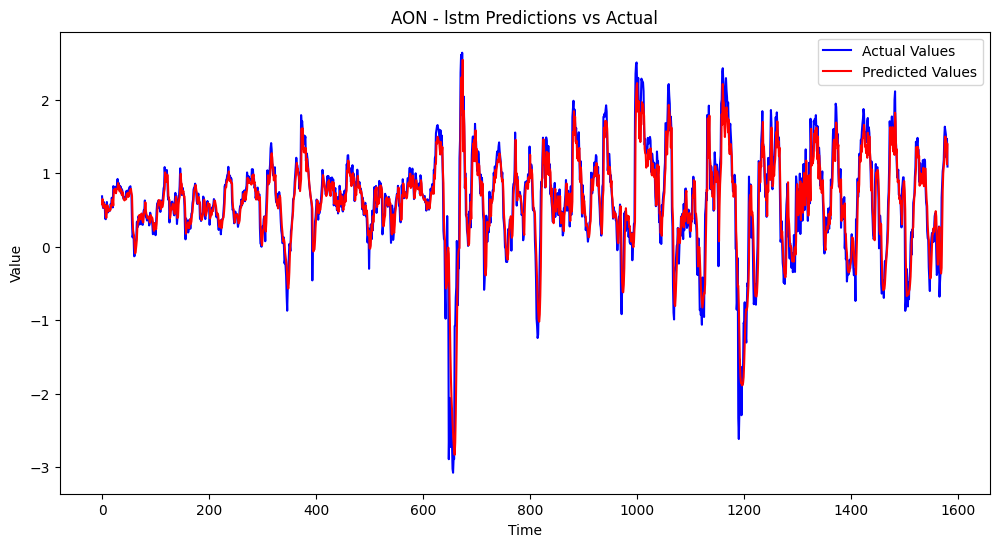

50/50 [==============================] - 2s 6ms/step
AON - gru - RMSE: 0.27457, MAE: 0.18023


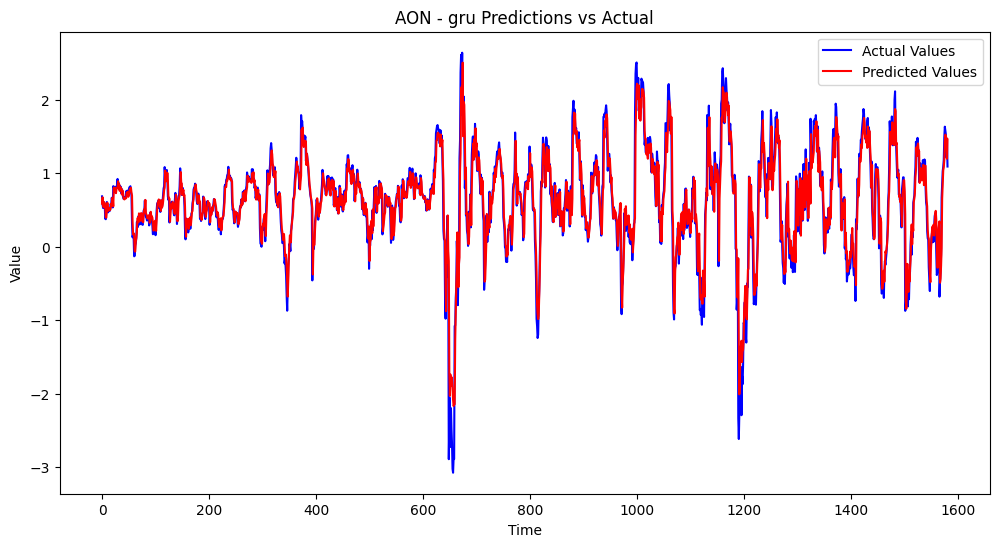

32/32 [==============================] - 1s 5ms/step
POOL - lstm - RMSE: 1.05176, MAE: 0.77041


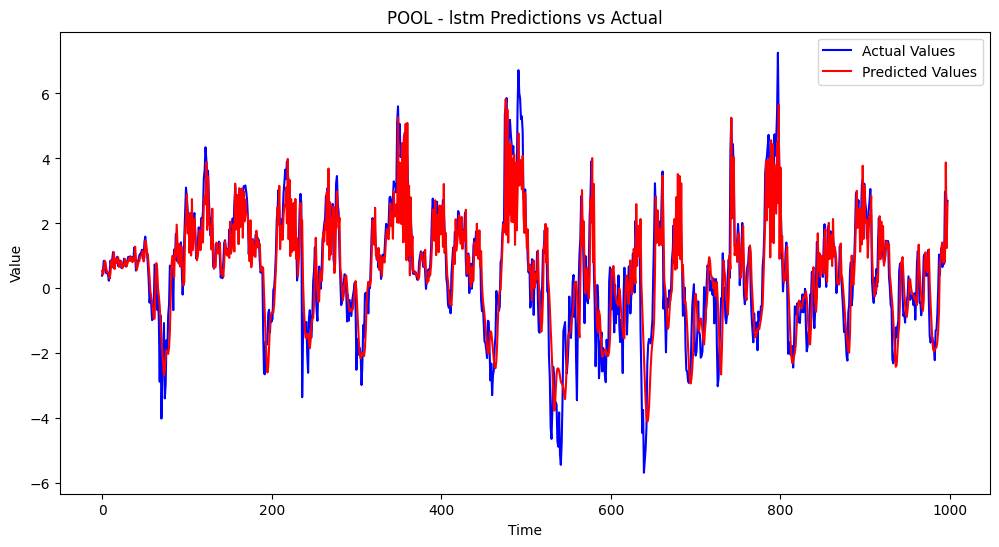

32/32 [==============================] - 1s 5ms/step
POOL - gru - RMSE: 0.86383, MAE: 0.63358


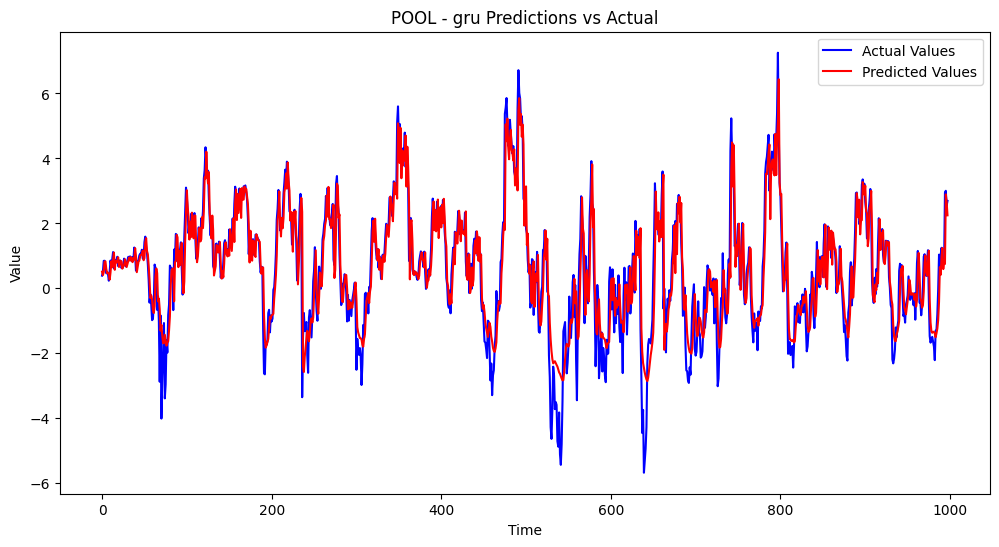

10/10 [==============================] - 1s 5ms/step
VYGVQ - lstm - RMSE: 0.00268, MAE: 0.00230


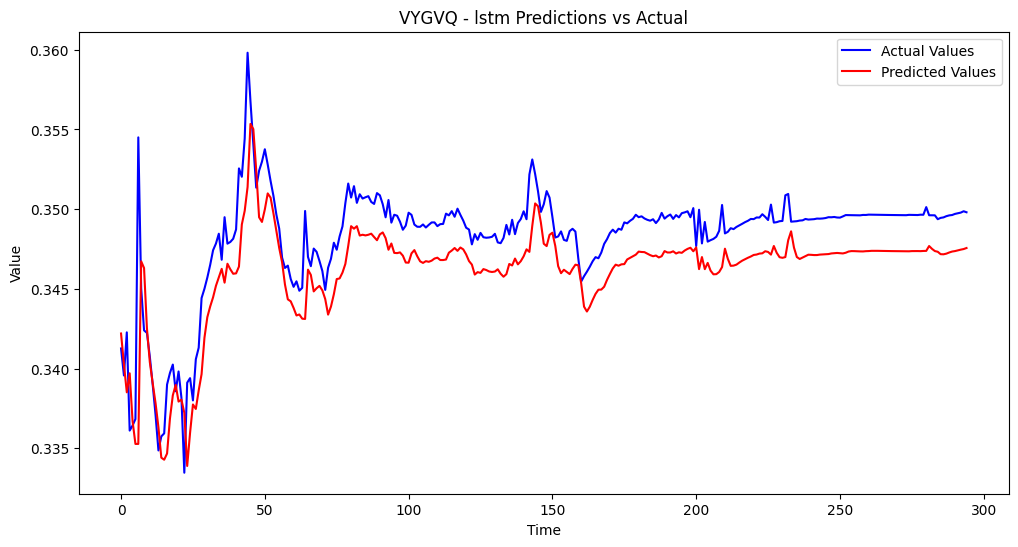

10/10 [==============================] - 1s 5ms/step
VYGVQ - gru - RMSE: 0.00845, MAE: 0.00831


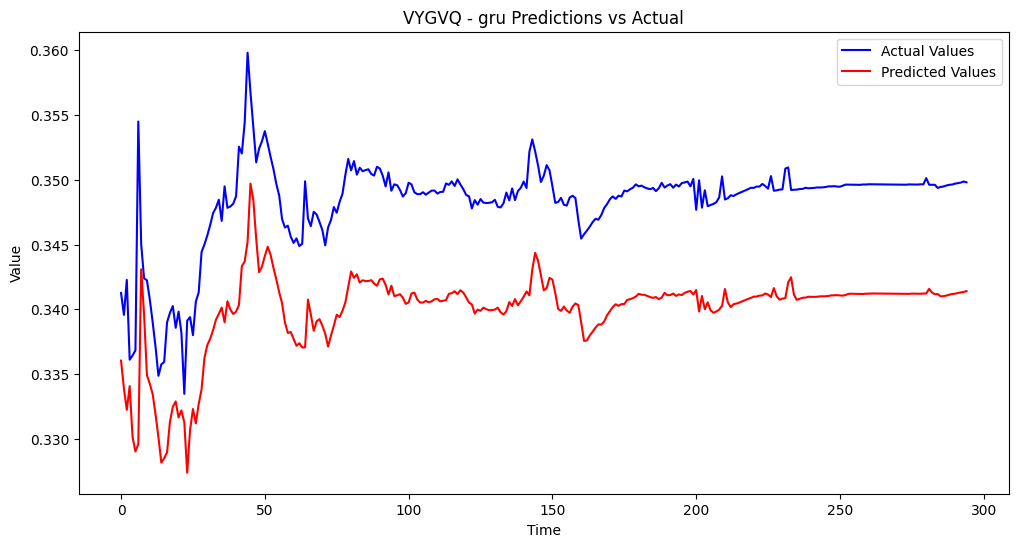

In [15]:
# Function to calculate RMSE
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Function to plot predictions vs actual values
def plot_predictions(actual, predicted, symbol, model_type):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Values', color='blue')
    plt.plot(predicted, label='Predicted Values', color='red')
    plt.title(f'{symbol} - {model_type} Predictions vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Evaluate and visualize for each model and stock
for (symbol, model_type), model in final_models.items():
    # Prepare the test data
    test_sequences, test_labels = test_data[symbol]

    # Generate predictions
    predicted = model.predict(test_sequences).flatten()
    actual = test_labels.flatten()

    # Calculate RMSE and MAE
    rmse = calculate_rmse(actual, predicted)
    mae = mean_absolute_error(actual, predicted)

    # Print out the metrics
    print(f"{symbol} - {model_type} - RMSE: {rmse:.5f}, MAE: {mae:.5f}")

    # Visualize predictions vs actual
    plot_predictions(actual, predicted, symbol, model_type)


## Normalization

Epoch 1/50
238/238 [==============================] - 15s 33ms/step - loss: 0.0972 - val_loss: 0.3461
Epoch 2/50
238/238 [==============================] - 8s 32ms/step - loss: 0.0078 - val_loss: 0.3506
Epoch 3/50
238/238 [==============================] - 7s 29ms/step - loss: 0.0033 - val_loss: 0.3863
Epoch 4/50
238/238 [==============================] - 7s 31ms/step - loss: 0.0023 - val_loss: 0.4036
Epoch 1/50
238/238 [==============================] - 10s 28ms/step - loss: 0.0214 - val_loss: 0.2571
Epoch 2/50
238/238 [==============================] - 14s 60ms/step - loss: 0.0012 - val_loss: 0.2298
Epoch 3/50
238/238 [==============================] - 15s 65ms/step - loss: 0.0011 - val_loss: 0.2131
Epoch 4/50
238/238 [==============================] - 14s 57ms/step - loss: 0.0011 - val_loss: 0.2013
Epoch 5/50
238/238 [==============================] - 12s 51ms/step - loss: 0.0010 - val_loss: 0.1874
Epoch 6/50
238/238 [==============================] - 11s 47ms/step - loss: 0.0011 - 

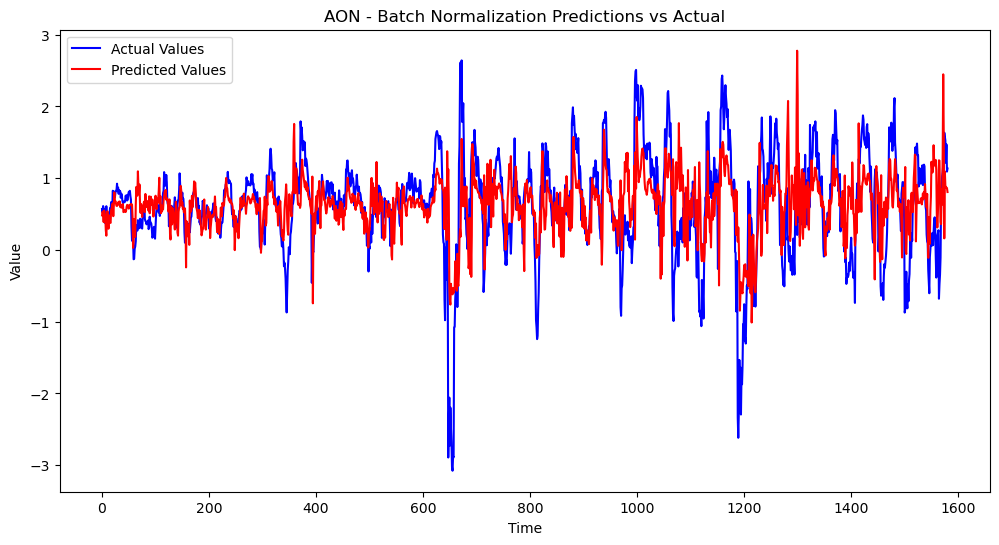

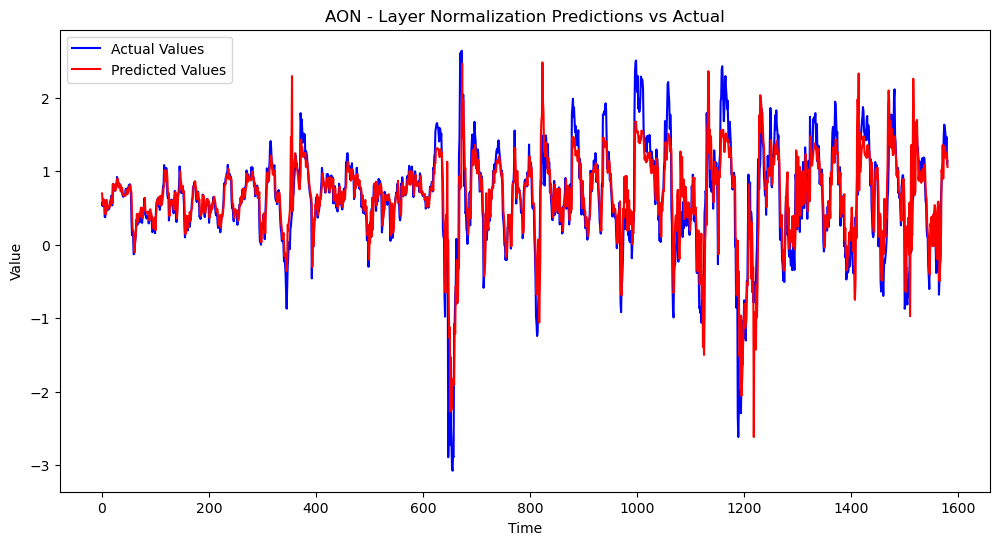

Epoch 1/50
153/153 [==============================] - 15s 61ms/step - loss: 0.1526 - val_loss: 3.4130
Epoch 2/50
153/153 [==============================] - 8s 55ms/step - loss: 0.0150 - val_loss: 4.3202
Epoch 3/50
153/153 [==============================] - 31s 201ms/step - loss: 0.0076 - val_loss: 4.1788
Epoch 4/50
153/153 [==============================] - 6s 39ms/step - loss: 0.0051 - val_loss: 3.7763
Epoch 1/50
153/153 [==============================] - 12s 57ms/step - loss: 0.0164 - val_loss: 1.7062
Epoch 2/50
153/153 [==============================] - 11s 69ms/step - loss: 0.0020 - val_loss: 1.5775
Epoch 3/50
153/153 [==============================] - 8s 53ms/step - loss: 0.0021 - val_loss: 1.5572
Epoch 4/50
153/153 [==============================] - 9s 57ms/step - loss: 0.0020 - val_loss: 1.5079
Epoch 5/50
153/153 [==============================] - 7s 44ms/step - loss: 0.0021 - val_loss: 1.4676
Epoch 6/50
153/153 [==============================] - 9s 56ms/step - loss: 0.0020 - va

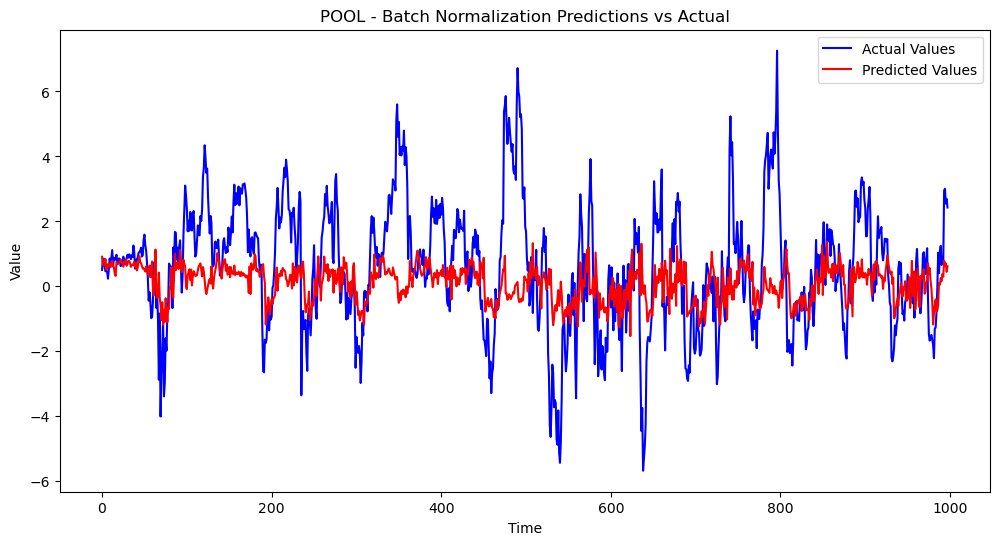

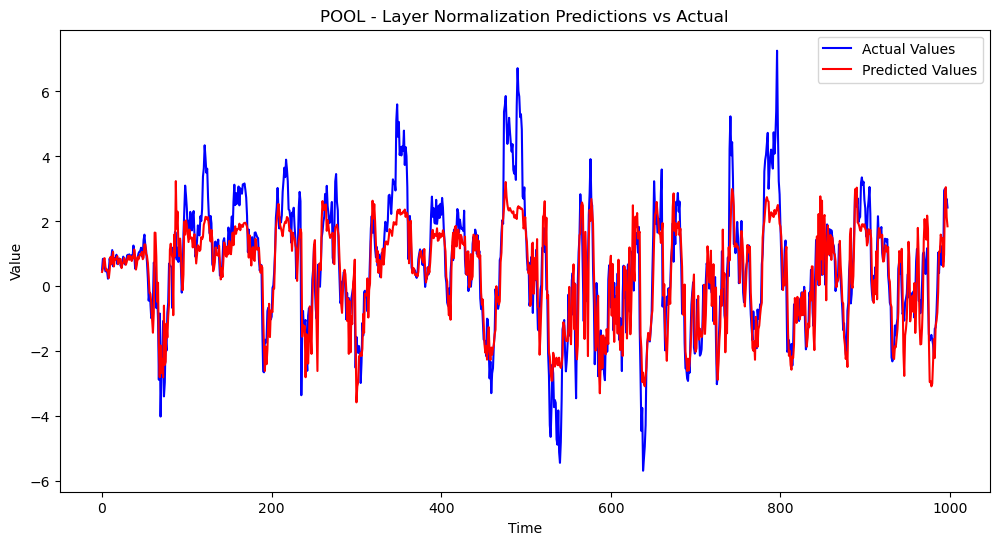

Epoch 1/50
50/50 [==============================] - 6s 48ms/step - loss: 0.6124 - val_loss: 0.2870
Epoch 2/50
50/50 [==============================] - 2s 40ms/step - loss: 0.0635 - val_loss: 0.0457
Epoch 3/50
50/50 [==============================] - 2s 39ms/step - loss: 0.0277 - val_loss: 0.2268
Epoch 4/50
50/50 [==============================] - 2s 40ms/step - loss: 0.0130 - val_loss: 0.2823
Epoch 5/50
50/50 [==============================] - 1s 29ms/step - loss: 0.0082 - val_loss: 0.1502
Epoch 1/50
50/50 [==============================] - 6s 53ms/step - loss: 0.0302 - val_loss: 9.5112e-06
Epoch 2/50
50/50 [==============================] - 2s 45ms/step - loss: 7.0262e-04 - val_loss: 1.6123e-04
Epoch 3/50
50/50 [==============================] - 2s 38ms/step - loss: 5.5696e-04 - val_loss: 3.8657e-06
Epoch 4/50
50/50 [==============================] - 2s 41ms/step - loss: 5.3817e-04 - val_loss: 3.2716e-05
Epoch 5/50
50/50 [==============================] - 2s 36ms/step - loss: 5.7531e-

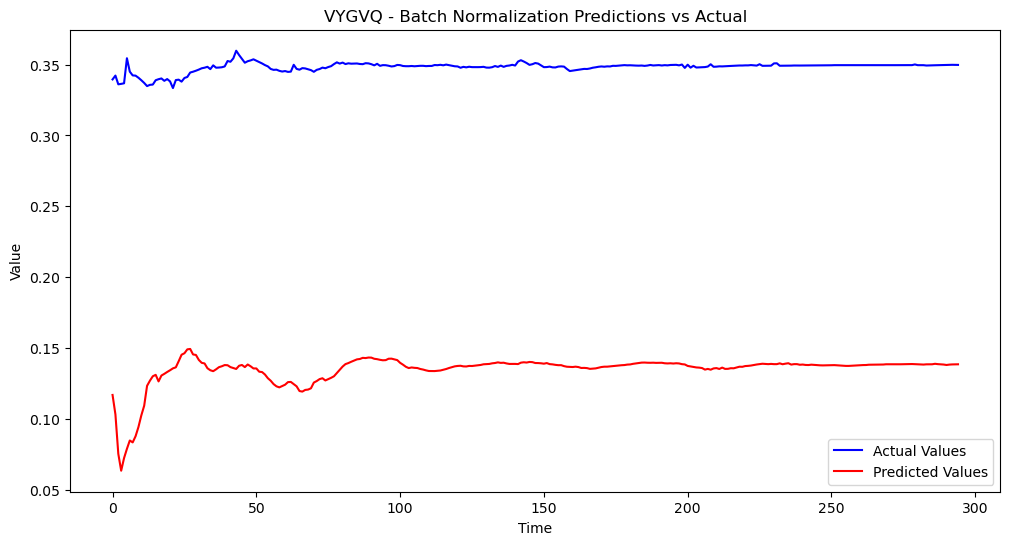

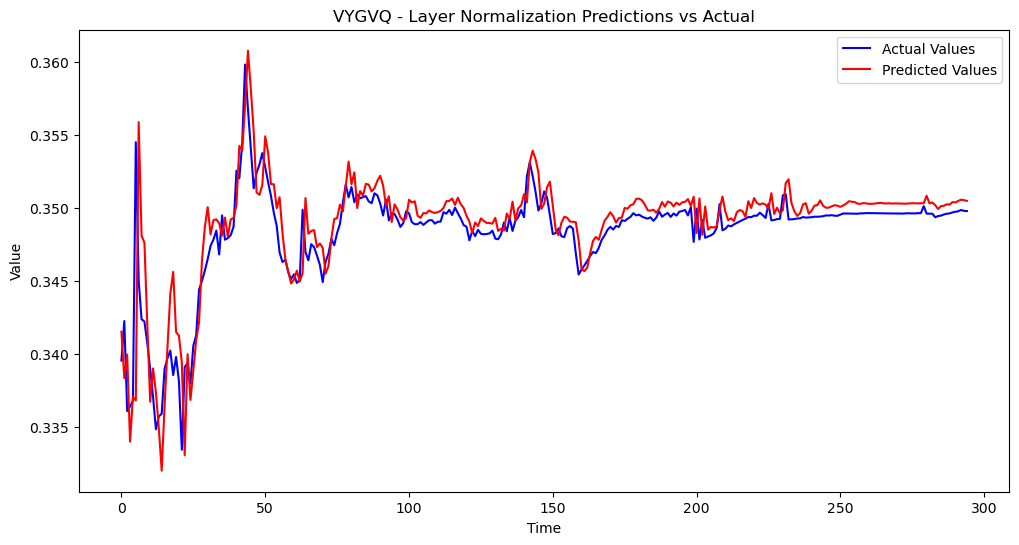

In [53]:
# Vanilla RNN Model with Normalization

def build_rnn_model_with_normalization(input_shape, units=50, normalization_type='batch'):
    model = Sequential()
    model.add(SimpleRNN(units, return_sequences=True, input_shape=input_shape))
    if normalization_type == 'batch':
        model.add(BatchNormalization())
    elif normalization_type == 'layer':
        model.add(LayerNormalization())
    model.add(SimpleRNN(units))
    if normalization_type == 'batch':
        model.add(BatchNormalization())
    elif normalization_type == 'layer':
        model.add(LayerNormalization())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def plot_predictions(actual, predicted, symbol, model_type):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Values', color='blue')
    plt.plot(predicted, label='Predicted Values', color='red')
    plt.title(f'{symbol} - {model_type} Predictions vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

number_of_features = 1

for symbol in ['AON', 'POOL', 'VYGVQ']:
    input_shape = (sequence_length, number_of_features)

    # Create models with batch normalization and layer normalization
    model_batch = build_rnn_model_with_normalization(input_shape, normalization_type='batch')
    model_layer = build_rnn_model_with_normalization(input_shape, normalization_type='layer')

    # Get your training and test data 
    train_sequences, train_labels = train_data[symbol]
    test_sequences, test_labels = test_data[symbol]

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the models
    model_batch.fit(train_sequences, train_labels, epochs=50, batch_size=32, validation_data=(test_sequences, test_labels), callbacks=[early_stopping])
    model_layer.fit(train_sequences, train_labels, epochs=50, batch_size=32, validation_data=(test_sequences, test_labels), callbacks=[early_stopping])

    # Predictions
    predicted_batch = model_batch.predict(test_sequences).flatten()
    predicted_layer = model_layer.predict(test_sequences).flatten()
    actual = test_labels.flatten()

    # Calculate RMSE and MAE
    rmse_batch = calculate_rmse(actual, predicted_batch)
    mae_batch = mean_absolute_error(actual, predicted_batch)

    rmse_layer = calculate_rmse(actual, predicted_layer)
    mae_layer = mean_absolute_error(actual, predicted_layer)

    # Print metrics
    print(f'{symbol} - Batch Normalization - RMSE: {rmse_batch:.5f}, MAE: {mae_batch:.5f}')
    print(f'{symbol} - Layer Normalization - RMSE: {rmse_layer:.5f}, MAE: {mae_layer:.5f}')

    # Plot predictions
    plot_predictions(actual, predicted_batch, symbol, 'Batch Normalization')
    plot_predictions(actual, predicted_layer, symbol, 'Layer Normalization')


## Normalization + Regularization

Epoch 1/50
238/238 [==============================] - 12s 34ms/step - loss: 2.6748 - val_loss: 2.2912
Epoch 2/50
238/238 [==============================] - 9s 36ms/step - loss: 0.7620 - val_loss: 30.7754
Epoch 3/50
238/238 [==============================] - 8s 35ms/step - loss: 0.2015 - val_loss: 3.1316
Epoch 4/50
238/238 [==============================] - 7s 31ms/step - loss: 0.0751 - val_loss: 4.7540
Epoch 1/50
238/238 [==============================] - 12s 39ms/step - loss: 2.4620 - val_loss: 1.7578
Epoch 2/50
238/238 [==============================] - 8s 35ms/step - loss: 0.9018 - val_loss: 0.7658
Epoch 3/50
238/238 [==============================] - 8s 33ms/step - loss: 0.3751 - val_loss: 0.4548
Epoch 4/50
238/238 [==============================] - 8s 33ms/step - loss: 0.1729 - val_loss: 0.3810
Epoch 5/50
238/238 [==============================] - 8s 34ms/step - loss: 0.0934 - val_loss: 0.3660
Epoch 6/50
238/238 [==============================] - 8s 33ms/step - loss: 0.0570 - val_

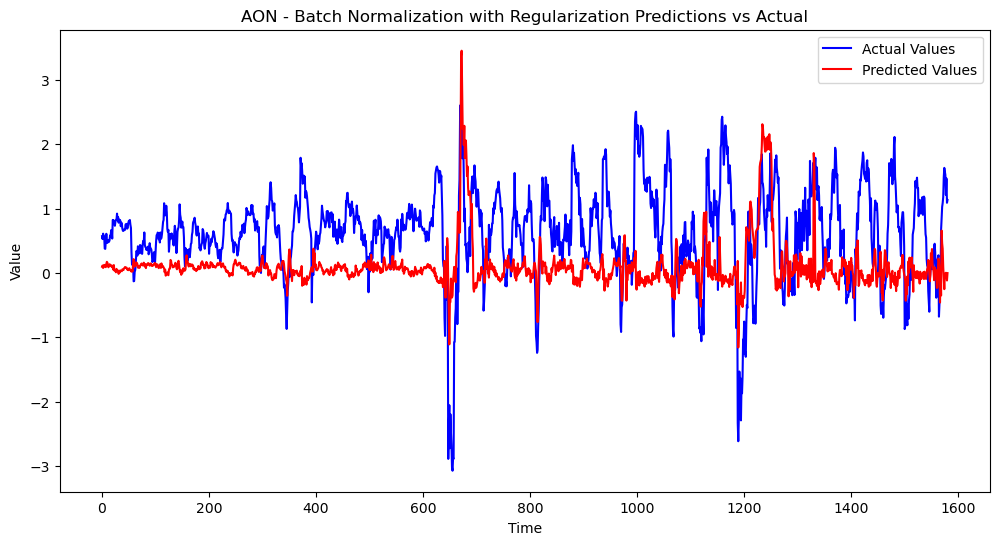

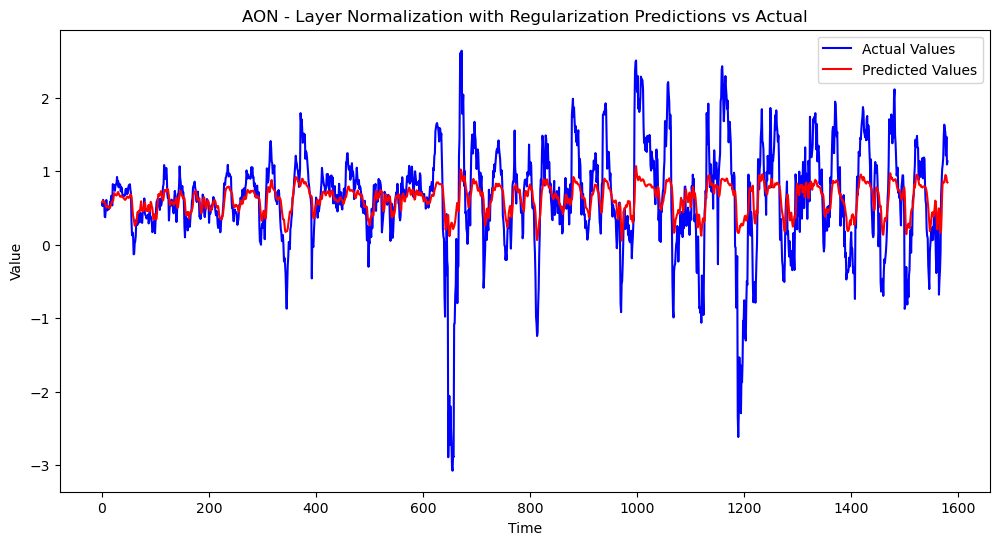

Epoch 1/50
153/153 [==============================] - 9s 36ms/step - loss: 3.1194 - val_loss: 4.6277
Epoch 2/50
153/153 [==============================] - 5s 34ms/step - loss: 1.4017 - val_loss: 3.3772
Epoch 3/50
153/153 [==============================] - 5s 34ms/step - loss: 0.4413 - val_loss: 2.9840
Epoch 4/50
153/153 [==============================] - 5s 34ms/step - loss: 0.1554 - val_loss: 2.7720
Epoch 5/50
153/153 [==============================] - 5s 30ms/step - loss: 0.2817 - val_loss: 7.7874
Epoch 6/50
153/153 [==============================] - 5s 32ms/step - loss: 0.1279 - val_loss: 6.1116
Epoch 7/50
153/153 [==============================] - 5s 33ms/step - loss: 0.0560 - val_loss: 6.8564
Epoch 1/50
153/153 [==============================] - 9s 36ms/step - loss: 2.8148 - val_loss: 5.0675
Epoch 2/50
153/153 [==============================] - 11s 75ms/step - loss: 1.3018 - val_loss: 3.6888
Epoch 3/50
153/153 [==============================] - 12s 81ms/step - loss: 0.5882 - val_l

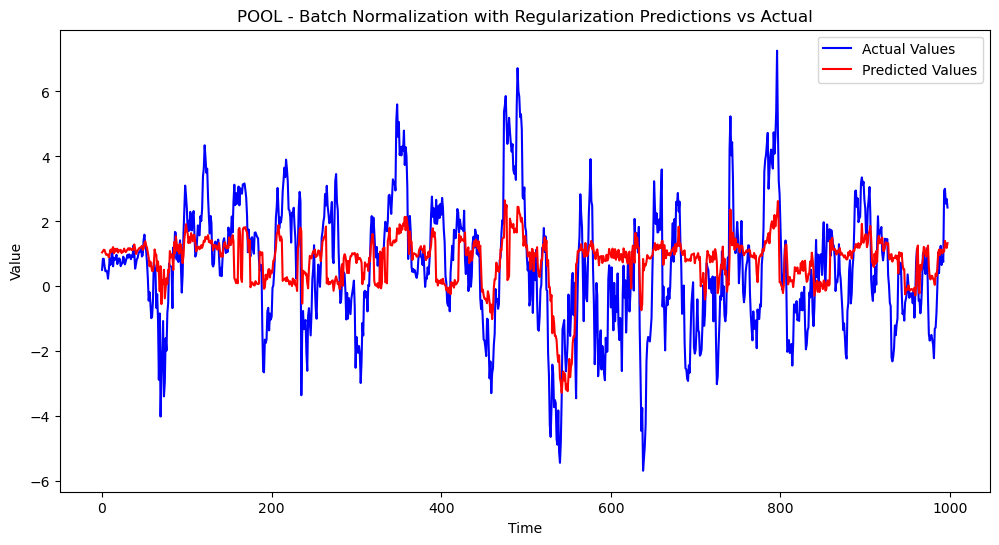

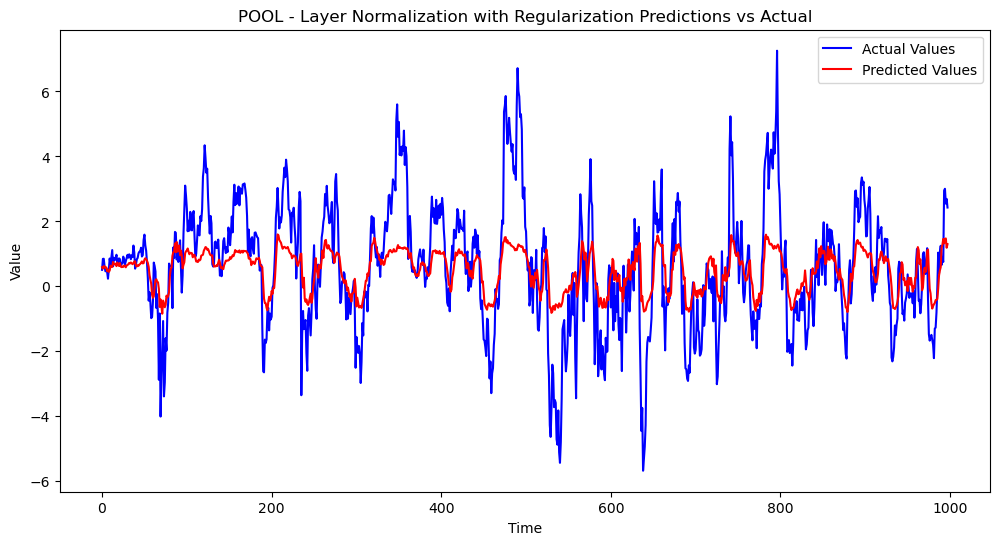

Epoch 1/50
50/50 [==============================] - 11s 95ms/step - loss: 4.0481 - val_loss: 3.5167
Epoch 2/50
50/50 [==============================] - 4s 74ms/step - loss: 3.4489 - val_loss: 3.4831
Epoch 3/50
50/50 [==============================] - 4s 77ms/step - loss: 3.2322 - val_loss: 3.0854
Epoch 4/50
50/50 [==============================] - 4s 73ms/step - loss: 2.9673 - val_loss: 2.8337
Epoch 5/50
50/50 [==============================] - 4s 72ms/step - loss: 2.7095 - val_loss: 2.5946
Epoch 6/50
50/50 [==============================] - 4s 72ms/step - loss: 2.4375 - val_loss: 2.3780
Epoch 7/50
50/50 [==============================] - 4s 78ms/step - loss: 2.1644 - val_loss: 2.0637
Epoch 8/50
50/50 [==============================] - 2s 50ms/step - loss: 1.8975 - val_loss: 1.8520
Epoch 9/50
50/50 [==============================] - 2s 40ms/step - loss: 1.6400 - val_loss: 1.6068
Epoch 10/50
50/50 [==============================] - 3s 68ms/step - loss: 1.3984 - val_loss: 1.6421
Epoch 11

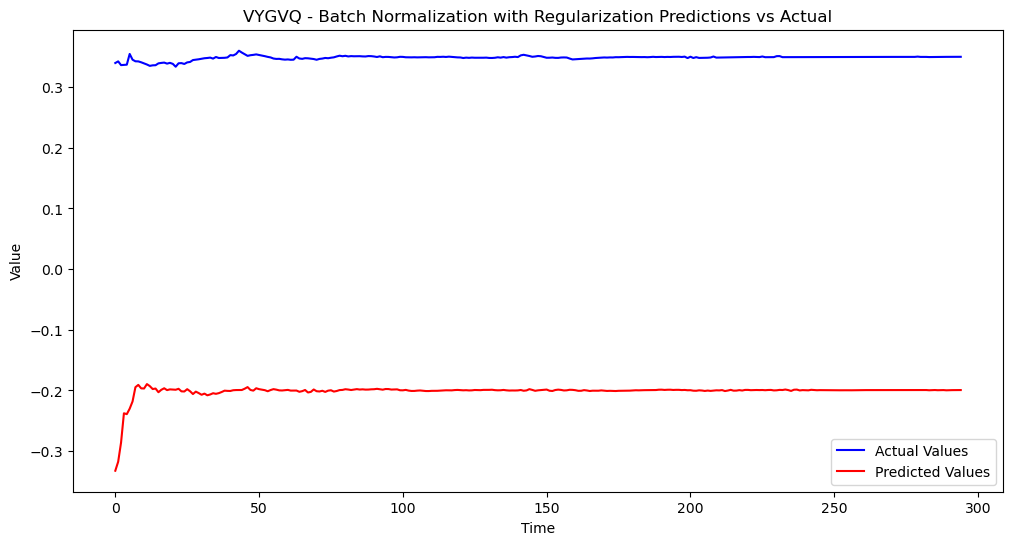

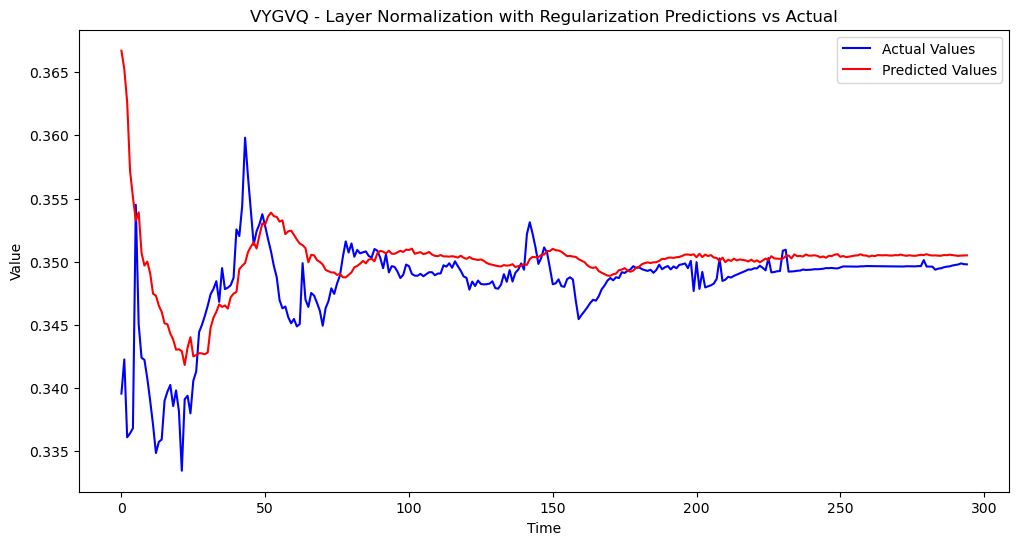

In [54]:
# Adding Regularization to Normalization

def build_rnn_model_with_regularization(input_shape, units=50, normalization_type='batch', l1_ratio=0.01, l2_ratio=0.01):
    model = Sequential()
    reg = l1_l2(l1=l1_ratio, l2=l2_ratio)
    model.add(SimpleRNN(units, return_sequences=True, input_shape=input_shape, kernel_regularizer=reg))
    if normalization_type == 'batch':
        model.add(BatchNormalization())
    elif normalization_type == 'layer':
        model.add(LayerNormalization())
    model.add(SimpleRNN(units, kernel_regularizer=reg))
    if normalization_type == 'batch':
        model.add(BatchNormalization())
    elif normalization_type == 'layer':
        model.add(LayerNormalization())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def plot_predictions(actual, predicted, symbol, model_type):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Values', color='blue')
    plt.plot(predicted, label='Predicted Values', color='red')
    plt.title(f'{symbol} - {model_type} Predictions vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

number_of_features = 1

for symbol in ['AON', 'POOL', 'VYGVQ']:
    input_shape = (sequence_length, number_of_features)

    # Create models with different normalization and regularization configurations
    model_batch_reg = build_rnn_model_with_regularization(input_shape, normalization_type='batch')
    model_layer_reg = build_rnn_model_with_regularization(input_shape, normalization_type='layer')

    # Get your training and test data
    train_sequences, train_labels = train_data[symbol]
    test_sequences, test_labels = test_data[symbol]

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the models
    model_batch_reg.fit(train_sequences, train_labels, epochs=50, batch_size=32, validation_data=(test_sequences, test_labels), callbacks=[early_stopping])
    model_layer_reg.fit(train_sequences, train_labels, epochs=50, batch_size=32, validation_data=(test_sequences, test_labels), callbacks=[early_stopping])

    # Predictions
    predicted_batch_reg = model_batch_reg.predict(test_sequences).flatten()
    predicted_layer_reg = model_layer_reg.predict(test_sequences).flatten()
    actual = test_labels.flatten()

    # Calculate RMSE and MAE
    rmse_batch_reg = calculate_rmse(actual, predicted_batch_reg)
    mae_batch_reg = mean_absolute_error(actual, predicted_batch_reg)

    rmse_layer_reg = calculate_rmse(actual, predicted_layer_reg)
    mae_layer_reg = mean_absolute_error(actual, predicted_layer_reg)

    # Print metrics
    print(f'{symbol} - Batch Normalization with Regularization - RMSE: {rmse_batch_reg:.5f}, MAE: {mae_batch_reg:.5f}')
    print(f'{symbol} - Layer Normalization with Regularization - RMSE: {rmse_layer_reg:.5f}, MAE: {mae_layer_reg:.5f}')

    # Plot predictions
    plot_predictions(actual, predicted_batch_reg, symbol, 'Batch Normalization with Regularization')
    plot_predictions(actual, predicted_layer_reg, symbol, 'Layer Normalization with Regularization')


# Appendex

When residual is computed as the difference in closing prices between consecutive days

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

for symbol, df in stock_data.items():
    # Calculate the difference between today's and yesterday's closing prices
    df['Residual'] = df['Close'].diff()

    # Calculate the percentage change (daily return)
    df['Daily_Return'] = df['Close'].pct_change() * 100

    # Drop NaN values
    df.dropna(subset=['Residual', 'Daily_Return'], inplace=True)

    # Print the first few rows of the modified DataFrame
    print(f"Initial rows of data for {symbol} after processing:")
    print(df[['Close', 'Residual', 'Daily_Return']].head())

Initial rows of data for AON after processing:
                              Close  Residual  Daily_Return
Date                                                       
1980-06-03 00:00:00-04:00  1.110831  0.015114      1.379389
1980-06-04 00:00:00-04:00  1.110831  0.000000      0.000000
1980-06-05 00:00:00-04:00  1.118387  0.007556      0.680208
1980-06-06 00:00:00-04:00  1.103273 -0.015113     -1.351353
1980-06-09 00:00:00-04:00  1.110831  0.007557      0.684997
Initial rows of data for POOL after processing:
                              Close  Residual  Daily_Return
Date                                                       
1995-10-16 00:00:00-04:00  0.699323  0.008227      1.190462
1995-10-17 00:00:00-04:00  0.691096 -0.008227     -1.176456
1995-10-18 00:00:00-04:00  0.658186 -0.032909     -4.761915
1995-10-19 00:00:00-04:00  0.666414  0.008227      1.249994
1995-10-20 00:00:00-04:00  0.691096  0.024682      3.703721
Initial rows of data for VYGVQ after processing:
                

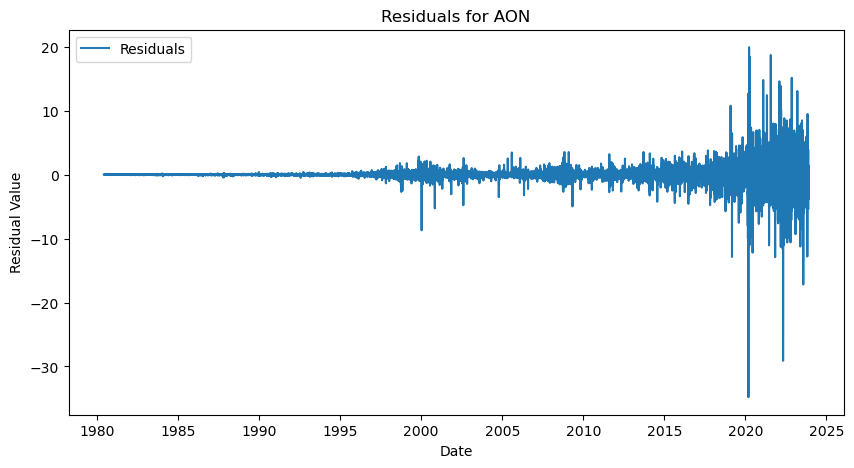

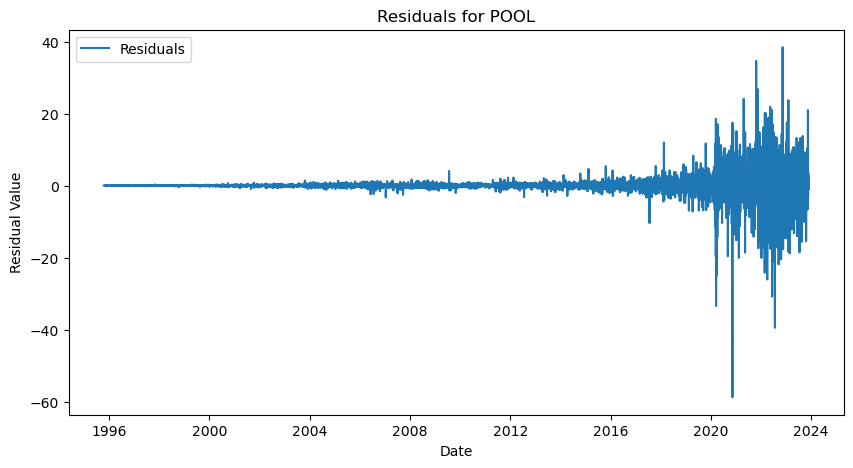

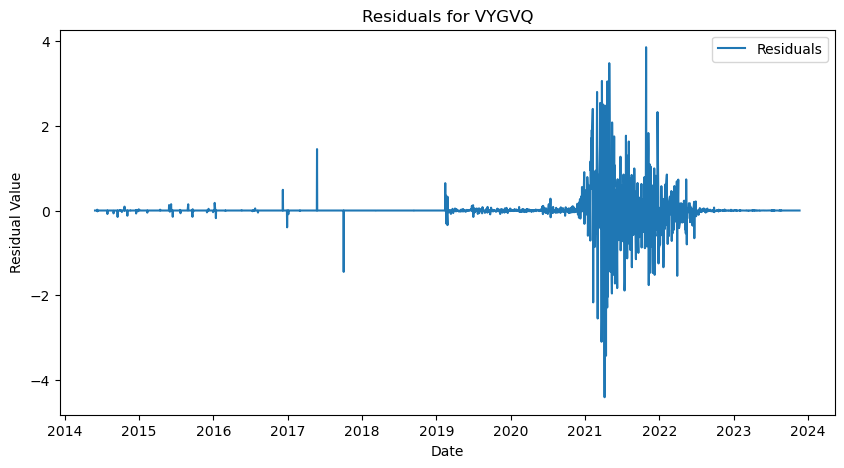

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

for symbol, df in stock_data.items():
    # Plotting the residuals
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df['Residual'], label='Residuals')
    plt.title(f'Residuals for {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Residual Value')
    plt.legend()
    plt.show()

In [7]:
split_data = {}

for symbol, df in stock_data.items():
    # Calculate split indices (15% for test and validation each, rest for training)
    total_length = len(df)
    test_val_size = int(0.15 * total_length)
    train_size = total_length - 2 * test_val_size

    # Split the data chronologically
    train_df = df.iloc[:train_size]
    val_df = df.iloc[train_size:train_size + test_val_size]
    test_df = df.iloc[train_size + test_val_size:]

    # Store the split data
    split_data[symbol] = {'train': train_df, 'validation': val_df, 'test': test_df}

In [8]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(0, 1))
sequence_length = 60
train_data = {}
validation_data = {}
test_data = {}

for symbol in split_data:
    # Make deep copies for train, validation, and test sets
    train_df = split_data[symbol]['train'].copy()
    val_df = split_data[symbol]['validation'].copy()
    test_df = split_data[symbol]['test'].copy()

    # Normalize the 'Residual' column for each dataset
    train_df['Normalized_Residual'] = scaler.fit_transform(train_df['Residual'].values.reshape(-1, 1))
    val_df['Normalized_Residual'] = scaler.transform(val_df['Residual'].values.reshape(-1, 1))
    test_df['Normalized_Residual'] = scaler.transform(test_df['Residual'].values.reshape(-1, 1))

    # Update the split_data dictionary with the normalized data
    split_data[symbol] = {'train': train_df, 'validation': val_df, 'test': test_df}

    # Create sequences and labels for each set
    for key in split_data[symbol]:
        sequences = []
        labels = []
        df = split_data[symbol][key]
        for i in range(len(df) - sequence_length):
            sequence = df['Normalized_Residual'].iloc[i:i + sequence_length].values
            label = df['Normalized_Residual'].iloc[i + sequence_length]
            sequences.append(sequence)
            labels.append(label)
        sequences = np.array(sequences)
        labels = np.array(labels)
        if key == 'train':
            train_data[symbol] = (sequences, labels)
        elif key == 'validation':
            validation_data[symbol] = (sequences, labels)
        elif key == 'test':
            test_data[symbol] = (sequences, labels)

In [14]:
import tensorflow as tf

# Common hyperparameters
batch_size = 32
epochs = 50
learning_rate = 0.001

# Preparing data for each symbol
data_per_symbol = {}

for symbol in ['AON', 'POOL', 'VYGVQ']:
    train_sequences, train_labels = train_data[symbol]
    val_sequences, val_labels = validation_data[symbol]
    test_sequences, test_labels = test_data[symbol]

    # Convert to TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_sequences, val_labels)).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_sequences, test_labels)).batch(batch_size)

    data_per_symbol[symbol] = (train_dataset, val_dataset, test_dataset)

In [15]:
models = {}
histories = {}

for symbol in ['AON', 'POOL', 'VYGVQ']:
    train_dataset, val_dataset, _ = data_per_symbol[symbol]

    # Vanilla RNN Model
    vanilla_rnn_model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(50, activation='tanh', input_shape=(sequence_length, 1)),
        tf.keras.layers.Dense(1)
    ])

    vanilla_rnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                              loss='mean_squared_error')

    history_vanilla_rnn = vanilla_rnn_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

    # LSTM Model
    lstm_model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, activation='tanh', input_shape=(sequence_length, 1)),
        tf.keras.layers.Dense(1)
    ])

    lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                       loss='mean_squared_error')

    history_lstm = lstm_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

    # GRU Model
    gru_model = tf.keras.Sequential([
        tf.keras.layers.GRU(50, activation='tanh', input_shape=(sequence_length, 1)),
        tf.keras.layers.Dense(1)
    ])

    gru_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='mean_squared_error')

    history_gru = gru_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

    # Store models and histories
    models[symbol] = {'vanilla_rnn': vanilla_rnn_model, 'lstm': lstm_model, 'gru': gru_model}
    histories[symbol] = {'vanilla_rnn': history_vanilla_rnn, 'lstm': history_lstm, 'gru': history_gru}


Epoch 1/50
238/238 [==============================] - 6s 17ms/step - loss: 0.0025 - val_loss: 0.0058
Epoch 2/50
238/238 [==============================] - 4s 15ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 3/50
238/238 [==============================] - 4s 17ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 4/50
238/238 [==============================] - 4s 16ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 5/50
238/238 [==============================] - 4s 16ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 6/50
238/238 [==============================] - 4s 17ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 7/50
238/238 [==============================] - 4s 16ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 8/50
238/238 [==============================] - 4s 18ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 9/50
238/238 [==============================] - 4s 18ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 10/50
238/238 [==============================] - 4s 18ms/step - loss: 0.0010 - val_lo

Epoch 8/50
153/153 [==============================] - 3s 20ms/step - loss: 0.0028 - val_loss: 0.0425
Epoch 9/50
153/153 [==============================] - 3s 18ms/step - loss: 0.0028 - val_loss: 0.0426
Epoch 10/50
153/153 [==============================] - 3s 18ms/step - loss: 0.0028 - val_loss: 0.0427
Epoch 11/50
153/153 [==============================] - 3s 17ms/step - loss: 0.0028 - val_loss: 0.0428
Epoch 12/50
153/153 [==============================] - 3s 17ms/step - loss: 0.0028 - val_loss: 0.0427
Epoch 13/50
153/153 [==============================] - 3s 21ms/step - loss: 0.0028 - val_loss: 0.0427
Epoch 14/50
153/153 [==============================] - 3s 20ms/step - loss: 0.0028 - val_loss: 0.0426
Epoch 15/50
153/153 [==============================] - 3s 17ms/step - loss: 0.0028 - val_loss: 0.0426
Epoch 16/50
153/153 [==============================] - 3s 18ms/step - loss: 0.0028 - val_loss: 0.0425
Epoch 17/50
153/153 [==============================] - 3s 18ms/step - loss: 0.0028 -

51/51 [==============================] - 1s 17ms/step - loss: 8.9206e-04 - val_loss: 0.0876
Epoch 19/50
51/51 [==============================] - 1s 17ms/step - loss: 8.9110e-04 - val_loss: 0.0874
Epoch 20/50
51/51 [==============================] - 1s 17ms/step - loss: 8.9055e-04 - val_loss: 0.0872
Epoch 21/50
51/51 [==============================] - 1s 14ms/step - loss: 8.9043e-04 - val_loss: 0.0870
Epoch 22/50
51/51 [==============================] - 1s 18ms/step - loss: 8.9079e-04 - val_loss: 0.0869
Epoch 23/50
51/51 [==============================] - 1s 15ms/step - loss: 8.9169e-04 - val_loss: 0.0867
Epoch 24/50
51/51 [==============================] - 1s 18ms/step - loss: 8.9318e-04 - val_loss: 0.0866
Epoch 25/50
51/51 [==============================] - 1s 16ms/step - loss: 8.9529e-04 - val_loss: 0.0865
Epoch 26/50
51/51 [==============================] - 1s 16ms/step - loss: 8.9791e-04 - val_loss: 0.0864
Epoch 27/50
51/51 [==============================] - 1s 18ms/step - loss: 9.

51/51 [==============================] - 2s 47ms/step - loss: 8.2972e-04 - val_loss: 0.0830
Epoch 48/50
51/51 [==============================] - 2s 48ms/step - loss: 8.2922e-04 - val_loss: 0.0830
Epoch 49/50
51/51 [==============================] - 2s 42ms/step - loss: 8.2872e-04 - val_loss: 0.0829
Epoch 50/50
51/51 [==============================] - 2s 39ms/step - loss: 8.2823e-04 - val_loss: 0.0829
Epoch 1/50
51/51 [==============================] - 8s 54ms/step - loss: 0.0327 - val_loss: 0.0824
Epoch 2/50
51/51 [==============================] - 2s 36ms/step - loss: 8.3478e-04 - val_loss: 0.0828
Epoch 3/50
51/51 [==============================] - 2s 42ms/step - loss: 7.8163e-04 - val_loss: 0.0826
Epoch 4/50
51/51 [==============================] - 2s 42ms/step - loss: 7.7890e-04 - val_loss: 0.0826
Epoch 5/50
51/51 [==============================] - 2s 35ms/step - loss: 7.8081e-04 - val_loss: 0.0826
Epoch 6/50
51/51 [==============================] - 2s 34ms/step - loss: 7.8308e-04 -

In [16]:
evaluation_results = {}

for symbol in ['AON', 'POOL', 'VYGVQ']:
    _, _, test_dataset = data_per_symbol[symbol]
    evaluation_results[symbol] = {}

    for model_type in ['vanilla_rnn', 'lstm', 'gru']:
        model = models[symbol][model_type]
        test_loss = model.evaluate(test_dataset)
        evaluation_results[symbol][model_type] = test_loss
        print(f"{symbol} - {model_type} Test Loss:", test_loss)

50/50 [==============================] - 0s 8ms/step - loss: 0.0843
AON - vanilla_rnn Test Loss: 0.08430850505828857
50/50 [==============================] - 1s 23ms/step - loss: 0.0824
AON - lstm Test Loss: 0.08235256373882294
50/50 [==============================] - 1s 19ms/step - loss: 0.0834
AON - gru Test Loss: 0.08336810767650604
32/32 [==============================] - 0s 11ms/step - loss: 1.0464
POOL - vanilla_rnn Test Loss: 1.046441912651062
32/32 [==============================] - 1s 29ms/step - loss: 1.0273
POOL - lstm Test Loss: 1.0273319482803345
32/32 [==============================] - 1s 19ms/step - loss: 1.0366
POOL - gru Test Loss: 1.0365979671478271
10/10 [==============================] - 0s 12ms/step - loss: 4.0900e-04
VYGVQ - vanilla_rnn Test Loss: 0.0004089950816705823
10/10 [==============================] - 0s 19ms/step - loss: 2.7417e-04
VYGVQ - lstm Test Loss: 0.0002741653297562152
10/10 [==============================] - 0s 16ms/step - loss: 2.7084e-04
VYGVQ 

In [21]:
import matplotlib.pyplot as plt

predictions = {}

for symbol in ['AON', 'POOL', 'VYGVQ']:
    predictions[symbol] = {}
    test_sequences, _ = test_data[symbol]
    _, _, test_dataset = data_per_symbol[symbol]

    for model_type in ['vanilla_rnn', 'lstm', 'gru']:
        model = models[symbol][model_type]
        # Generate predictions
        predicted_resid = model.predict(test_sequences)
        predictions[symbol][model_type] = predicted_resid.squeeze()  # remove extra dimensions

10/10 [==============================] - 0s 16ms/step


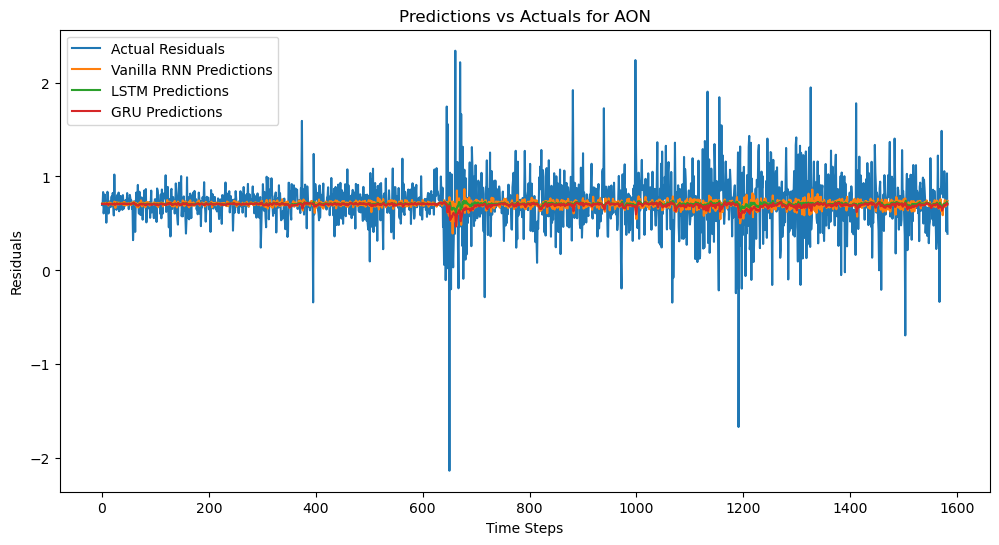

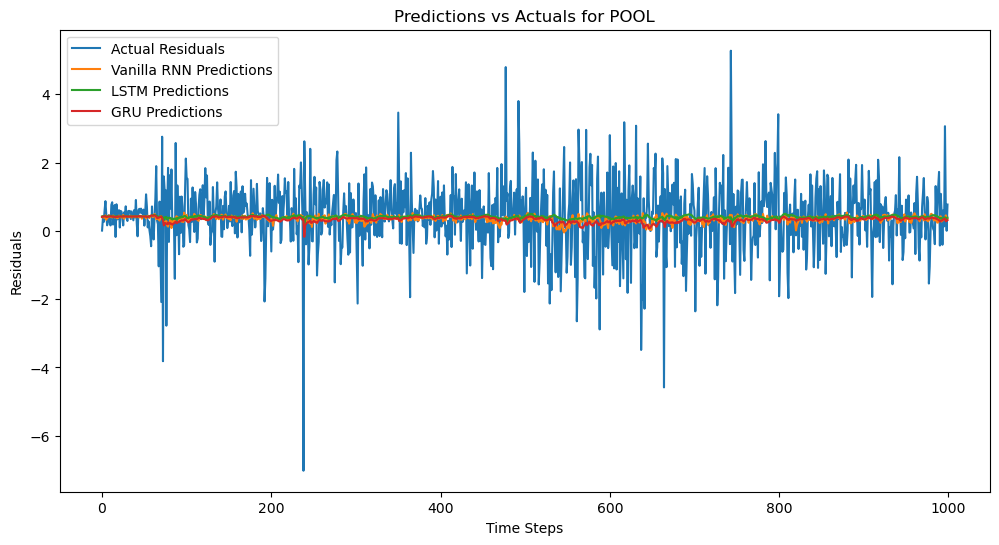

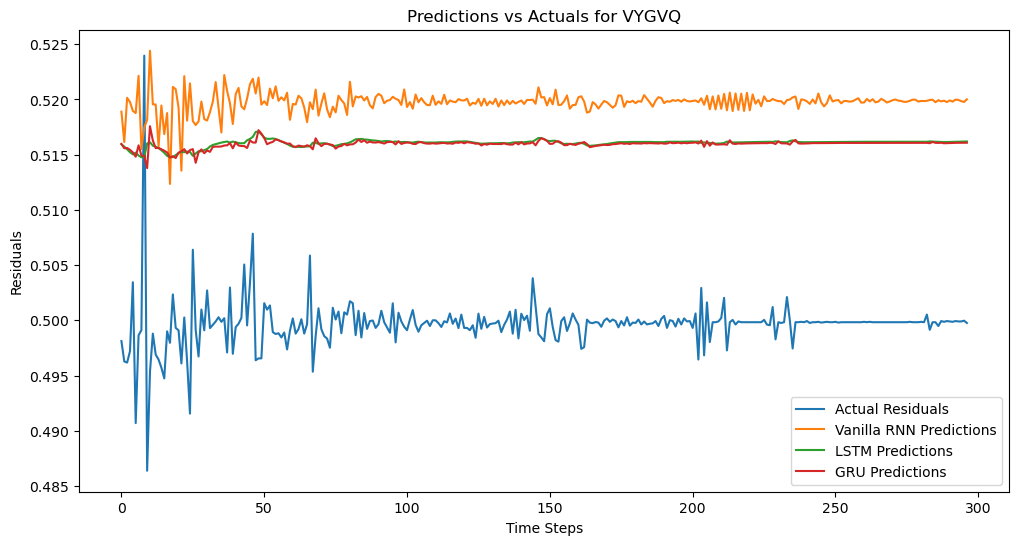

In [22]:
# Plotting function
def plot_predictions_vs_actuals(symbol, test_labels, predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(test_labels, label='Actual Residuals')
    plt.plot(predictions[symbol]['vanilla_rnn'], label='Vanilla RNN Predictions')
    plt.plot(predictions[symbol]['lstm'], label='LSTM Predictions')
    plt.plot(predictions[symbol]['gru'], label='GRU Predictions')
    plt.title(f"Predictions vs Actuals for {symbol}")
    plt.xlabel('Time Steps')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

# Plot for each symbol
for symbol in ['AON', 'POOL', 'VYGVQ']:
    _, test_labels = test_data[symbol]
    plot_predictions_vs_actuals(symbol, test_labels, predictions)


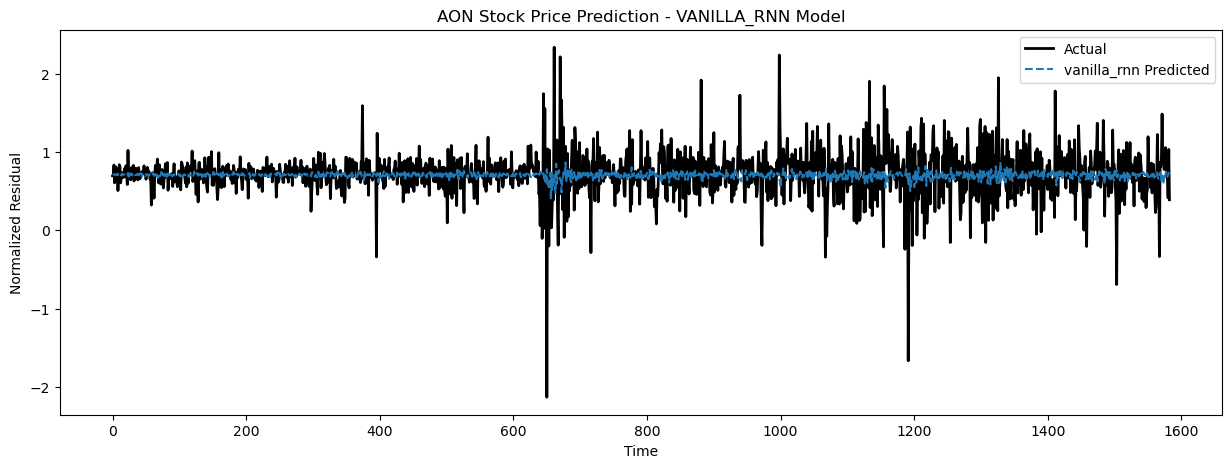

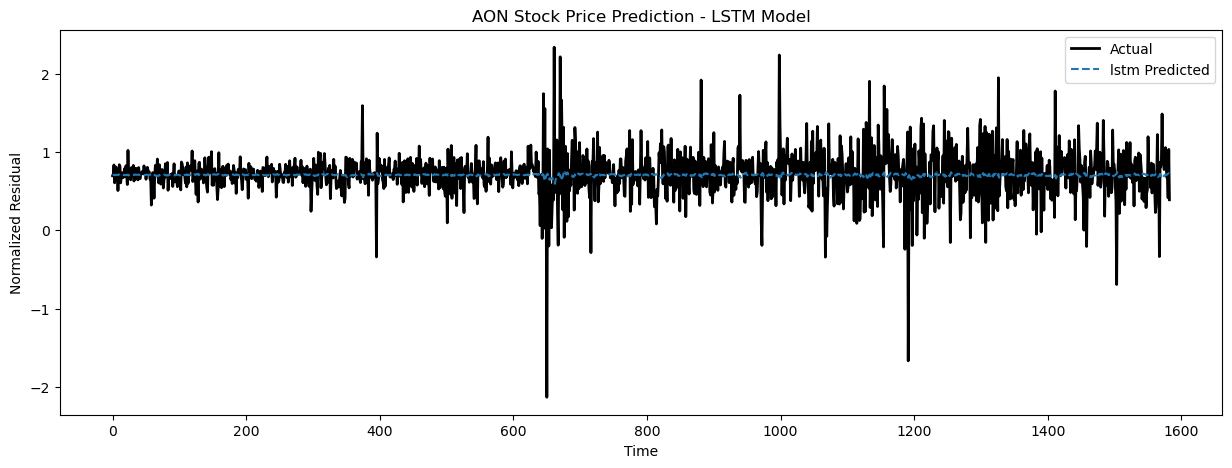

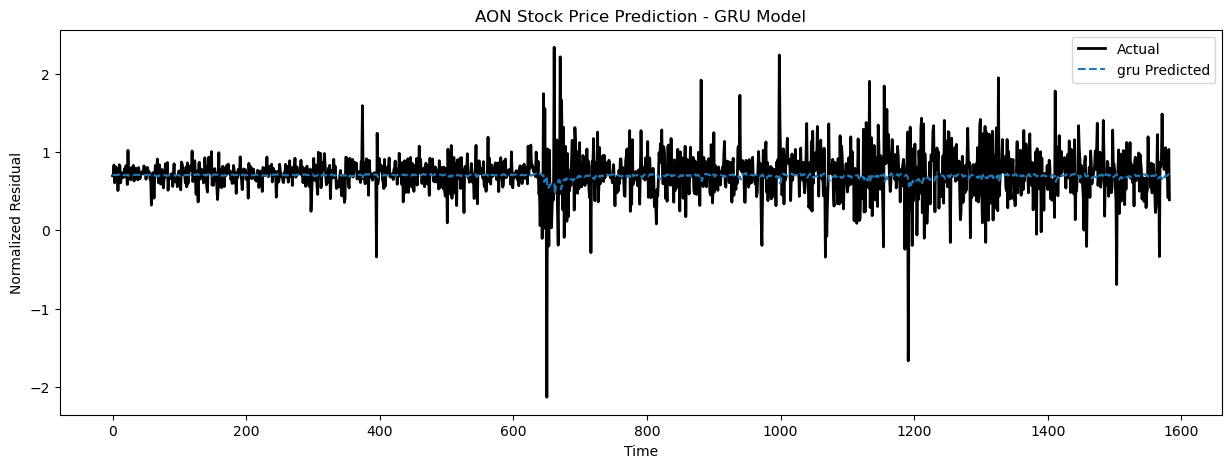

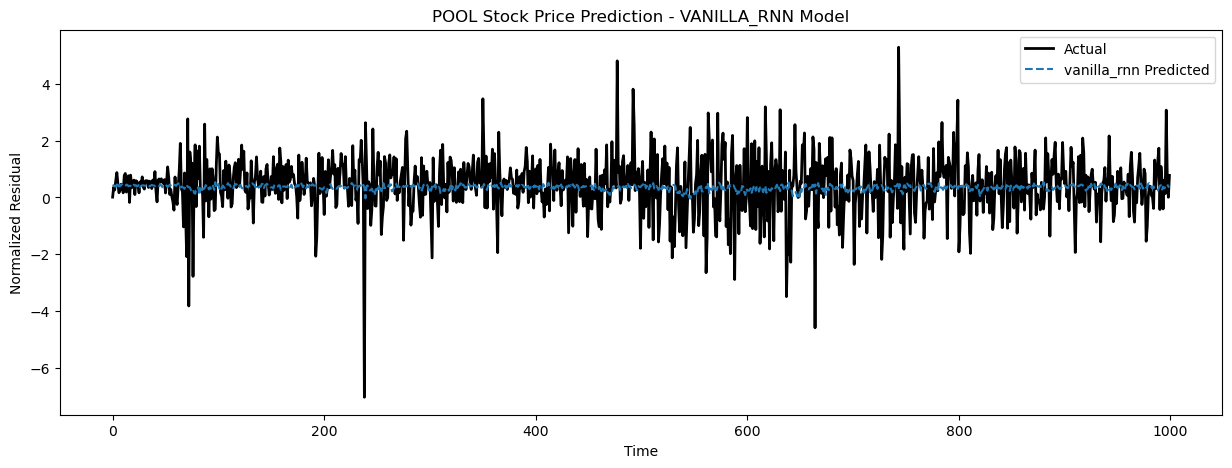

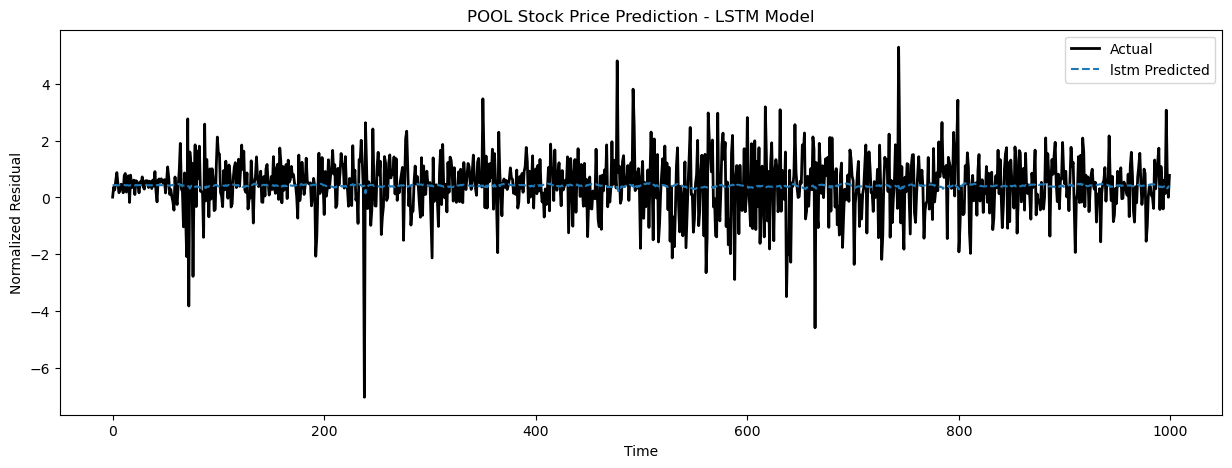

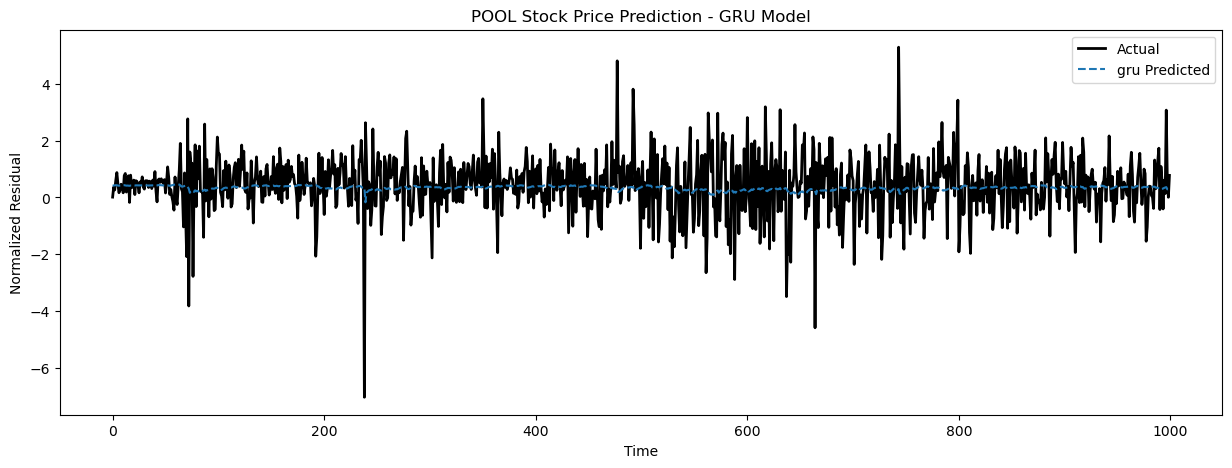

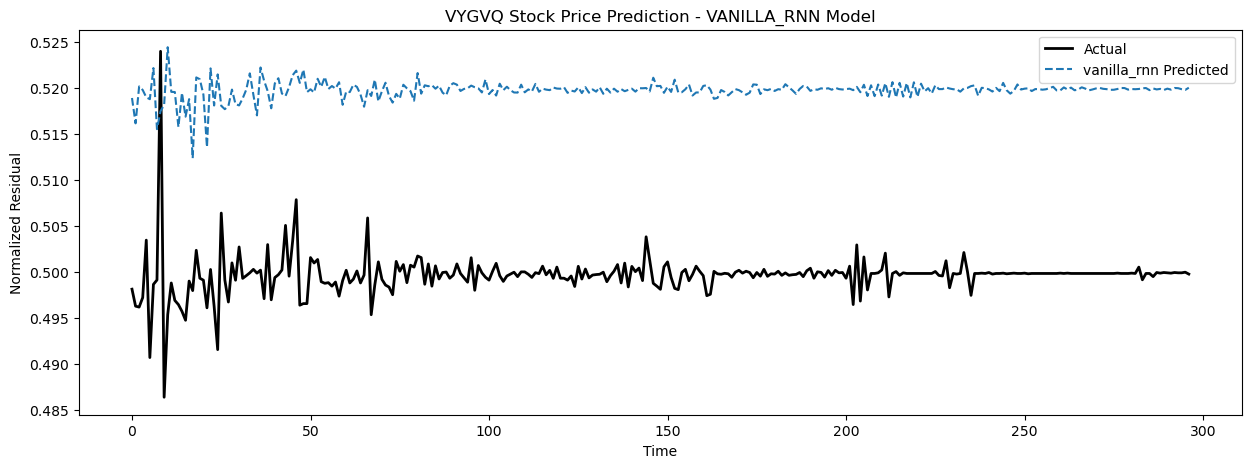

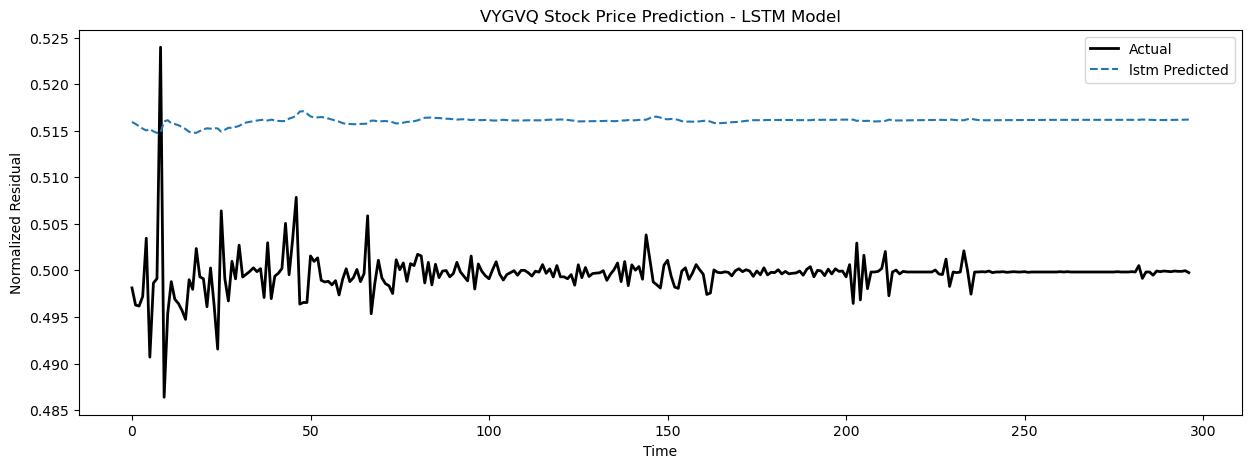

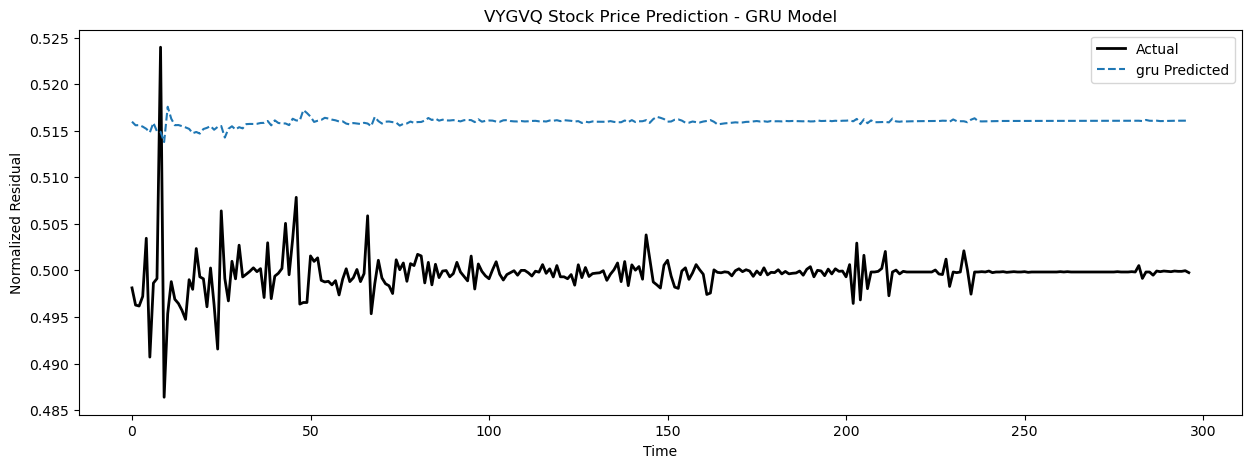

In [23]:
import matplotlib.pyplot as plt

for symbol in ['AON', 'POOL', 'VYGVQ']:
    for model_type in ['vanilla_rnn', 'lstm', 'gru']:
        plt.figure(figsize=(15, 5))
        plt.plot(actual_values[symbol], label='Actual', color='black', linewidth=2)
        plt.plot(predicted_values[symbol][model_type], label=model_type + ' Predicted', linestyle='--')

        plt.title(f'{symbol} Stock Price Prediction - {model_type.upper()} Model')
        plt.xlabel('Time')
        plt.ylabel('Normalized Residual')
        plt.legend()
        plt.show()


In [24]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import numpy as np


metrics_results = {}

for symbol in ['AON', 'POOL', 'VYGVQ']:
    metrics_results[symbol] = {}

    for model_type in ['vanilla_rnn', 'lstm', 'gru']:
        # Get the actual and predicted values
        actual = actual_values[symbol].flatten()
        predicted = predicted_values[symbol][model_type].flatten()

        # Calculate MAE
        mae = mean_absolute_error(actual, predicted)

        # Calculate MAPE
        mape = mean_absolute_percentage_error(actual, predicted)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(actual, predicted))

        # Store the metrics
        metrics_results[symbol][model_type] = {
            'MAE': mae,
            'MAPE': mape,
            'RMSE': rmse
        }

        # Print out the metrics
        print(f'{symbol} - {model_type} - MAE: {mae:.5f}, MAPE: {mape:.5f}, RMSE: {rmse:.5f}')

AON - vanilla_rnn - MAE: 0.19234, MAPE: 0.77721, RMSE: 0.29036
AON - lstm - MAE: 0.18997, MAPE: 0.76627, RMSE: 0.28697
AON - gru - MAE: 0.19128, MAPE: 0.75438, RMSE: 0.28874
POOL - vanilla_rnn - MAE: 0.74860, MAPE: 2.09544, RMSE: 1.02296
POOL - lstm - MAE: 0.73820, MAPE: 2.41367, RMSE: 1.01357
POOL - gru - MAE: 0.74488, MAPE: 2.04979, RMSE: 1.01813
VYGVQ - vanilla_rnn - MAE: 0.02012, MAPE: 0.04028, RMSE: 0.02022
VYGVQ - lstm - MAE: 0.01646, MAPE: 0.03295, RMSE: 0.01656
VYGVQ - gru - MAE: 0.01636, MAPE: 0.03276, RMSE: 0.01646


In [7]:
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.pruners import MedianPruner
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import optuna.visualization as ov

def build_model(trial, model_type, input_shape):
    # Hyperparameters to be optimized
    units = trial.suggest_categorical('units', [50, 100, 150])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Model building
    model = Sequential()
    if model_type == 'lstm':
        model.add(LSTM(units, input_shape=input_shape, return_sequences=True))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(units))
    elif model_type == 'gru':
        model.add(GRU(units, input_shape=input_shape, return_sequences=True))
        model.add(Dropout(dropout_rate))
        model.add(GRU(units))

    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    return model, batch_size

def objective(trial, model_type, symbol):
    K.clear_session()  # Clear the TensorFlow session before starting a new trial.

    # Get the appropriate dataset for the symbol
    train_sequences, train_labels = train_data[symbol]
    val_sequences, val_labels = validation_data[symbol]

    # Build the model
    model, batch_size = build_model(trial, model_type, input_shape=(sequence_length, 1))

    # Early stopping and ModelCheckpoint callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    checkpoint_filepath = f'tmp/checkpoint_{trial.number}'
    model_checkpoint = ModelCheckpoint(checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

    # Pruning callback
    pruning_callback = TFKerasPruningCallback(trial, 'val_loss')

    # Train the model
    model.fit(
        train_sequences,
        train_labels,
        epochs=50,
        batch_size=batch_size,
        validation_data=(val_sequences, val_labels),
        callbacks=[early_stopping, model_checkpoint, pruning_callback],
        verbose=1
    )

    # Load the best model weights before evaluating
    model.load_weights(checkpoint_filepath)

    # Evaluate the model on the validation set
    val_loss = model.evaluate(val_sequences, val_labels, verbose=0)
    return val_loss, model

# Define the number of trials
n_trials = 25

# Run separate studies for each stock and model type
final_models = {}
for symbol in ['AON', 'POOL', 'VYGVQ']:
    for model_type in ['lstm', 'gru']:
        print(f"Optimizing {model_type} model for {symbol}")

        # Create a pruner and a study
        pruner = MedianPruner()
        study = optuna.create_study(direction='minimize', pruner=pruner)
        study.optimize(lambda trial: objective(trial, model_type, symbol)[0], n_trials=n_trials)

        # Visualization after each study
        ov.plot_optimization_history(study)
        ov.plot_param_importances(study)

        # Retrieve the best model and its parameters
        best_trial = study.best_trial
        _, best_model = objective(best_trial, model_type, symbol)
        final_models[(symbol, model_type)] = best_model

        # Print the best parameters and loss for each model and stock
        print(f"Best {model_type} model for {symbol}:")
        print(f"  Loss: {best_trial.value}")
        print(f"  Params: {best_trial.params}")

# Print out the best parameters and performance for each model and stock
for (symbol, model_type), best_model in final_models.items():
    print(f"Best {model_type} model for {symbol} has been saved.")


[I 2023-11-20 04:46:24,759] A new study created in memory with name: no-name-c10577c8-c0c6-4f9a-95cf-0d39604194ee


Optimizing lstm model for AON
Epoch 1/50
60/60 [==============================] - 20s 29ms/step - loss: 0.0836 - val_loss: 0.0048
Epoch 2/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 3/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0039 - val_loss: 0.0047
Epoch 4/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0037 - val_loss: 0.0047
Epoch 5/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 6/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 7/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 8/50
60/60 [==============================] - 1s 16ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 9/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 10/50
60/60 [==============================] - 1s 13ms/step - loss: 0.00

[I 2023-11-20 04:47:00,401] Trial 0 finished with value: 0.004570857621729374 and parameters: {'units': 150, 'dropout_rate': 0.38213171649617905, 'learning_rate': 0.0031144593553816065, 'batch_size': 128}. Best is trial 0 with value: 0.004570857621729374.


Epoch 1/50
238/238 [==============================] - 6s 12ms/step - loss: 0.0599 - val_loss: 0.0048
Epoch 2/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0092 - val_loss: 0.0047
Epoch 3/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0076 - val_loss: 0.0047
Epoch 4/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0066 - val_loss: 0.0047
Epoch 5/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0062 - val_loss: 0.0047
Epoch 6/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0059 - val_loss: 0.0047


[I 2023-11-20 04:47:19,002] Trial 1 finished with value: 0.004663526546210051 and parameters: {'units': 100, 'dropout_rate': 0.36877639863724143, 'learning_rate': 4.381279186188205e-05, 'batch_size': 32}. Best is trial 0 with value: 0.004570857621729374.


Epoch 1/50
119/119 [==============================] - 5s 18ms/step - loss: 0.2588 - val_loss: 0.0196
Epoch 2/50
119/119 [==============================] - 2s 13ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 3/50
119/119 [==============================] - 2s 13ms/step - loss: 0.0035 - val_loss: 0.0047
Epoch 4/50
119/119 [==============================] - 1s 10ms/step - loss: 0.0036 - val_loss: 0.0046
Epoch 5/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0035 - val_loss: 0.0046


[I 2023-11-20 04:47:32,860] Trial 2 finished with value: 0.004637314938008785 and parameters: {'units': 100, 'dropout_rate': 0.12553860730567587, 'learning_rate': 2.2317872825822763e-05, 'batch_size': 64}. Best is trial 0 with value: 0.004570857621729374.


Epoch 1/50
60/60 [==============================] - 5s 30ms/step - loss: 0.0747 - val_loss: 0.0048
Epoch 2/50
60/60 [==============================] - 1s 16ms/step - loss: 0.0073 - val_loss: 0.0047
Epoch 3/50
60/60 [==============================] - 1s 16ms/step - loss: 0.0062 - val_loss: 0.0048
Epoch 4/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0060 - val_loss: 0.0047
Epoch 5/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0056 - val_loss: 0.0047
Epoch 6/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 7/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 8/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 9/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 10/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0047 - val_loss: 0.0049


[I 2023-11-20 04:47:46,946] Trial 3 finished with value: 0.00468448456376791 and parameters: {'units': 150, 'dropout_rate': 0.43306515794850686, 'learning_rate': 0.00013395106333480644, 'batch_size': 128}. Best is trial 0 with value: 0.004570857621729374.


Epoch 1/50
60/60 [==============================] - 5s 25ms/step - loss: 0.4065 - val_loss: 0.2732
Epoch 2/50
60/60 [==============================] - 1s 15ms/step - loss: 0.1614 - val_loss: 0.0609
Epoch 3/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0224 - val_loss: 0.0046
Epoch 4/50
60/60 [==============================] - 1s 11ms/step - loss: 0.0093 - val_loss: 0.0047
Epoch 5/50
60/60 [==============================] - 2s 27ms/step - loss: 0.0093 - val_loss: 0.0047
Epoch 6/50
60/60 [==============================] - 1s 19ms/step - loss: 0.0090 - val_loss: 0.0047


[I 2023-11-20 04:48:00,842] Trial 4 finished with value: 0.004637732170522213 and parameters: {'units': 50, 'dropout_rate': 0.1923625670754212, 'learning_rate': 4.380727226192737e-05, 'batch_size': 128}. Best is trial 0 with value: 0.004570857621729374.


Epoch 1/50
118/119 [============================>.] - ETA: 0s - loss: 0.0101

[I 2023-11-20 04:48:06,824] Trial 5 pruned. Trial was pruned at epoch 0.


Epoch 1/50
236/238 [============================>.] - ETA: 0s - loss: 0.0289

[I 2023-11-20 04:48:16,364] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/50
238/238 [==============================] - 7s 14ms/step - loss: 0.0188 - val_loss: 0.0046
Epoch 2/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 3/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 4/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0049


[I 2023-11-20 04:48:40,786] Trial 7 finished with value: 0.004591140430420637 and parameters: {'units': 100, 'dropout_rate': 0.49080099301010904, 'learning_rate': 0.0036856551189532877, 'batch_size': 32}. Best is trial 0 with value: 0.004570857621729374.


Epoch 1/50
60/60 [==============================] - 5s 27ms/step - loss: 0.0338 - val_loss: 0.0047
Epoch 2/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 3/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0037 - val_loss: 0.0047
Epoch 4/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0035 - val_loss: 0.0047


[I 2023-11-20 04:48:49,560] Trial 8 finished with value: 0.0046521397307515144 and parameters: {'units': 50, 'dropout_rate': 0.14504182171251784, 'learning_rate': 0.0009075523595024244, 'batch_size': 128}. Best is trial 0 with value: 0.004570857621729374.


Epoch 1/50
116/119 [============================>.] - ETA: 0s - loss: 0.2014

[I 2023-11-20 04:48:55,384] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/50
60/60 [==============================] - 7s 35ms/step - loss: 0.1148 - val_loss: 0.0047
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.0044

[I 2023-11-20 04:49:03,372] Trial 10 pruned. Trial was pruned at epoch 1.


Epoch 1/50
238/238 [==============================] - 6s 13ms/step - loss: 0.0349 - val_loss: 0.0046
Epoch 2/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0038 - val_loss: 0.0046
Epoch 3/50
238/238 [==============================] - 3s 13ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 4/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0024 - val_loss: 0.0046
Epoch 5/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0019 - val_loss: 0.0048
Epoch 6/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0016 - val_loss: 0.0046


[I 2023-11-20 04:49:28,726] Trial 11 finished with value: 0.0045609003864228725 and parameters: {'units': 150, 'dropout_rate': 0.4975453540311564, 'learning_rate': 0.007968138703266455, 'batch_size': 32}. Best is trial 11 with value: 0.0045609003864228725.


Epoch 1/50
236/238 [============================>.] - ETA: 0s - loss: 0.0751

[I 2023-11-20 04:49:36,153] Trial 12 pruned. Trial was pruned at epoch 0.


Epoch 1/50
58/60 [============================>.] - ETA: 0s - loss: 0.0247

[I 2023-11-20 04:49:42,209] Trial 13 pruned. Trial was pruned at epoch 0.


Epoch 1/50
233/238 [============================>.] - ETA: 0s - loss: 0.0106

[I 2023-11-20 04:49:50,225] Trial 14 pruned. Trial was pruned at epoch 0.


Epoch 1/50
238/238 [==============================] - 8s 18ms/step - loss: 0.0597 - val_loss: 0.0046
Epoch 2/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 3/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0041 - val_loss: 0.0058
Epoch 4/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0045
Epoch 5/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0023 - val_loss: 0.0049
Epoch 6/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0017 - val_loss: 0.0046
Epoch 7/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0014 - val_loss: 0.0045


[I 2023-11-20 04:50:13,133] Trial 15 finished with value: 0.004477276001125574 and parameters: {'units': 150, 'dropout_rate': 0.34885695346461115, 'learning_rate': 0.009564056623890729, 'batch_size': 32}. Best is trial 15 with value: 0.004477276001125574.


Epoch 1/50
238/238 [==============================] - 6s 13ms/step - loss: 0.0299 - val_loss: 0.0046
Epoch 2/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 3/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0024 - val_loss: 0.0048
Epoch 4/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0022 - val_loss: 0.0046
Epoch 5/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0018 - val_loss: 0.0045
Epoch 6/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0016 - val_loss: 0.0048
Epoch 7/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 8/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 9/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 10/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0012 - val_loss: 

[I 2023-11-20 04:50:58,065] Trial 16 finished with value: 0.004484118893742561 and parameters: {'units': 150, 'dropout_rate': 0.3357415872020165, 'learning_rate': 0.008570680693756515, 'batch_size': 32}. Best is trial 15 with value: 0.004477276001125574.


Epoch 1/50
237/238 [============================>.] - ETA: 0s - loss: 0.0874

[I 2023-11-20 04:51:05,025] Trial 17 pruned. Trial was pruned at epoch 0.


Epoch 1/50
236/238 [============================>.] - ETA: 0s - loss: 0.0085

[I 2023-11-20 04:51:14,451] Trial 18 pruned. Trial was pruned at epoch 0.


Epoch 1/50
238/238 [==============================] - 7s 16ms/step - loss: 0.0088 - val_loss: 0.0046
Epoch 2/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0026 - val_loss: 0.0046
Epoch 3/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0022 - val_loss: 0.0046
Epoch 4/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 5/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0017 - val_loss: 0.0045
Epoch 6/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 7/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0014 - val_loss: 0.0047
Epoch 8/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0013 - val_loss: 0.0045


[I 2023-11-20 04:51:59,145] Trial 19 finished with value: 0.004499521572142839 and parameters: {'units': 150, 'dropout_rate': 0.3083541484204168, 'learning_rate': 0.004829372028050065, 'batch_size': 32}. Best is trial 15 with value: 0.004477276001125574.


Epoch 1/50
234/238 [============================>.] - ETA: 0s - loss: 0.0134

[I 2023-11-20 04:52:06,529] Trial 20 pruned. Trial was pruned at epoch 0.


Epoch 1/50
234/238 [============================>.] - ETA: 0s - loss: 0.0082

[I 2023-11-20 04:52:16,349] Trial 21 pruned. Trial was pruned at epoch 0.


Epoch 1/50
238/238 [==============================] - 6s 13ms/step - loss: 0.0107 - val_loss: 0.0046
Epoch 2/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0023 - val_loss: 0.0046
Epoch 3/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 4/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 5/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0017 - val_loss: 0.0045
Epoch 6/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0015 - val_loss: 0.0045
Epoch 7/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 8/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 9/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 10/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0012 - val_loss: 0

[I 2023-11-20 04:52:53,031] Trial 22 pruned. Trial was pruned at epoch 13.


Epoch 1/50
234/238 [============================>.] - ETA: 0s - loss: 0.0226

[I 2023-11-20 04:53:07,899] Trial 23 pruned. Trial was pruned at epoch 0.


Epoch 1/50
233/238 [============================>.] - ETA: 0s - loss: 0.0116

[I 2023-11-20 04:53:16,508] Trial 24 pruned. Trial was pruned at epoch 0.


Epoch 1/50
238/238 [==============================] - 8s 14ms/step - loss: 0.0447 - val_loss: 0.0046
Epoch 2/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0025 - val_loss: 0.0047
Epoch 4/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0022 - val_loss: 0.0045
Epoch 5/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0019 - val_loss: 0.0046
Epoch 6/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0017 - val_loss: 0.0049
Epoch 7/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0015 - val_loss: 0.0047


[I 2023-11-20 04:53:43,217] A new study created in memory with name: no-name-e35920db-ebe1-46c7-9a90-a7314bb713ae


Best lstm model for AON:
  Loss: 0.004477276001125574
  Params: {'units': 150, 'dropout_rate': 0.34885695346461115, 'learning_rate': 0.009564056623890729, 'batch_size': 32}
Optimizing gru model for AON
Epoch 1/50
119/119 [==============================] - 5s 16ms/step - loss: 0.1273 - val_loss: 0.0049
Epoch 2/50
119/119 [==============================] - 1s 11ms/step - loss: 0.0029 - val_loss: 0.0049
Epoch 3/50
119/119 [==============================] - 1s 11ms/step - loss: 0.0029 - val_loss: 0.0049
Epoch 4/50
119/119 [==============================] - 1s 11ms/step - loss: 0.0029 - val_loss: 0.0049
Epoch 5/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0049
Epoch 6/50
119/119 [==============================] - 1s 8ms/step - loss: 0.0028 - val_loss: 0.0049
Epoch 7/50
119/119 [==============================] - 1s 8ms/step - loss: 0.0027 - val_loss: 0.0049
Epoch 8/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0

[I 2023-11-20 04:53:57,351] Trial 0 finished with value: 0.0048650167882442474 and parameters: {'units': 100, 'dropout_rate': 0.1132591042418337, 'learning_rate': 4.402678482873443e-05, 'batch_size': 64}. Best is trial 0 with value: 0.0048650167882442474.


Epoch 1/50
238/238 [==============================] - 7s 14ms/step - loss: 0.0228 - val_loss: 0.0048
Epoch 2/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 3/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 4/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0042 - val_loss: 0.0049
Epoch 5/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0040 - val_loss: 0.0047
Epoch 6/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0037 - val_loss: 0.0048
Epoch 7/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0035 - val_loss: 0.0046
Epoch 8/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0035 - val_loss: 0.0046
Epoch 9/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0035 - val_loss: 0.0046
Epoch 10/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0

[I 2023-11-20 04:54:46,126] Trial 1 finished with value: 0.004527630750089884 and parameters: {'units': 50, 'dropout_rate': 0.19410076574410795, 'learning_rate': 0.00030937565017363875, 'batch_size': 32}. Best is trial 1 with value: 0.004527630750089884.


Epoch 1/50
238/238 [==============================] - 7s 12ms/step - loss: 0.0686 - val_loss: 0.0048
Epoch 2/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0064 - val_loss: 0.0048
Epoch 3/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 4/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 5/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 6/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0044 - val_loss: 0.0050


[I 2023-11-20 04:55:11,138] Trial 2 finished with value: 0.00482095405459404 and parameters: {'units': 50, 'dropout_rate': 0.1588387114241384, 'learning_rate': 8.838738396343813e-05, 'batch_size': 32}. Best is trial 1 with value: 0.004527630750089884.


Epoch 1/50
119/119 [==============================] - 7s 17ms/step - loss: 0.1203 - val_loss: 0.0053
Epoch 2/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0164 - val_loss: 0.0049
Epoch 3/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0142 - val_loss: 0.0051
Epoch 4/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0127 - val_loss: 0.0050
Epoch 5/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0115 - val_loss: 0.0049


[I 2023-11-20 04:55:22,649] Trial 3 finished with value: 0.004905820824205875 and parameters: {'units': 100, 'dropout_rate': 0.4742659680256299, 'learning_rate': 6.829255700608338e-05, 'batch_size': 64}. Best is trial 1 with value: 0.004527630750089884.


Epoch 1/50
119/119 [==============================] - 7s 20ms/step - loss: 0.0108 - val_loss: 0.0049
Epoch 2/50
119/119 [==============================] - 1s 11ms/step - loss: 0.0026 - val_loss: 0.0048
Epoch 3/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0049
Epoch 4/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0046
Epoch 5/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0049
Epoch 6/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 7/50
119/119 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0048
Epoch 8/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 9/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 10/50
119/119 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.00

[I 2023-11-20 04:55:47,887] Trial 4 finished with value: 0.004499581176787615 and parameters: {'units': 100, 'dropout_rate': 0.19910490935979325, 'learning_rate': 0.0033809813191016504, 'batch_size': 64}. Best is trial 4 with value: 0.004499581176787615.


Epoch 1/50
56/60 [===========================>..] - ETA: 0s - loss: 0.0325

[I 2023-11-20 04:55:53,115] Trial 5 pruned. Trial was pruned at epoch 0.


Epoch 1/50
238/238 [==============================] - 8s 12ms/step - loss: 0.1284 - val_loss: 0.0048
Epoch 2/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0027 - val_loss: 0.0048
Epoch 3/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0026 - val_loss: 0.0048
Epoch 4/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0026 - val_loss: 0.0048
Epoch 5/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0024 - val_loss: 0.0048
Epoch 6/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0024 - val_loss: 0.0048
Epoch 7/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0023 - val_loss: 0.0048
Epoch 8/50
234/238 [============================>.] - ETA: 0s - loss: 0.0023

[I 2023-11-20 04:56:17,397] Trial 6 pruned. Trial was pruned at epoch 7.


Epoch 1/50
117/119 [============================>.] - ETA: 0s - loss: 0.0097

[I 2023-11-20 04:56:23,126] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/50
55/60 [==========================>...] - ETA: 0s - loss: 0.3733

[I 2023-11-20 04:56:29,503] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/50
117/119 [============================>.] - ETA: 0s - loss: 0.4712

[I 2023-11-20 04:56:35,833] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/50
117/119 [============================>.] - ETA: 0s - loss: 0.0182

[I 2023-11-20 04:56:42,895] Trial 10 pruned. Trial was pruned at epoch 0.


Epoch 1/50
238/238 [==============================] - ETA: 0s - loss: 0.0259

[I 2023-11-20 04:56:50,701] Trial 11 pruned. Trial was pruned at epoch 0.


Epoch 1/50
238/238 [==============================] - 7s 12ms/step - loss: 0.0368 - val_loss: 0.0048
Epoch 2/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 3/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 4/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0044 - val_loss: 0.0049
Epoch 5/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 6/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 7/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0035 - val_loss: 0.0046
Epoch 8/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0035 - val_loss: 0.0046
Epoch 9/50
234/238 [============================>.] - ETA: 0s - loss: 0.0035

[I 2023-11-20 04:57:15,867] Trial 12 pruned. Trial was pruned at epoch 8.


Epoch 1/50
234/238 [============================>.] - ETA: 0s - loss: 0.0163

[I 2023-11-20 04:57:42,590] Trial 13 pruned. Trial was pruned at epoch 0.


Epoch 1/50
60/60 [==============================] - 6s 26ms/step - loss: 0.0793 - val_loss: 0.0048
Epoch 2/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0025 - val_loss: 0.0047
Epoch 3/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0021 - val_loss: 0.0046
Epoch 4/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0019 - val_loss: 0.0046
Epoch 5/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0047
Epoch 6/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 7/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 8/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 0.0046
Epoch 9/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 0.0046
Epoch 10/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 0.0046
Epoch 11/

[I 2023-11-20 04:57:59,411] Trial 14 finished with value: 0.004533779341727495 and parameters: {'units': 150, 'dropout_rate': 0.19108688925927453, 'learning_rate': 0.008244932830381376, 'batch_size': 128}. Best is trial 4 with value: 0.004499581176787615.


Epoch 1/50
116/119 [============================>.] - ETA: 0s - loss: 0.0306

[I 2023-11-20 04:58:05,819] Trial 15 pruned. Trial was pruned at epoch 0.


Epoch 1/50
238/238 [==============================] - 6s 12ms/step - loss: 0.0265 - val_loss: 0.0048
Epoch 2/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0078 - val_loss: 0.0048
Epoch 3/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0062 - val_loss: 0.0051
Epoch 4/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0057 - val_loss: 0.0049
Epoch 5/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0052 - val_loss: 0.0049


[I 2023-11-20 04:58:29,934] Trial 16 finished with value: 0.004750746767967939 and parameters: {'units': 50, 'dropout_rate': 0.3334063792358102, 'learning_rate': 0.0007533745963009535, 'batch_size': 32}. Best is trial 4 with value: 0.004499581176787615.


Epoch 1/50
238/238 [==============================] - 6s 11ms/step - loss: 0.0124 - val_loss: 0.0048
Epoch 2/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 3/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 4/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 5/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0024 - val_loss: 0.0047
Epoch 6/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0022 - val_loss: 0.0045
Epoch 7/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 8/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 9/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0017 - val_loss: 0.0045
Epoch 10/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0015 - val_loss: 0

[I 2023-11-20 04:59:14,637] Trial 17 finished with value: 0.004488533362746239 and parameters: {'units': 50, 'dropout_rate': 0.15764472603901059, 'learning_rate': 0.002256675403399205, 'batch_size': 32}. Best is trial 17 with value: 0.004488533362746239.


Epoch 1/50
119/119 [==============================] - ETA: 0s - loss: 0.0121

[I 2023-11-20 04:59:21,026] Trial 18 pruned. Trial was pruned at epoch 0.


Epoch 1/50
60/60 [==============================] - 6s 27ms/step - loss: 0.0811 - val_loss: 0.0047
Epoch 2/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 3/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 0.0046
Epoch 4/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 5/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 6/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 7/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 8/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 9/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 0.0046
Epoch 10/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0014 - val_loss: 0.0045


[I 2023-11-20 04:59:35,822] Trial 19 finished with value: 0.004541555419564247 and parameters: {'units': 150, 'dropout_rate': 0.10265511539001537, 'learning_rate': 0.009979611311433656, 'batch_size': 128}. Best is trial 17 with value: 0.004488533362746239.


Epoch 1/50
114/119 [===========================>..] - ETA: 0s - loss: 0.0220

[I 2023-11-20 04:59:43,300] Trial 20 pruned. Trial was pruned at epoch 0.


Epoch 1/50
238/238 [==============================] - 7s 15ms/step - loss: 0.0203 - val_loss: 0.0048
Epoch 2/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0038 - val_loss: 0.0048
Epoch 3/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 4/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 5/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 6/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0028 - val_loss: 0.0048
Epoch 7/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0026 - val_loss: 0.0045
Epoch 8/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0026 - val_loss: 0.0046
Epoch 9/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0026 - val_loss: 0.0045
Epoch 10/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0023 - val_loss: 0.0

[I 2023-11-20 05:00:28,283] Trial 21 finished with value: 0.004546940326690674 and parameters: {'units': 50, 'dropout_rate': 0.17195098598000216, 'learning_rate': 0.0009825489663787676, 'batch_size': 32}. Best is trial 17 with value: 0.004488533362746239.


Epoch 1/50
234/238 [============================>.] - ETA: 0s - loss: 0.0262

[I 2023-11-20 05:00:35,500] Trial 22 pruned. Trial was pruned at epoch 0.


Epoch 1/50
235/238 [============================>.] - ETA: 0s - loss: 0.0083

[I 2023-11-20 05:00:45,247] Trial 23 pruned. Trial was pruned at epoch 0.


Epoch 1/50
238/238 [==============================] - 6s 11ms/step - loss: 0.0089 - val_loss: 0.0047
Epoch 2/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 3/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0026 - val_loss: 0.0045
Epoch 4/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0021 - val_loss: 0.0046
Epoch 5/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 6/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0015 - val_loss: 0.0046


[I 2023-11-20 05:01:09,506] Trial 24 finished with value: 0.004544558934867382 and parameters: {'units': 50, 'dropout_rate': 0.20585473570342955, 'learning_rate': 0.0043814578599710476, 'batch_size': 32}. Best is trial 17 with value: 0.004488533362746239.


Epoch 1/50
238/238 [==============================] - 7s 12ms/step - loss: 0.0084 - val_loss: 0.0048
Epoch 2/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 3/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 4/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0024 - val_loss: 0.0046
Epoch 5/50
238/238 [==============================] - 3s 11ms/step - loss: 0.0022 - val_loss: 0.0046
Epoch 6/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 7/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0018 - val_loss: 0.0045
Epoch 8/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0017 - val_loss: 0.0045
Epoch 9/50
238/238 [==============================] - 2s 8ms/step - loss: 0.0016 - val_loss: 0.0045
Epoch 10/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0014 - val_loss: 0.0

[I 2023-11-20 05:01:55,168] A new study created in memory with name: no-name-585f012b-cd82-450b-a9eb-385a206345c3


Best gru model for AON:
  Loss: 0.004488533362746239
  Params: {'units': 50, 'dropout_rate': 0.15764472603901059, 'learning_rate': 0.002256675403399205, 'batch_size': 32}
Optimizing lstm model for POOL
Epoch 1/50
39/39 [==============================] - 5s 35ms/step - loss: 0.0690 - val_loss: 0.0455
Epoch 2/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0058 - val_loss: 0.0437
Epoch 3/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0047 - val_loss: 0.0437
Epoch 4/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0046 - val_loss: 0.0437
Epoch 5/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0044 - val_loss: 0.0438


[I 2023-11-20 05:02:02,518] Trial 0 finished with value: 0.04373811557888985 and parameters: {'units': 100, 'dropout_rate': 0.25882710118692565, 'learning_rate': 9.042873062653591e-05, 'batch_size': 128}. Best is trial 0 with value: 0.04373811557888985.


Epoch 1/50
153/153 [==============================] - 7s 14ms/step - loss: 0.0108 - val_loss: 0.0442
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0042 - val_loss: 0.0440
Epoch 3/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0041 - val_loss: 0.0438
Epoch 4/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0041 - val_loss: 0.0437
Epoch 5/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0039 - val_loss: 0.0437
Epoch 6/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0039 - val_loss: 0.0434
Epoch 7/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0039 - val_loss: 0.0432
Epoch 8/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0038 - val_loss: 0.0432
Epoch 9/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0038 - val_loss: 0.0431
Epoch 10/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0037 - val_loss: 0

[I 2023-11-20 05:02:37,608] Trial 1 finished with value: 0.04259861633181572 and parameters: {'units': 100, 'dropout_rate': 0.35588497499519056, 'learning_rate': 0.0003013529924940875, 'batch_size': 32}. Best is trial 1 with value: 0.04259861633181572.


Epoch 1/50
153/153 [==============================] - 5s 14ms/step - loss: 0.1088 - val_loss: 0.0820
Epoch 2/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0180 - val_loss: 0.0437
Epoch 3/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0113 - val_loss: 0.0437
Epoch 4/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0101 - val_loss: 0.0437
Epoch 5/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0093 - val_loss: 0.0436
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0085 - val_loss: 0.0438
Epoch 7/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0082 - val_loss: 0.0436
Epoch 8/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0079 - val_loss: 0.0436
Epoch 9/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0075 - val_loss: 0.0436
Epoch 10/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0070 - val_loss: 0.

[I 2023-11-20 05:02:57,413] Trial 2 finished with value: 0.04356647655367851 and parameters: {'units': 50, 'dropout_rate': 0.4031685799552186, 'learning_rate': 2.3745956653474903e-05, 'batch_size': 32}. Best is trial 1 with value: 0.04259861633181572.


Epoch 1/50
39/39 [==============================] - 6s 41ms/step - loss: 0.0104 - val_loss: 0.0444
Epoch 2/50
39/39 [==============================] - 1s 15ms/step - loss: 0.0031 - val_loss: 0.0443
Epoch 3/50
39/39 [==============================] - 1s 15ms/step - loss: 0.0031 - val_loss: 0.0443
Epoch 4/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0030 - val_loss: 0.0447
Epoch 5/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0032 - val_loss: 0.0440
Epoch 6/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0031 - val_loss: 0.0439
Epoch 7/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0031 - val_loss: 0.0436
Epoch 8/50
39/39 [==============================] - 1s 15ms/step - loss: 0.0030 - val_loss: 0.0436
Epoch 9/50
39/39 [==============================] - 1s 15ms/step - loss: 0.0030 - val_loss: 0.0434
Epoch 10/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0029 - val_loss: 0.0436
Epoch 11/

[I 2023-11-20 05:03:13,306] Trial 3 finished with value: 0.04300710931420326 and parameters: {'units': 150, 'dropout_rate': 0.11657659714767417, 'learning_rate': 0.0015143746686458342, 'batch_size': 128}. Best is trial 1 with value: 0.04259861633181572.


Epoch 1/50
153/153 [==============================] - 6s 14ms/step - loss: 0.0071 - val_loss: 0.0435
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0040 - val_loss: 0.0433
Epoch 3/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0035 - val_loss: 0.0428
Epoch 4/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0429
Epoch 5/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0425
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0428
Epoch 7/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0028 - val_loss: 0.0429
Epoch 8/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0028 - val_loss: 0.0425


[I 2023-11-20 05:03:31,556] Trial 4 finished with value: 0.042496729642152786 and parameters: {'units': 50, 'dropout_rate': 0.34153673438592747, 'learning_rate': 0.0039325393499851985, 'batch_size': 32}. Best is trial 4 with value: 0.042496729642152786.


Epoch 1/50
38/39 [============================>.] - ETA: 0s - loss: 0.1159

[I 2023-11-20 05:03:38,556] Trial 5 pruned. Trial was pruned at epoch 0.


Epoch 1/50
76/77 [============================>.] - ETA: 0s - loss: 0.1199

[I 2023-11-20 05:03:45,354] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 0.0195

[I 2023-11-20 05:03:50,791] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/50
153/153 [==============================] - 6s 18ms/step - loss: 0.0493 - val_loss: 0.0442
Epoch 2/50
150/153 [============================>.] - ETA: 0s - loss: 0.0108

[I 2023-11-20 05:03:59,576] Trial 8 pruned. Trial was pruned at epoch 1.


Epoch 1/50
77/77 [==============================] - 5s 22ms/step - loss: 0.0127 - val_loss: 0.0442
Epoch 2/50
76/77 [============================>.] - ETA: 0s - loss: 0.0042

[I 2023-11-20 05:04:11,043] Trial 9 pruned. Trial was pruned at epoch 1.


Epoch 1/50
153/153 [==============================] - 6s 16ms/step - loss: 0.0122 - val_loss: 0.0433
Epoch 2/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0427
Epoch 3/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0426
Epoch 4/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0030 - val_loss: 0.0429
Epoch 5/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0030 - val_loss: 0.0424
Epoch 6/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0029 - val_loss: 0.0424
Epoch 7/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0427
Epoch 8/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0425
Epoch 9/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0424


[I 2023-11-20 05:04:32,269] Trial 10 finished with value: 0.04235696420073509 and parameters: {'units': 150, 'dropout_rate': 0.24239277535597237, 'learning_rate': 0.009155179106910369, 'batch_size': 32}. Best is trial 10 with value: 0.04235696420073509.


Epoch 1/50
153/153 [==============================] - 6s 20ms/step - loss: 0.0157 - val_loss: 0.0426
Epoch 2/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0032 - val_loss: 0.0426
Epoch 3/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0425
Epoch 4/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0426
Epoch 5/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0423
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0422
Epoch 7/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0426
Epoch 8/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0424
Epoch 9/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0028 - val_loss: 0.0422


[I 2023-11-20 05:04:51,837] Trial 11 finished with value: 0.042213112115859985 and parameters: {'units': 150, 'dropout_rate': 0.2673598655937502, 'learning_rate': 0.008949547150779995, 'batch_size': 32}. Best is trial 11 with value: 0.042213112115859985.


Epoch 1/50
153/153 [==============================] - 6s 15ms/step - loss: 0.0584 - val_loss: 0.0434
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0035 - val_loss: 0.0430
Epoch 3/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0034 - val_loss: 0.0429
Epoch 4/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0429
Epoch 5/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0426
Epoch 6/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0031 - val_loss: 0.0425
Epoch 7/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0030 - val_loss: 0.0425
Epoch 8/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0030 - val_loss: 0.0425
Epoch 9/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0424
Epoch 10/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.

[I 2023-11-20 05:05:37,373] Trial 12 finished with value: 0.042289212346076965 and parameters: {'units': 150, 'dropout_rate': 0.24909106614990895, 'learning_rate': 0.009689440570273461, 'batch_size': 32}. Best is trial 11 with value: 0.042213112115859985.


Epoch 1/50
153/153 [==============================] - 6s 15ms/step - loss: 0.0128 - val_loss: 0.0431
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0428
Epoch 3/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0032 - val_loss: 0.0425
Epoch 4/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0031 - val_loss: 0.0428
Epoch 5/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0031 - val_loss: 0.0424
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0423
Epoch 7/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0425
Epoch 8/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0424
Epoch 9/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.0423
Epoch 10/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0

[I 2023-11-20 05:06:00,946] Trial 13 finished with value: 0.042264845222234726 and parameters: {'units': 150, 'dropout_rate': 0.2584633891778535, 'learning_rate': 0.0073202211583500145, 'batch_size': 32}. Best is trial 11 with value: 0.042213112115859985.


Epoch 1/50
150/153 [============================>.] - ETA: 0s - loss: 0.0069

[I 2023-11-20 05:06:08,160] Trial 14 pruned. Trial was pruned at epoch 0.


Epoch 1/50
149/153 [============================>.] - ETA: 0s - loss: 0.0067

[I 2023-11-20 05:06:17,756] Trial 15 pruned. Trial was pruned at epoch 0.


Epoch 1/50
72/77 [===========================>..] - ETA: 0s - loss: 0.0457

[I 2023-11-20 05:06:25,696] Trial 16 pruned. Trial was pruned at epoch 0.


Epoch 1/50
153/153 [==============================] - 7s 16ms/step - loss: 0.0145 - val_loss: 0.0434
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0034 - val_loss: 0.0430
Epoch 3/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0428
Epoch 4/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0430
Epoch 5/50
153/153 [==============================] - ETA: 0s - loss: 0.0033

[I 2023-11-20 05:06:39,181] Trial 17 pruned. Trial was pruned at epoch 4.


Epoch 1/50
148/153 [============================>.] - ETA: 0s - loss: 0.0065

[I 2023-11-20 05:06:47,630] Trial 18 pruned. Trial was pruned at epoch 0.


Epoch 1/50
77/77 [==============================] - ETA: 0s - loss: 0.0079

[I 2023-11-20 05:06:53,217] Trial 19 pruned. Trial was pruned at epoch 0.


Epoch 1/50
153/153 [==============================] - 7s 19ms/step - loss: 0.0102 - val_loss: 0.0429
Epoch 2/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0428
Epoch 3/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0426
Epoch 4/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0430
Epoch 5/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0424
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0424
Epoch 7/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0427
Epoch 8/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0028 - val_loss: 0.0426
Epoch 9/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0028 - val_loss: 0.0424


[I 2023-11-20 05:07:13,080] Trial 20 finished with value: 0.042403291910886765 and parameters: {'units': 150, 'dropout_rate': 0.21323601445362528, 'learning_rate': 0.005626764248909274, 'batch_size': 32}. Best is trial 11 with value: 0.042213112115859985.


Epoch 1/50
153/153 [==============================] - 6s 16ms/step - loss: 0.0307 - val_loss: 0.0432
Epoch 2/50
153/153 [==============================] - ETA: 0s - loss: 0.0034

[I 2023-11-20 05:07:21,284] Trial 21 pruned. Trial was pruned at epoch 1.


Epoch 1/50
153/153 [==============================] - 7s 20ms/step - loss: 0.0219 - val_loss: 0.0427
Epoch 2/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0034 - val_loss: 0.0429
Epoch 3/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0426
Epoch 4/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0427
Epoch 5/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0424
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0422
Epoch 7/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0426
Epoch 8/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0424
Epoch 9/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0028 - val_loss: 0.0423


[I 2023-11-20 05:07:45,477] Trial 22 finished with value: 0.04224148765206337 and parameters: {'units': 150, 'dropout_rate': 0.29230293506660104, 'learning_rate': 0.00989940622995584, 'batch_size': 32}. Best is trial 11 with value: 0.042213112115859985.


Epoch 1/50
153/153 [==============================] - ETA: 0s - loss: 0.0098

[I 2023-11-20 05:07:51,603] Trial 23 pruned. Trial was pruned at epoch 0.


Epoch 1/50
153/153 [==============================] - 7s 16ms/step - loss: 0.0101 - val_loss: 0.0432
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0429
Epoch 3/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0427
Epoch 4/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0426
Epoch 5/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0425
Epoch 6/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0030 - val_loss: 0.0424
Epoch 7/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0029 - val_loss: 0.0427
Epoch 8/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0029 - val_loss: 0.0426
Epoch 9/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0424


[I 2023-11-20 05:08:11,879] Trial 24 finished with value: 0.04237612336874008 and parameters: {'units': 150, 'dropout_rate': 0.2832973712712927, 'learning_rate': 0.0053989225899548545, 'batch_size': 32}. Best is trial 11 with value: 0.042213112115859985.


Epoch 1/50
153/153 [==============================] - 5s 14ms/step - loss: 0.0228 - val_loss: 0.0432
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0034 - val_loss: 0.0430
Epoch 3/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0033 - val_loss: 0.0427
Epoch 4/50
153/153 [==============================] - 2s 13ms/step - loss: 0.0032 - val_loss: 0.0429
Epoch 5/50
153/153 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0426
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0424
Epoch 7/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0426
Epoch 8/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0425
Epoch 9/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0424
Epoch 10/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.

[I 2023-11-20 05:08:36,171] A new study created in memory with name: no-name-5ffcdd2d-af44-49fc-abab-18bb146aade7


Best lstm model for POOL:
  Loss: 0.042213112115859985
  Params: {'units': 150, 'dropout_rate': 0.2673598655937502, 'learning_rate': 0.008949547150779995, 'batch_size': 32}
Optimizing gru model for POOL
Epoch 1/50
39/39 [==============================] - 5s 30ms/step - loss: 0.0545 - val_loss: 0.0462
Epoch 2/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0046 - val_loss: 0.0443
Epoch 3/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0042 - val_loss: 0.0443
Epoch 4/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0041 - val_loss: 0.0443
Epoch 5/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0040 - val_loss: 0.0442
Epoch 6/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0039 - val_loss: 0.0442
Epoch 7/50
39/39 [==============================] - 0s 9ms/step - loss: 0.0039 - val_loss: 0.0442
Epoch 8/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0038 - val_loss: 0.0442
Epoch 

[I 2023-11-20 05:09:00,602] Trial 0 finished with value: 0.042817313224077225 and parameters: {'units': 50, 'dropout_rate': 0.11613854649055422, 'learning_rate': 0.0003253064359960229, 'batch_size': 128}. Best is trial 0 with value: 0.042817313224077225.


Epoch 1/50
39/39 [==============================] - 6s 35ms/step - loss: 0.0463 - val_loss: 0.0468
Epoch 2/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0055 - val_loss: 0.0453
Epoch 3/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0051 - val_loss: 0.0453
Epoch 4/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0049 - val_loss: 0.0452
Epoch 5/50
39/39 [==============================] - 0s 13ms/step - loss: 0.0049 - val_loss: 0.0453
Epoch 6/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0047 - val_loss: 0.0452
Epoch 7/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0046 - val_loss: 0.0452
Epoch 8/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0046 - val_loss: 0.0451
Epoch 9/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0043 - val_loss: 0.0451
Epoch 10/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0043 - val_loss: 0.0451
Epoch 11/

[I 2023-11-20 05:09:46,183] Trial 1 finished with value: 0.043145179748535156 and parameters: {'units': 150, 'dropout_rate': 0.4063874074056216, 'learning_rate': 0.00011852000232463081, 'batch_size': 128}. Best is trial 0 with value: 0.042817313224077225.


Epoch 1/50
153/153 [==============================] - 5s 13ms/step - loss: 0.0092 - val_loss: 0.0440
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0043 - val_loss: 0.0430
Epoch 3/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0037 - val_loss: 0.0426
Epoch 4/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0034 - val_loss: 0.0427
Epoch 5/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0032 - val_loss: 0.0424
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0428
Epoch 7/50
153/153 [==============================] - 1s 8ms/step - loss: 0.0029 - val_loss: 0.0430
Epoch 8/50
153/153 [==============================] - 1s 8ms/step - loss: 0.0028 - val_loss: 0.0425


[I 2023-11-20 05:10:02,337] Trial 2 finished with value: 0.04235680401325226 and parameters: {'units': 50, 'dropout_rate': 0.37964980688501593, 'learning_rate': 0.003975339595739027, 'batch_size': 32}. Best is trial 2 with value: 0.04235680401325226.


Epoch 1/50
77/77 [==============================] - 5s 19ms/step - loss: 0.0105 - val_loss: 0.0456
Epoch 2/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0051 - val_loss: 0.0447
Epoch 3/50
77/77 [==============================] - 1s 11ms/step - loss: 0.0046 - val_loss: 0.0444
Epoch 4/50
77/77 [==============================] - 1s 12ms/step - loss: 0.0043 - val_loss: 0.0444
Epoch 5/50
77/77 [==============================] - 1s 13ms/step - loss: 0.0043 - val_loss: 0.0436
Epoch 6/50
77/77 [==============================] - 1s 13ms/step - loss: 0.0040 - val_loss: 0.0435
Epoch 7/50
77/77 [==============================] - 1s 11ms/step - loss: 0.0038 - val_loss: 0.0439
Epoch 8/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0038 - val_loss: 0.0428
Epoch 9/50
77/77 [==============================] - 1s 9ms/step - loss: 0.0038 - val_loss: 0.0426
Epoch 10/50
77/77 [==============================] - 1s 8ms/step - loss: 0.0037 - val_loss: 0.0427
Epoch 11/50
7

[I 2023-11-20 05:10:16,436] Trial 3 finished with value: 0.04261904954910278 and parameters: {'units': 50, 'dropout_rate': 0.2856313942578652, 'learning_rate': 0.0009892336737738028, 'batch_size': 64}. Best is trial 2 with value: 0.04235680401325226.


Epoch 1/50
39/39 [==============================] - 8s 42ms/step - loss: 0.0099 - val_loss: 0.0458
Epoch 2/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0033 - val_loss: 0.0445
Epoch 3/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0032 - val_loss: 0.0438
Epoch 4/50
39/39 [==============================] - 0s 12ms/step - loss: 0.0031 - val_loss: 0.0439
Epoch 5/50
39/39 [==============================] - 1s 15ms/step - loss: 0.0031 - val_loss: 0.0433
Epoch 6/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0030 - val_loss: 0.0430
Epoch 7/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 0.0444
Epoch 8/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0032 - val_loss: 0.0430
Epoch 9/50
39/39 [==============================] - 0s 11ms/step - loss: 0.0029 - val_loss: 0.0426
Epoch 10/50
39/39 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0431
Epoch 11/

[I 2023-11-20 05:10:32,853] Trial 4 finished with value: 0.04258351773023605 and parameters: {'units': 100, 'dropout_rate': 0.11674738048594434, 'learning_rate': 0.0046787354179931365, 'batch_size': 128}. Best is trial 2 with value: 0.04235680401325226.


Epoch 1/50
77/77 [==============================] - 5s 25ms/step - loss: 0.0144 - val_loss: 0.0457
Epoch 2/50
72/77 [===========================>..] - ETA: 0s - loss: 0.0048

[I 2023-11-20 05:10:39,640] Trial 5 pruned. Trial was pruned at epoch 1.


Epoch 1/50
37/39 [===========================>..] - ETA: 0s - loss: 0.0169

[I 2023-11-20 05:10:45,057] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/50
75/77 [============================>.] - ETA: 0s - loss: 0.0097

[I 2023-11-20 05:10:50,423] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/50
153/153 [==============================] - 6s 13ms/step - loss: 0.0303 - val_loss: 0.0449
Epoch 2/50
153/153 [==============================] - ETA: 0s - loss: 0.0070

[I 2023-11-20 05:10:58,646] Trial 8 pruned. Trial was pruned at epoch 1.


Epoch 1/50
153/153 [==============================] - 6s 17ms/step - loss: 0.0096 - val_loss: 0.0443
Epoch 2/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0052 - val_loss: 0.0431
Epoch 3/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0044 - val_loss: 0.0430
Epoch 4/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0038 - val_loss: 0.0428
Epoch 5/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0035 - val_loss: 0.0424
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0429
Epoch 7/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0431
Epoch 8/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0426


[I 2023-11-20 05:11:23,957] Trial 9 finished with value: 0.04240763932466507 and parameters: {'units': 50, 'dropout_rate': 0.4674240220095862, 'learning_rate': 0.002114049327843164, 'batch_size': 32}. Best is trial 2 with value: 0.04235680401325226.


Epoch 1/50
153/153 [==============================] - 5s 13ms/step - loss: 0.0078 - val_loss: 0.0432
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0034 - val_loss: 0.0430
Epoch 3/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0032 - val_loss: 0.0425
Epoch 4/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0030 - val_loss: 0.0427
Epoch 5/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0423
Epoch 6/50
153/153 [==============================] - 1s 8ms/step - loss: 0.0028 - val_loss: 0.0424
Epoch 7/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0428
Epoch 8/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0425


[I 2023-11-20 05:11:40,359] Trial 10 finished with value: 0.04232705757021904 and parameters: {'units': 50, 'dropout_rate': 0.26518893994522796, 'learning_rate': 0.009705512012820008, 'batch_size': 32}. Best is trial 10 with value: 0.04232705757021904.


Epoch 1/50
153/153 [==============================] - 6s 18ms/step - loss: 0.0061 - val_loss: 0.0432
Epoch 2/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0034 - val_loss: 0.0428
Epoch 3/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0425
Epoch 4/50
153/153 [==============================] - 1s 8ms/step - loss: 0.0029 - val_loss: 0.0426
Epoch 5/50
153/153 [==============================] - 1s 8ms/step - loss: 0.0028 - val_loss: 0.0423
Epoch 6/50
153/153 [==============================] - 1s 8ms/step - loss: 0.0027 - val_loss: 0.0427
Epoch 7/50
153/153 [==============================] - 1s 8ms/step - loss: 0.0027 - val_loss: 0.0430
Epoch 8/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0425


[I 2023-11-20 05:12:04,395] Trial 11 finished with value: 0.04229934513568878 and parameters: {'units': 50, 'dropout_rate': 0.27192162997803143, 'learning_rate': 0.009119022805545971, 'batch_size': 32}. Best is trial 11 with value: 0.04229934513568878.


Epoch 1/50
153/153 [==============================] - 5s 13ms/step - loss: 0.0061 - val_loss: 0.0431
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0034 - val_loss: 0.0428
Epoch 3/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0031 - val_loss: 0.0425
Epoch 4/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0029 - val_loss: 0.0426
Epoch 5/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0423
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0427
Epoch 7/50
153/153 [==============================] - 2s 14ms/step - loss: 0.0027 - val_loss: 0.0430
Epoch 8/50
153/153 [==============================] - 2s 15ms/step - loss: 0.0027 - val_loss: 0.0425


[I 2023-11-20 05:12:22,732] Trial 12 finished with value: 0.04230672866106033 and parameters: {'units': 50, 'dropout_rate': 0.2449579531303208, 'learning_rate': 0.008175639457292428, 'batch_size': 32}. Best is trial 11 with value: 0.04229934513568878.


Epoch 1/50
153/153 [==============================] - 7s 18ms/step - loss: 0.0058 - val_loss: 0.0430
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0034 - val_loss: 0.0429
Epoch 3/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0424
Epoch 4/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0427
Epoch 5/50
153/153 [==============================] - 1s 8ms/step - loss: 0.0029 - val_loss: 0.0423
Epoch 6/50
153/153 [==============================] - 1s 8ms/step - loss: 0.0028 - val_loss: 0.0425
Epoch 7/50
153/153 [==============================] - 1s 8ms/step - loss: 0.0027 - val_loss: 0.0429
Epoch 8/50
153/153 [==============================] - 1s 8ms/step - loss: 0.0027 - val_loss: 0.0425


[I 2023-11-20 05:12:39,592] Trial 13 finished with value: 0.04231427609920502 and parameters: {'units': 50, 'dropout_rate': 0.2348789160488702, 'learning_rate': 0.008256084923363058, 'batch_size': 32}. Best is trial 11 with value: 0.04229934513568878.


Epoch 1/50
150/153 [============================>.] - ETA: 0s - loss: 0.0526

[I 2023-11-20 05:12:46,824] Trial 14 pruned. Trial was pruned at epoch 0.


Epoch 1/50
153/153 [==============================] - 6s 15ms/step - loss: 0.0118 - val_loss: 0.0432
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0427
Epoch 3/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0032 - val_loss: 0.0424
Epoch 4/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0031 - val_loss: 0.0426
Epoch 5/50
151/153 [============================>.] - ETA: 0s - loss: 0.0030

[I 2023-11-20 05:12:59,207] Trial 15 pruned. Trial was pruned at epoch 4.


Epoch 1/50
149/153 [============================>.] - ETA: 0s - loss: 0.0079

[I 2023-11-20 05:13:06,399] Trial 16 pruned. Trial was pruned at epoch 0.


Epoch 1/50
153/153 [==============================] - 7s 16ms/step - loss: 0.0066 - val_loss: 0.0436
Epoch 2/50
150/153 [============================>.] - ETA: 0s - loss: 0.0035

[I 2023-11-20 05:13:14,809] Trial 17 pruned. Trial was pruned at epoch 1.


Epoch 1/50
152/153 [============================>.] - ETA: 0s - loss: 0.0065

[I 2023-11-20 05:13:20,992] Trial 18 pruned. Trial was pruned at epoch 0.


Epoch 1/50
75/77 [============================>.] - ETA: 0s - loss: 0.0073

[I 2023-11-20 05:13:27,664] Trial 19 pruned. Trial was pruned at epoch 0.


Epoch 1/50
152/153 [============================>.] - ETA: 0s - loss: 0.0081

[I 2023-11-20 05:13:33,502] Trial 20 pruned. Trial was pruned at epoch 0.


Epoch 1/50
153/153 [==============================] - 10s 14ms/step - loss: 0.0061 - val_loss: 0.0432
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0035 - val_loss: 0.0430
Epoch 3/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0425
Epoch 4/50
153/153 [==============================] - 1s 8ms/step - loss: 0.0029 - val_loss: 0.0426
Epoch 5/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0423
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0426
Epoch 7/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0027 - val_loss: 0.0430
Epoch 8/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0027 - val_loss: 0.0425


[I 2023-11-20 05:13:53,918] Trial 21 finished with value: 0.042321860790252686 and parameters: {'units': 50, 'dropout_rate': 0.25551676784535254, 'learning_rate': 0.008946860256200029, 'batch_size': 32}. Best is trial 11 with value: 0.04229934513568878.


Epoch 1/50
153/153 [==============================] - 5s 13ms/step - loss: 0.0061 - val_loss: 0.0432
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0034 - val_loss: 0.0430
Epoch 3/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0426
Epoch 4/50
153/153 [==============================] - 1s 8ms/step - loss: 0.0028 - val_loss: 0.0426
Epoch 5/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0028 - val_loss: 0.0423
Epoch 6/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0027 - val_loss: 0.0427
Epoch 7/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0027 - val_loss: 0.0430
Epoch 8/50
153/153 [==============================] - 1s 8ms/step - loss: 0.0027 - val_loss: 0.0425


[I 2023-11-20 05:14:10,752] Trial 22 finished with value: 0.042315524071455 and parameters: {'units': 50, 'dropout_rate': 0.25694391221459334, 'learning_rate': 0.009888661266397362, 'batch_size': 32}. Best is trial 11 with value: 0.04229934513568878.


Epoch 1/50
153/153 [==============================] - 5s 13ms/step - loss: 0.0061 - val_loss: 0.0435
Epoch 2/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0036 - val_loss: 0.0430
Epoch 3/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0032 - val_loss: 0.0425
Epoch 4/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0031 - val_loss: 0.0428
Epoch 5/50
153/153 [==============================] - 2s 12ms/step - loss: 0.0030 - val_loss: 0.0423
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0424
Epoch 7/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0428
Epoch 8/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0425


[I 2023-11-20 05:14:34,776] Trial 23 finished with value: 0.042327880859375 and parameters: {'units': 50, 'dropout_rate': 0.22524132137235064, 'learning_rate': 0.005681445513601876, 'batch_size': 32}. Best is trial 11 with value: 0.04229934513568878.


Epoch 1/50
148/153 [============================>.] - ETA: 0s - loss: 0.0068

[I 2023-11-20 05:14:40,991] Trial 24 pruned. Trial was pruned at epoch 0.


Epoch 1/50
153/153 [==============================] - 6s 16ms/step - loss: 0.0067 - val_loss: 0.0430
Epoch 2/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0035 - val_loss: 0.0431
Epoch 3/50
153/153 [==============================] - 2s 11ms/step - loss: 0.0031 - val_loss: 0.0426
Epoch 4/50
153/153 [==============================] - 1s 8ms/step - loss: 0.0029 - val_loss: 0.0427
Epoch 5/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0423
Epoch 6/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0426
Epoch 7/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0430
Epoch 8/50
153/153 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0425


[I 2023-11-20 05:15:05,401] A new study created in memory with name: no-name-942b2672-2f2d-4c2e-9ef5-2344ff2d7a66


Best gru model for POOL:
  Loss: 0.04229934513568878
  Params: {'units': 50, 'dropout_rate': 0.27192162997803143, 'learning_rate': 0.009119022805545971, 'batch_size': 32}
Optimizing lstm model for VYGVQ
Epoch 1/50
26/26 [==============================] - 4s 45ms/step - loss: 0.0536 - val_loss: 0.0824
Epoch 2/50
26/26 [==============================] - 0s 13ms/step - loss: 0.0054 - val_loss: 0.0795
Epoch 3/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0038 - val_loss: 0.0795
Epoch 4/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0030 - val_loss: 0.0798
Epoch 5/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0030 - val_loss: 0.0799
Epoch 6/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0794
Epoch 7/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0794
Epoch 8/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 0.0794
Epoch

[I 2023-11-20 05:15:13,743] Trial 0 finished with value: 0.07935494929552078 and parameters: {'units': 50, 'dropout_rate': 0.35245836020683263, 'learning_rate': 0.008561419236568822, 'batch_size': 64}. Best is trial 0 with value: 0.07935494929552078.


Epoch 1/50
26/26 [==============================] - 5s 43ms/step - loss: 0.0656 - val_loss: 0.0836
Epoch 2/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0034 - val_loss: 0.0811
Epoch 3/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0812
Epoch 4/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0812
Epoch 5/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0811


[I 2023-11-20 05:15:20,899] Trial 1 finished with value: 0.08105246722698212 and parameters: {'units': 100, 'dropout_rate': 0.19877792163327446, 'learning_rate': 0.0037356877293395945, 'batch_size': 64}. Best is trial 0 with value: 0.07935494929552078.


Epoch 1/50
26/26 [==============================] - 4s 45ms/step - loss: 0.0692 - val_loss: 0.0842
Epoch 2/50
26/26 [==============================] - 0s 13ms/step - loss: 0.0052 - val_loss: 0.0833
Epoch 3/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0035 - val_loss: 0.0833
Epoch 4/50
26/26 [==============================] - 0s 15ms/step - loss: 0.0033 - val_loss: 0.0832
Epoch 5/50
26/26 [==============================] - 0s 15ms/step - loss: 0.0031 - val_loss: 0.0833
Epoch 6/50
26/26 [==============================] - 0s 13ms/step - loss: 0.0029 - val_loss: 0.0834
Epoch 7/50
26/26 [==============================] - 0s 15ms/step - loss: 0.0030 - val_loss: 0.0833


[I 2023-11-20 05:15:28,314] Trial 2 finished with value: 0.08321606367826462 and parameters: {'units': 100, 'dropout_rate': 0.3109670965207427, 'learning_rate': 0.0002859201625134204, 'batch_size': 64}. Best is trial 0 with value: 0.07935494929552078.


Epoch 1/50
51/51 [==============================] - 5s 26ms/step - loss: 0.0860 - val_loss: 0.0832
Epoch 2/50
51/51 [==============================] - 0s 10ms/step - loss: 0.0069 - val_loss: 0.0817
Epoch 3/50
51/51 [==============================] - 0s 9ms/step - loss: 0.0057 - val_loss: 0.0817
Epoch 4/50
51/51 [==============================] - 0s 9ms/step - loss: 0.0055 - val_loss: 0.0817
Epoch 5/50
51/51 [==============================] - 0s 10ms/step - loss: 0.0046 - val_loss: 0.0817


[I 2023-11-20 05:15:37,602] Trial 3 finished with value: 0.0816534236073494 and parameters: {'units': 50, 'dropout_rate': 0.2720928783694506, 'learning_rate': 0.0002412931819535994, 'batch_size': 32}. Best is trial 0 with value: 0.07935494929552078.


Epoch 1/50
51/51 [==============================] - 6s 35ms/step - loss: 0.1421 - val_loss: 0.1496
Epoch 2/50
51/51 [==============================] - 1s 14ms/step - loss: 0.0350 - val_loss: 0.0826
Epoch 3/50
51/51 [==============================] - 1s 11ms/step - loss: 0.0068 - val_loss: 0.0824
Epoch 4/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0068 - val_loss: 0.0824
Epoch 5/50
51/51 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0824
Epoch 6/50
51/51 [==============================] - 0s 9ms/step - loss: 0.0061 - val_loss: 0.0824
Epoch 7/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0059 - val_loss: 0.0824


[I 2023-11-20 05:15:51,514] Trial 4 finished with value: 0.08239442110061646 and parameters: {'units': 50, 'dropout_rate': 0.31181710149811936, 'learning_rate': 4.654585312309358e-05, 'batch_size': 32}. Best is trial 0 with value: 0.07935494929552078.


Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 0.1372

[I 2023-11-20 05:15:57,533] Trial 5 pruned. Trial was pruned at epoch 0.


Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 0.2335

[I 2023-11-20 05:16:05,107] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/50
24/26 [==========================>...] - ETA: 0s - loss: 0.3839

[I 2023-11-20 05:16:10,991] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/50
47/51 [==========================>...] - ETA: 0s - loss: 0.1676

[I 2023-11-20 05:16:16,807] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/50
51/51 [==============================] - 5s 29ms/step - loss: 0.0137 - val_loss: 0.0835
Epoch 2/50
50/51 [============================>.] - ETA: 0s - loss: 0.0020

[I 2023-11-20 05:16:23,437] Trial 9 pruned. Trial was pruned at epoch 1.


Epoch 1/50
10/13 [======================>.......] - ETA: 0s - loss: 0.0536

[I 2023-11-20 05:16:29,226] Trial 10 pruned. Trial was pruned at epoch 0.


Epoch 1/50
26/26 [==============================] - 5s 46ms/step - loss: 0.0626 - val_loss: 0.0810
Epoch 2/50
26/26 [==============================] - 0s 14ms/step - loss: 0.0030 - val_loss: 0.0795
Epoch 3/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0797
Epoch 4/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0017 - val_loss: 0.0795
Epoch 5/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0796
Epoch 6/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0796
Epoch 7/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0795
Epoch 8/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0793
Epoch 9/50
26/26 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0800
Epoch 10/50
26/26 [==============================] - 0s 15ms/step - loss: 0.0013 - val_loss: 0.0794
Epoch 11/

[I 2023-11-20 05:16:37,867] Trial 11 finished with value: 0.07932077348232269 and parameters: {'units': 100, 'dropout_rate': 0.23508046016032835, 'learning_rate': 0.00945523361325775, 'batch_size': 64}. Best is trial 11 with value: 0.07932077348232269.


Epoch 1/50
26/26 [==============================] - 5s 44ms/step - loss: 0.0715 - val_loss: 0.0804
Epoch 2/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0027 - val_loss: 0.0800
Epoch 3/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0800
Epoch 4/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0802
Epoch 5/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0802


[I 2023-11-20 05:16:45,033] Trial 12 finished with value: 0.07997511327266693 and parameters: {'units': 100, 'dropout_rate': 0.24130103774592782, 'learning_rate': 0.009400390682718666, 'batch_size': 64}. Best is trial 11 with value: 0.07932077348232269.


Epoch 1/50
26/26 [==============================] - 5s 46ms/step - loss: 0.0196 - val_loss: 0.0825
Epoch 2/50
23/26 [=========================>....] - ETA: 0s - loss: 0.0061

[I 2023-11-20 05:16:50,616] Trial 13 pruned. Trial was pruned at epoch 1.


Epoch 1/50
22/26 [========================>.....] - ETA: 0s - loss: 0.0330

[I 2023-11-20 05:17:00,434] Trial 14 pruned. Trial was pruned at epoch 0.


Epoch 1/50
26/26 [==============================] - 5s 60ms/step - loss: 0.0280 - val_loss: 0.0822
Epoch 2/50
26/26 [==============================] - 0s 15ms/step - loss: 0.0036 - val_loss: 0.0808
Epoch 3/50
26/26 [==============================] - 0s 16ms/step - loss: 0.0029 - val_loss: 0.0807
Epoch 4/50
26/26 [==============================] - 0s 14ms/step - loss: 0.0026 - val_loss: 0.0807
Epoch 5/50
26/26 [==============================] - 0s 13ms/step - loss: 0.0027 - val_loss: 0.0807
Epoch 6/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0024 - val_loss: 0.0803
Epoch 7/50
26/26 [==============================] - 0s 13ms/step - loss: 0.0023 - val_loss: 0.0802
Epoch 8/50
20/26 [======================>.......] - ETA: 0s - loss: 0.0025

[I 2023-11-20 05:17:09,530] Trial 15 pruned. Trial was pruned at epoch 7.


Epoch 1/50
26/26 [==============================] - 4s 43ms/step - loss: 0.0769 - val_loss: 0.0829
Epoch 2/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0047 - val_loss: 0.0798
Epoch 3/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 0.0798
Epoch 4/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 0.0797
Epoch 5/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0029 - val_loss: 0.0797
Epoch 6/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0796
Epoch 7/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0797
Epoch 8/50
21/26 [=======================>......] - ETA: 0s - loss: 0.0024

[I 2023-11-20 05:17:16,725] Trial 16 pruned. Trial was pruned at epoch 7.


Epoch 1/50
10/13 [======================>.......] - ETA: 0s - loss: 0.0792

[I 2023-11-20 05:17:22,889] Trial 17 pruned. Trial was pruned at epoch 0.


Epoch 1/50
26/26 [==============================] - 4s 43ms/step - loss: 0.0344 - val_loss: 0.0822
Epoch 2/50
25/26 [===========================>..] - ETA: 0s - loss: 0.0061

[I 2023-11-20 05:17:28,211] Trial 18 pruned. Trial was pruned at epoch 1.


Epoch 1/50
26/26 [==============================] - 5s 60ms/step - loss: 0.0394 - val_loss: 0.0812
Epoch 2/50
26/26 [==============================] - 0s 16ms/step - loss: 0.0021 - val_loss: 0.0807
Epoch 3/50
26/26 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0807
Epoch 4/50
26/26 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 0.0808
Epoch 5/50
26/26 [==============================] - 0s 16ms/step - loss: 0.0014 - val_loss: 0.0807
Epoch 6/50
26/26 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0807
Epoch 7/50
26/26 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0806
Epoch 8/50
26/26 [==============================] - ETA: 0s - loss: 0.0013

[I 2023-11-20 05:17:36,418] Trial 19 pruned. Trial was pruned at epoch 7.


Epoch 1/50
11/13 [========================>.....] - ETA: 0s - loss: 0.0533

[I 2023-11-20 05:17:41,323] Trial 20 pruned. Trial was pruned at epoch 0.


Epoch 1/50
26/26 [==============================] - 4s 44ms/step - loss: 0.1067 - val_loss: 0.0807
Epoch 2/50
26/26 [==============================] - 0s 14ms/step - loss: 0.0035 - val_loss: 0.0796
Epoch 3/50
26/26 [==============================] - 0s 15ms/step - loss: 0.0021 - val_loss: 0.0800
Epoch 4/50
26/26 [==============================] - 0s 16ms/step - loss: 0.0019 - val_loss: 0.0798
Epoch 5/50
26/26 [==============================] - 0s 15ms/step - loss: 0.0018 - val_loss: 0.0799


[I 2023-11-20 05:17:49,934] Trial 21 finished with value: 0.07962635904550552 and parameters: {'units': 100, 'dropout_rate': 0.23175499573862926, 'learning_rate': 0.009476077396703222, 'batch_size': 64}. Best is trial 11 with value: 0.07932077348232269.


Epoch 1/50
26/26 [==============================] - 5s 48ms/step - loss: 0.0172 - val_loss: 0.0827
Epoch 2/50
25/26 [===========================>..] - ETA: 0s - loss: 0.0023

[I 2023-11-20 05:17:55,497] Trial 22 pruned. Trial was pruned at epoch 1.


Epoch 1/50
26/26 [==============================] - 5s 63ms/step - loss: 0.0398 - val_loss: 0.0806
Epoch 2/50
26/26 [==============================] - 0s 17ms/step - loss: 0.0030 - val_loss: 0.0803
Epoch 3/50
26/26 [==============================] - 0s 16ms/step - loss: 0.0020 - val_loss: 0.0803
Epoch 4/50
26/26 [==============================] - 0s 16ms/step - loss: 0.0019 - val_loss: 0.0803
Epoch 5/50
26/26 [==============================] - 0s 15ms/step - loss: 0.0020 - val_loss: 0.0804
Epoch 6/50
26/26 [==============================] - 0s 18ms/step - loss: 0.0018 - val_loss: 0.0802
Epoch 7/50
26/26 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0800
Epoch 8/50
24/26 [==========================>...] - ETA: 0s - loss: 0.0018

[I 2023-11-20 05:18:04,343] Trial 23 pruned. Trial was pruned at epoch 7.


Epoch 1/50
26/26 [==============================] - 5s 57ms/step - loss: 0.0785 - val_loss: 0.0821
Epoch 2/50
26/26 [==============================] - 0s 18ms/step - loss: 0.0030 - val_loss: 0.0802
Epoch 3/50
26/26 [==============================] - 0s 15ms/step - loss: 0.0020 - val_loss: 0.0799
Epoch 4/50
26/26 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0796
Epoch 5/50
26/26 [==============================] - 0s 15ms/step - loss: 0.0015 - val_loss: 0.0797
Epoch 6/50
26/26 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.0798
Epoch 7/50
26/26 [==============================] - 0s 16ms/step - loss: 0.0014 - val_loss: 0.0797


[I 2023-11-20 05:18:17,407] Trial 24 finished with value: 0.07963474839925766 and parameters: {'units': 100, 'dropout_rate': 0.14974705130095894, 'learning_rate': 0.009822350851124173, 'batch_size': 64}. Best is trial 11 with value: 0.07932077348232269.


Epoch 1/50
26/26 [==============================] - 4s 44ms/step - loss: 0.2955 - val_loss: 0.0887
Epoch 2/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0040 - val_loss: 0.0804
Epoch 3/50
26/26 [==============================] - 0s 13ms/step - loss: 0.0025 - val_loss: 0.0800
Epoch 4/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0801
Epoch 5/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0801
Epoch 6/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0802


[I 2023-11-20 05:18:24,390] A new study created in memory with name: no-name-0e2e3f16-f9c0-483e-bd0e-37353fb66a63


Best lstm model for VYGVQ:
  Loss: 0.07932077348232269
  Params: {'units': 100, 'dropout_rate': 0.23508046016032835, 'learning_rate': 0.00945523361325775, 'batch_size': 64}
Optimizing gru model for VYGVQ
Epoch 1/50
13/13 [==============================] - 5s 106ms/step - loss: 0.2227 - val_loss: 0.2515
Epoch 2/50
13/13 [==============================] - 0s 23ms/step - loss: 0.1725 - val_loss: 0.2094
Epoch 3/50
13/13 [==============================] - 0s 24ms/step - loss: 0.1289 - val_loss: 0.1734
Epoch 4/50
13/13 [==============================] - 0s 21ms/step - loss: 0.0910 - val_loss: 0.1432
Epoch 5/50
13/13 [==============================] - 0s 19ms/step - loss: 0.0602 - val_loss: 0.1189
Epoch 6/50
13/13 [==============================] - 0s 20ms/step - loss: 0.0355 - val_loss: 0.1011
Epoch 7/50
13/13 [==============================] - 0s 20ms/step - loss: 0.0187 - val_loss: 0.0901
Epoch 8/50
13/13 [==============================] - 0s 20ms/step - loss: 0.0083 - val_loss: 0.0852
Epo

[I 2023-11-20 05:18:32,969] Trial 0 finished with value: 0.08402563631534576 and parameters: {'units': 150, 'dropout_rate': 0.2653511461837175, 'learning_rate': 2.7730680356368622e-05, 'batch_size': 128}. Best is trial 0 with value: 0.08402563631534576.


Epoch 1/50
26/26 [==============================] - 4s 42ms/step - loss: 0.0333 - val_loss: 0.0895
Epoch 2/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0075 - val_loss: 0.0847
Epoch 3/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0052 - val_loss: 0.0843
Epoch 4/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0047 - val_loss: 0.0842
Epoch 5/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0044 - val_loss: 0.0840
Epoch 6/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0041 - val_loss: 0.0833
Epoch 7/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0040 - val_loss: 0.0830
Epoch 8/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0038 - val_loss: 0.0827
Epoch 9/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0035 - val_loss: 0.0825
Epoch 10/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0034 - val_loss: 0.0823
Epoch 11/

[I 2023-11-20 05:18:47,673] Trial 1 finished with value: 0.08018588274717331 and parameters: {'units': 100, 'dropout_rate': 0.49438815578011186, 'learning_rate': 0.0011401393882138108, 'batch_size': 64}. Best is trial 1 with value: 0.08018588274717331.


Epoch 1/50
51/51 [==============================] - 5s 23ms/step - loss: 0.1806 - val_loss: 0.1546
Epoch 2/50
51/51 [==============================] - 0s 10ms/step - loss: 0.0430 - val_loss: 0.0874
Epoch 3/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0090 - val_loss: 0.0825
Epoch 4/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0072 - val_loss: 0.0824
Epoch 5/50
51/51 [==============================] - 0s 9ms/step - loss: 0.0073 - val_loss: 0.0825
Epoch 6/50
51/51 [==============================] - 0s 9ms/step - loss: 0.0067 - val_loss: 0.0825
Epoch 7/50
51/51 [==============================] - 0s 9ms/step - loss: 0.0066 - val_loss: 0.0825


[I 2023-11-20 05:18:55,883] Trial 2 finished with value: 0.08243946731090546 and parameters: {'units': 50, 'dropout_rate': 0.2710292646617839, 'learning_rate': 7.68945768697995e-05, 'batch_size': 32}. Best is trial 1 with value: 0.08018588274717331.


Epoch 1/50
13/13 [==============================] - 6s 77ms/step - loss: 0.0534 - val_loss: 0.0857
Epoch 2/50
13/13 [==============================] - 0s 21ms/step - loss: 0.0063 - val_loss: 0.0851
Epoch 3/50
13/13 [==============================] - 0s 14ms/step - loss: 0.0025 - val_loss: 0.0853
Epoch 4/50
13/13 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0854
Epoch 5/50
13/13 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0852


[I 2023-11-20 05:19:03,099] Trial 3 finished with value: 0.08506838232278824 and parameters: {'units': 150, 'dropout_rate': 0.13796548188030133, 'learning_rate': 0.0005292579120415936, 'batch_size': 128}. Best is trial 1 with value: 0.08018588274717331.


Epoch 1/50
26/26 [==============================] - 4s 43ms/step - loss: 0.0294 - val_loss: 0.0942
Epoch 2/50
26/26 [==============================] - 0s 13ms/step - loss: 0.0039 - val_loss: 0.0890
Epoch 3/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 0.0875
Epoch 4/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0866
Epoch 5/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0023 - val_loss: 0.0858
Epoch 6/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0022 - val_loss: 0.0854
Epoch 7/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0843
Epoch 8/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0843
Epoch 9/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0018 - val_loss: 0.0834
Epoch 10/50
26/26 [==============================] - 0s 17ms/step - loss: 0.0018 - val_loss: 0.0831
Epoch 11/

[I 2023-11-20 05:19:27,141] Trial 4 finished with value: 0.07943491637706757 and parameters: {'units': 150, 'dropout_rate': 0.375189424503778, 'learning_rate': 0.003118369078717106, 'batch_size': 64}. Best is trial 4 with value: 0.07943491637706757.


Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 0.1552

[I 2023-11-20 05:19:32,314] Trial 5 pruned. Trial was pruned at epoch 0.


Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 0.1368

[I 2023-11-20 05:19:38,709] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 0.1155

[I 2023-11-20 05:19:44,690] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/50
47/51 [==========================>...] - ETA: 0s - loss: 0.0441

51/51 [==============================] - 5s 27ms/step - loss: 0.0412 - val_loss: 0.0844
Epoch 2/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0842
Epoch 3/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0842
Epoch 4/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 0.0842
Epoch 5/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 0.0844
Epoch 6/50
51/51 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 0.0842


[I 2023-11-20 05:19:53,402] Trial 8 finished with value: 0.08419769257307053 and parameters: {'units': 150, 'dropout_rate': 0.16604383491484476, 'learning_rate': 0.00023028701101259744, 'batch_size': 32}. Best is trial 4 with value: 0.07943491637706757.


Epoch 1/50
50/51 [============================>.] - ETA: 0s - loss: 0.1785

[I 2023-11-20 05:19:59,101] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/50
26/26 [==============================] - 5s 45ms/step - loss: 0.0467 - val_loss: 0.0865
Epoch 2/50
26/26 [==============================] - 0s 16ms/step - loss: 0.0035 - val_loss: 0.0833
Epoch 3/50
26/26 [==============================] - 0s 17ms/step - loss: 0.0022 - val_loss: 0.0826
Epoch 4/50
26/26 [==============================] - 0s 16ms/step - loss: 0.0021 - val_loss: 0.0822
Epoch 5/50
26/26 [==============================] - 0s 17ms/step - loss: 0.0020 - val_loss: 0.0814
Epoch 6/50
26/26 [==============================] - 0s 17ms/step - loss: 0.0021 - val_loss: 0.0814
Epoch 7/50
26/26 [==============================] - 0s 16ms/step - loss: 0.0019 - val_loss: 0.0810
Epoch 8/50
26/26 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0811
Epoch 9/50
26/26 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0807
Epoch 10/50
26/26 [==============================] - 0s 18ms/step - loss: 0.0017 - val_loss: 0.0805
Epoch 11/

[I 2023-11-20 05:20:13,614] Trial 10 finished with value: 0.07988853007555008 and parameters: {'units': 150, 'dropout_rate': 0.3735937750078064, 'learning_rate': 0.006505108794173069, 'batch_size': 64}. Best is trial 4 with value: 0.07943491637706757.


Epoch 1/50
26/26 [==============================] - 6s 42ms/step - loss: 0.0749 - val_loss: 0.0852
Epoch 2/50
26/26 [==============================] - 0s 14ms/step - loss: 0.0038 - val_loss: 0.0815
Epoch 3/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0023 - val_loss: 0.0811
Epoch 4/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0811
Epoch 5/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0806
Epoch 6/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 0.0807
Epoch 7/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0018 - val_loss: 0.0803
Epoch 8/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0809
Epoch 9/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0803
Epoch 10/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0801
Epoch 11/

[I 2023-11-20 05:20:32,900] Trial 11 finished with value: 0.07951682806015015 and parameters: {'units': 150, 'dropout_rate': 0.3706017219210837, 'learning_rate': 0.008118966705986708, 'batch_size': 64}. Best is trial 4 with value: 0.07943491637706757.


Epoch 1/50
26/26 [==============================] - 6s 43ms/step - loss: 0.1682 - val_loss: 0.0817
Epoch 2/50
26/26 [==============================] - 0s 13ms/step - loss: 0.0046 - val_loss: 0.0806
Epoch 3/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 0.0805
Epoch 4/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0799
Epoch 5/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0023 - val_loss: 0.0797
Epoch 6/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0798
Epoch 7/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 0.0796
Epoch 8/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0799
Epoch 9/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 0.0807
Epoch 10/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 0.0793
Epoch 11/

[I 2023-11-20 05:20:42,921] Trial 12 finished with value: 0.07932484149932861 and parameters: {'units': 150, 'dropout_rate': 0.3880281908817425, 'learning_rate': 0.009864837929241735, 'batch_size': 64}. Best is trial 12 with value: 0.07932484149932861.


Epoch 1/50
23/26 [=========================>....] - ETA: 0s - loss: 0.0313

[I 2023-11-20 05:20:48,388] Trial 13 pruned. Trial was pruned at epoch 0.


Epoch 1/50
25/26 [===========================>..] - ETA: 0s - loss: 0.0275

[I 2023-11-20 05:20:54,304] Trial 14 pruned. Trial was pruned at epoch 0.


Epoch 1/50
26/26 [==============================] - 4s 40ms/step - loss: 0.0366 - val_loss: 0.0853
Epoch 2/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0055 - val_loss: 0.0822
Epoch 3/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0041 - val_loss: 0.0814
Epoch 4/50
26/26 [==============================] - 0s 9ms/step - loss: 0.0036 - val_loss: 0.0814
Epoch 5/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0037 - val_loss: 0.0812
Epoch 6/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 0.0804
Epoch 7/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0028 - val_loss: 0.0802
Epoch 8/50
26/26 [==============================] - 0s 14ms/step - loss: 0.0025 - val_loss: 0.0800
Epoch 9/50
26/26 [==============================] - 0s 15ms/step - loss: 0.0023 - val_loss: 0.0803
Epoch 10/50
26/26 [==============================] - 0s 15ms/step - loss: 0.0023 - val_loss: 0.0802
Epoch 11/5

[I 2023-11-20 05:21:08,102] Trial 15 finished with value: 0.07939345389604568 and parameters: {'units': 50, 'dropout_rate': 0.42190542213707793, 'learning_rate': 0.008196038247320226, 'batch_size': 64}. Best is trial 12 with value: 0.07932484149932861.


Epoch 1/50
26/26 [==============================] - 4s 39ms/step - loss: 0.0319 - val_loss: 0.0858
Epoch 2/50
26/26 [==============================] - 0s 13ms/step - loss: 0.0059 - val_loss: 0.0836
Epoch 3/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0043 - val_loss: 0.0822
Epoch 4/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0036 - val_loss: 0.0819
Epoch 5/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0034 - val_loss: 0.0811
Epoch 6/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0026 - val_loss: 0.0806
Epoch 7/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0026 - val_loss: 0.0804
Epoch 8/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0802
Epoch 9/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0807
Epoch 10/50
26/26 [==============================] - 0s 15ms/step - loss: 0.0020 - val_loss: 0.0801
Epoch 11/

[I 2023-11-20 05:21:20,179] Trial 16 finished with value: 0.07935454696416855 and parameters: {'units': 50, 'dropout_rate': 0.4308145796332778, 'learning_rate': 0.009068403627234248, 'batch_size': 64}. Best is trial 12 with value: 0.07932484149932861.


Epoch 1/50
21/26 [=======================>......] - ETA: 0s - loss: 0.0506

[I 2023-11-20 05:21:25,117] Trial 17 pruned. Trial was pruned at epoch 0.


Epoch 1/50
26/26 [==============================] - 4s 43ms/step - loss: 0.0334 - val_loss: 0.0832
Epoch 2/50
26/26 [==============================] - 0s 17ms/step - loss: 0.0064 - val_loss: 0.0832
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 0.0052

[I 2023-11-20 05:21:30,983] Trial 18 pruned. Trial was pruned at epoch 2.


Epoch 1/50
26/26 [==============================] - 5s 41ms/step - loss: 0.0247 - val_loss: 0.0842
Epoch 2/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0060 - val_loss: 0.0820
Epoch 3/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0042 - val_loss: 0.0807
Epoch 4/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0036 - val_loss: 0.0805
Epoch 5/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0032 - val_loss: 0.0802
Epoch 6/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0024 - val_loss: 0.0799
Epoch 7/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0797
Epoch 8/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0798
Epoch 9/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0803
Epoch 10/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0799


[I 2023-11-20 05:21:40,477] Trial 19 finished with value: 0.07974935322999954 and parameters: {'units': 50, 'dropout_rate': 0.48291399717909606, 'learning_rate': 0.009673843825729849, 'batch_size': 64}. Best is trial 12 with value: 0.07932484149932861.


Epoch 1/50
51/51 [==============================] - 5s 33ms/step - loss: 0.0198 - val_loss: 0.0832
Epoch 2/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0047 - val_loss: 0.0817
Epoch 3/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0039 - val_loss: 0.0809
Epoch 4/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0036 - val_loss: 0.0808
Epoch 5/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0802
Epoch 6/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.0802
Epoch 7/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0025 - val_loss: 0.0800
Epoch 8/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0800
Epoch 9/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0797
Epoch 10/50
51/51 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0797
Epoch 11/5

[I 2023-11-20 05:22:04,537] Trial 20 finished with value: 0.07926606386899948 and parameters: {'units': 50, 'dropout_rate': 0.4019677517997161, 'learning_rate': 0.004220294555006773, 'batch_size': 32}. Best is trial 20 with value: 0.07926606386899948.


Epoch 1/50
51/51 [==============================] - 5s 24ms/step - loss: 0.0170 - val_loss: 0.0820
Epoch 2/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0045 - val_loss: 0.0809
Epoch 3/50
51/51 [==============================] - 0s 10ms/step - loss: 0.0037 - val_loss: 0.0800
Epoch 4/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0033 - val_loss: 0.0810
Epoch 5/50
51/51 [==============================] - 1s 14ms/step - loss: 0.0027 - val_loss: 0.0796
Epoch 6/50
51/51 [==============================] - 1s 12ms/step - loss: 0.0023 - val_loss: 0.0796
Epoch 7/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0795
Epoch 8/50
51/51 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0796
Epoch 9/50
51/51 [==============================] - 1s 14ms/step - loss: 0.0016 - val_loss: 0.0794
Epoch 10/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 0.0793
Epoch 11/

[I 2023-11-20 05:22:19,499] Trial 21 finished with value: 0.07913579791784286 and parameters: {'units': 50, 'dropout_rate': 0.40940879448562567, 'learning_rate': 0.005429754677574806, 'batch_size': 32}. Best is trial 21 with value: 0.07913579791784286.


Epoch 1/50
51/51 [==============================] - 5s 24ms/step - loss: 0.0153 - val_loss: 0.0834
Epoch 2/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0046 - val_loss: 0.0816
Epoch 3/50
51/51 [==============================] - 1s 14ms/step - loss: 0.0037 - val_loss: 0.0806
Epoch 4/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0038 - val_loss: 0.0806
Epoch 5/50
51/51 [==============================] - 1s 12ms/step - loss: 0.0029 - val_loss: 0.0796
Epoch 6/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0026 - val_loss: 0.0795
Epoch 7/50
51/51 [==============================] - 1s 12ms/step - loss: 0.0023 - val_loss: 0.0796
Epoch 8/50
51/51 [==============================] - 1s 12ms/step - loss: 0.0021 - val_loss: 0.0797
Epoch 9/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0793
Epoch 10/50
51/51 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0794
Epoch 11/5

[I 2023-11-20 05:22:43,510] Trial 22 finished with value: 0.07907973974943161 and parameters: {'units': 50, 'dropout_rate': 0.38707527845248807, 'learning_rate': 0.004185360467809602, 'batch_size': 32}. Best is trial 22 with value: 0.07907973974943161.


Epoch 1/50
51/51 [==============================] - 5s 24ms/step - loss: 0.0157 - val_loss: 0.0841
Epoch 2/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0045 - val_loss: 0.0826
Epoch 3/50
51/51 [==============================] - 0s 10ms/step - loss: 0.0035 - val_loss: 0.0814
Epoch 4/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0035 - val_loss: 0.0808
Epoch 5/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0027 - val_loss: 0.0803
Epoch 6/50
51/51 [==============================] - 1s 14ms/step - loss: 0.0024 - val_loss: 0.0802
Epoch 7/50
51/51 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0804
Epoch 8/50
51/51 [==============================] - 1s 14ms/step - loss: 0.0020 - val_loss: 0.0799
Epoch 9/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0019 - val_loss: 0.0798
Epoch 10/50
51/51 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 0.0799
Epoch 11/5

[I 2023-11-20 05:22:57,242] Trial 23 finished with value: 0.07939905673265457 and parameters: {'units': 50, 'dropout_rate': 0.3365081432417729, 'learning_rate': 0.004181907311090765, 'batch_size': 32}. Best is trial 22 with value: 0.07907973974943161.


Epoch 1/50
51/51 [==============================] - 5s 24ms/step - loss: 0.0260 - val_loss: 0.0832
Epoch 2/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0060 - val_loss: 0.0823
Epoch 3/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0049 - val_loss: 0.0818
Epoch 4/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0045 - val_loss: 0.0812
Epoch 5/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0041 - val_loss: 0.0811
Epoch 6/50
50/51 [============================>.] - ETA: 0s - loss: 0.0038

[I 2023-11-20 05:23:04,927] Trial 24 pruned. Trial was pruned at epoch 5.


Epoch 1/50
51/51 [==============================] - 6s 25ms/step - loss: 0.0181 - val_loss: 0.0836
Epoch 2/50
51/51 [==============================] - 0s 9ms/step - loss: 0.0048 - val_loss: 0.0820
Epoch 3/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0038 - val_loss: 0.0810
Epoch 4/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0034 - val_loss: 0.0807
Epoch 5/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0030 - val_loss: 0.0800
Epoch 6/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0026 - val_loss: 0.0799
Epoch 7/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0024 - val_loss: 0.0798
Epoch 8/50
51/51 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0799
Epoch 9/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0795
Epoch 10/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0795
Epoch 11/5

50/50 [==============================] - 1s 5ms/step
AON - lstm - RMSE: 0.28716, MAE: 0.18962, MAPE: 0.76132


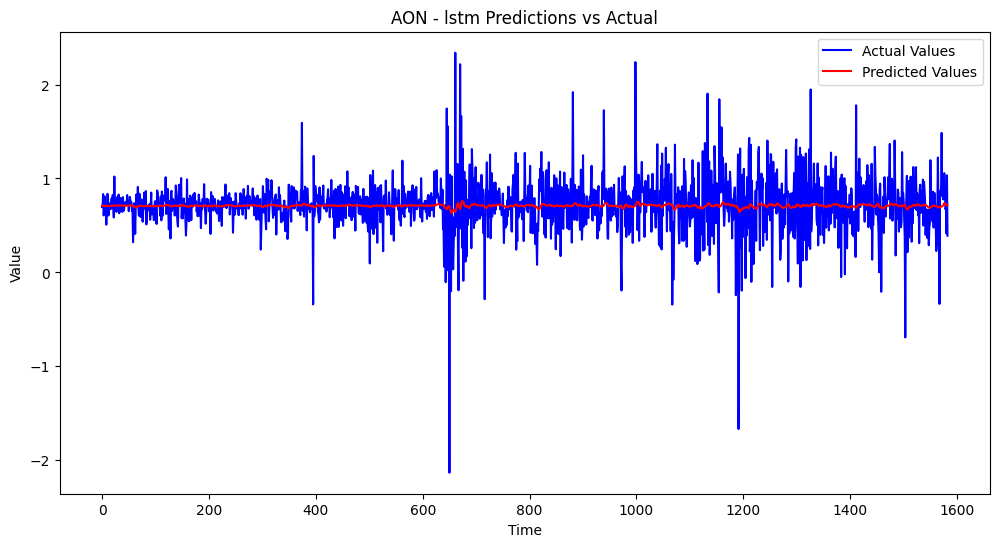

50/50 [==============================] - 1s 5ms/step
AON - gru - RMSE: 0.28691, MAE: 0.18946, MAPE: 0.76545


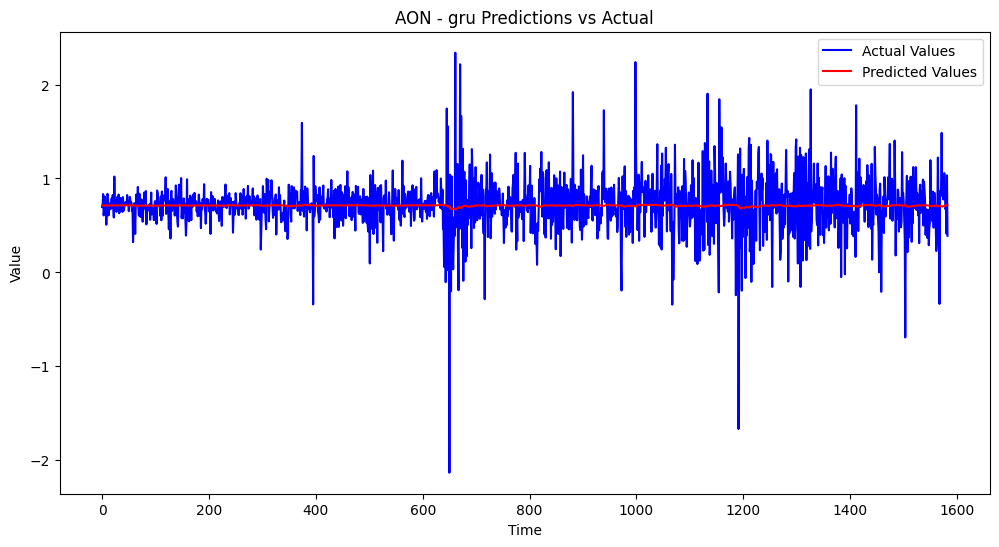

32/32 [==============================] - 1s 5ms/step
POOL - lstm - RMSE: 1.01419, MAE: 0.73894, MAPE: 2.43446


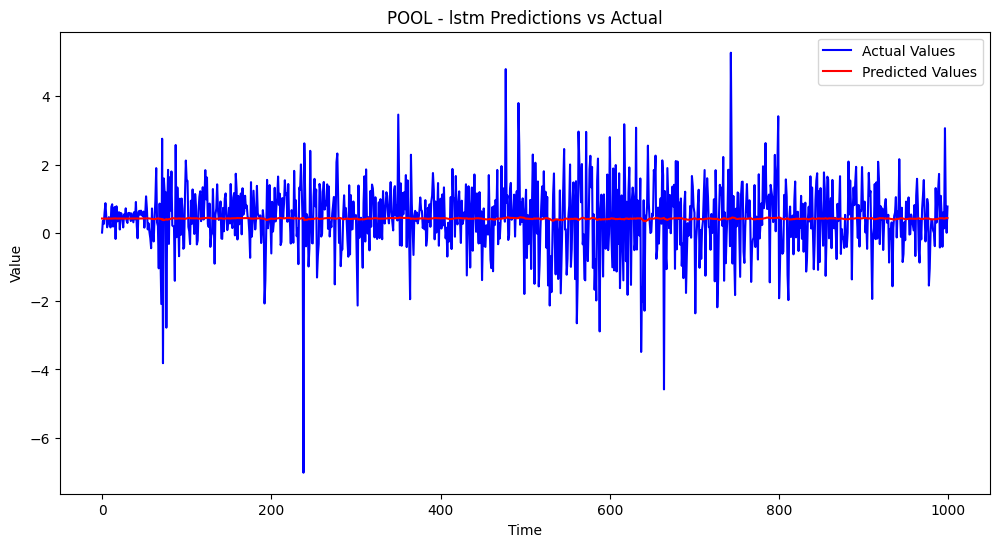

32/32 [==============================] - 1s 4ms/step
POOL - gru - RMSE: 1.01368, MAE: 0.73828, MAPE: 2.44369


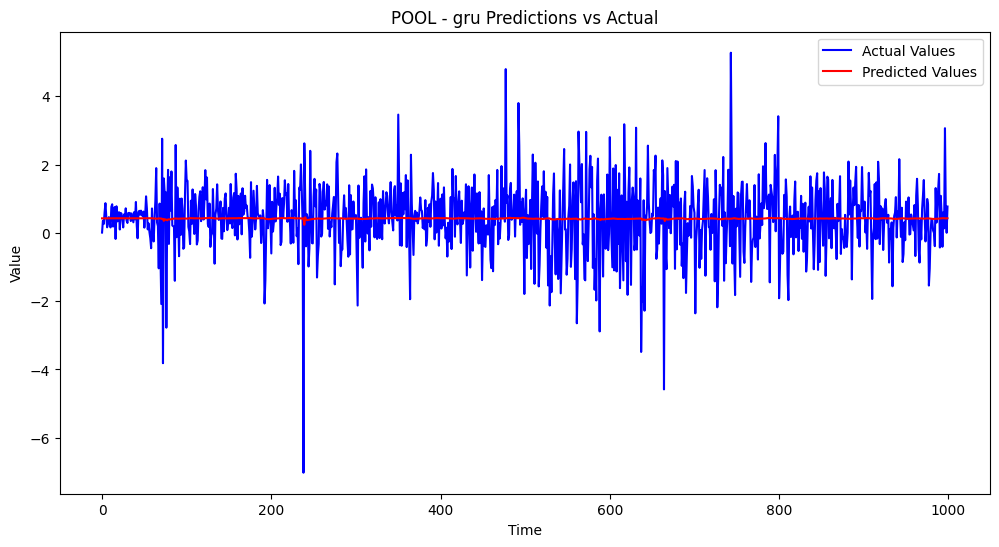

10/10 [==============================] - 1s 5ms/step
VYGVQ - lstm - RMSE: 0.00506, MAE: 0.00462, MAPE: 0.00923


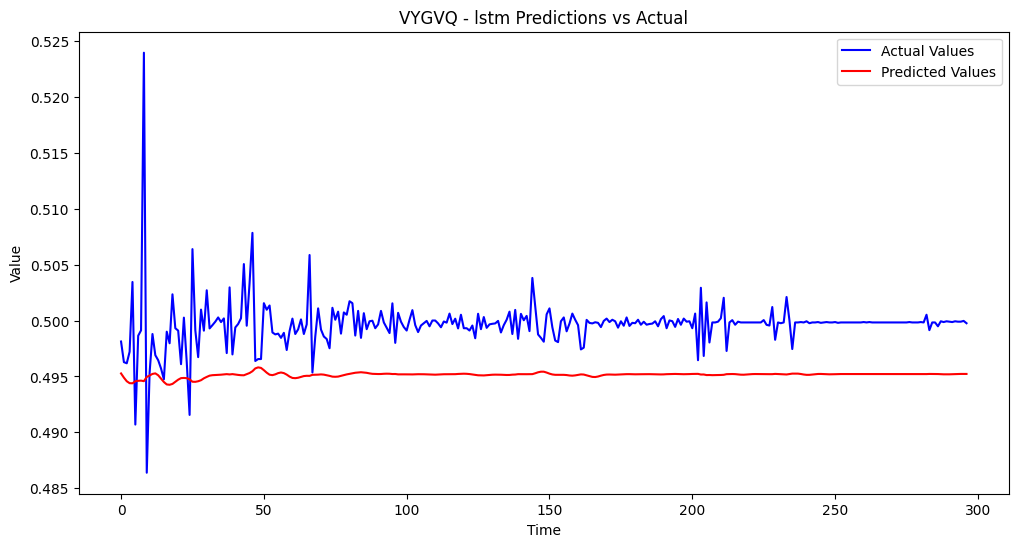

10/10 [==============================] - 1s 5ms/step
VYGVQ - gru - RMSE: 0.00794, MAE: 0.00765, MAPE: 0.01529


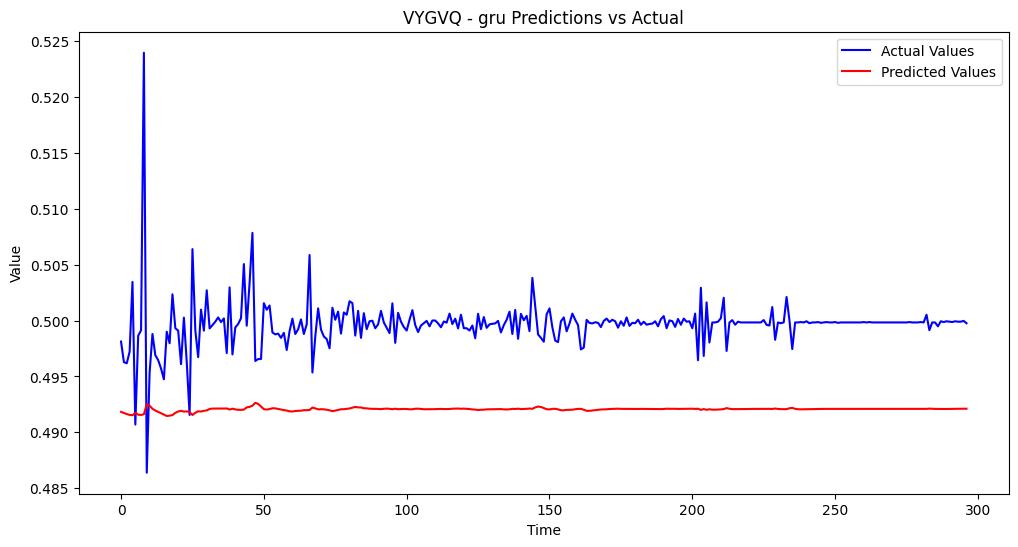

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate RMSE
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Function to plot predictions vs actual values
def plot_predictions(actual, predicted, symbol, model_type):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Values', color='blue')
    plt.plot(predicted, label='Predicted Values', color='red')
    plt.title(f'{symbol} - {model_type} Predictions vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Evaluate and visualize for each model and stock
for (symbol, model_type), model in final_models.items():
    # Prepare the test data
    test_sequences, test_labels = test_data[symbol]

    # Generate predictions
    predicted = model.predict(test_sequences).flatten()
    actual = test_labels.flatten()

    # Calculate RMSE, MAE, and MAPE
    rmse = calculate_rmse(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted)

    # Print out the metrics
    print(f"{symbol} - {model_type} - RMSE: {rmse:.5f}, MAE: {mae:.5f}, MAPE: {mape:.5f}")

    # Visualize predictions vs actual
    plot_predictions(actual, predicted, symbol, model_type)


Epoch 1/50
238/238 [==============================] - 30s 109ms/step - loss: 0.1793 - val_loss: 0.1304
Epoch 2/50
238/238 [==============================] - 24s 102ms/step - loss: 0.0052 - val_loss: 0.4490
Epoch 3/50
238/238 [==============================] - 24s 99ms/step - loss: 0.0019 - val_loss: 2.0587
Epoch 4/50
238/238 [==============================] - 25s 105ms/step - loss: 0.0019 - val_loss: 1.2975
Epoch 1/50
238/238 [==============================] - 27s 98ms/step - loss: 0.0333 - val_loss: 0.1047
Epoch 2/50
238/238 [==============================] - 24s 100ms/step - loss: 0.0013 - val_loss: 0.0964
Epoch 3/50
238/238 [==============================] - 24s 101ms/step - loss: 0.0012 - val_loss: 0.0918
Epoch 4/50
238/238 [==============================] - 24s 101ms/step - loss: 0.0012 - val_loss: 0.0885
Epoch 5/50
238/238 [==============================] - 23s 96ms/step - loss: 0.0012 - val_loss: 0.0868
Epoch 6/50
238/238 [==============================] - 23s 97ms/step - loss: 

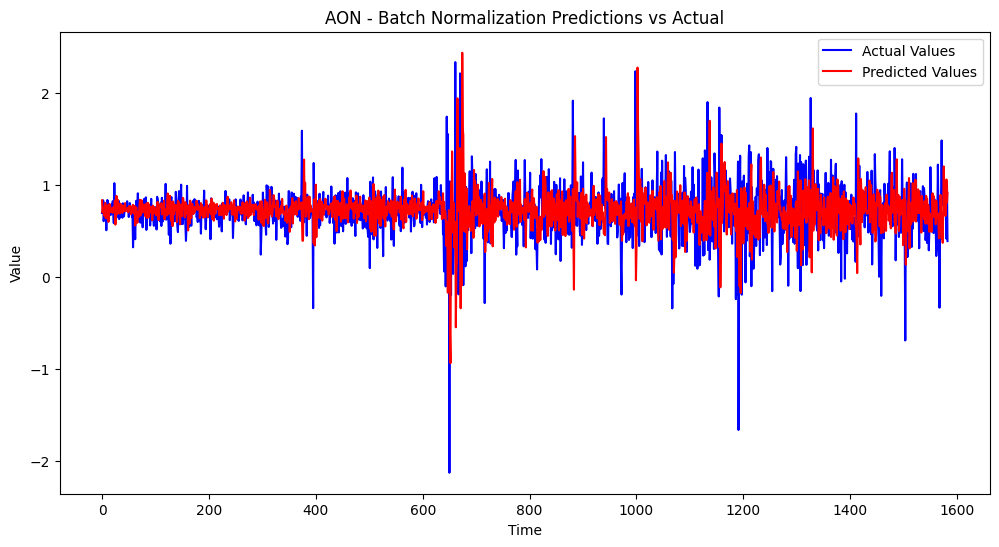

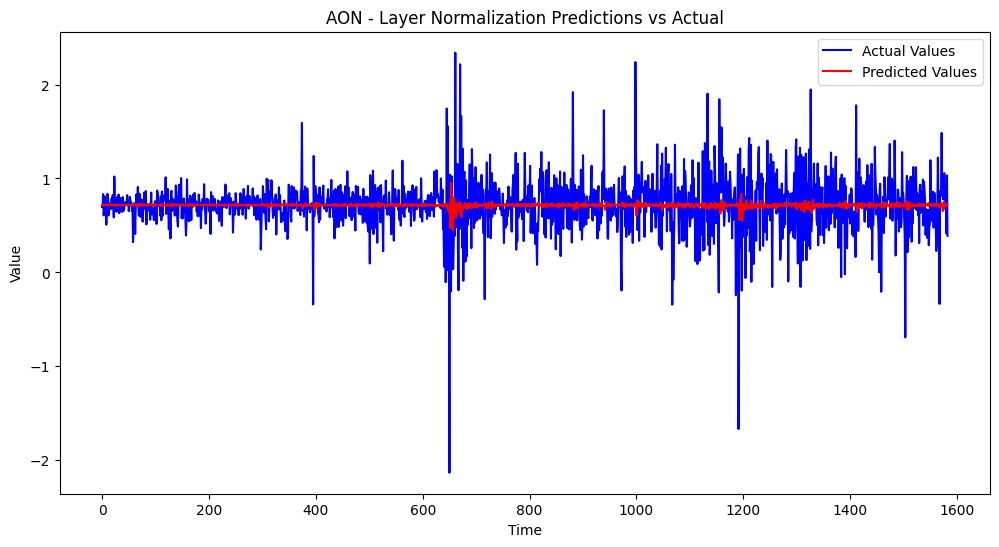

Epoch 1/50
153/153 [==============================] - 20s 113ms/step - loss: 0.1877 - val_loss: 1.4266
Epoch 2/50
153/153 [==============================] - 16s 103ms/step - loss: 0.0285 - val_loss: 3.5978
Epoch 3/50
153/153 [==============================] - 16s 103ms/step - loss: 0.0141 - val_loss: 10.8628
Epoch 4/50
153/153 [==============================] - 16s 106ms/step - loss: 0.0108 - val_loss: 29.9581
Epoch 1/50
153/153 [==============================] - 19s 103ms/step - loss: 0.0314 - val_loss: 1.4853
Epoch 2/50
153/153 [==============================] - 15s 101ms/step - loss: 0.0031 - val_loss: 1.4135
Epoch 3/50
153/153 [==============================] - 16s 103ms/step - loss: 0.0031 - val_loss: 1.3679
Epoch 4/50
153/153 [==============================] - 15s 100ms/step - loss: 0.0029 - val_loss: 1.3359
Epoch 5/50
153/153 [==============================] - 17s 110ms/step - loss: 0.0030 - val_loss: 1.3057
Epoch 6/50
153/153 [==============================] - 16s 103ms/step - 

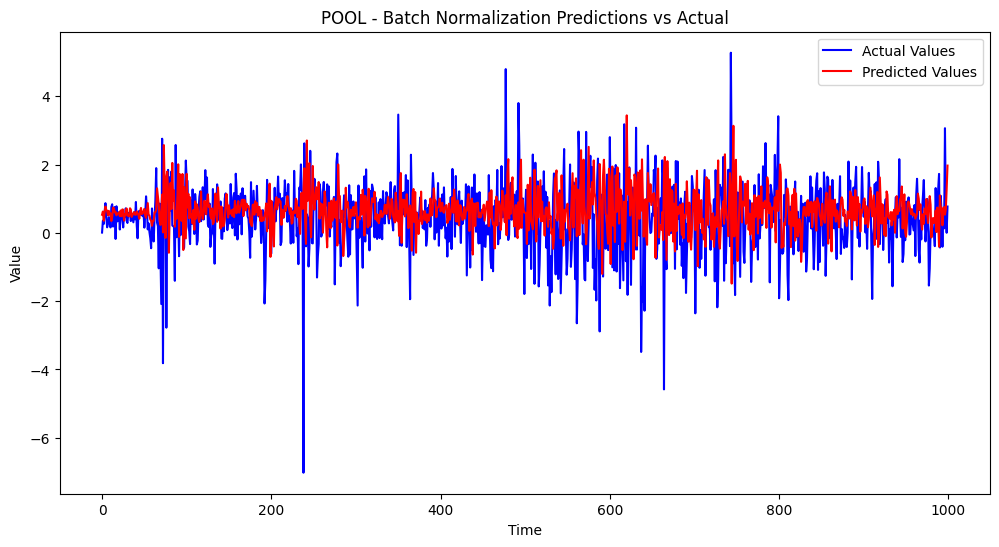

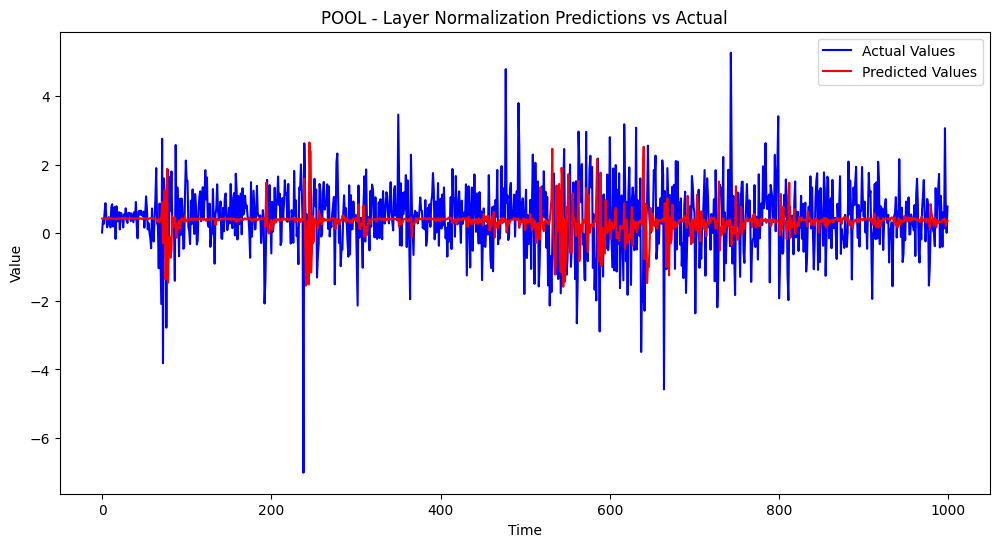

Epoch 1/50
51/51 [==============================] - 10s 137ms/step - loss: 0.4498 - val_loss: 0.2855
Epoch 2/50
51/51 [==============================] - 5s 98ms/step - loss: 0.0647 - val_loss: 0.3074
Epoch 3/50
51/51 [==============================] - 6s 125ms/step - loss: 0.0199 - val_loss: 0.1177
Epoch 4/50
51/51 [==============================] - 5s 98ms/step - loss: 0.0106 - val_loss: 0.1856
Epoch 5/50
51/51 [==============================] - 6s 118ms/step - loss: 0.0078 - val_loss: 0.0935
Epoch 6/50
51/51 [==============================] - 5s 107ms/step - loss: 0.0048 - val_loss: 0.1332
Epoch 7/50
51/51 [==============================] - 5s 102ms/step - loss: 0.0041 - val_loss: 0.0874
Epoch 8/50
51/51 [==============================] - 6s 127ms/step - loss: 0.0040 - val_loss: 0.5748
Epoch 9/50
51/51 [==============================] - 5s 99ms/step - loss: 0.0033 - val_loss: 0.4340
Epoch 10/50
51/51 [==============================] - 6s 128ms/step - loss: 0.0022 - val_loss: 0.1173
E

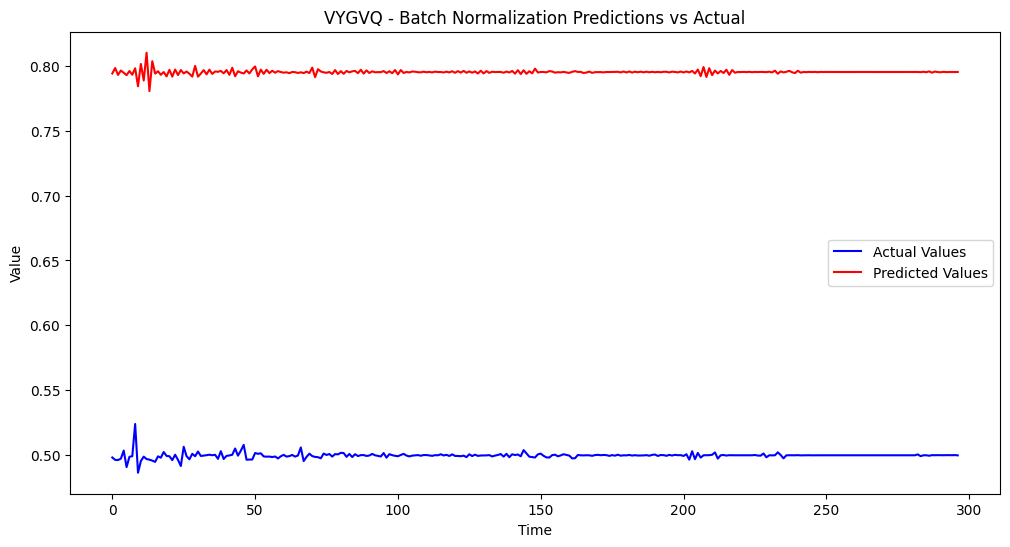

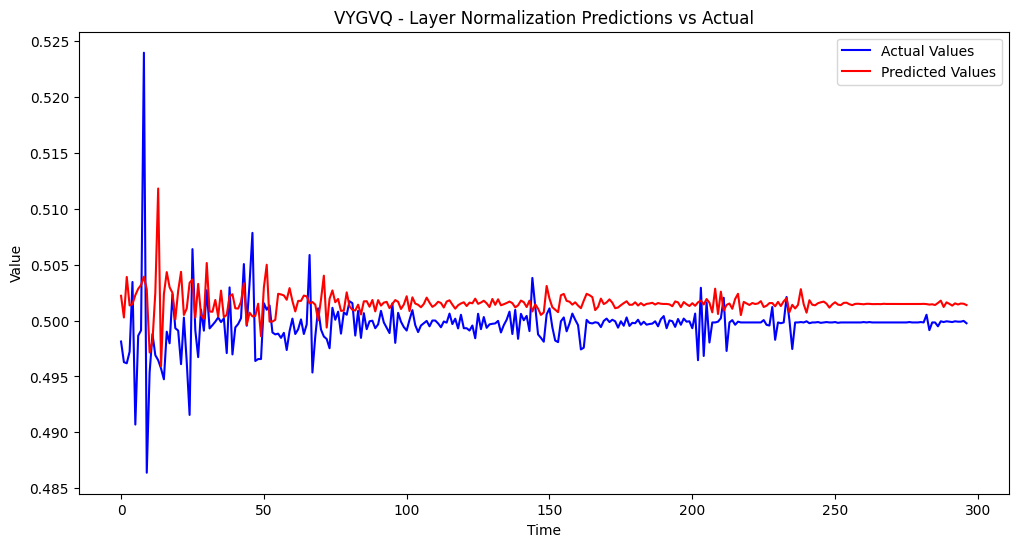

In [12]:
from tensorflow.keras.layers import SimpleRNN, BatchNormalization, LayerNormalization, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

def build_rnn_model_with_normalization(input_shape, units=50, normalization_type='batch'):
    model = Sequential()
    model.add(SimpleRNN(units, return_sequences=True, input_shape=input_shape))
    if normalization_type == 'batch':
        model.add(BatchNormalization())
    elif normalization_type == 'layer':
        model.add(LayerNormalization())
    model.add(SimpleRNN(units))
    if normalization_type == 'batch':
        model.add(BatchNormalization())
    elif normalization_type == 'layer':
        model.add(LayerNormalization())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def plot_predictions(actual, predicted, symbol, model_type):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Values', color='blue')
    plt.plot(predicted, label='Predicted Values', color='red')
    plt.title(f'{symbol} - {model_type} Predictions vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

number_of_features = 1

for symbol in ['AON', 'POOL', 'VYGVQ']:
    input_shape = (sequence_length, number_of_features)

    # Create models with batch normalization and layer normalization
    model_batch = build_rnn_model_with_normalization(input_shape, normalization_type='batch')
    model_layer = build_rnn_model_with_normalization(input_shape, normalization_type='layer')

    # Get your training and test data 
    train_sequences, train_labels = train_data[symbol]
    test_sequences, test_labels = test_data[symbol]

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the models
    model_batch.fit(train_sequences, train_labels, epochs=50, batch_size=32, validation_data=(test_sequences, test_labels), callbacks=[early_stopping])
    model_layer.fit(train_sequences, train_labels, epochs=50, batch_size=32, validation_data=(test_sequences, test_labels), callbacks=[early_stopping])

    # Predictions
    predicted_batch = model_batch.predict(test_sequences).flatten()
    predicted_layer = model_layer.predict(test_sequences).flatten()
    actual = test_labels.flatten()

    # Calculate RMSE, MAE, MAPE
    rmse_batch = calculate_rmse(actual, predicted_batch)
    mae_batch = mean_absolute_error(actual, predicted_batch)
    mape_batch = mean_absolute_percentage_error(actual, predicted_batch)

    rmse_layer = calculate_rmse(actual, predicted_layer)
    mae_layer = mean_absolute_error(actual, predicted_layer)
    mape_layer = mean_absolute_percentage_error(actual, predicted_layer)

    # Print metrics
    print(f'{symbol} - Batch Normalization - RMSE: {rmse_batch:.5f}, MAE: {mae_batch:.5f}, MAPE: {mape_batch:.5f}')
    print(f'{symbol} - Layer Normalization - RMSE: {rmse_layer:.5f}, MAE: {mae_layer:.5f}, MAPE: {mape_layer:.5f}')

    # Plot predictions
    plot_predictions(actual, predicted_batch, symbol, 'Batch Normalization')
    plot_predictions(actual, predicted_layer, symbol, 'Layer Normalization')


Epoch 1/50
238/238 [==============================] - 14s 38ms/step - loss: 3.0586 - val_loss: 2.1741
Epoch 2/50
238/238 [==============================] - 8s 34ms/step - loss: 1.2590 - val_loss: 0.8497
Epoch 3/50
238/238 [==============================] - 8s 33ms/step - loss: 0.3347 - val_loss: 0.7048
Epoch 4/50
238/238 [==============================] - 8s 34ms/step - loss: 0.1109 - val_loss: 0.1616
Epoch 5/50
238/238 [==============================] - 8s 33ms/step - loss: 0.0538 - val_loss: 0.1372
Epoch 6/50
238/238 [==============================] - 8s 33ms/step - loss: 0.0327 - val_loss: 0.1064
Epoch 7/50
238/238 [==============================] - 8s 34ms/step - loss: 0.0175 - val_loss: 0.0952
Epoch 8/50
238/238 [==============================] - 9s 37ms/step - loss: 0.0075 - val_loss: 0.0868
Epoch 9/50
238/238 [==============================] - 9s 37ms/step - loss: 0.0035 - val_loss: 0.0845
Epoch 10/50
238/238 [==============================] - 8s 33ms/step - loss: 0.0030 - val_l

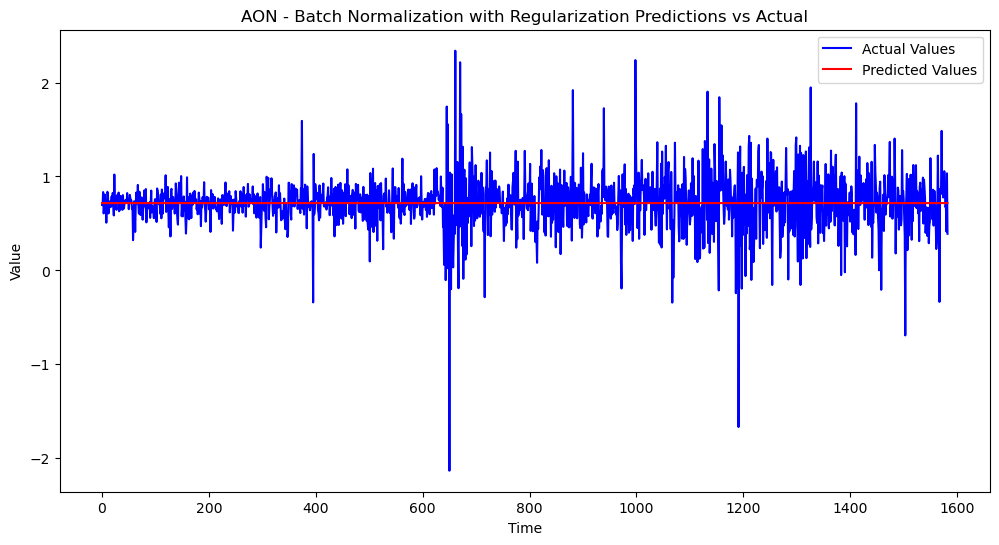

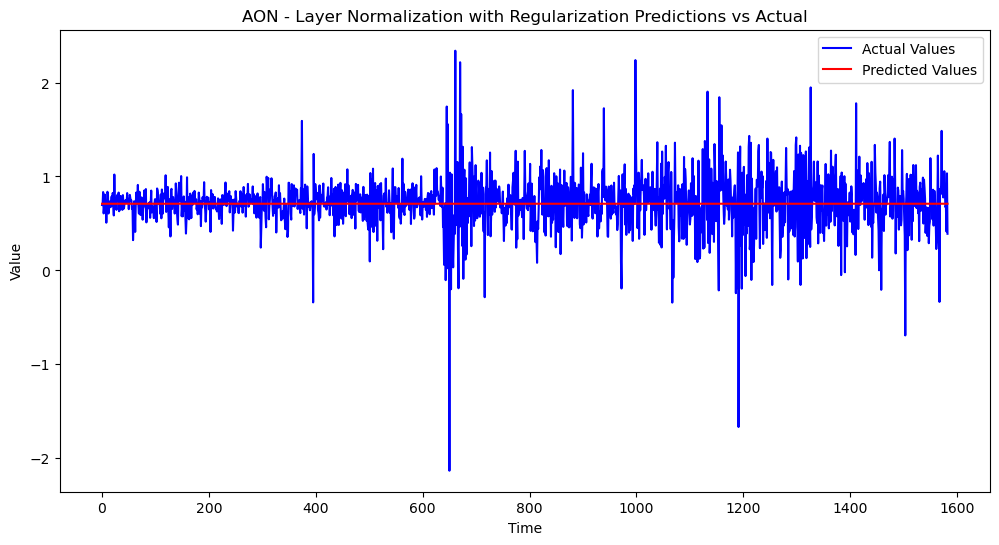

Epoch 1/50
153/153 [==============================] - 11s 40ms/step - loss: 3.3471 - val_loss: 3.7849
Epoch 2/50
153/153 [==============================] - 6s 38ms/step - loss: 1.9778 - val_loss: 2.7623
Epoch 3/50
153/153 [==============================] - 6s 37ms/step - loss: 0.9402 - val_loss: 2.0002
Epoch 4/50
153/153 [==============================] - 5s 35ms/step - loss: 0.3968 - val_loss: 1.4984
Epoch 5/50
153/153 [==============================] - 5s 36ms/step - loss: 0.1847 - val_loss: 1.2450
Epoch 6/50
153/153 [==============================] - 6s 36ms/step - loss: 0.0920 - val_loss: 1.1090
Epoch 7/50
153/153 [==============================] - 6s 37ms/step - loss: 0.0759 - val_loss: 1.0931
Epoch 8/50
153/153 [==============================] - 6s 37ms/step - loss: 0.0372 - val_loss: 1.0673
Epoch 9/50
153/153 [==============================] - 5s 36ms/step - loss: 0.0348 - val_loss: 1.1392
Epoch 10/50
153/153 [==============================] - 6s 36ms/step - loss: 0.0229 - val_l

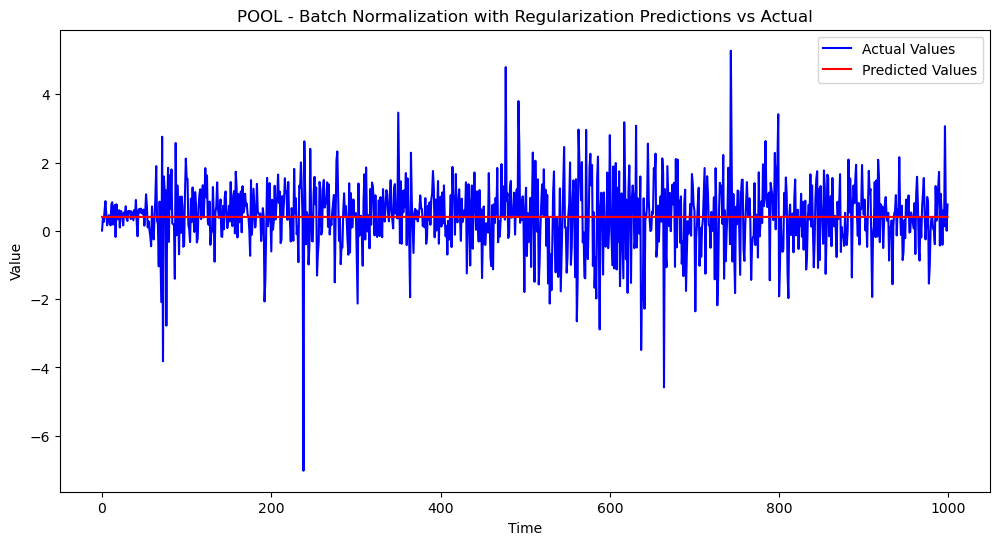

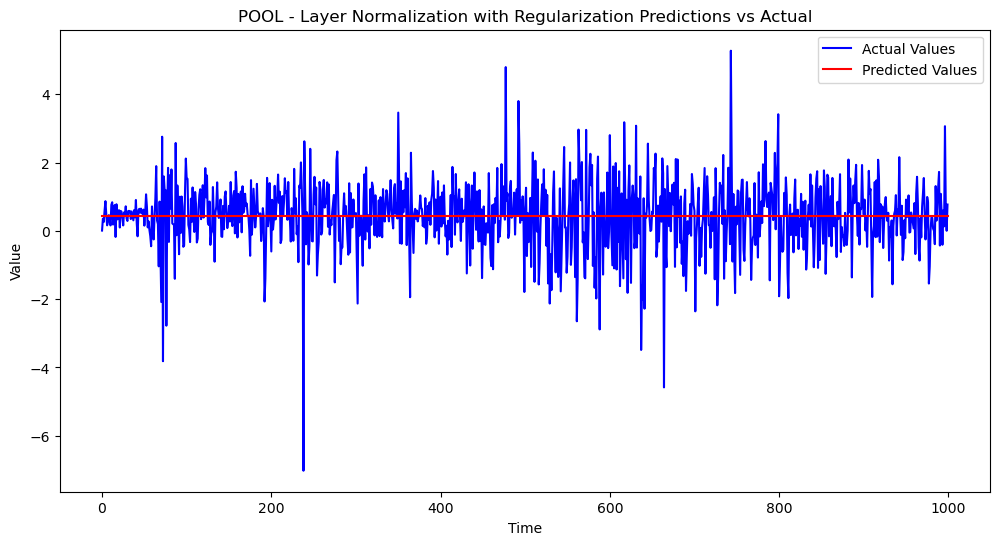

Epoch 1/50
51/51 [==============================] - 9s 55ms/step - loss: 4.0988 - val_loss: 3.6321
Epoch 2/50
51/51 [==============================] - 2s 38ms/step - loss: 3.6014 - val_loss: 3.3303
Epoch 3/50
51/51 [==============================] - 2s 38ms/step - loss: 3.2553 - val_loss: 3.0794
Epoch 4/50
51/51 [==============================] - 2s 44ms/step - loss: 2.9669 - val_loss: 2.8231
Epoch 5/50
51/51 [==============================] - 2s 47ms/step - loss: 2.6830 - val_loss: 2.5380
Epoch 6/50
51/51 [==============================] - 2s 36ms/step - loss: 2.3961 - val_loss: 2.2636
Epoch 7/50
51/51 [==============================] - 2s 32ms/step - loss: 2.1082 - val_loss: 1.9620
Epoch 8/50
51/51 [==============================] - 2s 34ms/step - loss: 1.8211 - val_loss: 1.6988
Epoch 9/50
51/51 [==============================] - 2s 40ms/step - loss: 1.5467 - val_loss: 1.4323
Epoch 10/50
51/51 [==============================] - 2s 37ms/step - loss: 1.2941 - val_loss: 1.1743
Epoch 11/

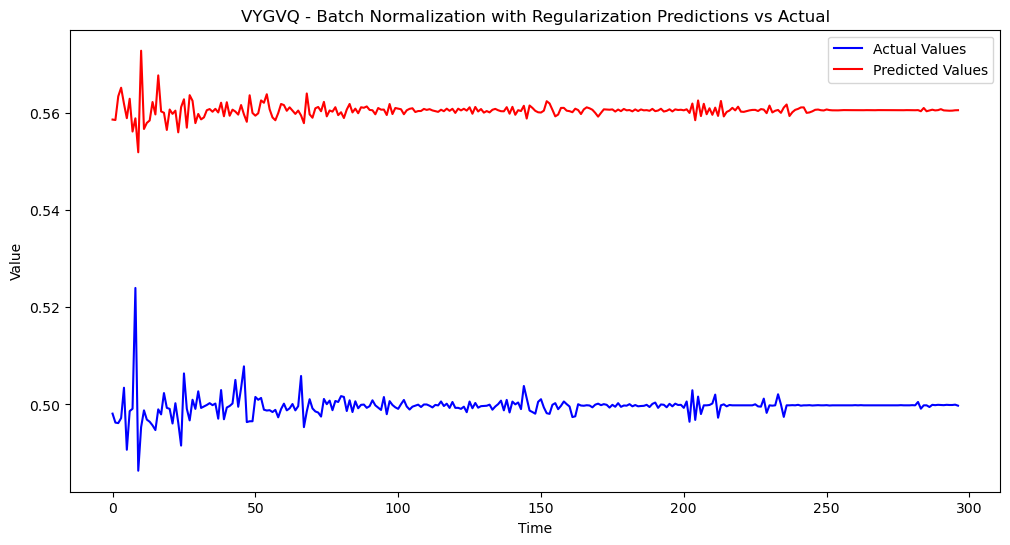

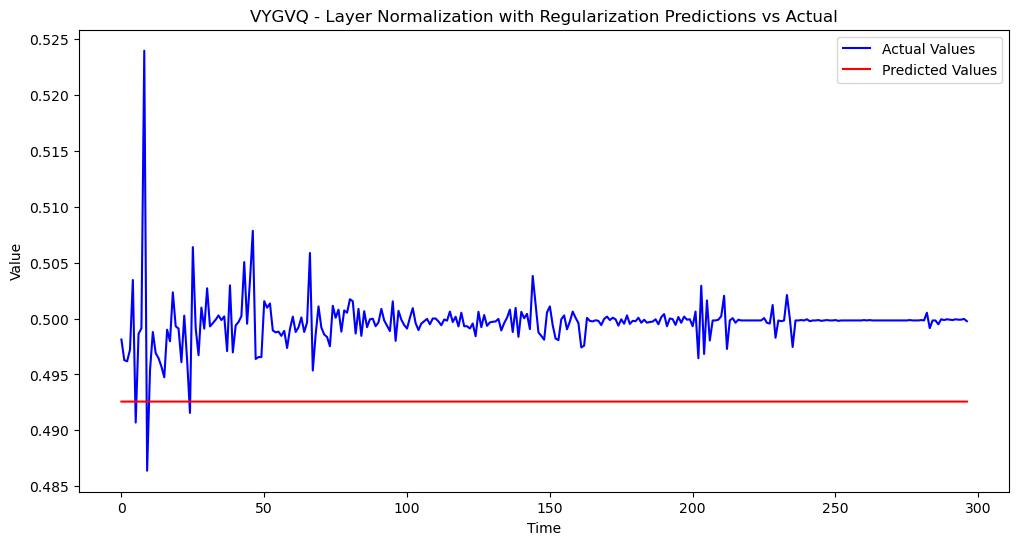

In [11]:
from tensorflow.keras.layers import SimpleRNN, BatchNormalization, LayerNormalization, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

def build_rnn_model_with_regularization(input_shape, units=50, normalization_type='batch', l1_ratio=0.01, l2_ratio=0.01):
    model = Sequential()
    reg = l1_l2(l1=l1_ratio, l2=l2_ratio)
    model.add(SimpleRNN(units, return_sequences=True, input_shape=input_shape, kernel_regularizer=reg))
    if normalization_type == 'batch':
        model.add(BatchNormalization())
    elif normalization_type == 'layer':
        model.add(LayerNormalization())
    model.add(SimpleRNN(units, kernel_regularizer=reg))
    if normalization_type == 'batch':
        model.add(BatchNormalization())
    elif normalization_type == 'layer':
        model.add(LayerNormalization())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def plot_predictions(actual, predicted, symbol, model_type):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Values', color='blue')
    plt.plot(predicted, label='Predicted Values', color='red')
    plt.title(f'{symbol} - {model_type} Predictions vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

number_of_features = 1

for symbol in ['AON', 'POOL', 'VYGVQ']:
    input_shape = (sequence_length, number_of_features)

    # Create models with different normalization and regularization configurations
    model_batch_reg = build_rnn_model_with_regularization(input_shape, normalization_type='batch')
    model_layer_reg = build_rnn_model_with_regularization(input_shape, normalization_type='layer')

    # Get your training and test data
    train_sequences, train_labels = train_data[symbol]
    test_sequences, test_labels = test_data[symbol]

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the models
    model_batch_reg.fit(train_sequences, train_labels, epochs=50, batch_size=32, validation_data=(test_sequences, test_labels), callbacks=[early_stopping])
    model_layer_reg.fit(train_sequences, train_labels, epochs=50, batch_size=32, validation_data=(test_sequences, test_labels), callbacks=[early_stopping])

    # Predictions
    predicted_batch_reg = model_batch_reg.predict(test_sequences).flatten()
    predicted_layer_reg = model_layer_reg.predict(test_sequences).flatten()
    actual = test_labels.flatten()

    # Calculate RMSE, MAE, MAPE
    rmse_batch_reg = calculate_rmse(actual, predicted_batch_reg)
    mae_batch_reg = mean_absolute_error(actual, predicted_batch_reg)
    mape_batch_reg = mean_absolute_percentage_error(actual, predicted_batch_reg)

    rmse_layer_reg = calculate_rmse(actual, predicted_layer_reg)
    mae_layer_reg = mean_absolute_error(actual, predicted_layer_reg)
    mape_layer_reg = mean_absolute_percentage_error(actual, predicted_layer_reg)

    # Print metrics
    print(f'{symbol} - Batch Normalization with Regularization - RMSE: {rmse_batch_reg:.5f}, MAE: {mae_batch_reg:.5f}, MAPE: {mape_batch_reg:.5f}')
    print(f'{symbol} - Layer Normalization with Regularization - RMSE: {rmse_layer_reg:.5f}, MAE: {mae_layer_reg:.5f}, MAPE: {mape_layer_reg:.5f}')

    # Plot predictions
    plot_predictions(actual, predicted_batch_reg, symbol, 'Batch Normalization with Regularization')
    plot_predictions(actual, predicted_layer_reg, symbol, 'Layer Normalization with Regularization')


In [27]:
import optuna
from optuna.pruners import MedianPruner
from tensorflow.keras.layers import SimpleRNN, LayerNormalization, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import optuna.visualization as ov
from tensorflow.keras import backend as K

def build_vanilla_rnn_model(trial, input_shape):
    # Hyperparameters to be optimized
    units = trial.suggest_categorical('units', [50, 100, 150])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Model building
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=input_shape, return_sequences=True))
    model.add(LayerNormalization())
    model.add(SimpleRNN(units))
    model.add(LayerNormalization())
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    return model, batch_size

def objective(trial, symbol):
    # Clear TensorFlow session
    K.clear_session()

    # Build the Vanilla RNN model
    model, batch_size = build_vanilla_rnn_model(trial, input_shape=(sequence_length, 1))

    # Load the dataset
    train_sequences, train_labels = train_data[symbol]
    val_sequences, val_labels = validation_data[symbol]

    # Early stopping and ModelCheckpoint callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'best_model_{symbol}_vanilla_rnn.h5', save_best_only=True)

    # Train the model
    history = model.fit(
        train_sequences, train_labels,
        validation_data=(val_sequences, val_labels),
        epochs=50, batch_size=batch_size,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    # Evaluate the model on the validation set
    val_loss = min(history.history['val_loss'])
    return val_loss

# Number of trials and epochs
n_trials = 25
epochs = 50

# Run separate studies for each stock
final_models = {}
for symbol in ['AON', 'POOL', 'VYGVQ']:
    print(f"Optimizing Vanilla RNN model for {symbol}")

    # Create a pruner and a study
    pruner = MedianPruner()
    study = optuna.create_study(direction='minimize', pruner=pruner)
    study.optimize(lambda trial: objective(trial, symbol), n_trials=n_trials)

    # Visualization after each study
    ov.plot_optimization_history(study)
    ov.plot_param_importances(study)

    # Retrieve the best model
    best_trial = study.best_trial
    best_model = build_vanilla_rnn_model(best_trial, input_shape=(sequence_length, 1))[0]
    final_models[symbol] = best_model

    # Print the best parameters and loss for each model and stock
    print(f"Best Vanilla RNN model for {symbol}:")
    print(f"  Loss: {best_trial.value}")
    print(f"  Params: {best_trial.params}")

# Print out the best parameters and performance for each model and stock
for symbol, model in final_models.items():
    print(f"Best Vanilla RNN model for {symbol} has been saved.")


[I 2023-11-20 21:13:40,393] A new study created in memory with name: no-name-84f354ec-ef41-4f5e-a396-31ec3f8cdf31


Optimizing Vanilla RNN model for AON
Epoch 1/50
119/119 [==============================] - 17s 119ms/step - loss: 0.2467 - val_loss: 0.0045
Epoch 2/50
119/119 [==============================] - 13s 113ms/step - loss: 9.8882e-04 - val_loss: 0.0045
Epoch 3/50
119/119 [==============================] - 14s 116ms/step - loss: 9.9208e-04 - val_loss: 0.0048
Epoch 4/50
119/119 [==============================] - 14s 115ms/step - loss: 9.9370e-04 - val_loss: 0.0047
Epoch 5/50
119/119 [==============================] - 13s 111ms/step - loss: 0.0010 - val_loss: 0.0045


[I 2023-11-20 21:14:52,658] Trial 0 finished with value: 0.004484402481466532 and parameters: {'units': 100, 'dropout_rate': 0.446705525793315, 'learning_rate': 0.007443359335422182, 'batch_size': 64}. Best is trial 0 with value: 0.004484402481466532.


Epoch 1/50
60/60 [==============================] - 10s 112ms/step - loss: 0.0164 - val_loss: 0.0093
Epoch 2/50
60/60 [==============================] - 6s 99ms/step - loss: 0.0018 - val_loss: 0.0067
Epoch 3/50
60/60 [==============================] - 5s 86ms/step - loss: 0.0014 - val_loss: 0.0057
Epoch 4/50
60/60 [==============================] - 5s 91ms/step - loss: 0.0012 - val_loss: 0.0053
Epoch 5/50
60/60 [==============================] - 5s 91ms/step - loss: 0.0012 - val_loss: 0.0052
Epoch 6/50
60/60 [==============================] - 5s 91ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 7/50
60/60 [==============================] - 6s 98ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 8/50
60/60 [==============================] - 6s 97ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 9/50
60/60 [==============================] - 6s 98ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 10/50
60/60 [==============================] - 6s 99ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 1

[I 2023-11-20 21:16:26,574] Trial 1 finished with value: 0.0045225732028484344 and parameters: {'units': 50, 'dropout_rate': 0.31200077973301377, 'learning_rate': 0.00045966727039907144, 'batch_size': 128}. Best is trial 0 with value: 0.004484402481466532.


Epoch 1/50
60/60 [==============================] - 8s 84ms/step - loss: 0.0055 - val_loss: 0.0068
Epoch 2/50
60/60 [==============================] - 5s 79ms/step - loss: 0.0014 - val_loss: 0.0058
Epoch 3/50
60/60 [==============================] - 4s 68ms/step - loss: 0.0012 - val_loss: 0.0053
Epoch 4/50
60/60 [==============================] - 4s 69ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 5/50
60/60 [==============================] - 4s 72ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 6/50
60/60 [==============================] - 5s 78ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 7/50
60/60 [==============================] - 5s 78ms/step - loss: 0.0010 - val_loss: 0.0048
Epoch 8/50
60/60 [==============================] - 4s 75ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 9/50
60/60 [==============================] - 4s 71ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 10/50
60/60 [==============================] - 10s 160ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 1

[I 2023-11-20 21:17:37,241] Trial 2 finished with value: 0.0045842197723686695 and parameters: {'units': 50, 'dropout_rate': 0.11339048315472944, 'learning_rate': 0.00023332572540685863, 'batch_size': 128}. Best is trial 0 with value: 0.004484402481466532.


Epoch 1/50
119/119 [==============================] - 9s 48ms/step - loss: 0.2008 - val_loss: 0.0485
Epoch 2/50
119/119 [==============================] - 8s 67ms/step - loss: 0.0076 - val_loss: 0.0220
Epoch 3/50
119/119 [==============================] - 6s 51ms/step - loss: 0.0038 - val_loss: 0.0127
Epoch 4/50
119/119 [==============================] - 5s 45ms/step - loss: 0.0024 - val_loss: 0.0093
Epoch 5/50
119/119 [==============================] - 6s 51ms/step - loss: 0.0018 - val_loss: 0.0077
Epoch 6/50
119/119 [==============================] - 6s 48ms/step - loss: 0.0016 - val_loss: 0.0068
Epoch 7/50
119/119 [==============================] - 6s 47ms/step - loss: 0.0014 - val_loss: 0.0062
Epoch 8/50
119/119 [==============================] - 8s 67ms/step - loss: 0.0013 - val_loss: 0.0059
Epoch 9/50
119/119 [==============================] - 7s 55ms/step - loss: 0.0012 - val_loss: 0.0056
Epoch 10/50
119/119 [==============================] - 5s 43ms/step - loss: 0.0012 - val_lo

[I 2023-11-20 21:20:07,888] Trial 3 finished with value: 0.0046596829779446125 and parameters: {'units': 50, 'dropout_rate': 0.38446924574567276, 'learning_rate': 0.00020495638256509135, 'batch_size': 64}. Best is trial 0 with value: 0.004484402481466532.


Epoch 1/50
119/119 [==============================] - 16s 112ms/step - loss: 0.2217 - val_loss: 0.0047
Epoch 2/50
119/119 [==============================] - 17s 145ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 3/50
119/119 [==============================] - 18s 152ms/step - loss: 0.0010 - val_loss: 0.0048
Epoch 4/50
119/119 [==============================] - 16s 134ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 5/50
119/119 [==============================] - 17s 144ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 6/50
119/119 [==============================] - 17s 142ms/step - loss: 9.9963e-04 - val_loss: 0.0047
Epoch 7/50
119/119 [==============================] - 19s 157ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 8/50
119/119 [==============================] - 16s 133ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 9/50
119/119 [==============================] - 14s 120ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 10/50
119/119 [==============================] - 13s 108ms/step

[I 2023-11-20 21:23:05,935] Trial 4 finished with value: 0.004584325477480888 and parameters: {'units': 150, 'dropout_rate': 0.4871006940295931, 'learning_rate': 0.0016249862815054974, 'batch_size': 64}. Best is trial 0 with value: 0.004484402481466532.


Epoch 1/50
119/119 [==============================] - 19s 136ms/step - loss: 0.0304 - val_loss: 0.0175
Epoch 2/50
119/119 [==============================] - 13s 107ms/step - loss: 0.0035 - val_loss: 0.0145
Epoch 3/50
119/119 [==============================] - 13s 107ms/step - loss: 0.0029 - val_loss: 0.0124
Epoch 4/50
119/119 [==============================] - 13s 107ms/step - loss: 0.0024 - val_loss: 0.0104
Epoch 5/50
119/119 [==============================] - 13s 106ms/step - loss: 0.0021 - val_loss: 0.0091
Epoch 6/50
119/119 [==============================] - 12s 103ms/step - loss: 0.0018 - val_loss: 0.0079
Epoch 7/50
119/119 [==============================] - 14s 121ms/step - loss: 0.0016 - val_loss: 0.0073
Epoch 8/50
119/119 [==============================] - 13s 113ms/step - loss: 0.0015 - val_loss: 0.0067
Epoch 9/50
119/119 [==============================] - 13s 108ms/step - loss: 0.0014 - val_loss: 0.0062
Epoch 10/50
119/119 [==============================] - 14s 116ms/step - l

[I 2023-11-20 21:30:38,025] Trial 5 finished with value: 0.00460015470162034 and parameters: {'units': 150, 'dropout_rate': 0.19441790242276935, 'learning_rate': 1.5899168069826212e-05, 'batch_size': 64}. Best is trial 0 with value: 0.004484402481466532.


Epoch 1/50
60/60 [==============================] - 8s 87ms/step - loss: 0.1685 - val_loss: 0.0055
Epoch 2/50
60/60 [==============================] - 5s 79ms/step - loss: 0.0012 - val_loss: 0.0052
Epoch 3/50
60/60 [==============================] - 4s 72ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 4/50
60/60 [==============================] - 4s 74ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 5/50
60/60 [==============================] - 5s 77ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 6/50
60/60 [==============================] - 5s 79ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 7/50
60/60 [==============================] - 5s 79ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 8/50
60/60 [==============================] - 4s 73ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 9/50
60/60 [==============================] - 4s 70ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 10/50
60/60 [==============================] - 4s 74ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 11/

[I 2023-11-20 21:31:57,259] Trial 6 finished with value: 0.00473069678992033 and parameters: {'units': 50, 'dropout_rate': 0.4091909807798805, 'learning_rate': 0.003507295074477599, 'batch_size': 128}. Best is trial 0 with value: 0.004484402481466532.


Epoch 1/50
119/119 [==============================] - 8s 41ms/step - loss: 0.0049 - val_loss: 0.0064
Epoch 2/50
119/119 [==============================] - 4s 36ms/step - loss: 0.0013 - val_loss: 0.0052
Epoch 3/50
119/119 [==============================] - 4s 38ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 4/50
119/119 [==============================] - 4s 33ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 5/50
119/119 [==============================] - 4s 34ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 6/50
119/119 [==============================] - 4s 37ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 7/50
119/119 [==============================] - 5s 39ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 8/50
119/119 [==============================] - 4s 37ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 9/50
119/119 [==============================] - 5s 39ms/step - loss: 0.0010 - val_loss: 0.0051
Epoch 10/50
119/119 [==============================] - 5s 38ms/step - loss: 0.0011 - val_lo

[I 2023-11-20 21:33:05,852] Trial 7 finished with value: 0.004532877821475267 and parameters: {'units': 50, 'dropout_rate': 0.30650893942163493, 'learning_rate': 0.00037323853408694315, 'batch_size': 64}. Best is trial 0 with value: 0.004484402481466532.


Epoch 1/50
119/119 [==============================] - 14s 92ms/step - loss: 0.0828 - val_loss: 0.0049
Epoch 2/50
119/119 [==============================] - 10s 88ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 3/50
119/119 [==============================] - 10s 88ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 4/50
119/119 [==============================] - 10s 85ms/step - loss: 0.0010 - val_loss: 0.0048
Epoch 5/50
119/119 [==============================] - 9s 79ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 6/50
119/119 [==============================] - 9s 78ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 7/50
119/119 [==============================] - 9s 78ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 8/50
119/119 [==============================] - 9s 77ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 9/50
119/119 [==============================] - 9s 77ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 10/50
119/119 [==============================] - 9s 77ms/step - loss: 0.0011 - va

[I 2023-11-20 21:34:56,006] Trial 8 finished with value: 0.004513978026807308 and parameters: {'units': 100, 'dropout_rate': 0.22947529982523723, 'learning_rate': 0.0004949933342116106, 'batch_size': 64}. Best is trial 0 with value: 0.004484402481466532.


Epoch 1/50
60/60 [==============================] - 10s 122ms/step - loss: 0.0131 - val_loss: 0.0123
Epoch 2/50
60/60 [==============================] - 7s 112ms/step - loss: 0.0024 - val_loss: 0.0099
Epoch 3/50
60/60 [==============================] - 7s 119ms/step - loss: 0.0020 - val_loss: 0.0085
Epoch 4/50
60/60 [==============================] - 8s 127ms/step - loss: 0.0017 - val_loss: 0.0075
Epoch 5/50
60/60 [==============================] - 7s 111ms/step - loss: 0.0015 - val_loss: 0.0068
Epoch 6/50
60/60 [==============================] - 7s 109ms/step - loss: 0.0014 - val_loss: 0.0063
Epoch 7/50
60/60 [==============================] - 8s 138ms/step - loss: 0.0013 - val_loss: 0.0058
Epoch 8/50
60/60 [==============================] - 8s 129ms/step - loss: 0.0012 - val_loss: 0.0055
Epoch 9/50
60/60 [==============================] - 9s 155ms/step - loss: 0.0012 - val_loss: 0.0053
Epoch 10/50
60/60 [==============================] - 7s 117ms/step - loss: 0.0011 - val_loss: 0.005

[I 2023-11-20 21:38:59,086] Trial 9 finished with value: 0.004550935234874487 and parameters: {'units': 100, 'dropout_rate': 0.2996447973443446, 'learning_rate': 5.1679934020491285e-05, 'batch_size': 128}. Best is trial 0 with value: 0.004484402481466532.


Epoch 1/50
238/238 [==============================] - 15s 53ms/step - loss: 0.1933 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 12s 49ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 3/50
238/238 [==============================] - 12s 50ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 4/50
238/238 [==============================] - 12s 49ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 5/50
238/238 [==============================] - 12s 49ms/step - loss: 0.0012 - val_loss: 0.0052
Epoch 6/50
238/238 [==============================] - 12s 51ms/step - loss: 0.0012 - val_loss: 0.0045


[I 2023-11-20 21:40:14,218] Trial 10 finished with value: 0.004480110481381416 and parameters: {'units': 100, 'dropout_rate': 0.49180735452269864, 'learning_rate': 0.009164206145649842, 'batch_size': 32}. Best is trial 10 with value: 0.004480110481381416.


Epoch 1/50
238/238 [==============================] - 15s 51ms/step - loss: 0.2335 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 11s 46ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 10s 42ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 4/50
238/238 [==============================] - 11s 46ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 5/50
238/238 [==============================] - 12s 52ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 6/50
238/238 [==============================] - 12s 50ms/step - loss: 0.0012 - val_loss: 0.0049


[I 2023-11-20 21:41:25,737] Trial 11 finished with value: 0.00449202349409461 and parameters: {'units': 100, 'dropout_rate': 0.4898813613650364, 'learning_rate': 0.007671303837411431, 'batch_size': 32}. Best is trial 10 with value: 0.004480110481381416.


Epoch 1/50
238/238 [==============================] - 15s 53ms/step - loss: 0.2360 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 11s 48ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 11s 48ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 4/50
238/238 [==============================] - 12s 51ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 5/50
238/238 [==============================] - 12s 49ms/step - loss: 0.0013 - val_loss: 0.0050


[I 2023-11-20 21:42:28,159] Trial 12 finished with value: 0.0044771176762878895 and parameters: {'units': 100, 'dropout_rate': 0.4972253424135034, 'learning_rate': 0.00948646413218585, 'batch_size': 32}. Best is trial 12 with value: 0.0044771176762878895.


Epoch 1/50
238/238 [==============================] - 24s 63ms/step - loss: 1.0987 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 14s 60ms/step - loss: 9.8588e-04 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 15s 61ms/step - loss: 9.9497e-04 - val_loss: 0.0045
Epoch 4/50
238/238 [==============================] - 15s 61ms/step - loss: 9.9316e-04 - val_loss: 0.0045
Epoch 5/50
238/238 [==============================] - 15s 61ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 6/50
238/238 [==============================] - 14s 58ms/step - loss: 0.0010 - val_loss: 0.0045


[I 2023-11-20 21:44:04,732] Trial 13 finished with value: 0.004477441776543856 and parameters: {'units': 100, 'dropout_rate': 0.4863525005636725, 'learning_rate': 0.009926624689972005, 'batch_size': 32}. Best is trial 12 with value: 0.0044771176762878895.


Epoch 1/50
238/238 [==============================] - 17s 60ms/step - loss: 0.0638 - val_loss: 0.0046
Epoch 2/50
238/238 [==============================] - 13s 57ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 14s 60ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 4/50
238/238 [==============================] - 14s 58ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 5/50
238/238 [==============================] - 14s 57ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 6/50
238/238 [==============================] - 14s 60ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 7/50
238/238 [==============================] - 14s 60ms/step - loss: 0.0011 - val_loss: 0.0046


[I 2023-11-20 21:45:46,123] Trial 14 finished with value: 0.004511656239628792 and parameters: {'units': 100, 'dropout_rate': 0.42291254486844204, 'learning_rate': 0.0020173404580890964, 'batch_size': 32}. Best is trial 12 with value: 0.0044771176762878895.


Epoch 1/50
238/238 [==============================] - 17s 60ms/step - loss: 0.1062 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 14s 60ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 14s 58ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 4/50
238/238 [==============================] - 13s 54ms/step - loss: 0.0011 - val_loss: 0.0045


[I 2023-11-20 21:46:44,660] Trial 15 finished with value: 0.0044848243705928326 and parameters: {'units': 100, 'dropout_rate': 0.38061889130890436, 'learning_rate': 0.0031409617084335877, 'batch_size': 32}. Best is trial 12 with value: 0.0044771176762878895.


Epoch 1/50
238/238 [==============================] - 17s 60ms/step - loss: 0.4385 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 13s 54ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 13s 56ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 4/50
238/238 [==============================] - 14s 58ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 5/50
238/238 [==============================] - 13s 53ms/step - loss: 0.0011 - val_loss: 0.0045


[I 2023-11-20 21:47:54,840] Trial 16 finished with value: 0.00447670416906476 and parameters: {'units': 100, 'dropout_rate': 0.4513752905153496, 'learning_rate': 0.009922112602965808, 'batch_size': 32}. Best is trial 16 with value: 0.00447670416906476.


Epoch 1/50
238/238 [==============================] - 25s 92ms/step - loss: 0.0750 - val_loss: 0.0047
Epoch 2/50
238/238 [==============================] - 21s 88ms/step - loss: 0.0013 - val_loss: 0.0068
Epoch 3/50
238/238 [==============================] - 21s 87ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 4/50
238/238 [==============================] - 22s 92ms/step - loss: 0.0014 - val_loss: 0.0063


[I 2023-11-20 21:49:23,700] Trial 17 finished with value: 0.004656067583709955 and parameters: {'units': 150, 'dropout_rate': 0.4481862453565418, 'learning_rate': 0.001386271402004685, 'batch_size': 32}. Best is trial 16 with value: 0.00447670416906476.


Epoch 1/50
238/238 [==============================] - 16s 56ms/step - loss: 0.1027 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 13s 56ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 3/50
238/238 [==============================] - 13s 56ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 4/50
238/238 [==============================] - 13s 54ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 5/50
238/238 [==============================] - 13s 54ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 6/50
238/238 [==============================] - 13s 53ms/step - loss: 0.0012 - val_loss: 0.0050
Epoch 7/50
238/238 [==============================] - 12s 52ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 8/50
238/238 [==============================] - 13s 55ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 9/50
238/238 [==============================] - 13s 56ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 10/50
238/238 [==============================] - 13s 53ms/step - loss: 0.001

[I 2023-11-20 21:52:15,698] Trial 18 finished with value: 0.004478171933442354 and parameters: {'units': 100, 'dropout_rate': 0.3686895122944083, 'learning_rate': 0.004124972228096874, 'batch_size': 32}. Best is trial 16 with value: 0.00447670416906476.


Epoch 1/50
238/238 [==============================] - 17s 59ms/step - loss: 0.0809 - val_loss: 0.0049
Epoch 2/50
238/238 [==============================] - 13s 53ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 3/50
238/238 [==============================] - 13s 54ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 4/50
238/238 [==============================] - 12s 53ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 5/50
238/238 [==============================] - 12s 52ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 6/50
238/238 [==============================] - 13s 53ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 7/50
238/238 [==============================] - 13s 53ms/step - loss: 0.0012 - val_loss: 0.0054
Epoch 8/50
238/238 [==============================] - 12s 51ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 9/50
238/238 [==============================] - 12s 52ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 10/50
238/238 [==============================] - 12s 49ms/step - loss: 0.001

[I 2023-11-20 21:55:50,887] Trial 19 finished with value: 0.004499667324125767 and parameters: {'units': 100, 'dropout_rate': 0.45162444628200654, 'learning_rate': 0.0009699109053918684, 'batch_size': 32}. Best is trial 16 with value: 0.00447670416906476.


Epoch 1/50
238/238 [==============================] - 23s 84ms/step - loss: 0.2422 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 21s 90ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 23s 96ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 4/50
238/238 [==============================] - 26s 111ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 5/50
238/238 [==============================] - 22s 92ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 6/50
238/238 [==============================] - 20s 85ms/step - loss: 0.0012 - val_loss: 0.0049


[I 2023-11-20 21:58:07,002] Trial 20 finished with value: 0.004486745689064264 and parameters: {'units': 150, 'dropout_rate': 0.35359156737683534, 'learning_rate': 0.004564676777722808, 'batch_size': 32}. Best is trial 16 with value: 0.00447670416906476.


Epoch 1/50
238/238 [==============================] - 19s 60ms/step - loss: 0.1622 - val_loss: 0.0046
Epoch 2/50
238/238 [==============================] - 13s 55ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 3/50
238/238 [==============================] - 15s 61ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 4/50
238/238 [==============================] - 17s 69ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 5/50
238/238 [==============================] - 13s 56ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 6/50
238/238 [==============================] - 14s 60ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 7/50
238/238 [==============================] - 14s 58ms/step - loss: 0.0012 - val_loss: 0.0046


[I 2023-11-20 21:59:52,751] Trial 21 finished with value: 0.004478799644857645 and parameters: {'units': 100, 'dropout_rate': 0.4960805553107033, 'learning_rate': 0.008925753185151996, 'batch_size': 32}. Best is trial 16 with value: 0.00447670416906476.


Epoch 1/50
238/238 [==============================] - 19s 61ms/step - loss: 0.2145 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 12s 52ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 13s 54ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 4/50
238/238 [==============================] - 13s 54ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 5/50
238/238 [==============================] - 14s 59ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 6/50
238/238 [==============================] - 14s 57ms/step - loss: 0.0011 - val_loss: 0.0045


[I 2023-11-20 22:01:18,571] Trial 22 finished with value: 0.004476339090615511 and parameters: {'units': 100, 'dropout_rate': 0.4561172808954857, 'learning_rate': 0.005345998953091547, 'batch_size': 32}. Best is trial 22 with value: 0.004476339090615511.


Epoch 1/50
238/238 [==============================] - 21s 65ms/step - loss: 0.1414 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 13s 55ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 3/50
238/238 [==============================] - 14s 59ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 4/50
238/238 [==============================] - 13s 56ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 5/50
238/238 [==============================] - 13s 56ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 6/50
238/238 [==============================] - 14s 59ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 7/50
238/238 [==============================] - 15s 62ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 8/50
238/238 [==============================] - 15s 62ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 9/50
238/238 [==============================] - 13s 56ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 10/50
238/238 [==============================] - 15s 64ms/step - loss: 0.001

[I 2023-11-20 22:04:15,693] Trial 23 finished with value: 0.004479593131691217 and parameters: {'units': 100, 'dropout_rate': 0.4278721558484703, 'learning_rate': 0.005163339550630346, 'batch_size': 32}. Best is trial 22 with value: 0.004476339090615511.


Epoch 1/50
238/238 [==============================] - 38s 82ms/step - loss: 0.0631 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 17s 72ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 18s 74ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 4/50
238/238 [==============================] - 17s 71ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 5/50
238/238 [==============================] - 17s 71ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 6/50
238/238 [==============================] - 16s 67ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 7/50
238/238 [==============================] - 16s 69ms/step - loss: 0.0012 - val_loss: 0.0045


[I 2023-11-20 22:06:35,681] Trial 24 finished with value: 0.004504552576690912 and parameters: {'units': 100, 'dropout_rate': 0.45596356912242525, 'learning_rate': 0.0033444169979897718, 'batch_size': 32}. Best is trial 22 with value: 0.004476339090615511.
[I 2023-11-20 22:06:37,477] A new study created in memory with name: no-name-28a4ed2f-4a56-4c5b-ab51-a3a95814e0c0


Best Vanilla RNN model for AON:
  Loss: 0.004476339090615511
  Params: {'units': 100, 'dropout_rate': 0.4561172808954857, 'learning_rate': 0.005345998953091547, 'batch_size': 32}
Optimizing Vanilla RNN model for POOL
Epoch 1/50
153/153 [==============================] - 13s 52ms/step - loss: 0.2201 - val_loss: 0.3563
Epoch 2/50
  3/153 [..............................] - ETA: 7s - loss: 0.0281

C:\Users\nikhi\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



153/153 [==============================] - 8s 51ms/step - loss: 0.0271 - val_loss: 0.2814
Epoch 3/50
153/153 [==============================] - 7s 43ms/step - loss: 0.0188 - val_loss: 0.2227
Epoch 4/50
153/153 [==============================] - 6s 39ms/step - loss: 0.0135 - val_loss: 0.1803
Epoch 5/50
153/153 [==============================] - 7s 45ms/step - loss: 0.0103 - val_loss: 0.1499
Epoch 6/50
153/153 [==============================] - 7s 46ms/step - loss: 0.0082 - val_loss: 0.1304
Epoch 7/50
153/153 [==============================] - 6s 41ms/step - loss: 0.0068 - val_loss: 0.1150
Epoch 8/50
153/153 [==============================] - 6s 40ms/step - loss: 0.0059 - val_loss: 0.1026
Epoch 9/50
153/153 [==============================] - 9s 58ms/step - loss: 0.0052 - val_loss: 0.0930
Epoch 10/50
153/153 [==============================] - 7s 45ms/step - loss: 0.0047 - val_loss: 0.0873
Epoch 11/50
153/153 [==============================] - 6s 42ms/step - loss: 0.0044 - val_loss: 0.0819

[I 2023-11-20 22:10:07,093] Trial 0 finished with value: 0.05142725259065628 and parameters: {'units': 50, 'dropout_rate': 0.22702143668437078, 'learning_rate': 2.0448603310996143e-05, 'batch_size': 32}. Best is trial 0 with value: 0.05142725259065628.


Epoch 1/50
77/77 [==============================] - 21s 203ms/step - loss: 0.3715 - val_loss: 0.0426
Epoch 2/50
77/77 [==============================] - 16s 209ms/step - loss: 0.0028 - val_loss: 0.0426
Epoch 3/50
77/77 [==============================] - 14s 187ms/step - loss: 0.0028 - val_loss: 0.0428
Epoch 4/50
77/77 [==============================] - 13s 174ms/step - loss: 0.0027 - val_loss: 0.0431
Epoch 5/50
77/77 [==============================] - 16s 208ms/step - loss: 0.0029 - val_loss: 0.0428


[I 2023-11-20 22:11:28,504] Trial 1 finished with value: 0.04259203374385834 and parameters: {'units': 150, 'dropout_rate': 0.2973188083708083, 'learning_rate': 0.0010635319856475266, 'batch_size': 64}. Best is trial 1 with value: 0.04259203374385834.


Epoch 1/50
77/77 [==============================] - 10s 60ms/step - loss: 0.0760 - val_loss: 0.4065
Epoch 2/50
77/77 [==============================] - 4s 49ms/step - loss: 0.0386 - val_loss: 0.3068
Epoch 3/50
77/77 [==============================] - 4s 51ms/step - loss: 0.0258 - val_loss: 0.2388
Epoch 4/50
77/77 [==============================] - 4s 58ms/step - loss: 0.0181 - val_loss: 0.1915
Epoch 5/50
77/77 [==============================] - 4s 51ms/step - loss: 0.0134 - val_loss: 0.1595
Epoch 6/50
77/77 [==============================] - 4s 51ms/step - loss: 0.0104 - val_loss: 0.1378
Epoch 7/50
77/77 [==============================] - 4s 57ms/step - loss: 0.0085 - val_loss: 0.1225
Epoch 8/50
77/77 [==============================] - 5s 63ms/step - loss: 0.0072 - val_loss: 0.1115
Epoch 9/50
77/77 [==============================] - 4s 58ms/step - loss: 0.0063 - val_loss: 0.1033
Epoch 10/50
77/77 [==============================] - 4s 55ms/step - loss: 0.0056 - val_loss: 0.0969
Epoch 11

[I 2023-11-20 22:15:05,520] Trial 2 finished with value: 0.056117989122867584 and parameters: {'units': 50, 'dropout_rate': 0.37473012000407213, 'learning_rate': 1.3754089137868559e-05, 'batch_size': 64}. Best is trial 1 with value: 0.04259203374385834.


Epoch 1/50
77/77 [==============================] - 10s 59ms/step - loss: 0.1021 - val_loss: 0.0944
Epoch 2/50
77/77 [==============================] - 4s 48ms/step - loss: 0.0049 - val_loss: 0.0782
Epoch 3/50
77/77 [==============================] - 4s 48ms/step - loss: 0.0042 - val_loss: 0.0679
Epoch 4/50
77/77 [==============================] - 4s 48ms/step - loss: 0.0037 - val_loss: 0.0604
Epoch 5/50
77/77 [==============================] - 4s 49ms/step - loss: 0.0034 - val_loss: 0.0567
Epoch 6/50
77/77 [==============================] - 4s 47ms/step - loss: 0.0032 - val_loss: 0.0530
Epoch 7/50
77/77 [==============================] - 4s 46ms/step - loss: 0.0031 - val_loss: 0.0504
Epoch 8/50
77/77 [==============================] - 3s 45ms/step - loss: 0.0030 - val_loss: 0.0492
Epoch 9/50
77/77 [==============================] - 4s 46ms/step - loss: 0.0029 - val_loss: 0.0485
Epoch 10/50
77/77 [==============================] - 4s 46ms/step - loss: 0.0028 - val_loss: 0.0471
Epoch 11

[I 2023-11-20 22:18:15,111] Trial 3 finished with value: 0.04288464039564133 and parameters: {'units': 50, 'dropout_rate': 0.3212490657809073, 'learning_rate': 0.00024994446636196683, 'batch_size': 64}. Best is trial 1 with value: 0.04259203374385834.


Epoch 1/50
77/77 [==============================] - 14s 116ms/step - loss: 0.5847 - val_loss: 0.2921
Epoch 2/50
77/77 [==============================] - 8s 106ms/step - loss: 0.0174 - val_loss: 0.2376
Epoch 3/50
77/77 [==============================] - 8s 102ms/step - loss: 0.0134 - val_loss: 0.2000
Epoch 4/50
77/77 [==============================] - 8s 102ms/step - loss: 0.0106 - val_loss: 0.1701
Epoch 5/50
77/77 [==============================] - 8s 100ms/step - loss: 0.0088 - val_loss: 0.1471
Epoch 6/50
77/77 [==============================] - 8s 100ms/step - loss: 0.0076 - val_loss: 0.1356
Epoch 7/50
77/77 [==============================] - 8s 102ms/step - loss: 0.0066 - val_loss: 0.1219
Epoch 8/50
77/77 [==============================] - 8s 100ms/step - loss: 0.0059 - val_loss: 0.1111
Epoch 9/50
77/77 [==============================] - 8s 101ms/step - loss: 0.0054 - val_loss: 0.1036
Epoch 10/50
77/77 [==============================] - 8s 103ms/step - loss: 0.0050 - val_loss: 0.096

[I 2023-11-20 22:24:01,352] Trial 4 finished with value: 0.049974873661994934 and parameters: {'units': 100, 'dropout_rate': 0.43244760293029083, 'learning_rate': 1.8936927077182125e-05, 'batch_size': 64}. Best is trial 1 with value: 0.04259203374385834.


Epoch 1/50
77/77 [==============================] - 9s 56ms/step - loss: 0.0726 - val_loss: 0.0603
Epoch 2/50
77/77 [==============================] - 3s 45ms/step - loss: 0.0034 - val_loss: 0.0523
Epoch 3/50
77/77 [==============================] - 3s 45ms/step - loss: 0.0031 - val_loss: 0.0490
Epoch 4/50
77/77 [==============================] - 3s 45ms/step - loss: 0.0029 - val_loss: 0.0479
Epoch 5/50
77/77 [==============================] - 3s 45ms/step - loss: 0.0032 - val_loss: 0.0479
Epoch 6/50
77/77 [==============================] - 3s 43ms/step - loss: 0.0029 - val_loss: 0.0457
Epoch 7/50
77/77 [==============================] - 4s 46ms/step - loss: 0.0028 - val_loss: 0.0450
Epoch 8/50
77/77 [==============================] - 3s 43ms/step - loss: 0.0031 - val_loss: 0.0442
Epoch 9/50
77/77 [==============================] - 4s 46ms/step - loss: 0.0030 - val_loss: 0.0451
Epoch 10/50
77/77 [==============================] - 3s 44ms/step - loss: 0.0028 - val_loss: 0.0443
Epoch 11/

[I 2023-11-20 22:24:45,924] Trial 5 finished with value: 0.04422568529844284 and parameters: {'units': 50, 'dropout_rate': 0.2251402897345631, 'learning_rate': 0.0007249097431845983, 'batch_size': 64}. Best is trial 1 with value: 0.04259203374385834.


Epoch 1/50
39/39 [==============================] - 16s 285ms/step - loss: 2.1909 - val_loss: 0.0628
Epoch 2/50
39/39 [==============================] - 10s 255ms/step - loss: 0.0071 - val_loss: 0.0472
Epoch 3/50
39/39 [==============================] - 10s 256ms/step - loss: 0.0028 - val_loss: 0.0461
Epoch 4/50
39/39 [==============================] - 10s 255ms/step - loss: 0.0027 - val_loss: 0.0459
Epoch 5/50
39/39 [==============================] - 10s 260ms/step - loss: 0.0028 - val_loss: 0.0459
Epoch 6/50
39/39 [==============================] - 9s 224ms/step - loss: 0.0028 - val_loss: 0.0460
Epoch 7/50
39/39 [==============================] - 8s 213ms/step - loss: 0.0028 - val_loss: 0.0458
Epoch 8/50
39/39 [==============================] - 9s 224ms/step - loss: 0.0027 - val_loss: 0.0457
Epoch 9/50
39/39 [==============================] - 8s 213ms/step - loss: 0.0027 - val_loss: 0.0459
Epoch 10/50
39/39 [==============================] - 9s 223ms/step - loss: 0.0027 - val_loss: 0

[I 2023-11-20 22:28:30,400] Trial 6 finished with value: 0.044467177242040634 and parameters: {'units': 150, 'dropout_rate': 0.14002763357821416, 'learning_rate': 0.0019129479685812637, 'batch_size': 128}. Best is trial 1 with value: 0.04259203374385834.


Epoch 1/50
153/153 [==============================] - 11s 42ms/step - loss: 0.0288 - val_loss: 0.0620
Epoch 2/50
153/153 [==============================] - 6s 37ms/step - loss: 0.0032 - val_loss: 0.0518
Epoch 3/50
153/153 [==============================] - 6s 36ms/step - loss: 0.0031 - val_loss: 0.0511
Epoch 4/50
153/153 [==============================] - 6s 37ms/step - loss: 0.0029 - val_loss: 0.0497
Epoch 5/50
153/153 [==============================] - 5s 36ms/step - loss: 0.0030 - val_loss: 0.0484
Epoch 6/50
153/153 [==============================] - 6s 36ms/step - loss: 0.0030 - val_loss: 0.0480
Epoch 7/50
153/153 [==============================] - 6s 37ms/step - loss: 0.0029 - val_loss: 0.0475
Epoch 8/50
153/153 [==============================] - 6s 37ms/step - loss: 0.0029 - val_loss: 0.0461
Epoch 9/50
153/153 [==============================] - 6s 36ms/step - loss: 0.0031 - val_loss: 0.0465
Epoch 10/50
153/153 [==============================] - 6s 37ms/step - loss: 0.0030 - val_l

[I 2023-11-20 22:31:33,247] Trial 7 finished with value: 0.04271611198782921 and parameters: {'units': 50, 'dropout_rate': 0.4515917440321361, 'learning_rate': 0.0005959878199472049, 'batch_size': 32}. Best is trial 1 with value: 0.04259203374385834.


Epoch 1/50
39/39 [==============================] - 12s 183ms/step - loss: 0.0237 - val_loss: 0.0938
Epoch 2/50
39/39 [==============================] - 6s 164ms/step - loss: 0.0049 - val_loss: 0.0647
Epoch 3/50
39/39 [==============================] - 6s 166ms/step - loss: 0.0037 - val_loss: 0.0558
Epoch 4/50
39/39 [==============================] - 6s 156ms/step - loss: 0.0032 - val_loss: 0.0514
Epoch 5/50
39/39 [==============================] - 6s 149ms/step - loss: 0.0030 - val_loss: 0.0491
Epoch 6/50
39/39 [==============================] - 7s 169ms/step - loss: 0.0029 - val_loss: 0.0476
Epoch 7/50
39/39 [==============================] - 7s 179ms/step - loss: 0.0028 - val_loss: 0.0477
Epoch 8/50
39/39 [==============================] - 6s 155ms/step - loss: 0.0029 - val_loss: 0.0463
Epoch 9/50
39/39 [==============================] - 6s 166ms/step - loss: 0.0028 - val_loss: 0.0460
Epoch 10/50
39/39 [==============================] - 5s 140ms/step - loss: 0.0027 - val_loss: 0.046

[I 2023-11-20 22:34:40,339] Trial 8 finished with value: 0.04459803178906441 and parameters: {'units': 100, 'dropout_rate': 0.1962801608672228, 'learning_rate': 0.00011818059163442816, 'batch_size': 128}. Best is trial 1 with value: 0.04259203374385834.


Epoch 1/50
39/39 [==============================] - 18s 348ms/step - loss: 0.4329 - val_loss: 0.0438
Epoch 2/50
39/39 [==============================] - 4s 96ms/step - loss: 0.0029 - val_loss: 0.0438
Epoch 3/50
39/39 [==============================] - 4s 106ms/step - loss: 0.0027 - val_loss: 0.0440
Epoch 4/50
39/39 [==============================] - 4s 96ms/step - loss: 0.0027 - val_loss: 0.0437
Epoch 5/50
39/39 [==============================] - 4s 107ms/step - loss: 0.0027 - val_loss: 0.0437
Epoch 6/50
39/39 [==============================] - 3s 89ms/step - loss: 0.0027 - val_loss: 0.0439
Epoch 7/50
39/39 [==============================] - 4s 97ms/step - loss: 0.0027 - val_loss: 0.0437
Epoch 8/50
39/39 [==============================] - 4s 102ms/step - loss: 0.0027 - val_loss: 0.0434
Epoch 9/50
39/39 [==============================] - 4s 100ms/step - loss: 0.0027 - val_loss: 0.0435
Epoch 10/50
39/39 [==============================] - 4s 103ms/step - loss: 0.0027 - val_loss: 0.0436
Ep

[I 2023-11-20 22:35:38,247] Trial 9 finished with value: 0.04337569698691368 and parameters: {'units': 50, 'dropout_rate': 0.32059753947214675, 'learning_rate': 0.0023132222681449895, 'batch_size': 128}. Best is trial 1 with value: 0.04259203374385834.


Epoch 1/50
77/77 [==============================] - 20s 204ms/step - loss: 1.5209 - val_loss: 0.0424
Epoch 2/50
77/77 [==============================] - 15s 199ms/step - loss: 0.0027 - val_loss: 0.0426
Epoch 3/50
77/77 [==============================] - 14s 188ms/step - loss: 0.0027 - val_loss: 0.0424
Epoch 4/50
77/77 [==============================] - 12s 162ms/step - loss: 0.0027 - val_loss: 0.0429


[I 2023-11-20 22:36:41,671] Trial 10 finished with value: 0.04236898943781853 and parameters: {'units': 150, 'dropout_rate': 0.49983226104572165, 'learning_rate': 0.009045403617351028, 'batch_size': 64}. Best is trial 10 with value: 0.04236898943781853.


Epoch 1/50
77/77 [==============================] - 19s 178ms/step - loss: 2.0526 - val_loss: 0.0426
Epoch 2/50
77/77 [==============================] - 12s 160ms/step - loss: 0.0028 - val_loss: 0.0428
Epoch 3/50
77/77 [==============================] - 13s 169ms/step - loss: 0.0027 - val_loss: 0.0428
Epoch 4/50
77/77 [==============================] - 13s 175ms/step - loss: 0.0027 - val_loss: 0.0432


[I 2023-11-20 22:37:39,668] Trial 11 finished with value: 0.042649563401937485 and parameters: {'units': 150, 'dropout_rate': 0.47089066610026753, 'learning_rate': 0.0057575120860254795, 'batch_size': 64}. Best is trial 10 with value: 0.04236898943781853.


Epoch 1/50
77/77 [==============================] - 20s 194ms/step - loss: 1.2909 - val_loss: 0.0453
Epoch 2/50
77/77 [==============================] - 14s 179ms/step - loss: 0.0027 - val_loss: 0.0455
Epoch 3/50
77/77 [==============================] - 14s 186ms/step - loss: 0.0027 - val_loss: 0.0454
Epoch 4/50
77/77 [==============================] - 14s 184ms/step - loss: 0.0027 - val_loss: 0.0457


[I 2023-11-20 22:38:42,221] Trial 12 finished with value: 0.04532603174448013 and parameters: {'units': 150, 'dropout_rate': 0.3879649905660443, 'learning_rate': 0.006232981171879344, 'batch_size': 64}. Best is trial 10 with value: 0.04236898943781853.


Epoch 1/50
77/77 [==============================] - 19s 190ms/step - loss: 2.8901 - val_loss: 0.0479
Epoch 2/50
77/77 [==============================] - 13s 172ms/step - loss: 0.0029 - val_loss: 0.0436
Epoch 3/50
77/77 [==============================] - 13s 175ms/step - loss: 0.0027 - val_loss: 0.0430
Epoch 4/50
77/77 [==============================] - 13s 171ms/step - loss: 0.0027 - val_loss: 0.0433
Epoch 5/50
77/77 [==============================] - 12s 158ms/step - loss: 0.0027 - val_loss: 0.0427
Epoch 6/50
77/77 [==============================] - 12s 153ms/step - loss: 0.0027 - val_loss: 0.0429
Epoch 7/50
77/77 [==============================] - 12s 150ms/step - loss: 0.0027 - val_loss: 0.0436
Epoch 8/50
77/77 [==============================] - 13s 165ms/step - loss: 0.0027 - val_loss: 0.0427
Epoch 9/50
77/77 [==============================] - 16s 214ms/step - loss: 0.0027 - val_loss: 0.0425
Epoch 10/50
77/77 [==============================] - 14s 179ms/step - loss: 0.0027 - val_lo

[I 2023-11-20 22:41:27,562] Trial 13 finished with value: 0.04248872771859169 and parameters: {'units': 150, 'dropout_rate': 0.48107614754792277, 'learning_rate': 0.0077984903104740275, 'batch_size': 64}. Best is trial 10 with value: 0.04236898943781853.


Epoch 1/50
77/77 [==============================] - 19s 182ms/step - loss: 7.0904 - val_loss: 0.0843
Epoch 2/50
77/77 [==============================] - 12s 161ms/step - loss: 0.0029 - val_loss: 0.0612
Epoch 3/50
77/77 [==============================] - 12s 158ms/step - loss: 0.0027 - val_loss: 0.0607
Epoch 4/50
77/77 [==============================] - 12s 161ms/step - loss: 0.0027 - val_loss: 0.0607
Epoch 5/50
77/77 [==============================] - 13s 170ms/step - loss: 0.0027 - val_loss: 0.0607
Epoch 6/50
77/77 [==============================] - 14s 181ms/step - loss: 0.0027 - val_loss: 0.0618
Epoch 7/50
77/77 [==============================] - 14s 182ms/step - loss: 0.0027 - val_loss: 0.0614
Epoch 8/50
77/77 [==============================] - 13s 167ms/step - loss: 0.0027 - val_loss: 0.0610


[I 2023-11-20 22:43:18,260] Trial 14 finished with value: 0.06066771596670151 and parameters: {'units': 150, 'dropout_rate': 0.4930802980388981, 'learning_rate': 0.009452381833638389, 'batch_size': 64}. Best is trial 10 with value: 0.04236898943781853.


Epoch 1/50
153/153 [==============================] - 19s 94ms/step - loss: 0.3274 - val_loss: 0.0426
Epoch 2/50
153/153 [==============================] - 12s 81ms/step - loss: 0.0028 - val_loss: 0.0425
Epoch 3/50
153/153 [==============================] - 13s 84ms/step - loss: 0.0030 - val_loss: 0.0439
Epoch 4/50
153/153 [==============================] - 13s 87ms/step - loss: 0.0029 - val_loss: 0.0427
Epoch 5/50
153/153 [==============================] - 13s 83ms/step - loss: 0.0030 - val_loss: 0.0426


[I 2023-11-20 22:44:29,389] Trial 15 finished with value: 0.04249260947108269 and parameters: {'units': 150, 'dropout_rate': 0.4991677718038002, 'learning_rate': 0.004135319864405942, 'batch_size': 32}. Best is trial 10 with value: 0.04236898943781853.


Epoch 1/50
77/77 [==============================] - 13s 127ms/step - loss: 2.6957 - val_loss: 0.0460
Epoch 2/50
77/77 [==============================] - 9s 119ms/step - loss: 0.0036 - val_loss: 0.0428
Epoch 3/50
77/77 [==============================] - 9s 118ms/step - loss: 0.0027 - val_loss: 0.0428
Epoch 4/50
77/77 [==============================] - 9s 118ms/step - loss: 0.0027 - val_loss: 0.0431
Epoch 5/50
77/77 [==============================] - 9s 117ms/step - loss: 0.0027 - val_loss: 0.0428


[I 2023-11-20 22:45:19,002] Trial 16 finished with value: 0.04275776818394661 and parameters: {'units': 150, 'dropout_rate': 0.42640010517781135, 'learning_rate': 0.009876747527526365, 'batch_size': 64}. Best is trial 10 with value: 0.04236898943781853.


Epoch 1/50
77/77 [==============================] - 13s 127ms/step - loss: 1.3914 - val_loss: 0.0609
Epoch 2/50
77/77 [==============================] - 9s 119ms/step - loss: 0.0029 - val_loss: 0.0713
Epoch 3/50
77/77 [==============================] - 9s 114ms/step - loss: 0.0027 - val_loss: 0.0719
Epoch 4/50
77/77 [==============================] - 9s 113ms/step - loss: 0.0027 - val_loss: 0.0723


[I 2023-11-20 22:45:58,852] Trial 17 finished with value: 0.06091616675257683 and parameters: {'units': 150, 'dropout_rate': 0.4971668199516465, 'learning_rate': 0.0031335022673809037, 'batch_size': 64}. Best is trial 10 with value: 0.04236898943781853.


Epoch 1/50
153/153 [==============================] - 11s 51ms/step - loss: 0.0934 - val_loss: 0.0426
Epoch 2/50
153/153 [==============================] - 7s 46ms/step - loss: 0.0032 - val_loss: 0.0420
Epoch 3/50
153/153 [==============================] - 7s 46ms/step - loss: 0.0038 - val_loss: 0.0427
Epoch 4/50
153/153 [==============================] - 7s 46ms/step - loss: 0.0029 - val_loss: 0.0434
Epoch 5/50
153/153 [==============================] - 7s 46ms/step - loss: 0.0030 - val_loss: 0.0431


[I 2023-11-20 22:46:38,216] Trial 18 finished with value: 0.0420343317091465 and parameters: {'units': 100, 'dropout_rate': 0.4135529973306982, 'learning_rate': 0.0019814947979716543, 'batch_size': 32}. Best is trial 18 with value: 0.0420343317091465.


Epoch 1/50
153/153 [==============================] - 10s 48ms/step - loss: 0.0481 - val_loss: 0.0432
Epoch 2/50
153/153 [==============================] - 7s 46ms/step - loss: 0.0029 - val_loss: 0.0426
Epoch 3/50
153/153 [==============================] - 7s 46ms/step - loss: 0.0031 - val_loss: 0.0431
Epoch 4/50
153/153 [==============================] - 7s 47ms/step - loss: 0.0029 - val_loss: 0.0428
Epoch 5/50
153/153 [==============================] - 7s 47ms/step - loss: 0.0030 - val_loss: 0.0426


[I 2023-11-20 22:47:17,212] Trial 19 finished with value: 0.04259897768497467 and parameters: {'units': 100, 'dropout_rate': 0.40520482989920703, 'learning_rate': 0.0015435379521078674, 'batch_size': 32}. Best is trial 18 with value: 0.0420343317091465.


Epoch 1/50
153/153 [==============================] - 14s 72ms/step - loss: 0.0965 - val_loss: 0.0429
Epoch 2/50
153/153 [==============================] - 10s 68ms/step - loss: 0.0029 - val_loss: 0.0424
Epoch 3/50
153/153 [==============================] - 10s 65ms/step - loss: 0.0030 - val_loss: 0.0434
Epoch 4/50
153/153 [==============================] - 10s 66ms/step - loss: 0.0029 - val_loss: 0.0427
Epoch 5/50
153/153 [==============================] - 10s 69ms/step - loss: 0.0030 - val_loss: 0.0427


[I 2023-11-20 22:48:12,463] Trial 20 finished with value: 0.042419835925102234 and parameters: {'units': 100, 'dropout_rate': 0.45276445106825447, 'learning_rate': 0.0042630487737401685, 'batch_size': 32}. Best is trial 18 with value: 0.0420343317091465.


Epoch 1/50
153/153 [==============================] - 13s 66ms/step - loss: 0.2154 - val_loss: 0.0434
Epoch 2/50
153/153 [==============================] - 10s 65ms/step - loss: 0.0029 - val_loss: 0.0432
Epoch 3/50
153/153 [==============================] - 10s 66ms/step - loss: 0.0030 - val_loss: 0.0440
Epoch 4/50
153/153 [==============================] - 10s 65ms/step - loss: 0.0029 - val_loss: 0.0434
Epoch 5/50
153/153 [==============================] - 10s 65ms/step - loss: 0.0030 - val_loss: 0.0436


[I 2023-11-20 22:49:05,747] Trial 21 finished with value: 0.04317694529891014 and parameters: {'units': 100, 'dropout_rate': 0.45170391752330996, 'learning_rate': 0.003155013832285521, 'batch_size': 32}. Best is trial 18 with value: 0.0420343317091465.


Epoch 1/50
153/153 [==============================] - 13s 65ms/step - loss: 0.1900 - val_loss: 0.0431
Epoch 2/50
153/153 [==============================] - 10s 62ms/step - loss: 0.0028 - val_loss: 0.0430
Epoch 3/50
153/153 [==============================] - 10s 63ms/step - loss: 0.0029 - val_loss: 0.0439
Epoch 4/50
153/153 [==============================] - 9s 61ms/step - loss: 0.0029 - val_loss: 0.0443
Epoch 5/50
153/153 [==============================] - 9s 62ms/step - loss: 0.0029 - val_loss: 0.0430
Epoch 6/50
153/153 [==============================] - 9s 59ms/step - loss: 0.0030 - val_loss: 0.0424
Epoch 7/50
153/153 [==============================] - 9s 60ms/step - loss: 0.0029 - val_loss: 0.0444
Epoch 8/50
153/153 [==============================] - 10s 63ms/step - loss: 0.0029 - val_loss: 0.0424
Epoch 9/50
153/153 [==============================] - 10s 63ms/step - loss: 0.0030 - val_loss: 0.0433


[I 2023-11-20 22:50:34,334] Trial 22 finished with value: 0.04239548370242119 and parameters: {'units': 100, 'dropout_rate': 0.4261663602614889, 'learning_rate': 0.004007058400728479, 'batch_size': 32}. Best is trial 18 with value: 0.0420343317091465.


Epoch 1/50
153/153 [==============================] - 12s 62ms/step - loss: 0.0748 - val_loss: 0.0437
Epoch 2/50
153/153 [==============================] - 9s 59ms/step - loss: 0.0032 - val_loss: 0.0428
Epoch 3/50
153/153 [==============================] - 9s 57ms/step - loss: 0.0037 - val_loss: 0.0431
Epoch 4/50
153/153 [==============================] - 9s 59ms/step - loss: 0.0031 - val_loss: 0.0472
Epoch 5/50
153/153 [==============================] - 9s 58ms/step - loss: 0.0030 - val_loss: 0.0434


[I 2023-11-20 22:51:22,649] Trial 23 finished with value: 0.04275208339095116 and parameters: {'units': 100, 'dropout_rate': 0.3712419172192339, 'learning_rate': 0.0020371099726449672, 'batch_size': 32}. Best is trial 18 with value: 0.0420343317091465.


Epoch 1/50
153/153 [==============================] - 12s 63ms/step - loss: 0.7757 - val_loss: 0.0518
Epoch 2/50
153/153 [==============================] - 9s 60ms/step - loss: 0.0028 - val_loss: 0.0480
Epoch 3/50
153/153 [==============================] - 9s 60ms/step - loss: 0.0027 - val_loss: 0.0470
Epoch 4/50
153/153 [==============================] - 9s 58ms/step - loss: 0.0027 - val_loss: 0.0467
Epoch 5/50
153/153 [==============================] - 9s 60ms/step - loss: 0.0028 - val_loss: 0.0465
Epoch 6/50
153/153 [==============================] - 9s 60ms/step - loss: 0.0028 - val_loss: 0.0462
Epoch 7/50
153/153 [==============================] - 9s 60ms/step - loss: 0.0027 - val_loss: 0.0463
Epoch 8/50
153/153 [==============================] - 9s 57ms/step - loss: 0.0028 - val_loss: 0.0461
Epoch 9/50
153/153 [==============================] - 9s 60ms/step - loss: 0.0028 - val_loss: 0.0463
Epoch 10/50
153/153 [==============================] - 9s 60ms/step - loss: 0.0028 - val_l

[I 2023-11-20 22:53:51,821] Trial 24 finished with value: 0.04545134678483009 and parameters: {'units': 100, 'dropout_rate': 0.4142035289493372, 'learning_rate': 0.004603755962936429, 'batch_size': 32}. Best is trial 18 with value: 0.0420343317091465.
[I 2023-11-20 22:53:52,621] A new study created in memory with name: no-name-6bb9d0a4-e67f-4f18-a38d-3ec35edebe59


Best Vanilla RNN model for POOL:
  Loss: 0.0420343317091465
  Params: {'units': 100, 'dropout_rate': 0.4135529973306982, 'learning_rate': 0.0019814947979716543, 'batch_size': 32}
Optimizing Vanilla RNN model for VYGVQ
Epoch 1/50
26/26 [==============================] - 8s 189ms/step - loss: 0.0628 - val_loss: 0.5281
Epoch 2/50


C:\Users\nikhi\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



26/26 [==============================] - 4s 170ms/step - loss: 0.0069 - val_loss: 0.4740
Epoch 3/50
26/26 [==============================] - 4s 171ms/step - loss: 0.0047 - val_loss: 0.4474
Epoch 4/50
26/26 [==============================] - 4s 164ms/step - loss: 0.0041 - val_loss: 0.4183
Epoch 5/50
26/26 [==============================] - 4s 167ms/step - loss: 0.0036 - val_loss: 0.3886
Epoch 6/50
26/26 [==============================] - 4s 161ms/step - loss: 0.0031 - val_loss: 0.3645
Epoch 7/50
26/26 [==============================] - 4s 160ms/step - loss: 0.0028 - val_loss: 0.3420
Epoch 8/50
26/26 [==============================] - 4s 161ms/step - loss: 0.0025 - val_loss: 0.3241
Epoch 9/50
26/26 [==============================] - 4s 157ms/step - loss: 0.0023 - val_loss: 0.3080
Epoch 10/50
26/26 [==============================] - 4s 166ms/step - loss: 0.0021 - val_loss: 0.2930
Epoch 11/50
26/26 [==============================] - 4s 155ms/step - loss: 0.0019 - val_loss: 0.2793
Epoch 12/

[I 2023-11-20 22:57:26,808] Trial 0 finished with value: 0.14987270534038544 and parameters: {'units': 150, 'dropout_rate': 0.4682055654896867, 'learning_rate': 2.5596661288224497e-05, 'batch_size': 64}. Best is trial 0 with value: 0.14987270534038544.


Epoch 1/50
26/26 [==============================] - 7s 184ms/step - loss: 0.2340 - val_loss: 0.3380
Epoch 2/50
26/26 [==============================] - 4s 161ms/step - loss: 0.0101 - val_loss: 0.3056
Epoch 3/50
26/26 [==============================] - 4s 160ms/step - loss: 0.0032 - val_loss: 0.2926
Epoch 4/50
26/26 [==============================] - 4s 159ms/step - loss: 0.0027 - val_loss: 0.2821
Epoch 5/50
26/26 [==============================] - 4s 161ms/step - loss: 0.0025 - val_loss: 0.2737
Epoch 6/50
26/26 [==============================] - 4s 156ms/step - loss: 0.0024 - val_loss: 0.2642
Epoch 7/50
26/26 [==============================] - 4s 146ms/step - loss: 0.0023 - val_loss: 0.2553
Epoch 8/50
26/26 [==============================] - 4s 144ms/step - loss: 0.0021 - val_loss: 0.2471
Epoch 9/50
26/26 [==============================] - 4s 148ms/step - loss: 0.0020 - val_loss: 0.2376
Epoch 10/50
26/26 [==============================] - 4s 145ms/step - loss: 0.0019 - val_loss: 0.2311

[I 2023-11-20 23:00:45,790] Trial 1 finished with value: 0.11728224903345108 and parameters: {'units': 150, 'dropout_rate': 0.1863668989096935, 'learning_rate': 3.125065478750805e-05, 'batch_size': 64}. Best is trial 1 with value: 0.11728224903345108.


Epoch 1/50
26/26 [==============================] - 7s 163ms/step - loss: 0.0204 - val_loss: 0.6648
Epoch 2/50
26/26 [==============================] - 4s 159ms/step - loss: 0.0069 - val_loss: 0.5711
Epoch 3/50
26/26 [==============================] - 4s 161ms/step - loss: 0.0045 - val_loss: 0.4993
Epoch 4/50
26/26 [==============================] - 4s 153ms/step - loss: 0.0036 - val_loss: 0.4429
Epoch 5/50
26/26 [==============================] - 4s 146ms/step - loss: 0.0031 - val_loss: 0.3980
Epoch 6/50
26/26 [==============================] - 4s 152ms/step - loss: 0.0026 - val_loss: 0.3653
Epoch 7/50
26/26 [==============================] - 4s 141ms/step - loss: 0.0022 - val_loss: 0.3364
Epoch 8/50
26/26 [==============================] - 4s 144ms/step - loss: 0.0022 - val_loss: 0.3114
Epoch 9/50
26/26 [==============================] - 4s 144ms/step - loss: 0.0019 - val_loss: 0.2907
Epoch 10/50
26/26 [==============================] - 4s 144ms/step - loss: 0.0017 - val_loss: 0.2746

[I 2023-11-20 23:04:03,904] Trial 2 finished with value: 0.12998192012310028 and parameters: {'units': 150, 'dropout_rate': 0.33003260750178104, 'learning_rate': 2.9895921019885308e-05, 'batch_size': 64}. Best is trial 1 with value: 0.11728224903345108.


Epoch 1/50
13/13 [==============================] - 5s 179ms/step - loss: 4.4280 - val_loss: 0.2524
Epoch 2/50
13/13 [==============================] - 2s 130ms/step - loss: 0.0596 - val_loss: 0.0799
Epoch 3/50
13/13 [==============================] - 2s 119ms/step - loss: 0.0079 - val_loss: 0.0892
Epoch 4/50
13/13 [==============================] - 2s 120ms/step - loss: 0.0038 - val_loss: 0.0788
Epoch 5/50
13/13 [==============================] - 2s 123ms/step - loss: 0.0014 - val_loss: 0.0787
Epoch 6/50
13/13 [==============================] - 2s 122ms/step - loss: 9.4879e-04 - val_loss: 0.0799
Epoch 7/50
13/13 [==============================] - 2s 125ms/step - loss: 8.1813e-04 - val_loss: 0.0796
Epoch 8/50
13/13 [==============================] - 2s 126ms/step - loss: 7.8829e-04 - val_loss: 0.0793


[I 2023-11-20 23:04:20,736] Trial 3 finished with value: 0.07873732596635818 and parameters: {'units': 100, 'dropout_rate': 0.33796080740179013, 'learning_rate': 0.006109323224619968, 'batch_size': 128}. Best is trial 3 with value: 0.07873732596635818.


Epoch 1/50
13/13 [==============================] - 5s 172ms/step - loss: 0.1012 - val_loss: 0.7378
Epoch 2/50
13/13 [==============================] - 2s 129ms/step - loss: 0.0150 - val_loss: 0.6369
Epoch 3/50
13/13 [==============================] - 2s 133ms/step - loss: 0.0068 - val_loss: 0.5809
Epoch 4/50
13/13 [==============================] - 2s 127ms/step - loss: 0.0048 - val_loss: 0.5388
Epoch 5/50
13/13 [==============================] - 2s 129ms/step - loss: 0.0039 - val_loss: 0.5062
Epoch 6/50
13/13 [==============================] - 2s 131ms/step - loss: 0.0034 - val_loss: 0.4786
Epoch 7/50
13/13 [==============================] - 2s 130ms/step - loss: 0.0030 - val_loss: 0.4501
Epoch 8/50
13/13 [==============================] - 2s 123ms/step - loss: 0.0026 - val_loss: 0.4283
Epoch 9/50
13/13 [==============================] - 2s 125ms/step - loss: 0.0024 - val_loss: 0.4068
Epoch 10/50
13/13 [==============================] - 2s 126ms/step - loss: 0.0022 - val_loss: 0.3895

[I 2023-11-20 23:05:47,051] Trial 4 finished with value: 0.205330953001976 and parameters: {'units': 100, 'dropout_rate': 0.38040039160463035, 'learning_rate': 0.0001823833456725158, 'batch_size': 128}. Best is trial 3 with value: 0.07873732596635818.


Epoch 1/50
51/51 [==============================] - 8s 95ms/step - loss: 0.6287 - val_loss: 0.0831
Epoch 2/50
51/51 [==============================] - 4s 81ms/step - loss: 0.0012 - val_loss: 0.0792
Epoch 3/50
51/51 [==============================] - 4s 86ms/step - loss: 7.8256e-04 - val_loss: 0.0792
Epoch 4/50
51/51 [==============================] - 4s 83ms/step - loss: 8.0787e-04 - val_loss: 0.0798
Epoch 5/50
51/51 [==============================] - 4s 84ms/step - loss: 8.1197e-04 - val_loss: 0.0794
Epoch 6/50
51/51 [==============================] - 4s 86ms/step - loss: 7.8099e-04 - val_loss: 0.0793


[I 2023-11-20 23:06:16,847] Trial 5 finished with value: 0.07916498929262161 and parameters: {'units': 150, 'dropout_rate': 0.3366248887787201, 'learning_rate': 0.0021630949923470734, 'batch_size': 32}. Best is trial 3 with value: 0.07873732596635818.


Epoch 1/50
13/13 [==============================] - 14s 569ms/step - loss: 1.4237 - val_loss: 0.1118
Epoch 2/50
13/13 [==============================] - 7s 528ms/step - loss: 0.0230 - val_loss: 0.0819
Epoch 3/50
13/13 [==============================] - 7s 540ms/step - loss: 0.0061 - val_loss: 0.0814
Epoch 4/50
13/13 [==============================] - 7s 531ms/step - loss: 0.0022 - val_loss: 0.0813
Epoch 5/50
13/13 [==============================] - 7s 536ms/step - loss: 0.0012 - val_loss: 0.0814
Epoch 6/50
13/13 [==============================] - 7s 524ms/step - loss: 8.9449e-04 - val_loss: 0.0823
Epoch 7/50
13/13 [==============================] - 7s 526ms/step - loss: 8.2261e-04 - val_loss: 0.0821


[I 2023-11-20 23:07:12,187] Trial 6 finished with value: 0.08131568878889084 and parameters: {'units': 150, 'dropout_rate': 0.4914315323537084, 'learning_rate': 0.001576145029735596, 'batch_size': 128}. Best is trial 3 with value: 0.07873732596635818.


Epoch 1/50
26/26 [==============================] - 5s 91ms/step - loss: 0.0231 - val_loss: 0.3500
Epoch 2/50
26/26 [==============================] - 2s 68ms/step - loss: 0.0029 - val_loss: 0.2703
Epoch 3/50
26/26 [==============================] - 2s 64ms/step - loss: 0.0017 - val_loss: 0.2380
Epoch 4/50
26/26 [==============================] - 2s 68ms/step - loss: 0.0016 - val_loss: 0.2086
Epoch 5/50
26/26 [==============================] - 2s 68ms/step - loss: 0.0014 - val_loss: 0.1872
Epoch 6/50
26/26 [==============================] - 2s 65ms/step - loss: 0.0012 - val_loss: 0.1723
Epoch 7/50
26/26 [==============================] - 2s 67ms/step - loss: 0.0013 - val_loss: 0.1544
Epoch 8/50
26/26 [==============================] - 2s 65ms/step - loss: 0.0011 - val_loss: 0.1464
Epoch 9/50
26/26 [==============================] - 2s 67ms/step - loss: 0.0010 - val_loss: 0.1382
Epoch 10/50
26/26 [==============================] - 2s 70ms/step - loss: 0.0010 - val_loss: 0.1326
Epoch 11/

[I 2023-11-20 23:08:41,186] Trial 7 finished with value: 0.09706320613622665 and parameters: {'units': 50, 'dropout_rate': 0.3662449735646097, 'learning_rate': 0.0004138641176087335, 'batch_size': 64}. Best is trial 3 with value: 0.07873732596635818.


Epoch 1/50
51/51 [==============================] - 8s 90ms/step - loss: 0.0344 - val_loss: 0.7175
Epoch 2/50
51/51 [==============================] - 4s 81ms/step - loss: 0.0065 - val_loss: 0.6159
Epoch 3/50
51/51 [==============================] - 4s 76ms/step - loss: 0.0048 - val_loss: 0.5241
Epoch 4/50
51/51 [==============================] - 4s 79ms/step - loss: 0.0038 - val_loss: 0.4465
Epoch 5/50
51/51 [==============================] - 4s 78ms/step - loss: 0.0030 - val_loss: 0.3790
Epoch 6/50
51/51 [==============================] - 4s 80ms/step - loss: 0.0024 - val_loss: 0.3358
Epoch 7/50
51/51 [==============================] - 4s 78ms/step - loss: 0.0021 - val_loss: 0.2956
Epoch 8/50
51/51 [==============================] - 4s 73ms/step - loss: 0.0017 - val_loss: 0.2678
Epoch 9/50
51/51 [==============================] - 4s 78ms/step - loss: 0.0016 - val_loss: 0.2447
Epoch 10/50
51/51 [==============================] - 4s 79ms/step - loss: 0.0014 - val_loss: 0.2262
Epoch 11/

[I 2023-11-20 23:12:11,094] Trial 8 finished with value: 0.10556779056787491 and parameters: {'units': 100, 'dropout_rate': 0.35298703157872824, 'learning_rate': 3.710097785304086e-05, 'batch_size': 32}. Best is trial 3 with value: 0.07873732596635818.


Epoch 1/50
26/26 [==============================] - 7s 151ms/step - loss: 0.4153 - val_loss: 0.0887
Epoch 2/50
26/26 [==============================] - 3s 134ms/step - loss: 0.0045 - val_loss: 0.0805
Epoch 3/50
26/26 [==============================] - 3s 131ms/step - loss: 0.0012 - val_loss: 0.0805
Epoch 4/50
26/26 [==============================] - 3s 129ms/step - loss: 8.7101e-04 - val_loss: 0.0811
Epoch 5/50
26/26 [==============================] - 3s 131ms/step - loss: 8.3471e-04 - val_loss: 0.0809


[I 2023-11-20 23:12:31,850] Trial 9 finished with value: 0.08048701286315918 and parameters: {'units': 100, 'dropout_rate': 0.43762308202793887, 'learning_rate': 0.0019594763523518815, 'batch_size': 64}. Best is trial 3 with value: 0.07873732596635818.


Epoch 1/50
13/13 [==============================] - 5s 160ms/step - loss: 0.6288 - val_loss: 0.1053
Epoch 2/50
13/13 [==============================] - 2s 123ms/step - loss: 0.0099 - val_loss: 0.0829
Epoch 3/50
13/13 [==============================] - 2s 117ms/step - loss: 0.0027 - val_loss: 0.0794
Epoch 4/50
13/13 [==============================] - 1s 113ms/step - loss: 0.0013 - val_loss: 0.0795
Epoch 5/50
13/13 [==============================] - 1s 114ms/step - loss: 8.7279e-04 - val_loss: 0.0798
Epoch 6/50
13/13 [==============================] - 1s 113ms/step - loss: 7.7740e-04 - val_loss: 0.0800


[I 2023-11-20 23:12:44,850] Trial 10 finished with value: 0.07938078045845032 and parameters: {'units': 50, 'dropout_rate': 0.19316178603944822, 'learning_rate': 0.008412742656966465, 'batch_size': 128}. Best is trial 3 with value: 0.07873732596635818.


Epoch 1/50
51/51 [==============================] - 7s 85ms/step - loss: 0.7669 - val_loss: 0.0802
Epoch 2/50
51/51 [==============================] - 4s 72ms/step - loss: 9.5885e-04 - val_loss: 0.0795
Epoch 3/50
51/51 [==============================] - 4s 69ms/step - loss: 7.9506e-04 - val_loss: 0.0791
Epoch 4/50
51/51 [==============================] - 4s 70ms/step - loss: 8.2791e-04 - val_loss: 0.0799
Epoch 5/50
51/51 [==============================] - 4s 72ms/step - loss: 8.0608e-04 - val_loss: 0.0793
Epoch 6/50
51/51 [==============================] - 4s 70ms/step - loss: 7.9558e-04 - val_loss: 0.0792


[I 2023-11-20 23:13:10,352] Trial 11 finished with value: 0.07911162078380585 and parameters: {'units': 100, 'dropout_rate': 0.2732346450078142, 'learning_rate': 0.00830749301795474, 'batch_size': 32}. Best is trial 3 with value: 0.07873732596635818.


Epoch 1/50
51/51 [==============================] - 7s 82ms/step - loss: 1.4944 - val_loss: 0.0795
Epoch 2/50
51/51 [==============================] - 4s 72ms/step - loss: 8.8936e-04 - val_loss: 0.0782
Epoch 3/50
51/51 [==============================] - 4s 72ms/step - loss: 7.9170e-04 - val_loss: 0.0780
Epoch 4/50
51/51 [==============================] - 3s 68ms/step - loss: 8.2635e-04 - val_loss: 0.0787
Epoch 5/50
51/51 [==============================] - 4s 69ms/step - loss: 8.1313e-04 - val_loss: 0.0780
Epoch 6/50
51/51 [==============================] - 4s 71ms/step - loss: 7.9671e-04 - val_loss: 0.0779
Epoch 7/50
51/51 [==============================] - 4s 70ms/step - loss: 8.0763e-04 - val_loss: 0.0786
Epoch 8/50
51/51 [==============================] - 4s 70ms/step - loss: 7.9682e-04 - val_loss: 0.0780
Epoch 9/50
51/51 [==============================] - 4s 71ms/step - loss: 7.9901e-04 - val_loss: 0.0788


[I 2023-11-20 23:13:46,396] Trial 12 finished with value: 0.07791519910097122 and parameters: {'units': 100, 'dropout_rate': 0.2597413518774524, 'learning_rate': 0.007241833386991162, 'batch_size': 32}. Best is trial 12 with value: 0.07791519910097122.


Epoch 1/50
13/13 [==============================] - 6s 233ms/step - loss: 5.6954 - val_loss: 0.1076
Epoch 2/50
13/13 [==============================] - 3s 206ms/step - loss: 0.0232 - val_loss: 0.0807
Epoch 3/50
13/13 [==============================] - 2s 189ms/step - loss: 0.0058 - val_loss: 0.0861
Epoch 4/50
13/13 [==============================] - 2s 182ms/step - loss: 0.0024 - val_loss: 0.0787
Epoch 5/50
13/13 [==============================] - 2s 181ms/step - loss: 0.0012 - val_loss: 0.0795
Epoch 6/50
13/13 [==============================] - 2s 176ms/step - loss: 8.3800e-04 - val_loss: 0.0798
Epoch 7/50
13/13 [==============================] - 2s 190ms/step - loss: 8.1254e-04 - val_loss: 0.0791


[I 2023-11-20 23:14:07,098] Trial 13 finished with value: 0.07868707925081253 and parameters: {'units': 100, 'dropout_rate': 0.27197118459612146, 'learning_rate': 0.007410586790312384, 'batch_size': 128}. Best is trial 12 with value: 0.07791519910097122.


Epoch 1/50
51/51 [==============================] - 7s 89ms/step - loss: 0.3405 - val_loss: 0.0805
Epoch 2/50
51/51 [==============================] - 4s 71ms/step - loss: 0.0011 - val_loss: 0.0797
Epoch 3/50
51/51 [==============================] - 4s 72ms/step - loss: 8.1181e-04 - val_loss: 0.0793
Epoch 4/50
51/51 [==============================] - 4s 73ms/step - loss: 8.1149e-04 - val_loss: 0.0799
Epoch 5/50
51/51 [==============================] - 4s 73ms/step - loss: 8.2788e-04 - val_loss: 0.0790
Epoch 6/50
51/51 [==============================] - 4s 70ms/step - loss: 8.7067e-04 - val_loss: 0.0798
Epoch 7/50
51/51 [==============================] - 4s 71ms/step - loss: 8.6208e-04 - val_loss: 0.0798
Epoch 8/50
51/51 [==============================] - 4s 74ms/step - loss: 9.0386e-04 - val_loss: 0.0789
Epoch 9/50
51/51 [==============================] - 4s 72ms/step - loss: 8.2916e-04 - val_loss: 0.0804
Epoch 10/50
51/51 [==============================] - 3s 61ms/step - loss: 8.5862e

[I 2023-11-20 23:14:50,931] Trial 14 finished with value: 0.07892964780330658 and parameters: {'units': 100, 'dropout_rate': 0.25803187024741797, 'learning_rate': 0.0031690768726108094, 'batch_size': 32}. Best is trial 12 with value: 0.07791519910097122.


Epoch 1/50
13/13 [==============================] - 6s 254ms/step - loss: 0.6438 - val_loss: 0.1467
Epoch 2/50
13/13 [==============================] - 3s 204ms/step - loss: 0.0185 - val_loss: 0.1240
Epoch 3/50
13/13 [==============================] - 2s 189ms/step - loss: 0.0056 - val_loss: 0.1042
Epoch 4/50
13/13 [==============================] - 3s 201ms/step - loss: 0.0018 - val_loss: 0.1004
Epoch 5/50
13/13 [==============================] - 2s 190ms/step - loss: 0.0013 - val_loss: 0.0997
Epoch 6/50
13/13 [==============================] - 2s 187ms/step - loss: 0.0010 - val_loss: 0.1000
Epoch 7/50
13/13 [==============================] - 2s 188ms/step - loss: 9.6229e-04 - val_loss: 0.0989
Epoch 8/50
13/13 [==============================] - 2s 191ms/step - loss: 9.1293e-04 - val_loss: 0.0985
Epoch 9/50
13/13 [==============================] - 3s 194ms/step - loss: 9.1418e-04 - val_loss: 0.0982
Epoch 10/50
13/13 [==============================] - 2s 176ms/step - loss: 9.1002e-04 - 

[I 2023-11-20 23:16:35,375] Trial 15 finished with value: 0.0865335464477539 and parameters: {'units': 100, 'dropout_rate': 0.23516523962031913, 'learning_rate': 0.0008622899720751857, 'batch_size': 128}. Best is trial 12 with value: 0.07791519910097122.


Epoch 1/50
51/51 [==============================] - 6s 56ms/step - loss: 0.3297 - val_loss: 0.0822
Epoch 2/50
51/51 [==============================] - 2s 45ms/step - loss: 8.4846e-04 - val_loss: 0.0819
Epoch 3/50
51/51 [==============================] - 2s 44ms/step - loss: 7.9926e-04 - val_loss: 0.0814
Epoch 4/50
51/51 [==============================] - 2s 44ms/step - loss: 8.0535e-04 - val_loss: 0.0820
Epoch 5/50
51/51 [==============================] - 2s 43ms/step - loss: 8.2112e-04 - val_loss: 0.0808
Epoch 6/50
51/51 [==============================] - 2s 37ms/step - loss: 8.7708e-04 - val_loss: 0.0819
Epoch 7/50
51/51 [==============================] - 2s 37ms/step - loss: 8.5175e-04 - val_loss: 0.0819
Epoch 8/50
51/51 [==============================] - 2s 44ms/step - loss: 8.9349e-04 - val_loss: 0.0806
Epoch 9/50
51/51 [==============================] - 2s 44ms/step - loss: 8.1472e-04 - val_loss: 0.0824
Epoch 10/50
51/51 [==============================] - 2s 44ms/step - loss: 8.3

[I 2023-11-20 23:17:03,093] Trial 16 finished with value: 0.08059566468000412 and parameters: {'units': 50, 'dropout_rate': 0.10847217410126536, 'learning_rate': 0.004281750971848146, 'batch_size': 32}. Best is trial 12 with value: 0.07791519910097122.


Epoch 1/50
13/13 [==============================] - 6s 255ms/step - loss: 2.7361 - val_loss: 0.0788
Epoch 2/50
13/13 [==============================] - 3s 206ms/step - loss: 0.0017 - val_loss: 0.0812
Epoch 3/50
13/13 [==============================] - 3s 210ms/step - loss: 9.1471e-04 - val_loss: 0.0803
Epoch 4/50
13/13 [==============================] - 3s 204ms/step - loss: 8.0420e-04 - val_loss: 0.0797


[I 2023-11-20 23:17:17,595] Trial 17 finished with value: 0.07881882041692734 and parameters: {'units': 100, 'dropout_rate': 0.2949964976450977, 'learning_rate': 0.008641697586616391, 'batch_size': 128}. Best is trial 12 with value: 0.07791519910097122.


Epoch 1/50
51/51 [==============================] - 8s 94ms/step - loss: 0.4702 - val_loss: 0.0813
Epoch 2/50
51/51 [==============================] - 4s 81ms/step - loss: 8.6298e-04 - val_loss: 0.0813
Epoch 3/50
51/51 [==============================] - 4s 79ms/step - loss: 8.5527e-04 - val_loss: 0.0809
Epoch 4/50
51/51 [==============================] - 4s 80ms/step - loss: 9.1011e-04 - val_loss: 0.0827
Epoch 5/50
51/51 [==============================] - 4s 77ms/step - loss: 8.7823e-04 - val_loss: 0.0813
Epoch 6/50
51/51 [==============================] - 4s 80ms/step - loss: 8.3676e-04 - val_loss: 0.0807
Epoch 7/50
51/51 [==============================] - 4s 82ms/step - loss: 9.9851e-04 - val_loss: 0.0820
Epoch 8/50
51/51 [==============================] - 4s 82ms/step - loss: 0.0011 - val_loss: 0.0816
Epoch 9/50
51/51 [==============================] - 4s 85ms/step - loss: 8.2086e-04 - val_loss: 0.0827


[I 2023-11-20 23:17:59,797] Trial 18 finished with value: 0.08072017878293991 and parameters: {'units': 100, 'dropout_rate': 0.22719432354823182, 'learning_rate': 0.0035154273279288206, 'batch_size': 32}. Best is trial 12 with value: 0.07791519910097122.


Epoch 1/50
13/13 [==============================] - 7s 317ms/step - loss: 3.6224 - val_loss: 0.0839
Epoch 2/50
13/13 [==============================] - 3s 270ms/step - loss: 0.0029 - val_loss: 0.0790
Epoch 3/50
13/13 [==============================] - 3s 255ms/step - loss: 0.0012 - val_loss: 0.0787
Epoch 4/50
13/13 [==============================] - 3s 265ms/step - loss: 8.9445e-04 - val_loss: 0.0789
Epoch 5/50
13/13 [==============================] - 3s 264ms/step - loss: 8.1268e-04 - val_loss: 0.0791
Epoch 6/50
13/13 [==============================] - 3s 263ms/step - loss: 7.8305e-04 - val_loss: 0.0794


[I 2023-11-20 23:18:24,040] Trial 19 finished with value: 0.07872586697340012 and parameters: {'units': 100, 'dropout_rate': 0.27693819397425085, 'learning_rate': 0.009896168500646316, 'batch_size': 128}. Best is trial 12 with value: 0.07791519910097122.


Epoch 1/50
51/51 [==============================] - 6s 61ms/step - loss: 0.0679 - val_loss: 0.0815
Epoch 2/50
51/51 [==============================] - 3s 50ms/step - loss: 8.8848e-04 - val_loss: 0.0823
Epoch 3/50
51/51 [==============================] - 3s 54ms/step - loss: 8.5276e-04 - val_loss: 0.0822
Epoch 4/50
51/51 [==============================] - 3s 52ms/step - loss: 8.3652e-04 - val_loss: 0.0831


[I 2023-11-20 23:18:38,202] Trial 20 finished with value: 0.08146892488002777 and parameters: {'units': 50, 'dropout_rate': 0.30358203065586276, 'learning_rate': 0.0013473412236713915, 'batch_size': 32}. Best is trial 12 with value: 0.07791519910097122.


Epoch 1/50
13/13 [==============================] - 6s 274ms/step - loss: 7.6374 - val_loss: 1.0485
Epoch 2/50
13/13 [==============================] - 3s 218ms/step - loss: 1.8407 - val_loss: 0.5611
Epoch 3/50
13/13 [==============================] - 3s 220ms/step - loss: 0.0287 - val_loss: 0.5228
Epoch 4/50
13/13 [==============================] - 3s 226ms/step - loss: 0.0106 - val_loss: 0.4848
Epoch 5/50
13/13 [==============================] - 3s 229ms/step - loss: 0.0025 - val_loss: 0.4828
Epoch 6/50
13/13 [==============================] - 3s 223ms/step - loss: 0.0014 - val_loss: 0.4798
Epoch 7/50
13/13 [==============================] - 3s 222ms/step - loss: 9.7135e-04 - val_loss: 0.4792
Epoch 8/50
13/13 [==============================] - 3s 225ms/step - loss: 8.1914e-04 - val_loss: 0.4792
Epoch 9/50
13/13 [==============================] - 3s 222ms/step - loss: 7.9734e-04 - val_loss: 0.4792
Epoch 10/50
13/13 [==============================] - 3s 217ms/step - loss: 7.7661e-04 - 

[I 2023-11-20 23:19:13,591] Trial 21 finished with value: 0.4791713356971741 and parameters: {'units': 100, 'dropout_rate': 0.2805554416388712, 'learning_rate': 0.009937227869119597, 'batch_size': 128}. Best is trial 12 with value: 0.07791519910097122.


Epoch 1/50
13/13 [==============================] - 6s 265ms/step - loss: 2.1026 - val_loss: 0.0850
Epoch 2/50
13/13 [==============================] - 3s 226ms/step - loss: 0.0202 - val_loss: 0.0822
Epoch 3/50
13/13 [==============================] - 3s 224ms/step - loss: 0.0048 - val_loss: 0.0807
Epoch 4/50
13/13 [==============================] - 3s 239ms/step - loss: 0.0019 - val_loss: 0.0794
Epoch 5/50
13/13 [==============================] - 3s 226ms/step - loss: 0.0011 - val_loss: 0.0796
Epoch 6/50
13/13 [==============================] - 3s 233ms/step - loss: 8.2540e-04 - val_loss: 0.0800
Epoch 7/50
13/13 [==============================] - 3s 234ms/step - loss: 7.8324e-04 - val_loss: 0.0799


[I 2023-11-20 23:19:37,972] Trial 22 finished with value: 0.07942845672369003 and parameters: {'units': 100, 'dropout_rate': 0.24603913141631253, 'learning_rate': 0.00445659911597406, 'batch_size': 128}. Best is trial 12 with value: 0.07791519910097122.


Epoch 1/50
13/13 [==============================] - 6s 279ms/step - loss: 1.8183 - val_loss: 0.1535
Epoch 2/50
13/13 [==============================] - 3s 197ms/step - loss: 0.0177 - val_loss: 0.0998
Epoch 3/50
13/13 [==============================] - 3s 203ms/step - loss: 0.0047 - val_loss: 0.0850
Epoch 4/50
13/13 [==============================] - 3s 198ms/step - loss: 0.0020 - val_loss: 0.0805
Epoch 5/50
13/13 [==============================] - 2s 192ms/step - loss: 0.0011 - val_loss: 0.0798
Epoch 6/50
13/13 [==============================] - 2s 189ms/step - loss: 8.9316e-04 - val_loss: 0.0800
Epoch 7/50
13/13 [==============================] - 2s 185ms/step - loss: 7.9445e-04 - val_loss: 0.0799
Epoch 8/50
13/13 [==============================] - 3s 195ms/step - loss: 7.8633e-04 - val_loss: 0.0800


[I 2023-11-20 23:20:02,291] Trial 23 finished with value: 0.0798039436340332 and parameters: {'units': 100, 'dropout_rate': 0.21263726623732204, 'learning_rate': 0.004552777751093566, 'batch_size': 128}. Best is trial 12 with value: 0.07791519910097122.


Epoch 1/50
13/13 [==============================] - 6s 212ms/step - loss: 1.1193 - val_loss: 0.0914
Epoch 2/50
13/13 [==============================] - 2s 175ms/step - loss: 0.0264 - val_loss: 0.0894
Epoch 3/50
13/13 [==============================] - 2s 168ms/step - loss: 0.0066 - val_loss: 0.0801
Epoch 4/50
13/13 [==============================] - 2s 173ms/step - loss: 0.0028 - val_loss: 0.0792
Epoch 5/50
13/13 [==============================] - 2s 170ms/step - loss: 0.0011 - val_loss: 0.0801
Epoch 6/50
13/13 [==============================] - 2s 170ms/step - loss: 8.4584e-04 - val_loss: 0.0800
Epoch 7/50
13/13 [==============================] - 2s 171ms/step - loss: 8.2661e-04 - val_loss: 0.0795


[I 2023-11-20 23:20:21,599] Trial 24 finished with value: 0.07918187230825424 and parameters: {'units': 100, 'dropout_rate': 0.29759601740810804, 'learning_rate': 0.0030383032528477293, 'batch_size': 128}. Best is trial 12 with value: 0.07791519910097122.


Best Vanilla RNN model for VYGVQ:
  Loss: 0.07791519910097122
  Params: {'units': 100, 'dropout_rate': 0.2597413518774524, 'learning_rate': 0.007241833386991162, 'batch_size': 32}
Best Vanilla RNN model for AON has been saved.
Best Vanilla RNN model for POOL has been saved.
Best Vanilla RNN model for VYGVQ has been saved.


50/50 [==============================] - 2s 25ms/step
AON - Vanilla RNN - RMSE: 1.09830, MAE: 0.95898, MAPE: 158.87%


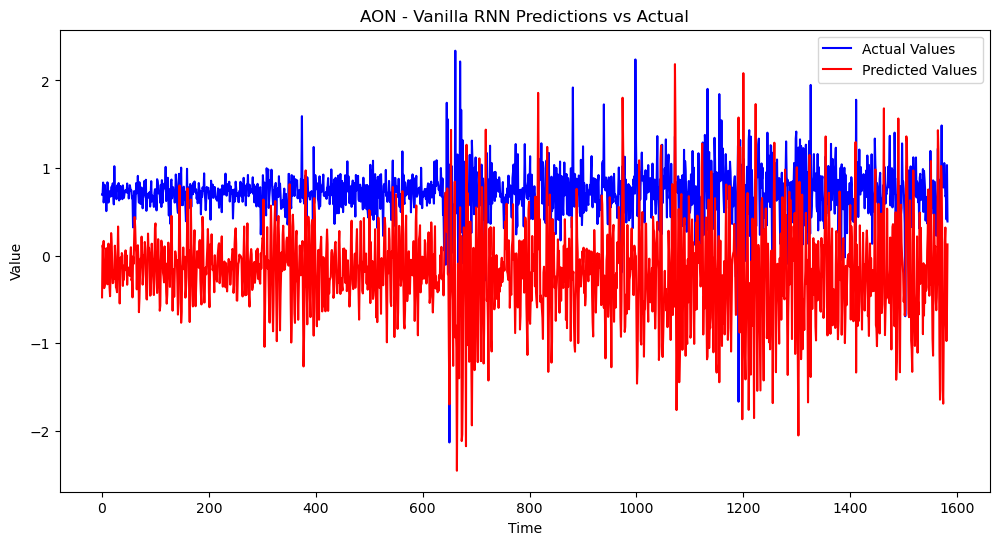

32/32 [==============================] - 1s 30ms/step
POOL - Vanilla RNN - RMSE: 2.16292, MAE: 1.79223, MAPE: 926.74%


<Figure size 640x480 with 0 Axes>

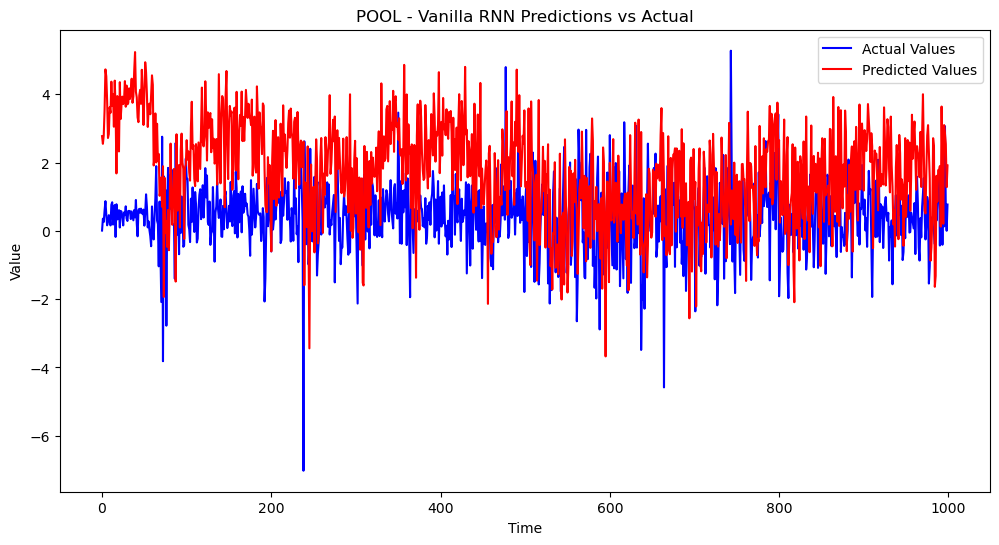

10/10 [==============================] - 1s 26ms/step
VYGVQ - Vanilla RNN - RMSE: 0.42044, MAE: 0.42037, MAPE: 84.13%


<Figure size 640x480 with 0 Axes>

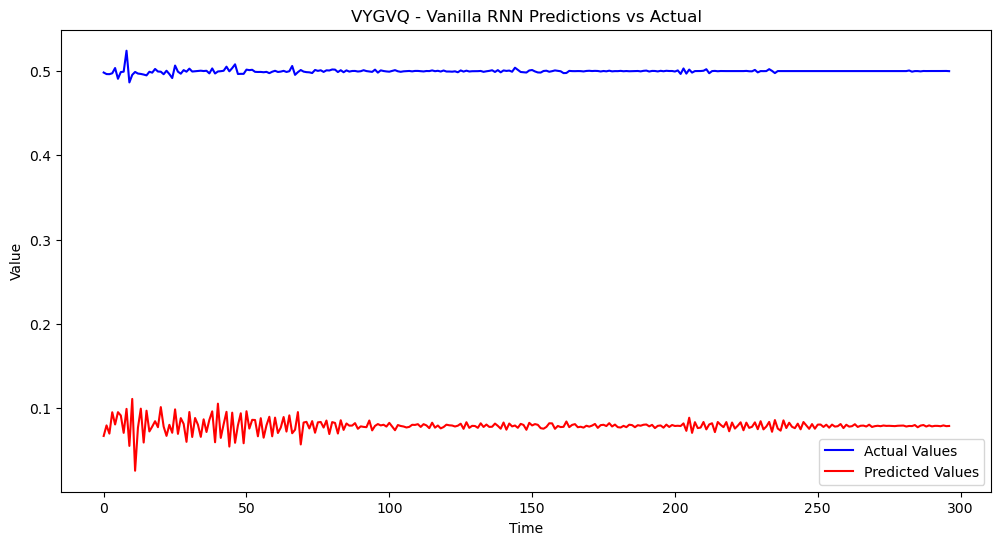

<Figure size 640x480 with 0 Axes>

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate metrics
def calculate_metrics(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted) * 100  # Convert to percentage
    return rmse, mae, mape

# Function to plot predictions
def plot_predictions(actual, predicted, title):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Values', color='blue')
    plt.plot(predicted, label='Predicted Values', color='red')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# After the optimization process is complete
for symbol, model in final_models.items():
    # Load the test data
    test_sequences, test_labels = test_data[symbol]

    # Predictions
    predicted = model.predict(test_sequences).flatten()
    actual = test_labels.flatten()

    # Calculate metrics
    rmse, mae, mape = calculate_metrics(actual, predicted)

    # Print metrics
    print(f"{symbol} - Vanilla RNN - RMSE: {rmse:.5f}, MAE: {mae:.5f}, MAPE: {mape:.2f}%")

    # Plot predictions
    title = f"{symbol} - Vanilla RNN Predictions vs Actual"
    plot_predictions(actual, predicted, title)

    # Save the plot
    plt.savefig(f"{symbol}_vanilla_rnn_predictions_vs_actual.png")



In [31]:
import optuna
from optuna.pruners import MedianPruner
from tensorflow.keras.layers import LSTM, GRU, LayerNormalization, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import optuna.visualization as ov
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras import backend as K

def build_model(trial, model_type, input_shape):
    # Hyperparameters to be optimized
    units = trial.suggest_categorical('units', [50, 100, 150])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Model building
    model = Sequential()
    if model_type == 'lstm':
        model.add(LSTM(units, input_shape=input_shape, return_sequences=True))
        model.add(LayerNormalization())
        model.add(LSTM(units))
    elif model_type == 'gru':
        model.add(GRU(units, input_shape=input_shape, return_sequences=True))
        model.add(LayerNormalization())
        model.add(GRU(units))

    model.add(LayerNormalization())
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    return model, batch_size

def objective(trial, model_type, symbol):
    # Clear TensorFlow session
    K.clear_session()

    # Build the model
    model, batch_size = build_model(trial, model_type, input_shape=(sequence_length, 1))

    # Load the dataset
    train_sequences, train_labels = train_data[symbol]
    val_sequences, val_labels = validation_data[symbol]

    # Early stopping and ModelCheckpoint callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'best_model_{symbol}_{model_type}.h5', save_best_only=True)
    
    # Pruning callback
    pruning_callback = TFKerasPruningCallback(trial, 'val_loss')

    # Train the model
    history = model.fit(
        train_sequences,
        train_labels,
        epochs=50,
        batch_size=batch_size,
        validation_data=(val_sequences, val_labels),
        callbacks=[early_stopping, model_checkpoint, pruning_callback],
        verbose=1
    )

    # Evaluate the model on the validation set
    val_loss = min(history.history['val_loss'])
    return val_loss


# Number of trials and epochs
n_trials = 25
epochs = 50

# Run separate studies for each stock and model type
final_models = {}
for symbol in ['AON', 'POOL', 'VYGVQ']:
    for model_type in ['lstm', 'gru']:
        print(f"Optimizing {model_type} model for {symbol}")

        # Create a pruner and a study
        pruner = MedianPruner()
        study = optuna.create_study(direction='minimize', pruner=pruner)
        study.optimize(lambda trial: objective(trial, model_type, symbol), n_trials=n_trials)

        # Visualization after each study
        ov.plot_optimization_history(study)
        ov.plot_param_importances(study)

        # Retrieve the best model
        best_trial = study.best_trial
        best_model = build_model(best_trial, model_type, input_shape=(sequence_length, 1))[0]
        final_models[(symbol, model_type)] = best_model

        # Print the best parameters and loss for each model and stock
        print(f"Best {model_type} model for {symbol}:")
        print(f"  Loss: {best_trial.value}")
        print(f"  Params: {best_trial.params}")

# Print out the best parameters and performance for each model and stock
for (symbol, model_type), model in final_models.items():
    print(f"Best {model_type} model for {symbol} has been saved.")


[I 2023-11-21 00:04:29,349] A new study created in memory with name: no-name-5fb16b4f-82b3-4033-9e89-d147b4dc93bb


Optimizing lstm model for AON
Epoch 1/50
60/60 [==============================] - 32s 326ms/step - loss: 0.7223 - val_loss: 0.0058
Epoch 2/50


C:\Users\nikhi\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



60/60 [==============================] - 16s 261ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 3/50
60/60 [==============================] - 18s 295ms/step - loss: 9.8629e-04 - val_loss: 0.0046
Epoch 4/50
60/60 [==============================] - 18s 301ms/step - loss: 9.8320e-04 - val_loss: 0.0046
Epoch 5/50
60/60 [==============================] - 21s 352ms/step - loss: 9.8557e-04 - val_loss: 0.0046


[I 2023-11-21 00:06:15,859] Trial 0 finished with value: 0.004566457588225603 and parameters: {'units': 50, 'dropout_rate': 0.28446990135067063, 'learning_rate': 0.00012580455300962597, 'batch_size': 128}. Best is trial 0 with value: 0.004566457588225603.


Epoch 1/50
238/238 [==============================] - 36s 104ms/step - loss: 0.0149 - val_loss: 0.0046
Epoch 2/50
238/238 [==============================] - 21s 88ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 3/50
238/238 [==============================] - 22s 94ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 4/50
238/238 [==============================] - 21s 88ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 5/50
238/238 [==============================] - 21s 90ms/step - loss: 0.0012 - val_loss: 0.0052


[I 2023-11-21 00:08:20,235] Trial 1 finished with value: 0.0045503429137170315 and parameters: {'units': 50, 'dropout_rate': 0.38301427655411346, 'learning_rate': 0.00039368615700453565, 'batch_size': 32}. Best is trial 1 with value: 0.0045503429137170315.


Epoch 1/50
119/119 [==============================] - 117s 897ms/step - loss: 1.0240 - val_loss: 0.0045
Epoch 2/50
119/119 [==============================] - 95s 801ms/step - loss: 9.9417e-04 - val_loss: 0.0045
Epoch 3/50
119/119 [==============================] - 102s 860ms/step - loss: 9.8064e-04 - val_loss: 0.0045
Epoch 4/50
119/119 [==============================] - 121s 1s/step - loss: 9.9101e-04 - val_loss: 0.0045


[I 2023-11-21 00:15:36,841] Trial 2 finished with value: 0.0044769104570150375 and parameters: {'units': 150, 'dropout_rate': 0.32754824686520095, 'learning_rate': 0.006495477139229474, 'batch_size': 64}. Best is trial 2 with value: 0.0044769104570150375.


Epoch 1/50
60/60 [==============================] - 81s 1s/step - loss: 1.6405 - val_loss: 0.0060
Epoch 2/50
60/60 [==============================] - 74s 1s/step - loss: 0.0011 - val_loss: 0.0045
Epoch 3/50
60/60 [==============================] - 62s 1s/step - loss: 9.6789e-04 - val_loss: 0.0045
Epoch 4/50
60/60 [==============================] - 69s 1s/step - loss: 9.6124e-04 - val_loss: 0.0045
Epoch 5/50
60/60 [==============================] - 60s 994ms/step - loss: 9.7864e-04 - val_loss: 0.0045
Epoch 6/50
60/60 [==============================] - 51s 856ms/step - loss: 9.6890e-04 - val_loss: 0.0045
Epoch 7/50
60/60 [==============================] - 59s 980ms/step - loss: 9.6441e-04 - val_loss: 0.0045
Epoch 8/50
60/60 [==============================] - 55s 911ms/step - loss: 9.7634e-04 - val_loss: 0.0045
Epoch 9/50
60/60 [==============================] - 58s 961ms/step - loss: 9.7159e-04 - val_loss: 0.0045
Epoch 10/50
60/60 [==============================] - 73s 1s/step - loss: 9.

[I 2023-11-21 00:26:20,839] Trial 3 finished with value: 0.0044776215218007565 and parameters: {'units': 100, 'dropout_rate': 0.32752875505490603, 'learning_rate': 0.0093814535337707, 'batch_size': 128}. Best is trial 2 with value: 0.0044769104570150375.


Epoch 1/50
119/119 [==============================] - 161s 1s/step - loss: 0.4087 - val_loss: 0.0045
Epoch 2/50
119/119 [==============================] - 155s 1s/step - loss: 9.8516e-04 - val_loss: 0.0045
Epoch 3/50
119/119 [==============================] - 148s 1s/step - loss: 9.8057e-04 - val_loss: 0.0045
Epoch 4/50
119/119 [==============================] - 161s 1s/step - loss: 9.9426e-04 - val_loss: 0.0045
Epoch 5/50
119/119 [==============================] - 152s 1s/step - loss: 0.0010 - val_loss: 0.0045
Epoch 6/50
119/119 [==============================] - 151s 1s/step - loss: 9.8943e-04 - val_loss: 0.0046
Epoch 7/50
119/119 [==============================] - 149s 1s/step - loss: 0.0010 - val_loss: 0.0045


[I 2023-11-21 00:44:20,025] Trial 4 finished with value: 0.004496833775192499 and parameters: {'units': 150, 'dropout_rate': 0.3063756506950892, 'learning_rate': 0.0008498027514923547, 'batch_size': 64}. Best is trial 2 with value: 0.0044769104570150375.


Epoch 1/50
238/238 [==============================] - 41s 124ms/step - loss: 0.0226 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 26s 111ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 31s 132ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 4/50
238/238 [==============================] - 26s 107ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 5/50
238/238 [==============================] - 26s 110ms/step - loss: 0.0012 - val_loss: 0.0052


[I 2023-11-21 00:46:53,837] Trial 5 finished with value: 0.004464792087674141 and parameters: {'units': 50, 'dropout_rate': 0.180108254592673, 'learning_rate': 0.001540172887903835, 'batch_size': 32}. Best is trial 5 with value: 0.004464792087674141.


Epoch 1/50
119/119 [==============================] - 144s 1s/step - loss: 0.1071 - val_loss: 0.0045
Epoch 2/50
119/119 [==============================] - ETA: 0s - loss: 0.0010

[I 2023-11-21 00:51:26,111] Trial 6 pruned. Trial was pruned at epoch 1.


Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 1.7475

[I 2023-11-21 00:52:16,488] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.5678

[I 2023-11-21 00:53:38,940] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.0095

[I 2023-11-21 00:55:01,700] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/50
238/238 [==============================] - 42s 140ms/step - loss: 0.0086 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 32s 134ms/step - loss: 9.7333e-04 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 29s 123ms/step - loss: 9.7201e-04 - val_loss: 0.0045
Epoch 4/50
238/238 [==============================] - 30s 128ms/step - loss: 9.7621e-04 - val_loss: 0.0045


[I 2023-11-21 00:57:16,942] Trial 10 finished with value: 0.004482957534492016 and parameters: {'units': 50, 'dropout_rate': 0.1380404070599141, 'learning_rate': 2.3724931988833908e-05, 'batch_size': 32}. Best is trial 5 with value: 0.004464792087674141.


Epoch 1/50
119/119 [==============================] - ETA: 0s - loss: 0.1484

[I 2023-11-21 00:57:58,191] Trial 11 pruned. Trial was pruned at epoch 0.


Epoch 1/50
238/238 [==============================] - 242s 974ms/step - loss: 0.2495 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 218s 915ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 212s 890ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 4/50
238/238 [==============================] - 232s 975ms/step - loss: 0.0011 - val_loss: 0.0047


[I 2023-11-21 01:13:03,993] Trial 12 finished with value: 0.004478302784264088 and parameters: {'units': 150, 'dropout_rate': 0.1256755134074838, 'learning_rate': 0.0020742245554648546, 'batch_size': 32}. Best is trial 5 with value: 0.004464792087674141.


Epoch 1/50
238/238 [==============================] - ETA: 0s - loss: 0.0993

[I 2023-11-21 01:14:21,522] Trial 13 pruned. Trial was pruned at epoch 0.


Epoch 1/50
119/119 [==============================] - 112s 855ms/step - loss: 0.2442 - val_loss: 0.0045
Epoch 2/50
119/119 [==============================] - 89s 752ms/step - loss: 9.8864e-04 - val_loss: 0.0045
Epoch 3/50
119/119 [==============================] - 94s 791ms/step - loss: 9.7902e-04 - val_loss: 0.0045
Epoch 4/50
119/119 [==============================] - 87s 736ms/step - loss: 9.9047e-04 - val_loss: 0.0045
Epoch 5/50
119/119 [==============================] - 90s 756ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 6/50
119/119 [==============================] - 81s 681ms/step - loss: 9.8524e-04 - val_loss: 0.0045


[I 2023-11-21 01:23:36,879] Trial 14 finished with value: 0.004474947229027748 and parameters: {'units': 100, 'dropout_rate': 0.364918735896108, 'learning_rate': 0.001230600125336096, 'batch_size': 64}. Best is trial 5 with value: 0.004464792087674141.


Epoch 1/50
119/119 [==============================] - ETA: 0s - loss: 0.2319

[I 2023-11-21 01:25:38,763] Trial 15 pruned. Trial was pruned at epoch 0.


Epoch 1/50
238/238 [==============================] - ETA: 0s - loss: 0.0215

[I 2023-11-21 01:27:34,232] Trial 16 pruned. Trial was pruned at epoch 0.


Epoch 1/50
119/119 [==============================] - 98s 736ms/step - loss: 0.3812 - val_loss: 0.0045
Epoch 2/50
119/119 [==============================] - 67s 567ms/step - loss: 9.8507e-04 - val_loss: 0.0045
Epoch 3/50
119/119 [==============================] - 60s 508ms/step - loss: 9.7778e-04 - val_loss: 0.0045
Epoch 4/50
119/119 [==============================] - 60s 502ms/step - loss: 9.9415e-04 - val_loss: 0.0045


[I 2023-11-21 01:32:58,723] Trial 17 finished with value: 0.004467130638659 and parameters: {'units': 100, 'dropout_rate': 0.24910339425766637, 'learning_rate': 0.001683851855113572, 'batch_size': 64}. Best is trial 5 with value: 0.004464792087674141.


Epoch 1/50
238/238 [==============================] - 123s 414ms/step - loss: 0.3003 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 118s 494ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 107s 448ms/step - loss: 0.0010 - val_loss: 0.0048
Epoch 4/50
238/238 [==============================] - 113s 475ms/step - loss: 0.0011 - val_loss: 0.0047


[I 2023-11-21 01:40:40,809] Trial 18 finished with value: 0.004470537416636944 and parameters: {'units': 100, 'dropout_rate': 0.24717635284492737, 'learning_rate': 0.0034492494566045625, 'batch_size': 32}. Best is trial 5 with value: 0.004464792087674141.


Epoch 1/50
119/119 [==============================] - ETA: 0s - loss: 0.0995

[I 2023-11-21 01:41:33,445] Trial 19 pruned. Trial was pruned at epoch 0.


Epoch 1/50
238/238 [==============================] - 44s 141ms/step - loss: 0.0215 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 35s 145ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 33s 139ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 4/50
238/238 [==============================] - 34s 143ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 5/50
238/238 [==============================] - 32s 136ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 6/50
238/238 [==============================] - 32s 135ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 7/50
238/238 [==============================] - 33s 141ms/step - loss: 0.0012 - val_loss: 0.0055
Epoch 8/50
238/238 [==============================] - 32s 136ms/step - loss: 0.0011 - val_loss: 0.0058
Epoch 9/50
238/238 [==============================] - 32s 133ms/step - loss: 0.0013 - val_loss: 0.0045


[I 2023-11-21 01:46:42,475] Trial 20 finished with value: 0.004474501125514507 and parameters: {'units': 50, 'dropout_rate': 0.10744705800246442, 'learning_rate': 0.0006420262691854174, 'batch_size': 32}. Best is trial 5 with value: 0.004464792087674141.


Epoch 1/50
238/238 [==============================] - ETA: 0s - loss: 0.2650

[I 2023-11-21 01:48:34,418] Trial 21 pruned. Trial was pruned at epoch 0.


Epoch 1/50
238/238 [==============================] - 111s 421ms/step - loss: 0.3301 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 130s 547ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 103s 434ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 4/50
238/238 [==============================] - 97s 409ms/step - loss: 0.0011 - val_loss: 0.0046


[I 2023-11-21 01:55:57,810] Trial 22 finished with value: 0.004475172609090805 and parameters: {'units': 100, 'dropout_rate': 0.22656624745825654, 'learning_rate': 0.004229549453128546, 'batch_size': 32}. Best is trial 5 with value: 0.004464792087674141.


Epoch 1/50
238/238 [==============================] - 167s 562ms/step - loss: 0.1342 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 146s 615ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 112s 473ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 4/50
238/238 [==============================] - 100s 421ms/step - loss: 0.0011 - val_loss: 0.0047


[I 2023-11-21 02:04:48,537] Trial 23 finished with value: 0.004476791713386774 and parameters: {'units': 100, 'dropout_rate': 0.1813626608448597, 'learning_rate': 0.0017157429848279233, 'batch_size': 32}. Best is trial 5 with value: 0.004464792087674141.


Epoch 1/50
238/238 [==============================] - ETA: 0s - loss: 0.2188

[I 2023-11-21 02:07:04,871] Trial 24 pruned. Trial was pruned at epoch 0.
[I 2023-11-21 02:07:07,554] A new study created in memory with name: no-name-629a8f5f-ca7f-41ed-ae2f-3ff2319139c8


Best lstm model for AON:
  Loss: 0.004464792087674141
  Params: {'units': 50, 'dropout_rate': 0.180108254592673, 'learning_rate': 0.001540172887903835, 'batch_size': 32}
Optimizing gru model for AON
Epoch 1/50
119/119 [==============================] - 86s 625ms/step - loss: 0.2236 - val_loss: 0.0046
Epoch 2/50


C:\Users\nikhi\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



119/119 [==============================] - 66s 552ms/step - loss: 9.7280e-04 - val_loss: 0.0046
Epoch 3/50
119/119 [==============================] - 71s 599ms/step - loss: 9.7015e-04 - val_loss: 0.0046
Epoch 4/50
119/119 [==============================] - 69s 576ms/step - loss: 9.6833e-04 - val_loss: 0.0046
Epoch 5/50
119/119 [==============================] - 69s 578ms/step - loss: 9.6947e-04 - val_loss: 0.0045
Epoch 6/50
119/119 [==============================] - 57s 475ms/step - loss: 9.6662e-04 - val_loss: 0.0045
Epoch 7/50
119/119 [==============================] - 48s 402ms/step - loss: 9.6738e-04 - val_loss: 0.0045
Epoch 8/50
119/119 [==============================] - 40s 333ms/step - loss: 9.6673e-04 - val_loss: 0.0045
Epoch 9/50
119/119 [==============================] - 50s 420ms/step - loss: 9.6491e-04 - val_loss: 0.0045
Epoch 10/50
119/119 [==============================] - 42s 354ms/step - loss: 9.6518e-04 - val_loss: 0.0046


[I 2023-11-21 02:17:04,908] Trial 0 finished with value: 0.004516803193837404 and parameters: {'units': 100, 'dropout_rate': 0.20418936930110335, 'learning_rate': 1.4781436553909075e-05, 'batch_size': 64}. Best is trial 0 with value: 0.004516803193837404.


Epoch 1/50
60/60 [==============================] - 27s 258ms/step - loss: 0.2132 - val_loss: 0.0060
Epoch 2/50
60/60 [==============================] - 13s 222ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 3/50
60/60 [==============================] - 14s 229ms/step - loss: 9.6558e-04 - val_loss: 0.0045
Epoch 4/50
60/60 [==============================] - 14s 228ms/step - loss: 9.6125e-04 - val_loss: 0.0045
Epoch 5/50
60/60 [==============================] - 13s 217ms/step - loss: 9.7058e-04 - val_loss: 0.0046
Epoch 6/50
60/60 [==============================] - 14s 230ms/step - loss: 9.7150e-04 - val_loss: 0.0045


[I 2023-11-21 02:18:40,461] Trial 1 finished with value: 0.004497230052947998 and parameters: {'units': 50, 'dropout_rate': 0.17740903053905244, 'learning_rate': 0.002116070101933562, 'batch_size': 128}. Best is trial 1 with value: 0.004497230052947998.


Epoch 1/50
60/60 [==============================] - 77s 1s/step - loss: 0.0019 - val_loss: 0.0046
Epoch 2/50
60/60 [==============================] - 61s 1s/step - loss: 9.7918e-04 - val_loss: 0.0045
Epoch 3/50
60/60 [==============================] - 63s 1s/step - loss: 9.7988e-04 - val_loss: 0.0046
Epoch 4/50
60/60 [==============================] - 63s 1s/step - loss: 9.7708e-04 - val_loss: 0.0045
Epoch 5/50
60/60 [==============================] - 66s 1s/step - loss: 9.8683e-04 - val_loss: 0.0046
Epoch 6/50
60/60 [==============================] - 65s 1s/step - loss: 9.9750e-04 - val_loss: 0.0045
Epoch 7/50
60/60 [==============================] - 66s 1s/step - loss: 9.8476e-04 - val_loss: 0.0045
Epoch 8/50
60/60 [==============================] - 69s 1s/step - loss: 0.0010 - val_loss: 0.0045
Epoch 9/50
60/60 [==============================] - 67s 1s/step - loss: 9.7762e-04 - val_loss: 0.0046
Epoch 10/50
60/60 [==============================] - 67s 1s/step - loss: 0.0010 - val_loss

[I 2023-11-21 02:29:46,375] Trial 2 finished with value: 0.004496385343372822 and parameters: {'units': 150, 'dropout_rate': 0.48840144195363844, 'learning_rate': 2.240601359676024e-05, 'batch_size': 128}. Best is trial 2 with value: 0.004496385343372822.


Epoch 1/50
238/238 [==============================] - 193s 695ms/step - loss: 0.1372 - val_loss: 0.0046
Epoch 2/50
238/238 [==============================] - 166s 695ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 191s 802ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 4/50
238/238 [==============================] - 205s 862ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 5/50
238/238 [==============================] - 202s 848ms/step - loss: 0.0011 - val_loss: 0.0046


[I 2023-11-21 02:45:43,671] Trial 3 finished with value: 0.004487911704927683 and parameters: {'units': 150, 'dropout_rate': 0.4985619100658807, 'learning_rate': 0.0006453766023719356, 'batch_size': 32}. Best is trial 3 with value: 0.004487911704927683.


Epoch 1/50
60/60 [==============================] - 28s 340ms/step - loss: 0.5275 - val_loss: 0.0048
Epoch 2/50
60/60 [==============================] - 19s 316ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 3/50
60/60 [==============================] - 19s 313ms/step - loss: 9.7003e-04 - val_loss: 0.0045
Epoch 4/50
60/60 [==============================] - 18s 306ms/step - loss: 9.6249e-04 - val_loss: 0.0045
Epoch 5/50
60/60 [==============================] - 19s 310ms/step - loss: 9.7918e-04 - val_loss: 0.0045
Epoch 6/50
60/60 [==============================] - 19s 319ms/step - loss: 9.7024e-04 - val_loss: 0.0045
Epoch 7/50
60/60 [==============================] - 19s 323ms/step - loss: 9.6516e-04 - val_loss: 0.0045
Epoch 8/50
60/60 [==============================] - 18s 303ms/step - loss: 9.7717e-04 - val_loss: 0.0045
Epoch 9/50
60/60 [==============================] - 18s 304ms/step - loss: 9.7166e-04 - val_loss: 0.0045
Epoch 10/50
60/60 [==============================] - 18s 307ms/

[I 2023-11-21 02:49:00,779] Trial 4 finished with value: 0.00447587575763464 and parameters: {'units': 50, 'dropout_rate': 0.39694108789425253, 'learning_rate': 0.008292706047349665, 'batch_size': 128}. Best is trial 4 with value: 0.00447587575763464.


Epoch 1/50
238/238 [==============================] - 164s 661ms/step - loss: 0.1369 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 158s 665ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 157s 658ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 4/50
238/238 [==============================] - 156s 653ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 5/50
238/238 [==============================] - 156s 655ms/step - loss: 0.0011 - val_loss: 0.0047


[I 2023-11-21 03:02:12,422] Trial 5 finished with value: 0.004473128821700811 and parameters: {'units': 150, 'dropout_rate': 0.47969134179370276, 'learning_rate': 0.000948324646773904, 'batch_size': 32}. Best is trial 5 with value: 0.004473128821700811.


Epoch 1/50
238/238 [==============================] - 85s 325ms/step - loss: 0.6596 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 76s 319ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 75s 316ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 4/50
238/238 [==============================] - 75s 315ms/step - loss: 0.0011 - val_loss: 0.0045


[I 2023-11-21 03:07:24,516] Trial 6 finished with value: 0.004490990657359362 and parameters: {'units': 100, 'dropout_rate': 0.2004249219603846, 'learning_rate': 0.00764297969406207, 'batch_size': 32}. Best is trial 5 with value: 0.004473128821700811.


Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.4004

[I 2023-11-21 03:09:02,290] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.2815

[I 2023-11-21 03:09:39,252] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.3329

[I 2023-11-21 03:10:06,067] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/50
238/238 [==============================] - ETA: 0s - loss: 0.0106

[I 2023-11-21 03:12:52,981] Trial 10 pruned. Trial was pruned at epoch 0.


Epoch 1/50
119/119 [==============================] - 26s 166ms/step - loss: 0.4435 - val_loss: 0.0045
Epoch 2/50
119/119 [==============================] - 19s 158ms/step - loss: 9.7831e-04 - val_loss: 0.0045
Epoch 3/50
119/119 [==============================] - 18s 155ms/step - loss: 9.7613e-04 - val_loss: 0.0045
Epoch 4/50
119/119 [==============================] - 18s 155ms/step - loss: 9.7403e-04 - val_loss: 0.0045
Epoch 5/50
119/119 [==============================] - 18s 154ms/step - loss: 9.7471e-04 - val_loss: 0.0045
Epoch 6/50
119/119 [==============================] - 18s 149ms/step - loss: 9.9879e-04 - val_loss: 0.0045
Epoch 7/50
119/119 [==============================] - 19s 156ms/step - loss: 9.8848e-04 - val_loss: 0.0045
Epoch 8/50
119/119 [==============================] - 18s 150ms/step - loss: 9.8996e-04 - val_loss: 0.0045
Epoch 9/50
119/119 [==============================] - 18s 155ms/step - loss: 9.8783e-04 - val_loss: 0.0045


[I 2023-11-21 03:15:45,693] Trial 11 finished with value: 0.004491797182708979 and parameters: {'units': 50, 'dropout_rate': 0.4093250254771787, 'learning_rate': 0.006780824385679503, 'batch_size': 64}. Best is trial 5 with value: 0.004473128821700811.


Epoch 1/50
238/238 [==============================] - 163s 659ms/step - loss: 0.3335 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - ETA: 0s - loss: 0.0010

[I 2023-11-21 03:21:02,494] Trial 12 pruned. Trial was pruned at epoch 1.


Epoch 1/50
238/238 [==============================] - 36s 119ms/step - loss: 0.2331 - val_loss: 0.0046
Epoch 2/50
238/238 [==============================] - 25s 104ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 24s 102ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 4/50
238/238 [==============================] - 24s 102ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 5/50
238/238 [==============================] - 26s 107ms/step - loss: 0.0011 - val_loss: 0.0047


[I 2023-11-21 03:23:18,742] Trial 13 finished with value: 0.004481114912778139 and parameters: {'units': 50, 'dropout_rate': 0.37878984267828575, 'learning_rate': 0.009701770379444507, 'batch_size': 32}. Best is trial 5 with value: 0.004473128821700811.


Epoch 1/50
119/119 [==============================] - 77s 601ms/step - loss: 0.0276 - val_loss: 0.0045
Epoch 2/50
119/119 [==============================] - 69s 584ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 3/50
119/119 [==============================] - 68s 568ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 4/50
119/119 [==============================] - 64s 537ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 5/50
119/119 [==============================] - 65s 544ms/step - loss: 0.0011 - val_loss: 0.0045


[I 2023-11-21 03:29:02,500] Trial 14 finished with value: 0.0044954088516533375 and parameters: {'units': 100, 'dropout_rate': 0.4459930517880225, 'learning_rate': 0.0005149946964481881, 'batch_size': 64}. Best is trial 5 with value: 0.004473128821700811.


Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 2.8314

[I 2023-11-21 03:30:44,738] Trial 15 pruned. Trial was pruned at epoch 0.


Epoch 1/50
238/238 [==============================] - 38s 134ms/step - loss: 0.0135 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 30s 124ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 29s 120ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 4/50
238/238 [==============================] - 30s 126ms/step - loss: 0.0011 - val_loss: 0.0046


[I 2023-11-21 03:32:51,607] Trial 16 finished with value: 0.004479947965592146 and parameters: {'units': 50, 'dropout_rate': 0.10701960474018615, 'learning_rate': 0.00032602369829476695, 'batch_size': 32}. Best is trial 5 with value: 0.004473128821700811.


Epoch 1/50
238/238 [==============================] - 37s 130ms/step - loss: 0.0963 - val_loss: 0.0045
Epoch 2/50
238/238 [==============================] - 30s 126ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 3/50
238/238 [==============================] - 30s 125ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 4/50
238/238 [==============================] - 30s 126ms/step - loss: 0.0010 - val_loss: 0.0045


[I 2023-11-21 03:34:58,863] Trial 17 finished with value: 0.00448968168348074 and parameters: {'units': 50, 'dropout_rate': 0.3838689295944594, 'learning_rate': 0.003985553241860434, 'batch_size': 32}. Best is trial 5 with value: 0.004473128821700811.


Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 1.1697

[I 2023-11-21 03:36:47,703] Trial 18 pruned. Trial was pruned at epoch 0.


Epoch 1/50
119/119 [==============================] - ETA: 0s - loss: 0.5530

[I 2023-11-21 03:38:05,739] Trial 19 pruned. Trial was pruned at epoch 0.


Epoch 1/50
60/60 [==============================] - 103s 2s/step - loss: 1.1933 - val_loss: 0.0045
Epoch 2/50
60/60 [==============================] - 95s 2s/step - loss: 0.0016 - val_loss: 0.0045
Epoch 3/50
60/60 [==============================] - 95s 2s/step - loss: 9.6423e-04 - val_loss: 0.0045
Epoch 4/50
60/60 [==============================] - 94s 2s/step - loss: 9.5890e-04 - val_loss: 0.0045
Epoch 5/50
60/60 [==============================] - 94s 2s/step - loss: 9.7715e-04 - val_loss: 0.0045
Epoch 6/50
60/60 [==============================] - 95s 2s/step - loss: 9.6332e-04 - val_loss: 0.0045
Epoch 7/50
60/60 [==============================] - 94s 2s/step - loss: 9.6011e-04 - val_loss: 0.0045
Epoch 8/50
60/60 [==============================] - 94s 2s/step - loss: 9.6914e-04 - val_loss: 0.0045
Epoch 9/50
60/60 [==============================] - 96s 2s/step - loss: 9.6825e-04 - val_loss: 0.0045
Epoch 10/50
60/60 [==============================] - 95s 2s/step - loss: 9.7185e-04 - val

[I 2023-11-21 03:54:00,269] Trial 20 finished with value: 0.004472009837627411 and parameters: {'units': 150, 'dropout_rate': 0.49609998429359226, 'learning_rate': 0.0011684007872484474, 'batch_size': 128}. Best is trial 20 with value: 0.004472009837627411.


Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.5758

[I 2023-11-21 03:55:42,112] Trial 21 pruned. Trial was pruned at epoch 0.


Epoch 1/50
60/60 [==============================] - 98s 2s/step - loss: 1.4297 - val_loss: 0.0045
Epoch 2/50
60/60 [==============================] - 93s 2s/step - loss: 9.8220e-04 - val_loss: 0.0045
Epoch 3/50
60/60 [==============================] - 93s 2s/step - loss: 9.6773e-04 - val_loss: 0.0045
Epoch 4/50
60/60 [==============================] - 92s 2s/step - loss: 9.6585e-04 - val_loss: 0.0045
Epoch 5/50
60/60 [==============================] - 92s 2s/step - loss: 9.7239e-04 - val_loss: 0.0045
Epoch 6/50
60/60 [==============================] - 92s 2s/step - loss: 9.7160e-04 - val_loss: 0.0045
Epoch 7/50
60/60 [==============================] - ETA: 0s - loss: 9.7016e-04

[I 2023-11-21 04:06:35,552] Trial 22 pruned. Trial was pruned at epoch 6.


Epoch 1/50
60/60 [==============================] - 97s 2s/step - loss: 3.3663 - val_loss: 0.0045
Epoch 2/50
60/60 [==============================] - 87s 1s/step - loss: 9.7133e-04 - val_loss: 0.0045
Epoch 3/50
60/60 [==============================] - 90s 1s/step - loss: 9.6124e-04 - val_loss: 0.0045
Epoch 4/50
60/60 [==============================] - 89s 1s/step - loss: 9.6513e-04 - val_loss: 0.0045
Epoch 5/50
60/60 [==============================] - 88s 1s/step - loss: 9.7034e-04 - val_loss: 0.0045


[I 2023-11-21 04:14:07,764] Trial 23 finished with value: 0.004483853932470083 and parameters: {'units': 150, 'dropout_rate': 0.455485904710284, 'learning_rate': 0.00593329567957597, 'batch_size': 128}. Best is trial 20 with value: 0.004472009837627411.


Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 2.9919

[I 2023-11-21 04:15:58,456] Trial 24 pruned. Trial was pruned at epoch 0.
[I 2023-11-21 04:15:59,576] A new study created in memory with name: no-name-1a834587-69dc-4389-8e2d-dd7b303e1601


Best gru model for AON:
  Loss: 0.004472009837627411
  Params: {'units': 150, 'dropout_rate': 0.49609998429359226, 'learning_rate': 0.0011684007872484474, 'batch_size': 128}
Optimizing lstm model for POOL
Epoch 1/50
77/77 [==============================] - 115s 1s/step - loss: 1.8163 - val_loss: 0.0423
Epoch 2/50


C:\Users\nikhi\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



77/77 [==============================] - 105s 1s/step - loss: 0.0027 - val_loss: 0.0427
Epoch 3/50
77/77 [==============================] - 106s 1s/step - loss: 0.0027 - val_loss: 0.0425
Epoch 4/50
77/77 [==============================] - 105s 1s/step - loss: 0.0027 - val_loss: 0.0430


[I 2023-11-21 04:23:12,036] Trial 0 finished with value: 0.04234478622674942 and parameters: {'units': 150, 'dropout_rate': 0.3536118637069169, 'learning_rate': 0.002647059084863746, 'batch_size': 64}. Best is trial 0 with value: 0.04234478622674942.


Epoch 1/50
39/39 [==============================] - 53s 1s/step - loss: 0.1565 - val_loss: 0.0611
Epoch 2/50
39/39 [==============================] - 45s 1s/step - loss: 0.0049 - val_loss: 0.0479
Epoch 3/50
39/39 [==============================] - 45s 1s/step - loss: 0.0028 - val_loss: 0.0473
Epoch 4/50
39/39 [==============================] - 46s 1s/step - loss: 0.0028 - val_loss: 0.0467
Epoch 5/50
39/39 [==============================] - 46s 1s/step - loss: 0.0028 - val_loss: 0.0462
Epoch 6/50
39/39 [==============================] - 45s 1s/step - loss: 0.0028 - val_loss: 0.0460
Epoch 7/50
39/39 [==============================] - 46s 1s/step - loss: 0.0028 - val_loss: 0.0455
Epoch 8/50
39/39 [==============================] - 45s 1s/step - loss: 0.0028 - val_loss: 0.0449
Epoch 9/50
39/39 [==============================] - 45s 1s/step - loss: 0.0027 - val_loss: 0.0446
Epoch 10/50
39/39 [==============================] - 44s 1s/step - loss: 0.0027 - val_loss: 0.0447
Epoch 11/50
39/39 [

[I 2023-11-21 04:35:24,920] Trial 1 finished with value: 0.04384840279817581 and parameters: {'units': 150, 'dropout_rate': 0.2364011199122087, 'learning_rate': 8.2424539800965e-05, 'batch_size': 128}. Best is trial 0 with value: 0.04234478622674942.


Epoch 1/50
153/153 [==============================] - 61s 360ms/step - loss: 0.2071 - val_loss: 0.0450
Epoch 2/50
153/153 [==============================] - 56s 362ms/step - loss: 0.0028 - val_loss: 0.0448
Epoch 3/50
153/153 [==============================] - 53s 346ms/step - loss: 0.0028 - val_loss: 0.0447
Epoch 4/50
153/153 [==============================] - 52s 339ms/step - loss: 0.0027 - val_loss: 0.0446
Epoch 5/50
153/153 [==============================] - 52s 338ms/step - loss: 0.0028 - val_loss: 0.0440
Epoch 6/50
153/153 [==============================] - 52s 342ms/step - loss: 0.0028 - val_loss: 0.0437
Epoch 7/50
153/153 [==============================] - 54s 352ms/step - loss: 0.0027 - val_loss: 0.0436
Epoch 8/50
153/153 [==============================] - 53s 346ms/step - loss: 0.0028 - val_loss: 0.0434
Epoch 9/50
153/153 [==============================] - 52s 342ms/step - loss: 0.0028 - val_loss: 0.0437
Epoch 10/50
153/153 [==============================] - 52s 340ms/step - l

[I 2023-11-21 04:49:36,950] Trial 2 finished with value: 0.042905498296022415 and parameters: {'units': 100, 'dropout_rate': 0.4279491238548915, 'learning_rate': 7.943686097546069e-05, 'batch_size': 32}. Best is trial 0 with value: 0.04234478622674942.


Epoch 1/50
77/77 [==============================] - 110s 1s/step - loss: 0.0709 - val_loss: 0.0462
Epoch 2/50
77/77 [==============================] - 102s 1s/step - loss: 0.0029 - val_loss: 0.0452
Epoch 3/50
77/77 [==============================] - 101s 1s/step - loss: 0.0028 - val_loss: 0.0452
Epoch 4/50
77/77 [==============================] - 101s 1s/step - loss: 0.0028 - val_loss: 0.0447
Epoch 5/50
77/77 [==============================] - 103s 1s/step - loss: 0.0028 - val_loss: 0.0445
Epoch 6/50
77/77 [==============================] - 106s 1s/step - loss: 0.0028 - val_loss: 0.0447
Epoch 7/50
77/77 [==============================] - 120s 2s/step - loss: 0.0028 - val_loss: 0.0440
Epoch 8/50
77/77 [==============================] - 102s 1s/step - loss: 0.0028 - val_loss: 0.0437
Epoch 9/50
77/77 [==============================] - 102s 1s/step - loss: 0.0027 - val_loss: 0.0435
Epoch 10/50
77/77 [==============================] - 103s 1s/step - loss: 0.0027 - val_loss: 0.0436
Epoch 11/

[I 2023-11-21 05:17:18,366] Trial 3 finished with value: 0.04266681522130966 and parameters: {'units': 150, 'dropout_rate': 0.19437506355665338, 'learning_rate': 1.0161544349117471e-05, 'batch_size': 64}. Best is trial 0 with value: 0.04234478622674942.


Epoch 1/50
153/153 [==============================] - 25s 123ms/step - loss: 0.0055 - val_loss: 0.0482
Epoch 2/50
153/153 [==============================] - 17s 111ms/step - loss: 0.0032 - val_loss: 0.0440
Epoch 3/50
153/153 [==============================] - 17s 110ms/step - loss: 0.0033 - val_loss: 0.0429
Epoch 4/50
153/153 [==============================] - 17s 109ms/step - loss: 0.0029 - val_loss: 0.0429
Epoch 5/50
153/153 [==============================] - 17s 111ms/step - loss: 0.0030 - val_loss: 0.0426
Epoch 6/50
153/153 [==============================] - 17s 110ms/step - loss: 0.0030 - val_loss: 0.0423
Epoch 7/50
153/153 [==============================] - 17s 111ms/step - loss: 0.0029 - val_loss: 0.0430
Epoch 8/50
153/153 [==============================] - 17s 110ms/step - loss: 0.0029 - val_loss: 0.0422
Epoch 9/50
153/153 [==============================] - 17s 112ms/step - loss: 0.0031 - val_loss: 0.0430
Epoch 10/50
153/153 [==============================] - 17s 110ms/step - l

[I 2023-11-21 05:20:40,659] Trial 4 finished with value: 0.0422254353761673 and parameters: {'units': 50, 'dropout_rate': 0.165892613342839, 'learning_rate': 0.00018990674733399777, 'batch_size': 32}. Best is trial 4 with value: 0.0422254353761673.


Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 0.4406

[I 2023-11-21 05:21:32,080] Trial 5 pruned. Trial was pruned at epoch 0.


Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 0.6385

[I 2023-11-21 05:22:22,210] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/50
77/77 [==============================] - 23s 219ms/step - loss: 0.1515 - val_loss: 0.0439
Epoch 2/50
77/77 [==============================] - 15s 198ms/step - loss: 0.0027 - val_loss: 0.0437
Epoch 3/50
77/77 [==============================] - 15s 197ms/step - loss: 0.0027 - val_loss: 0.0436
Epoch 4/50
77/77 [==============================] - 15s 194ms/step - loss: 0.0027 - val_loss: 0.0436
Epoch 5/50
77/77 [==============================] - 15s 193ms/step - loss: 0.0027 - val_loss: 0.0432
Epoch 6/50
77/77 [==============================] - 15s 201ms/step - loss: 0.0027 - val_loss: 0.0433
Epoch 7/50
77/77 [==============================] - 15s 194ms/step - loss: 0.0027 - val_loss: 0.0437
Epoch 8/50
77/77 [==============================] - 15s 195ms/step - loss: 0.0027 - val_loss: 0.0429
Epoch 9/50
77/77 [==============================] - 15s 191ms/step - loss: 0.0027 - val_loss: 0.0428
Epoch 10/50
77/77 [==============================] - 15s 193ms/step - loss: 0.0027 - val_lo

[I 2023-11-21 05:26:30,673] Trial 7 finished with value: 0.04257521778345108 and parameters: {'units': 50, 'dropout_rate': 0.23698305450171417, 'learning_rate': 0.00029101841297327026, 'batch_size': 64}. Best is trial 4 with value: 0.0422254353761673.


Epoch 1/50
39/39 [==============================] - 50s 1s/step - loss: 0.4615 - val_loss: 0.0432
Epoch 2/50
39/39 [==============================] - 41s 1s/step - loss: 0.0066 - val_loss: 0.0427
Epoch 3/50
39/39 [==============================] - 42s 1s/step - loss: 0.0027 - val_loss: 0.0428
Epoch 4/50
39/39 [==============================] - 42s 1s/step - loss: 0.0027 - val_loss: 0.0426
Epoch 5/50
39/39 [==============================] - 42s 1s/step - loss: 0.0027 - val_loss: 0.0427
Epoch 6/50
39/39 [==============================] - 41s 1s/step - loss: 0.0027 - val_loss: 0.0430
Epoch 7/50
39/39 [==============================] - 42s 1s/step - loss: 0.0027 - val_loss: 0.0427


[I 2023-11-21 05:31:31,701] Trial 8 finished with value: 0.042647555470466614 and parameters: {'units': 150, 'dropout_rate': 0.49215214460733747, 'learning_rate': 0.0003265624581388513, 'batch_size': 128}. Best is trial 4 with value: 0.0422254353761673.


Epoch 1/50
77/77 [==============================] - ETA: 0s - loss: 0.4271

[I 2023-11-21 05:32:31,958] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/50
153/153 [==============================] - 24s 122ms/step - loss: 0.1629 - val_loss: 0.0429
Epoch 2/50
153/153 [==============================] - 17s 111ms/step - loss: 0.0028 - val_loss: 0.0427
Epoch 3/50
153/153 [==============================] - 17s 110ms/step - loss: 0.0029 - val_loss: 0.0443
Epoch 4/50
153/153 [==============================] - 17s 109ms/step - loss: 0.0029 - val_loss: 0.0434
Epoch 5/50
153/153 [==============================] - 17s 111ms/step - loss: 0.0030 - val_loss: 0.0426
Epoch 6/50
153/153 [==============================] - 17s 109ms/step - loss: 0.0030 - val_loss: 0.0425
Epoch 7/50
153/153 [==============================] - 17s 109ms/step - loss: 0.0029 - val_loss: 0.0432
Epoch 8/50
153/153 [==============================] - 17s 110ms/step - loss: 0.0029 - val_loss: 0.0423
Epoch 9/50
153/153 [==============================] - 17s 109ms/step - loss: 0.0033 - val_loss: 0.0435
Epoch 10/50
153/153 [==============================] - 17s 108ms/step - l

[I 2023-11-21 05:35:44,348] Trial 10 finished with value: 0.04229871928691864 and parameters: {'units': 50, 'dropout_rate': 0.12350957341364649, 'learning_rate': 0.00903260901201022, 'batch_size': 32}. Best is trial 4 with value: 0.0422254353761673.


Epoch 1/50
153/153 [==============================] - 23s 115ms/step - loss: 0.2108 - val_loss: 0.0429
Epoch 2/50
153/153 [==============================] - 16s 105ms/step - loss: 0.0027 - val_loss: 0.0425
Epoch 3/50
153/153 [==============================] - 17s 111ms/step - loss: 0.0029 - val_loss: 0.0426
Epoch 4/50
153/153 [==============================] - 18s 117ms/step - loss: 0.0028 - val_loss: 0.0441
Epoch 5/50
153/153 [==============================] - 16s 107ms/step - loss: 0.0029 - val_loss: 0.0429


[I 2023-11-21 05:37:15,760] Trial 11 finished with value: 0.0424613282084465 and parameters: {'units': 50, 'dropout_rate': 0.10343420231746348, 'learning_rate': 0.006710421080346185, 'batch_size': 32}. Best is trial 4 with value: 0.0422254353761673.


Epoch 1/50
153/153 [==============================] - 23s 111ms/step - loss: 0.1362 - val_loss: 0.0430
Epoch 2/50
153/153 [==============================] - 17s 108ms/step - loss: 0.0027 - val_loss: 0.0427
Epoch 3/50
153/153 [==============================] - 16s 104ms/step - loss: 0.0029 - val_loss: 0.0428
Epoch 4/50
153/153 [==============================] - 16s 102ms/step - loss: 0.0028 - val_loss: 0.0442
Epoch 5/50
153/153 [==============================] - 15s 101ms/step - loss: 0.0029 - val_loss: 0.0432


[I 2023-11-21 05:38:43,031] Trial 12 finished with value: 0.042691148817539215 and parameters: {'units': 50, 'dropout_rate': 0.1629159739929829, 'learning_rate': 0.001912041035551608, 'batch_size': 32}. Best is trial 4 with value: 0.0422254353761673.


Epoch 1/50
153/153 [==============================] - 23s 112ms/step - loss: 0.2597 - val_loss: 0.0427
Epoch 2/50
153/153 [==============================] - 16s 105ms/step - loss: 0.0027 - val_loss: 0.0424
Epoch 3/50
153/153 [==============================] - 15s 101ms/step - loss: 0.0029 - val_loss: 0.0425
Epoch 4/50
153/153 [==============================] - 15s 100ms/step - loss: 0.0028 - val_loss: 0.0438
Epoch 5/50
153/153 [==============================] - 16s 102ms/step - loss: 0.0029 - val_loss: 0.0432


[I 2023-11-21 05:40:09,150] Trial 13 finished with value: 0.04244191199541092 and parameters: {'units': 50, 'dropout_rate': 0.16519964915049895, 'learning_rate': 0.0093938781230585, 'batch_size': 32}. Best is trial 4 with value: 0.0422254353761673.


Epoch 1/50
153/153 [==============================] - 24s 120ms/step - loss: 0.0294 - val_loss: 0.0427
Epoch 2/50
153/153 [==============================] - ETA: 0s - loss: 0.0028

[I 2023-11-21 05:40:53,457] Trial 14 pruned. Trial was pruned at epoch 1.


Epoch 1/50
153/153 [==============================] - 23s 114ms/step - loss: 0.0228 - val_loss: 0.0429
Epoch 2/50
153/153 [==============================] - ETA: 0s - loss: 0.0028

[I 2023-11-21 05:41:33,755] Trial 15 pruned. Trial was pruned at epoch 1.


Epoch 1/50
153/153 [==============================] - 23s 113ms/step - loss: 0.2696 - val_loss: 0.0431
Epoch 2/50
153/153 [==============================] - ETA: 0s - loss: 0.0028

[I 2023-11-21 05:42:14,314] Trial 16 pruned. Trial was pruned at epoch 1.


Epoch 1/50
153/153 [==============================] - 22s 111ms/step - loss: 0.5184 - val_loss: 0.0424
Epoch 2/50
153/153 [==============================] - 15s 101ms/step - loss: 0.0027 - val_loss: 0.0427
Epoch 3/50
153/153 [==============================] - 16s 102ms/step - loss: 0.0028 - val_loss: 0.0424
Epoch 4/50
153/153 [==============================] - 16s 101ms/step - loss: 0.0028 - val_loss: 0.0427
Epoch 5/50
153/153 [==============================] - 16s 102ms/step - loss: 0.0028 - val_loss: 0.0427
Epoch 6/50
153/153 [==============================] - 16s 107ms/step - loss: 0.0029 - val_loss: 0.0426


[I 2023-11-21 05:43:56,124] Trial 17 finished with value: 0.0423734113574028 and parameters: {'units': 50, 'dropout_rate': 0.15499317767708798, 'learning_rate': 0.009700050381777271, 'batch_size': 32}. Best is trial 4 with value: 0.0422254353761673.


Epoch 1/50
153/153 [==============================] - 22s 109ms/step - loss: 0.0405 - val_loss: 0.0429
Epoch 2/50
153/153 [==============================] - ETA: 0s - loss: 0.0028

[I 2023-11-21 05:44:34,774] Trial 18 pruned. Trial was pruned at epoch 1.


Epoch 1/50
153/153 [==============================] - ETA: 0s - loss: 0.1104

[I 2023-11-21 05:45:00,000] Trial 19 pruned. Trial was pruned at epoch 0.


Epoch 1/50
153/153 [==============================] - 23s 116ms/step - loss: 0.1062 - val_loss: 0.0428
Epoch 2/50
153/153 [==============================] - 16s 106ms/step - loss: 0.0027 - val_loss: 0.0427
Epoch 3/50
153/153 [==============================] - 16s 104ms/step - loss: 0.0029 - val_loss: 0.0427
Epoch 4/50
153/153 [==============================] - 16s 106ms/step - loss: 0.0028 - val_loss: 0.0438
Epoch 5/50
153/153 [==============================] - 16s 105ms/step - loss: 0.0029 - val_loss: 0.0431


[I 2023-11-21 05:46:28,616] Trial 20 finished with value: 0.04266884922981262 and parameters: {'units': 50, 'dropout_rate': 0.19261185439811818, 'learning_rate': 0.0013402612558240808, 'batch_size': 32}. Best is trial 4 with value: 0.0422254353761673.


Epoch 1/50
77/77 [==============================] - 111s 1s/step - loss: 2.1264 - val_loss: 0.0424
Epoch 2/50
77/77 [==============================] - 103s 1s/step - loss: 0.0027 - val_loss: 0.0425
Epoch 3/50
77/77 [==============================] - 103s 1s/step - loss: 0.0027 - val_loss: 0.0425
Epoch 4/50
77/77 [==============================] - 103s 1s/step - loss: 0.0027 - val_loss: 0.0427


[I 2023-11-21 05:53:29,839] Trial 21 finished with value: 0.04243021458387375 and parameters: {'units': 150, 'dropout_rate': 0.31426480324628786, 'learning_rate': 0.0039278465833815545, 'batch_size': 64}. Best is trial 4 with value: 0.0422254353761673.


Epoch 1/50
77/77 [==============================] - ETA: 0s - loss: 1.3023

[I 2023-11-21 05:55:17,973] Trial 22 pruned. Trial was pruned at epoch 0.


Epoch 1/50
77/77 [==============================] - 112s 1s/step - loss: 2.9548 - val_loss: 0.0424
Epoch 2/50
77/77 [==============================] - 106s 1s/step - loss: 0.0029 - val_loss: 0.0424
Epoch 3/50
77/77 [==============================] - 105s 1s/step - loss: 0.0027 - val_loss: 0.0428
Epoch 4/50
77/77 [==============================] - 106s 1s/step - loss: 0.0027 - val_loss: 0.0428


[I 2023-11-21 06:02:28,068] Trial 23 finished with value: 0.04235939309000969 and parameters: {'units': 150, 'dropout_rate': 0.3610664946938068, 'learning_rate': 0.005472599328771509, 'batch_size': 64}. Best is trial 4 with value: 0.0422254353761673.


Epoch 1/50
77/77 [==============================] - 111s 1s/step - loss: 2.3106 - val_loss: 0.0424
Epoch 2/50
77/77 [==============================] - 104s 1s/step - loss: 0.0027 - val_loss: 0.0426
Epoch 3/50
77/77 [==============================] - 105s 1s/step - loss: 0.0027 - val_loss: 0.0424
Epoch 4/50
77/77 [==============================] - 102s 1s/step - loss: 0.0027 - val_loss: 0.0428


[I 2023-11-21 06:09:31,074] Trial 24 finished with value: 0.0423896461725235 and parameters: {'units': 150, 'dropout_rate': 0.1348296934794683, 'learning_rate': 0.005929026912283045, 'batch_size': 64}. Best is trial 4 with value: 0.0422254353761673.
[I 2023-11-21 06:09:32,215] A new study created in memory with name: no-name-ba352b46-c092-4f9c-937c-b099648a2827


Best lstm model for POOL:
  Loss: 0.0422254353761673
  Params: {'units': 50, 'dropout_rate': 0.165892613342839, 'learning_rate': 0.00018990674733399777, 'batch_size': 32}
Optimizing gru model for POOL
Epoch 1/50
77/77 [==============================] - 18s 153ms/step - loss: 0.0088 - val_loss: 0.0433
Epoch 2/50
 1/77 [..............................] - ETA: 9s - loss: 0.0018

C:\Users\nikhi\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



77/77 [==============================] - 12s 151ms/step - loss: 0.0027 - val_loss: 0.0432
Epoch 3/50
77/77 [==============================] - 11s 141ms/step - loss: 0.0027 - val_loss: 0.0430
Epoch 4/50
77/77 [==============================] - 11s 142ms/step - loss: 0.0027 - val_loss: 0.0433
Epoch 5/50
77/77 [==============================] - 11s 138ms/step - loss: 0.0028 - val_loss: 0.0428
Epoch 6/50
77/77 [==============================] - 11s 139ms/step - loss: 0.0029 - val_loss: 0.0428
Epoch 7/50
77/77 [==============================] - 11s 139ms/step - loss: 0.0027 - val_loss: 0.0430
Epoch 8/50
77/77 [==============================] - 11s 142ms/step - loss: 0.0027 - val_loss: 0.0429


[I 2023-11-21 06:11:06,851] Trial 0 finished with value: 0.0428067110478878 and parameters: {'units': 50, 'dropout_rate': 0.4656599649141602, 'learning_rate': 7.590832227613113e-05, 'batch_size': 64}. Best is trial 0 with value: 0.0428067110478878.


Epoch 1/50
39/39 [==============================] - 31s 658ms/step - loss: 0.0246 - val_loss: 0.0513
Epoch 2/50
39/39 [==============================] - 27s 683ms/step - loss: 0.0032 - val_loss: 0.0464
Epoch 3/50
39/39 [==============================] - 24s 623ms/step - loss: 0.0029 - val_loss: 0.0455
Epoch 4/50
39/39 [==============================] - 24s 629ms/step - loss: 0.0028 - val_loss: 0.0447
Epoch 5/50
39/39 [==============================] - 25s 629ms/step - loss: 0.0027 - val_loss: 0.0442
Epoch 6/50
39/39 [==============================] - 24s 625ms/step - loss: 0.0027 - val_loss: 0.0441
Epoch 7/50
39/39 [==============================] - 24s 617ms/step - loss: 0.0027 - val_loss: 0.0440
Epoch 8/50
39/39 [==============================] - 24s 621ms/step - loss: 0.0027 - val_loss: 0.0438
Epoch 9/50
39/39 [==============================] - 24s 627ms/step - loss: 0.0027 - val_loss: 0.0439
Epoch 10/50
39/39 [==============================] - 24s 627ms/step - loss: 0.0027 - val_lo

[I 2023-11-21 06:15:46,274] Trial 1 finished with value: 0.04376929998397827 and parameters: {'units': 100, 'dropout_rate': 0.4349073705343244, 'learning_rate': 1.2334890900302674e-05, 'batch_size': 128}. Best is trial 0 with value: 0.0428067110478878.


Epoch 1/50
39/39 [==============================] - 67s 2s/step - loss: 0.0070 - val_loss: 0.0455
Epoch 2/50
39/39 [==============================] - 59s 2s/step - loss: 0.0028 - val_loss: 0.0433
Epoch 3/50
39/39 [==============================] - 59s 2s/step - loss: 0.0027 - val_loss: 0.0434
Epoch 4/50
39/39 [==============================] - 59s 1s/step - loss: 0.0027 - val_loss: 0.0436
Epoch 5/50
39/39 [==============================] - 59s 2s/step - loss: 0.0028 - val_loss: 0.0430
Epoch 6/50
39/39 [==============================] - 58s 1s/step - loss: 0.0027 - val_loss: 0.0429
Epoch 7/50
39/39 [==============================] - 58s 1s/step - loss: 0.0027 - val_loss: 0.0431
Epoch 8/50
39/39 [==============================] - 59s 2s/step - loss: 0.0027 - val_loss: 0.0430
Epoch 9/50
39/39 [==============================] - 59s 2s/step - loss: 0.0027 - val_loss: 0.0428
Epoch 10/50
39/39 [==============================] - 58s 1s/step - loss: 0.0027 - val_loss: 0.0432
Epoch 11/50
39/39 [

[I 2023-11-21 06:30:32,439] Trial 2 finished with value: 0.04279593378305435 and parameters: {'units': 150, 'dropout_rate': 0.2669430348645365, 'learning_rate': 2.2506055790641202e-05, 'batch_size': 128}. Best is trial 2 with value: 0.04279593378305435.


Epoch 1/50
39/39 [==============================] - 23s 427ms/step - loss: 0.8364 - val_loss: 0.0727
Epoch 2/50
39/39 [==============================] - 13s 335ms/step - loss: 0.0083 - val_loss: 0.0714
Epoch 3/50
39/39 [==============================] - 13s 329ms/step - loss: 0.0032 - val_loss: 0.0703
Epoch 4/50
39/39 [==============================] - 13s 326ms/step - loss: 0.0030 - val_loss: 0.0690
Epoch 5/50
39/39 [==============================] - 13s 326ms/step - loss: 0.0030 - val_loss: 0.0677
Epoch 6/50
39/39 [==============================] - 13s 324ms/step - loss: 0.0029 - val_loss: 0.0666
Epoch 7/50
39/39 [==============================] - 13s 329ms/step - loss: 0.0029 - val_loss: 0.0655
Epoch 8/50
39/39 [==============================] - 14s 346ms/step - loss: 0.0029 - val_loss: 0.0645
Epoch 9/50
39/39 [==============================] - 14s 359ms/step - loss: 0.0029 - val_loss: 0.0635
Epoch 10/50
39/39 [==============================] - 13s 326ms/step - loss: 0.0029 - val_lo

[I 2023-11-21 06:41:13,130] Trial 3 finished with value: 0.05316205695271492 and parameters: {'units': 50, 'dropout_rate': 0.20886202065107337, 'learning_rate': 4.771781396974234e-05, 'batch_size': 128}. Best is trial 2 with value: 0.04279593378305435.


Epoch 1/50
77/77 [==============================] - 103s 1s/step - loss: 3.4033 - val_loss: 0.0432
Epoch 2/50
77/77 [==============================] - 94s 1s/step - loss: 0.0027 - val_loss: 0.0429
Epoch 3/50
77/77 [==============================] - 94s 1s/step - loss: 0.0027 - val_loss: 0.0426
Epoch 4/50
77/77 [==============================] - 94s 1s/step - loss: 0.0027 - val_loss: 0.0429
Epoch 5/50
77/77 [==============================] - 95s 1s/step - loss: 0.0027 - val_loss: 0.0426
Epoch 6/50
77/77 [==============================] - 94s 1s/step - loss: 0.0028 - val_loss: 0.0426


[I 2023-11-21 06:50:46,748] Trial 4 finished with value: 0.042560968548059464 and parameters: {'units': 150, 'dropout_rate': 0.1926268023389434, 'learning_rate': 0.007175319236260685, 'batch_size': 64}. Best is trial 4 with value: 0.042560968548059464.


Epoch 1/50
39/39 [==============================] - 69s 2s/step - loss: 5.9632 - val_loss: 0.0427
Epoch 2/50
39/39 [==============================] - 62s 2s/step - loss: 0.0027 - val_loss: 0.0424
Epoch 3/50
39/39 [==============================] - 62s 2s/step - loss: 0.0027 - val_loss: 0.0427
Epoch 4/50
39/39 [==============================] - 61s 2s/step - loss: 0.0027 - val_loss: 0.0426
Epoch 5/50
39/39 [==============================] - 61s 2s/step - loss: 0.0027 - val_loss: 0.0426


[I 2023-11-21 06:56:03,471] Trial 5 finished with value: 0.042429640889167786 and parameters: {'units': 150, 'dropout_rate': 0.11912137638531939, 'learning_rate': 0.00804610797117481, 'batch_size': 128}. Best is trial 5 with value: 0.042429640889167786.


Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 0.4177

[I 2023-11-21 06:57:12,497] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/50
77/77 [==============================] - ETA: 0s - loss: 0.0472

[I 2023-11-21 06:58:02,968] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/50
153/153 [==============================] - 54s 311ms/step - loss: 0.4249 - val_loss: 0.0442
Epoch 2/50
153/153 [==============================] - ETA: 0s - loss: 0.0027

[I 2023-11-21 06:59:43,302] Trial 8 pruned. Trial was pruned at epoch 1.


Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 0.2494

[I 2023-11-21 07:00:55,447] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/50
153/153 [==============================] - 112s 694ms/step - loss: 1.5740 - val_loss: 0.0425
Epoch 2/50
153/153 [==============================] - 107s 701ms/step - loss: 0.0027 - val_loss: 0.0428
Epoch 3/50
153/153 [==============================] - 112s 730ms/step - loss: 0.0028 - val_loss: 0.0426
Epoch 4/50
153/153 [==============================] - 105s 687ms/step - loss: 0.0028 - val_loss: 0.0430


[I 2023-11-21 07:08:12,500] Trial 10 finished with value: 0.04247640073299408 and parameters: {'units': 150, 'dropout_rate': 0.10227583728069749, 'learning_rate': 0.00854634654791222, 'batch_size': 32}. Best is trial 5 with value: 0.042429640889167786.


Epoch 1/50
153/153 [==============================] - 113s 701ms/step - loss: 1.7756 - val_loss: 0.0424
Epoch 2/50
153/153 [==============================] - 107s 701ms/step - loss: 0.0027 - val_loss: 0.0428
Epoch 3/50
153/153 [==============================] - 103s 676ms/step - loss: 0.0028 - val_loss: 0.0424
Epoch 4/50
153/153 [==============================] - 103s 674ms/step - loss: 0.0028 - val_loss: 0.0427
Epoch 5/50
153/153 [==============================] - 103s 673ms/step - loss: 0.0028 - val_loss: 0.0427
Epoch 6/50
153/153 [==============================] - 106s 690ms/step - loss: 0.0030 - val_loss: 0.0427


[I 2023-11-21 07:18:48,736] Trial 11 finished with value: 0.042380984872579575 and parameters: {'units': 150, 'dropout_rate': 0.10224594671576756, 'learning_rate': 0.009731269781271291, 'batch_size': 32}. Best is trial 11 with value: 0.042380984872579575.


Epoch 1/50
153/153 [==============================] - ETA: 0s - loss: 1.0008

[I 2023-11-21 07:20:38,175] Trial 12 pruned. Trial was pruned at epoch 0.


Epoch 1/50
153/153 [==============================] - ETA: 0s - loss: 1.0273

[I 2023-11-21 07:22:28,241] Trial 13 pruned. Trial was pruned at epoch 0.


Epoch 1/50
153/153 [==============================] - ETA: 0s - loss: 0.1461

[I 2023-11-21 07:24:27,808] Trial 14 pruned. Trial was pruned at epoch 0.


Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 1.1135

[I 2023-11-21 07:24:48,750] Trial 15 pruned. Trial was pruned at epoch 0.


Epoch 1/50
153/153 [==============================] - 110s 679ms/step - loss: 1.5169 - val_loss: 0.0431
Epoch 2/50
153/153 [==============================] - 102s 669ms/step - loss: 0.0027 - val_loss: 0.0430
Epoch 3/50
153/153 [==============================] - ETA: 0s - loss: 0.0028

[I 2023-11-21 07:30:03,329] Trial 16 pruned. Trial was pruned at epoch 2.


Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 1.1041

[I 2023-11-21 07:31:11,876] Trial 17 pruned. Trial was pruned at epoch 0.


Epoch 1/50
153/153 [==============================] - 26s 130ms/step - loss: 0.1670 - val_loss: 0.0429
Epoch 2/50
153/153 [==============================] - 19s 123ms/step - loss: 0.0027 - val_loss: 0.0429
Epoch 3/50
153/153 [==============================] - 19s 126ms/step - loss: 0.0028 - val_loss: 0.0426
Epoch 4/50
153/153 [==============================] - 20s 128ms/step - loss: 0.0028 - val_loss: 0.0427
Epoch 5/50
153/153 [==============================] - 17s 112ms/step - loss: 0.0028 - val_loss: 0.0427
Epoch 6/50
153/153 [==============================] - 19s 125ms/step - loss: 0.0029 - val_loss: 0.0431


[I 2023-11-21 07:33:12,322] Trial 18 finished with value: 0.04257190600037575 and parameters: {'units': 50, 'dropout_rate': 0.15206561215853195, 'learning_rate': 0.004685232849164961, 'batch_size': 32}. Best is trial 11 with value: 0.042380984872579575.


Epoch 1/50
77/77 [==============================] - 51s 587ms/step - loss: 1.7486 - val_loss: 0.0427
Epoch 2/50
77/77 [==============================] - 44s 567ms/step - loss: 0.0027 - val_loss: 0.0427
Epoch 3/50
77/77 [==============================] - 43s 564ms/step - loss: 0.0027 - val_loss: 0.0426
Epoch 4/50
77/77 [==============================] - 43s 559ms/step - loss: 0.0027 - val_loss: 0.0428
Epoch 5/50
77/77 [==============================] - 43s 560ms/step - loss: 0.0027 - val_loss: 0.0426
Epoch 6/50
77/77 [==============================] - 46s 598ms/step - loss: 0.0027 - val_loss: 0.0427
Epoch 7/50
77/77 [==============================] - 42s 551ms/step - loss: 0.0027 - val_loss: 0.0435
Epoch 8/50
77/77 [==============================] - 42s 546ms/step - loss: 0.0027 - val_loss: 0.0426


[I 2023-11-21 07:39:07,780] Trial 19 finished with value: 0.042570892721414566 and parameters: {'units': 100, 'dropout_rate': 0.3133917307910429, 'learning_rate': 0.004081342224521764, 'batch_size': 64}. Best is trial 11 with value: 0.042380984872579575.


Epoch 1/50
39/39 [==============================] - 71s 2s/step - loss: 5.5120 - val_loss: 0.0425
Epoch 2/50
39/39 [==============================] - 63s 2s/step - loss: 0.0027 - val_loss: 0.0425
Epoch 3/50
39/39 [==============================] - 62s 2s/step - loss: 0.0026 - val_loss: 0.0427
Epoch 4/50
39/39 [==============================] - 61s 2s/step - loss: 0.0027 - val_loss: 0.0425
Epoch 5/50
39/39 [==============================] - 62s 2s/step - loss: 0.0027 - val_loss: 0.0425


[I 2023-11-21 07:44:28,006] Trial 20 finished with value: 0.04245690256357193 and parameters: {'units': 150, 'dropout_rate': 0.18795342111422475, 'learning_rate': 0.009654760582151454, 'batch_size': 128}. Best is trial 11 with value: 0.042380984872579575.


Epoch 1/50
39/39 [==============================] - 69s 2s/step - loss: 6.1633 - val_loss: 0.0426
Epoch 2/50
39/39 [==============================] - 61s 2s/step - loss: 0.0027 - val_loss: 0.0424
Epoch 3/50
39/39 [==============================] - 62s 2s/step - loss: 0.0027 - val_loss: 0.0428
Epoch 4/50
39/39 [==============================] - 62s 2s/step - loss: 0.0027 - val_loss: 0.0434
Epoch 5/50
39/39 [==============================] - 62s 2s/step - loss: 0.0028 - val_loss: 0.0427


[I 2023-11-21 07:49:44,975] Trial 21 finished with value: 0.042444609105587006 and parameters: {'units': 150, 'dropout_rate': 0.13257206552241235, 'learning_rate': 0.009962111882877017, 'batch_size': 128}. Best is trial 11 with value: 0.042380984872579575.


Epoch 1/50
39/39 [==============================] - 69s 2s/step - loss: 5.0938 - val_loss: 0.0425
Epoch 2/50
39/39 [==============================] - 62s 2s/step - loss: 0.0027 - val_loss: 0.0425
Epoch 3/50
39/39 [==============================] - 60s 2s/step - loss: 0.0027 - val_loss: 0.0426
Epoch 4/50
39/39 [==============================] - 59s 2s/step - loss: 0.0027 - val_loss: 0.0425
Epoch 5/50
39/39 [==============================] - 60s 2s/step - loss: 0.0027 - val_loss: 0.0425


[I 2023-11-21 07:54:56,370] Trial 22 finished with value: 0.04247885197401047 and parameters: {'units': 150, 'dropout_rate': 0.13527524575263666, 'learning_rate': 0.004425870875913, 'batch_size': 128}. Best is trial 11 with value: 0.042380984872579575.


Epoch 1/50
39/39 [==============================] - 68s 2s/step - loss: 6.4518 - val_loss: 0.0424
Epoch 2/50
39/39 [==============================] - 60s 2s/step - loss: 0.0027 - val_loss: 0.0424
Epoch 3/50
39/39 [==============================] - 60s 2s/step - loss: 0.0027 - val_loss: 0.0426
Epoch 4/50
39/39 [==============================] - 59s 2s/step - loss: 0.0027 - val_loss: 0.0425


[I 2023-11-21 07:59:04,962] Trial 23 finished with value: 0.04241691157221794 and parameters: {'units': 150, 'dropout_rate': 0.12300512103339029, 'learning_rate': 0.009496825240705971, 'batch_size': 128}. Best is trial 11 with value: 0.042380984872579575.


Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 2.9244

[I 2023-11-21 08:00:11,222] Trial 24 pruned. Trial was pruned at epoch 0.
[I 2023-11-21 08:00:12,347] A new study created in memory with name: no-name-a8113523-8e4b-4dff-b92b-dcfb78aca95f


Best gru model for POOL:
  Loss: 0.042380984872579575
  Params: {'units': 150, 'dropout_rate': 0.10224594671576756, 'learning_rate': 0.009731269781271291, 'batch_size': 32}
Optimizing lstm model for VYGVQ
Epoch 1/50
26/26 [==============================] - 42s 1s/step - loss: 3.4150 - val_loss: 0.1004
Epoch 2/50


C:\Users\nikhi\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



26/26 [==============================] - 35s 1s/step - loss: 0.0306 - val_loss: 0.0886
Epoch 3/50
26/26 [==============================] - 37s 1s/step - loss: 0.0036 - val_loss: 0.0826
Epoch 4/50
26/26 [==============================] - 43s 2s/step - loss: 9.7517e-04 - val_loss: 0.0803
Epoch 5/50
26/26 [==============================] - 37s 1s/step - loss: 7.9795e-04 - val_loss: 0.0806
Epoch 6/50
26/26 [==============================] - 35s 1s/step - loss: 7.9575e-04 - val_loss: 0.0806
Epoch 7/50
26/26 [==============================] - 34s 1s/step - loss: 8.0984e-04 - val_loss: 0.0806


[I 2023-11-21 08:04:37,156] Trial 0 finished with value: 0.08029655367136002 and parameters: {'units': 150, 'dropout_rate': 0.3090269322875406, 'learning_rate': 0.0014945558283718371, 'batch_size': 64}. Best is trial 0 with value: 0.08029655367136002.


Epoch 1/50
26/26 [==============================] - 41s 1s/step - loss: 1.8010 - val_loss: 0.0926
Epoch 2/50
26/26 [==============================] - 35s 1s/step - loss: 0.0372 - val_loss: 0.0917
Epoch 3/50
26/26 [==============================] - 45s 2s/step - loss: 0.0042 - val_loss: 0.0819
Epoch 4/50
26/26 [==============================] - 39s 1s/step - loss: 0.0010 - val_loss: 0.0804
Epoch 5/50
26/26 [==============================] - 34s 1s/step - loss: 7.7323e-04 - val_loss: 0.0806
Epoch 6/50
26/26 [==============================] - 34s 1s/step - loss: 7.7038e-04 - val_loss: 0.0806
Epoch 7/50
26/26 [==============================] - 34s 1s/step - loss: 7.8452e-04 - val_loss: 0.0806


[I 2023-11-21 08:09:00,513] Trial 1 finished with value: 0.08040366321802139 and parameters: {'units': 150, 'dropout_rate': 0.4491789542033836, 'learning_rate': 0.0005126650658040215, 'batch_size': 64}. Best is trial 0 with value: 0.08029655367136002.


Epoch 1/50
13/13 [==============================] - 22s 1s/step - loss: 0.1841 - val_loss: 0.1844
Epoch 2/50
13/13 [==============================] - 14s 1s/step - loss: 0.0301 - val_loss: 0.1053
Epoch 3/50
13/13 [==============================] - 14s 1s/step - loss: 0.0082 - val_loss: 0.0872
Epoch 4/50
13/13 [==============================] - 15s 1s/step - loss: 0.0027 - val_loss: 0.0838
Epoch 5/50
13/13 [==============================] - 14s 1s/step - loss: 0.0013 - val_loss: 0.0829
Epoch 6/50
13/13 [==============================] - 14s 1s/step - loss: 8.8342e-04 - val_loss: 0.0828
Epoch 7/50
13/13 [==============================] - 14s 1s/step - loss: 7.7511e-04 - val_loss: 0.0828
Epoch 8/50
13/13 [==============================] - 14s 1s/step - loss: 7.6451e-04 - val_loss: 0.0828
Epoch 9/50
13/13 [==============================] - 14s 1s/step - loss: 7.5574e-04 - val_loss: 0.0828


[I 2023-11-21 08:11:17,767] Trial 2 finished with value: 0.08275920897722244 and parameters: {'units': 100, 'dropout_rate': 0.4783781964798698, 'learning_rate': 0.00022524949489759302, 'batch_size': 128}. Best is trial 0 with value: 0.08029655367136002.


Epoch 1/50
26/26 [==============================] - 23s 655ms/step - loss: 0.1551 - val_loss: 0.1263
Epoch 2/50
26/26 [==============================] - 16s 610ms/step - loss: 0.0077 - val_loss: 0.0888
Epoch 3/50
26/26 [==============================] - 16s 613ms/step - loss: 0.0014 - val_loss: 0.0846
Epoch 4/50
26/26 [==============================] - 17s 644ms/step - loss: 8.2098e-04 - val_loss: 0.0847
Epoch 5/50
26/26 [==============================] - 16s 617ms/step - loss: 8.1431e-04 - val_loss: 0.0837
Epoch 6/50
26/26 [==============================] - 16s 618ms/step - loss: 7.8420e-04 - val_loss: 0.0837
Epoch 7/50
26/26 [==============================] - 16s 614ms/step - loss: 7.9526e-04 - val_loss: 0.0836
Epoch 8/50
26/26 [==============================] - 16s 609ms/step - loss: 7.8175e-04 - val_loss: 0.0839
Epoch 9/50
26/26 [==============================] - 16s 608ms/step - loss: 7.8425e-04 - val_loss: 0.0839
Epoch 10/50
26/26 [==============================] - 16s 612ms/step

[I 2023-11-21 08:14:53,285] Trial 3 finished with value: 0.0833132416009903 and parameters: {'units': 100, 'dropout_rate': 0.23433568619185335, 'learning_rate': 0.00019951708774150454, 'batch_size': 64}. Best is trial 0 with value: 0.08029655367136002.


Epoch 1/50
13/13 [==============================] - 22s 1s/step - loss: 13.3786 - val_loss: 0.0819
Epoch 2/50
13/13 [==============================] - 15s 1s/step - loss: 0.0240 - val_loss: 0.0978
Epoch 3/50
13/13 [==============================] - 15s 1s/step - loss: 0.0094 - val_loss: 0.0815
Epoch 4/50
13/13 [==============================] - 15s 1s/step - loss: 0.0030 - val_loss: 0.0816
Epoch 5/50
13/13 [==============================] - 15s 1s/step - loss: 0.0012 - val_loss: 0.0795
Epoch 6/50
13/13 [==============================] - 15s 1s/step - loss: 9.2742e-04 - val_loss: 0.0789
Epoch 7/50
13/13 [==============================] - 15s 1s/step - loss: 8.1043e-04 - val_loss: 0.0793
Epoch 8/50
13/13 [==============================] - 15s 1s/step - loss: 7.7978e-04 - val_loss: 0.0794
Epoch 9/50
13/13 [==============================] - 15s 1s/step - loss: 7.7582e-04 - val_loss: 0.0792


[I 2023-11-21 08:17:17,235] Trial 4 finished with value: 0.07886660844087601 and parameters: {'units': 150, 'dropout_rate': 0.2816277432746055, 'learning_rate': 0.004960600863658486, 'batch_size': 128}. Best is trial 4 with value: 0.07886660844087601.


Epoch 1/50
26/26 [==============================] - 14s 259ms/step - loss: 1.8188 - val_loss: 0.0934
Epoch 2/50
26/26 [==============================] - 5s 208ms/step - loss: 0.0093 - val_loss: 0.0791
Epoch 3/50
26/26 [==============================] - 5s 208ms/step - loss: 0.0012 - val_loss: 0.0796
Epoch 4/50
26/26 [==============================] - 6s 216ms/step - loss: 8.0876e-04 - val_loss: 0.0792
Epoch 5/50
26/26 [==============================] - 6s 223ms/step - loss: 7.8095e-04 - val_loss: 0.0792


[I 2023-11-21 08:17:54,064] Trial 5 finished with value: 0.07910876721143723 and parameters: {'units': 50, 'dropout_rate': 0.4223801825285841, 'learning_rate': 0.009133557733505871, 'batch_size': 64}. Best is trial 4 with value: 0.07886660844087601.


Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 0.4766

[I 2023-11-21 08:18:07,272] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/50
26/26 [==============================] - 41s 1s/step - loss: 6.6211 - val_loss: 0.0799
Epoch 2/50
26/26 [==============================] - 34s 1s/step - loss: 0.0056 - val_loss: 0.0789
Epoch 3/50
26/26 [==============================] - 33s 1s/step - loss: 0.0012 - val_loss: 0.0792
Epoch 4/50
26/26 [==============================] - 36s 1s/step - loss: 8.0790e-04 - val_loss: 0.0795
Epoch 5/50
26/26 [==============================] - 34s 1s/step - loss: 7.7887e-04 - val_loss: 0.0793


[I 2023-11-21 08:21:05,554] Trial 7 finished with value: 0.07886423915624619 and parameters: {'units': 150, 'dropout_rate': 0.17483551920058077, 'learning_rate': 0.0045865062168413346, 'batch_size': 64}. Best is trial 7 with value: 0.07886423915624619.


Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 0.7355

[I 2023-11-21 08:21:27,963] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 0.8370

[I 2023-11-21 08:22:09,119] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 0.1975

[I 2023-11-21 08:23:01,423] Trial 10 pruned. Trial was pruned at epoch 0.


Epoch 1/50
13/13 [==============================] - 24s 1s/step - loss: 12.1859 - val_loss: 0.0795
Epoch 2/50
13/13 [==============================] - 16s 1s/step - loss: 0.0350 - val_loss: 0.0872
Epoch 3/50
13/13 [==============================] - 17s 1s/step - loss: 0.0120 - val_loss: 0.0919
Epoch 4/50
13/13 [==============================] - 16s 1s/step - loss: 0.0041 - val_loss: 0.0791
Epoch 5/50
13/13 [==============================] - 18s 1s/step - loss: 0.0015 - val_loss: 0.0796
Epoch 6/50
13/13 [==============================] - 17s 1s/step - loss: 9.1132e-04 - val_loss: 0.0800
Epoch 7/50
13/13 [==============================] - 17s 1s/step - loss: 8.4717e-04 - val_loss: 0.0790
Epoch 8/50
13/13 [==============================] - 17s 1s/step - loss: 7.9091e-04 - val_loss: 0.0792
Epoch 9/50
13/13 [==============================] - 16s 1s/step - loss: 7.7793e-04 - val_loss: 0.0793
Epoch 10/50
13/13 [==============================] - 16s 1s/step - loss: 7.7383e-04 - val_loss: 0.079

[I 2023-11-21 08:25:56,785] Trial 11 finished with value: 0.07899244129657745 and parameters: {'units': 150, 'dropout_rate': 0.20814916446481194, 'learning_rate': 0.008302674383504042, 'batch_size': 128}. Best is trial 7 with value: 0.07886423915624619.


Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 9.1636

[I 2023-11-21 08:26:21,118] Trial 12 pruned. Trial was pruned at epoch 0.


Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 12.4661

[I 2023-11-21 08:26:44,534] Trial 13 pruned. Trial was pruned at epoch 0.


Epoch 1/50
51/51 [==============================] - 48s 830ms/step - loss: 2.7848 - val_loss: 0.0787
Epoch 2/50
51/51 [==============================] - 41s 796ms/step - loss: 0.0011 - val_loss: 0.0795
Epoch 3/50
51/51 [==============================] - 40s 790ms/step - loss: 7.8307e-04 - val_loss: 0.0793
Epoch 4/50
51/51 [==============================] - 40s 789ms/step - loss: 7.9260e-04 - val_loss: 0.0791


[I 2023-11-21 08:29:34,493] Trial 14 finished with value: 0.07873484492301941 and parameters: {'units': 150, 'dropout_rate': 0.1502255471335289, 'learning_rate': 0.0036181841898562076, 'batch_size': 32}. Best is trial 14 with value: 0.07873484492301941.


Epoch 1/50
51/51 [==============================] - 14s 139ms/step - loss: 0.4038 - val_loss: 0.0804
Epoch 2/50
51/51 [==============================] - 6s 113ms/step - loss: 0.0012 - val_loss: 0.0806
Epoch 3/50
51/51 [==============================] - 6s 116ms/step - loss: 7.7634e-04 - val_loss: 0.0804
Epoch 4/50
51/51 [==============================] - 6s 115ms/step - loss: 7.8491e-04 - val_loss: 0.0803
Epoch 5/50
51/51 [==============================] - ETA: 0s - loss: 7.9885e-04

[I 2023-11-21 08:30:12,423] Trial 15 pruned. Trial was pruned at epoch 4.


Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 1.6993

[I 2023-11-21 08:31:03,526] Trial 16 pruned. Trial was pruned at epoch 0.


Epoch 1/50
51/51 [==============================] - 50s 871ms/step - loss: 2.7325 - val_loss: 0.0786
Epoch 2/50
51/51 [==============================] - 44s 854ms/step - loss: 0.0010 - val_loss: 0.0791
Epoch 3/50
51/51 [==============================] - 45s 874ms/step - loss: 7.8587e-04 - val_loss: 0.0790
Epoch 4/50
51/51 [==============================] - 43s 846ms/step - loss: 8.0861e-04 - val_loss: 0.0797


[I 2023-11-21 08:34:05,505] Trial 17 finished with value: 0.07861930876970291 and parameters: {'units': 150, 'dropout_rate': 0.10640166082767666, 'learning_rate': 0.004617393796980259, 'batch_size': 32}. Best is trial 17 with value: 0.07861930876970291.


Epoch 1/50
51/51 [==============================] - 25s 377ms/step - loss: 2.1957 - val_loss: 0.0787
Epoch 2/50
51/51 [==============================] - 18s 349ms/step - loss: 9.4444e-04 - val_loss: 0.0792
Epoch 3/50
51/51 [==============================] - 18s 350ms/step - loss: 7.8123e-04 - val_loss: 0.0791
Epoch 4/50
51/51 [==============================] - 17s 342ms/step - loss: 7.9575e-04 - val_loss: 0.0794


[I 2023-11-21 08:35:24,237] Trial 18 finished with value: 0.07867088913917542 and parameters: {'units': 100, 'dropout_rate': 0.10690004437248585, 'learning_rate': 0.0096375989013959, 'batch_size': 32}. Best is trial 17 with value: 0.07861930876970291.


Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 2.0749

[I 2023-11-21 08:35:49,454] Trial 19 pruned. Trial was pruned at epoch 0.


Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 2.2689

[I 2023-11-21 08:36:17,306] Trial 20 pruned. Trial was pruned at epoch 0.


Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 1.5993

[I 2023-11-21 08:36:42,987] Trial 21 pruned. Trial was pruned at epoch 0.


Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 1.4345

[I 2023-11-21 08:37:08,911] Trial 22 pruned. Trial was pruned at epoch 0.


Epoch 1/50
51/51 [==============================] - 13s 139ms/step - loss: 0.4930 - val_loss: 0.0798
Epoch 2/50
51/51 [==============================] - 5s 106ms/step - loss: 0.0011 - val_loss: 0.0797
Epoch 3/50
51/51 [==============================] - 5s 106ms/step - loss: 7.7883e-04 - val_loss: 0.0793
Epoch 4/50
51/51 [==============================] - 5s 106ms/step - loss: 8.0315e-04 - val_loss: 0.0798
Epoch 5/50
51/51 [==============================] - 6s 116ms/step - loss: 8.1153e-04 - val_loss: 0.0795
Epoch 6/50
51/51 [==============================] - 5s 105ms/step - loss: 7.7819e-04 - val_loss: 0.0794


[I 2023-11-21 08:37:50,721] Trial 23 finished with value: 0.07927344739437103 and parameters: {'units': 50, 'dropout_rate': 0.1616473707376782, 'learning_rate': 0.0053361343163550404, 'batch_size': 32}. Best is trial 17 with value: 0.07861930876970291.


Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 1.3451

[I 2023-11-21 08:38:39,847] Trial 24 pruned. Trial was pruned at epoch 0.
[I 2023-11-21 08:38:40,972] A new study created in memory with name: no-name-56957847-d26c-4cad-a0ea-404431ecd894


Best lstm model for VYGVQ:
  Loss: 0.07861930876970291
  Params: {'units': 150, 'dropout_rate': 0.10640166082767666, 'learning_rate': 0.004617393796980259, 'batch_size': 32}
Optimizing gru model for VYGVQ
Epoch 1/50
51/51 [==============================] - 25s 342ms/step - loss: 0.2204 - val_loss: 0.1351
Epoch 2/50


C:\Users\nikhi\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



51/51 [==============================] - 15s 303ms/step - loss: 0.0015 - val_loss: 0.1306
Epoch 3/50
51/51 [==============================] - 15s 298ms/step - loss: 8.7836e-04 - val_loss: 0.1223
Epoch 4/50
51/51 [==============================] - 15s 296ms/step - loss: 8.9673e-04 - val_loss: 0.1231
Epoch 5/50
51/51 [==============================] - 15s 301ms/step - loss: 8.6281e-04 - val_loss: 0.1242
Epoch 6/50
51/51 [==============================] - 15s 299ms/step - loss: 8.4730e-04 - val_loss: 0.1207
Epoch 7/50
51/51 [==============================] - 15s 299ms/step - loss: 8.9433e-04 - val_loss: 0.1244
Epoch 8/50
51/51 [==============================] - 15s 300ms/step - loss: 8.5412e-04 - val_loss: 0.1219
Epoch 9/50
51/51 [==============================] - 15s 298ms/step - loss: 8.3854e-04 - val_loss: 0.1303


[I 2023-11-21 08:41:08,759] Trial 0 finished with value: 0.12073802202939987 and parameters: {'units': 100, 'dropout_rate': 0.30347749290539616, 'learning_rate': 0.0005472875924040531, 'batch_size': 32}. Best is trial 0 with value: 0.12073802202939987.


Epoch 1/50
13/13 [==============================] - 29s 2s/step - loss: 1.7977 - val_loss: 1.0871
Epoch 2/50
13/13 [==============================] - 21s 2s/step - loss: 0.2363 - val_loss: 0.2070
Epoch 3/50
13/13 [==============================] - 21s 2s/step - loss: 0.0559 - val_loss: 0.1224
Epoch 4/50
13/13 [==============================] - 22s 2s/step - loss: 0.0117 - val_loss: 0.1108
Epoch 5/50
13/13 [==============================] - 21s 2s/step - loss: 0.0047 - val_loss: 0.1104
Epoch 6/50
13/13 [==============================] - 20s 2s/step - loss: 0.0018 - val_loss: 0.1128
Epoch 7/50
13/13 [==============================] - 21s 2s/step - loss: 0.0011 - val_loss: 0.1130
Epoch 8/50
13/13 [==============================] - 21s 2s/step - loss: 8.8646e-04 - val_loss: 0.1126


[I 2023-11-21 08:44:06,222] Trial 1 finished with value: 0.11041741073131561 and parameters: {'units': 150, 'dropout_rate': 0.33888401055114553, 'learning_rate': 0.0007212902673042977, 'batch_size': 128}. Best is trial 1 with value: 0.11041741073131561.


Epoch 1/50
26/26 [==============================] - 37s 1s/step - loss: 1.1491 - val_loss: 0.2653
Epoch 2/50
26/26 [==============================] - 30s 1s/step - loss: 0.0537 - val_loss: 0.1055
Epoch 3/50
26/26 [==============================] - 33s 1s/step - loss: 0.0044 - val_loss: 0.0883
Epoch 4/50
26/26 [==============================] - 34s 1s/step - loss: 0.0011 - val_loss: 0.0859
Epoch 5/50
26/26 [==============================] - 34s 1s/step - loss: 7.6659e-04 - val_loss: 0.0876
Epoch 6/50
26/26 [==============================] - 38s 1s/step - loss: 7.7368e-04 - val_loss: 0.0851
Epoch 7/50
26/26 [==============================] - 36s 1s/step - loss: 7.7623e-04 - val_loss: 0.0856
Epoch 8/50
26/26 [==============================] - 37s 1s/step - loss: 7.6652e-04 - val_loss: 0.0852
Epoch 9/50
26/26 [==============================] - 37s 1s/step - loss: 7.7322e-04 - val_loss: 0.0855


[I 2023-11-21 08:49:24,230] Trial 2 finished with value: 0.08505269885063171 and parameters: {'units': 150, 'dropout_rate': 0.28292411220711766, 'learning_rate': 0.0005747623205599403, 'batch_size': 64}. Best is trial 2 with value: 0.08505269885063171.


Epoch 1/50
51/51 [==============================] - 14s 162ms/step - loss: 0.1956 - val_loss: 0.0865
Epoch 2/50
51/51 [==============================] - 7s 133ms/step - loss: 0.0013 - val_loss: 0.0842
Epoch 3/50
51/51 [==============================] - 6s 127ms/step - loss: 8.0015e-04 - val_loss: 0.0826
Epoch 4/50
51/51 [==============================] - 6s 120ms/step - loss: 8.1844e-04 - val_loss: 0.0839
Epoch 5/50
51/51 [==============================] - 7s 135ms/step - loss: 8.1896e-04 - val_loss: 0.0859
Epoch 6/50
51/51 [==============================] - 7s 141ms/step - loss: 7.9243e-04 - val_loss: 0.0846


[I 2023-11-21 08:50:12,566] Trial 3 finished with value: 0.08263781666755676 and parameters: {'units': 50, 'dropout_rate': 0.3193969555562986, 'learning_rate': 0.0017172511296080551, 'batch_size': 32}. Best is trial 3 with value: 0.08263781666755676.


Epoch 1/50
26/26 [==============================] - 24s 710ms/step - loss: 0.0139 - val_loss: 0.0851
Epoch 2/50
26/26 [==============================] - 17s 662ms/step - loss: 0.0016 - val_loss: 0.0846
Epoch 3/50
26/26 [==============================] - 16s 617ms/step - loss: 8.6636e-04 - val_loss: 0.0847
Epoch 4/50
26/26 [==============================] - 16s 601ms/step - loss: 8.2878e-04 - val_loss: 0.0838
Epoch 5/50
26/26 [==============================] - 15s 563ms/step - loss: 9.5524e-04 - val_loss: 0.0813
Epoch 6/50
26/26 [==============================] - 14s 538ms/step - loss: 8.6062e-04 - val_loss: 0.0818
Epoch 7/50
26/26 [==============================] - 14s 545ms/step - loss: 8.3635e-04 - val_loss: 0.0824
Epoch 8/50
26/26 [==============================] - 14s 549ms/step - loss: 8.3795e-04 - val_loss: 0.0817


[I 2023-11-21 08:52:23,591] Trial 4 finished with value: 0.08134504407644272 and parameters: {'units': 100, 'dropout_rate': 0.4493155485135806, 'learning_rate': 0.00013374112927933915, 'batch_size': 64}. Best is trial 4 with value: 0.08134504407644272.


Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 0.2393

[I 2023-11-21 08:52:37,209] Trial 5 pruned. Trial was pruned at epoch 0.


Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 1.6695

[I 2023-11-21 08:52:54,530] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/50
26/26 [==============================] - 21s 589ms/step - loss: 0.0521 - val_loss: 0.0983
Epoch 2/50
26/26 [==============================] - 14s 536ms/step - loss: 0.0028 - val_loss: 0.0871
Epoch 3/50
26/26 [==============================] - 14s 549ms/step - loss: 9.4334e-04 - val_loss: 0.0871
Epoch 4/50
26/26 [==============================] - ETA: 0s - loss: 8.2182e-04

[I 2023-11-21 08:53:58,687] Trial 7 pruned. Trial was pruned at epoch 3.


Epoch 1/50
13/13 [==============================] - 11s 413ms/step - loss: 0.0227 - val_loss: 0.1064
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 0.0046

[I 2023-11-21 08:54:14,624] Trial 8 pruned. Trial was pruned at epoch 1.


Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 0.0862

[I 2023-11-21 08:54:56,044] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/50
26/26 [==============================] - 21s 572ms/step - loss: 4.4847 - val_loss: 0.0884
Epoch 2/50
26/26 [==============================] - 14s 521ms/step - loss: 0.0013 - val_loss: 0.0802
Epoch 3/50
26/26 [==============================] - 13s 517ms/step - loss: 8.2560e-04 - val_loss: 0.0794
Epoch 4/50
26/26 [==============================] - 14s 520ms/step - loss: 8.1879e-04 - val_loss: 0.0797
Epoch 5/50
26/26 [==============================] - 13s 519ms/step - loss: 7.9460e-04 - val_loss: 0.0793
Epoch 6/50
26/26 [==============================] - 14s 524ms/step - loss: 8.0151e-04 - val_loss: 0.0791
Epoch 7/50
26/26 [==============================] - 14s 521ms/step - loss: 8.0153e-04 - val_loss: 0.0791
Epoch 8/50
26/26 [==============================] - 13s 513ms/step - loss: 7.9880e-04 - val_loss: 0.0790
Epoch 9/50
26/26 [==============================] - 13s 513ms/step - loss: 8.0447e-04 - val_loss: 0.0799
Epoch 10/50
26/26 [==============================] - 13s 511ms/

[I 2023-11-21 08:57:58,807] Trial 10 finished with value: 0.07881751656532288 and parameters: {'units': 100, 'dropout_rate': 0.4946089869791685, 'learning_rate': 0.007421014235865074, 'batch_size': 64}. Best is trial 10 with value: 0.07881751656532288.


Epoch 1/50
26/26 [==============================] - 22s 593ms/step - loss: 5.4593 - val_loss: 0.1005
Epoch 2/50
26/26 [==============================] - 14s 541ms/step - loss: 0.0031 - val_loss: 0.0788
Epoch 3/50
26/26 [==============================] - 14s 546ms/step - loss: 0.0010 - val_loss: 0.0789
Epoch 4/50
26/26 [==============================] - 14s 550ms/step - loss: 8.1976e-04 - val_loss: 0.0793
Epoch 5/50
26/26 [==============================] - 14s 548ms/step - loss: 7.8736e-04 - val_loss: 0.0790


[I 2023-11-21 08:59:18,535] Trial 11 finished with value: 0.07884722203016281 and parameters: {'units': 100, 'dropout_rate': 0.49777643663100707, 'learning_rate': 0.009425572013894417, 'batch_size': 64}. Best is trial 10 with value: 0.07881751656532288.


Epoch 1/50
26/26 [==============================] - 21s 584ms/step - loss: 5.8573 - val_loss: 0.0802
Epoch 2/50
26/26 [==============================] - 18s 702ms/step - loss: 0.0017 - val_loss: 0.0796
Epoch 3/50
26/26 [==============================] - 18s 700ms/step - loss: 8.6686e-04 - val_loss: 0.0792
Epoch 4/50
26/26 [==============================] - 18s 703ms/step - loss: 7.7684e-04 - val_loss: 0.0795
Epoch 5/50
26/26 [==============================] - 18s 701ms/step - loss: 7.7671e-04 - val_loss: 0.0793
Epoch 6/50
26/26 [==============================] - 18s 706ms/step - loss: 7.7904e-04 - val_loss: 0.0794


[I 2023-11-21 09:01:11,171] Trial 12 finished with value: 0.07921751588582993 and parameters: {'units': 100, 'dropout_rate': 0.4983708236862062, 'learning_rate': 0.00826522359007643, 'batch_size': 64}. Best is trial 10 with value: 0.07881751656532288.


Epoch 1/50
26/26 [==============================] - 25s 723ms/step - loss: 4.4738 - val_loss: 0.0795
Epoch 2/50
26/26 [==============================] - 18s 679ms/step - loss: 0.0026 - val_loss: 0.0798
Epoch 3/50
26/26 [==============================] - 17s 639ms/step - loss: 8.0320e-04 - val_loss: 0.0794
Epoch 4/50
26/26 [==============================] - 14s 548ms/step - loss: 7.7664e-04 - val_loss: 0.0794
Epoch 5/50
18/26 [===================>..........] - ETA: 4s - loss: 8.3586e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 1.4210

[I 2023-11-21 09:11:09,661] Trial 24 pruned. Trial was pruned at epoch 0.


Best gru model for VYGVQ:
  Loss: 0.07794537395238876
  Params: {'units': 100, 'dropout_rate': 0.40997435824532236, 'learning_rate': 0.0028336791435745515, 'batch_size': 64}
Best lstm model for AON has been saved.
Best gru model for AON has been saved.
Best lstm model for POOL has been saved.
Best gru model for POOL has been saved.
Best lstm model for VYGVQ has been saved.
Best gru model for VYGVQ has been saved.


50/50 [==============================] - 3s 47ms/step
AON - lstm - RMSE: 3.39275, MAE: 3.38016, MAPE: 6.72650%


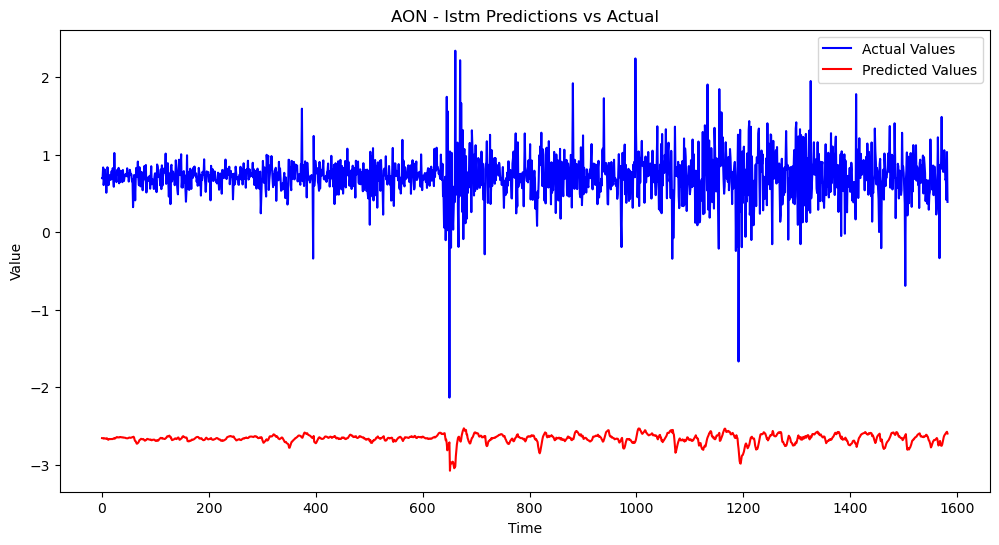

50/50 [==============================] - 9s 165ms/step
AON - gru - RMSE: 1.27723, MAE: 1.24692, MAPE: 2.13611%


<Figure size 640x480 with 0 Axes>

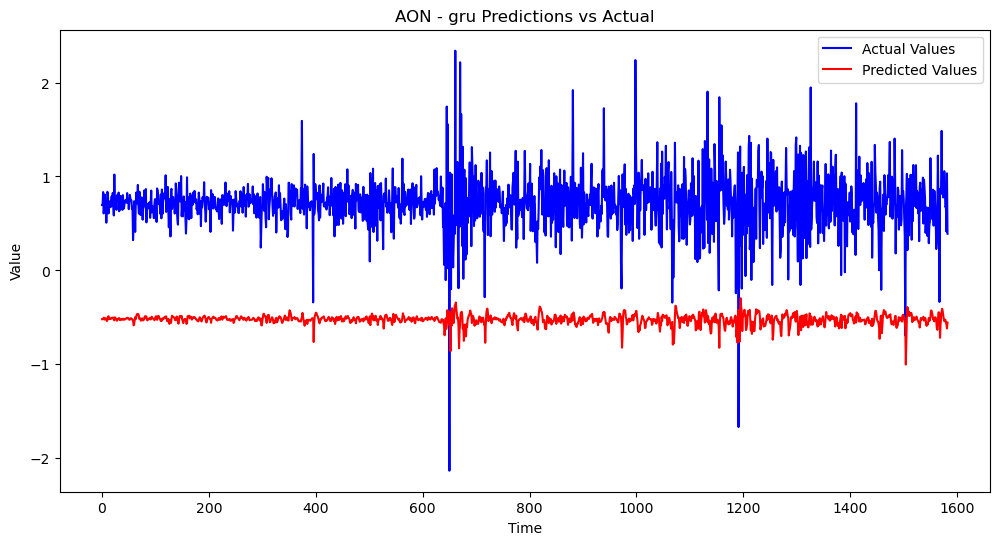

32/32 [==============================] - 2s 48ms/step
POOL - lstm - RMSE: 1.63787, MAE: 1.40373, MAPE: 5.03907%


<Figure size 640x480 with 0 Axes>

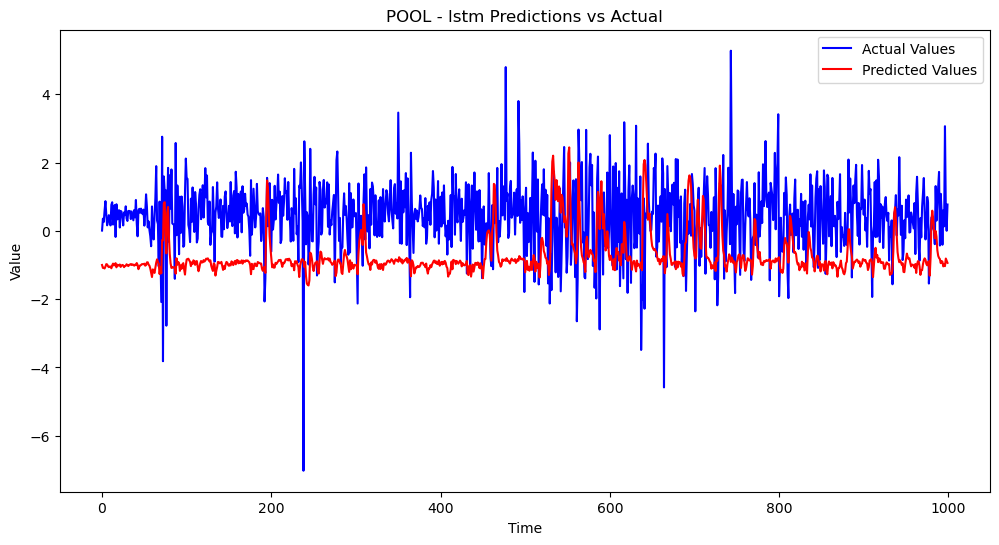

32/32 [==============================] - 5s 152ms/step
POOL - gru - RMSE: 1.46391, MAE: 1.22382, MAPE: 4.14399%


<Figure size 640x480 with 0 Axes>

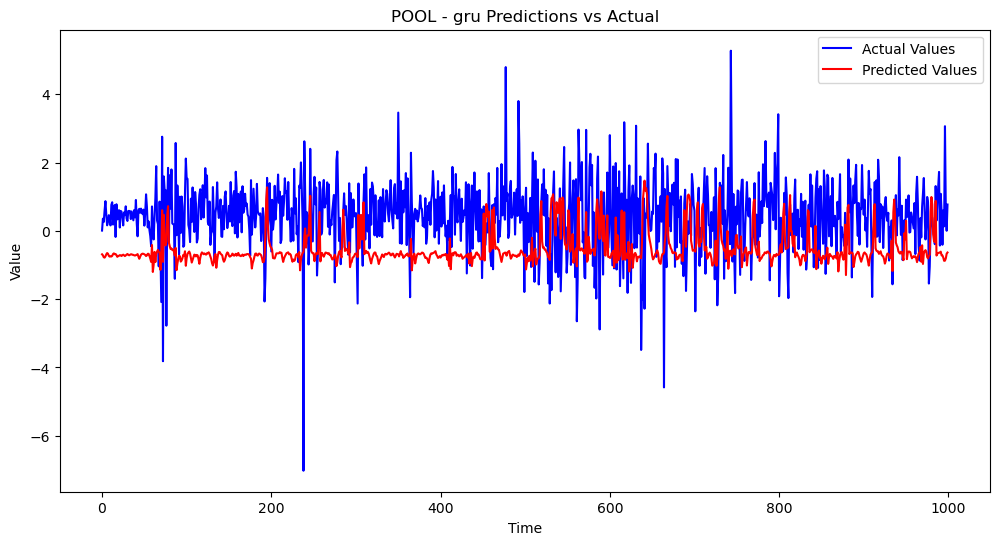

10/10 [==============================] - 2s 204ms/step
VYGVQ - lstm - RMSE: 0.30244, MAE: 0.30243, MAPE: 0.60527%


<Figure size 640x480 with 0 Axes>

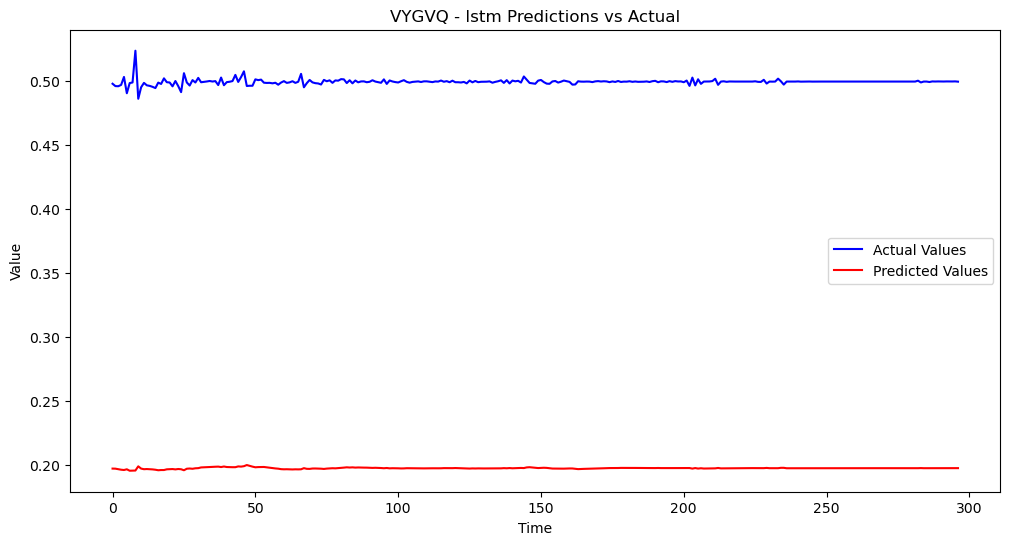

10/10 [==============================] - 2s 122ms/step
VYGVQ - gru - RMSE: 2.96113, MAE: 2.96113, MAPE: 5.92651%


<Figure size 640x480 with 0 Axes>

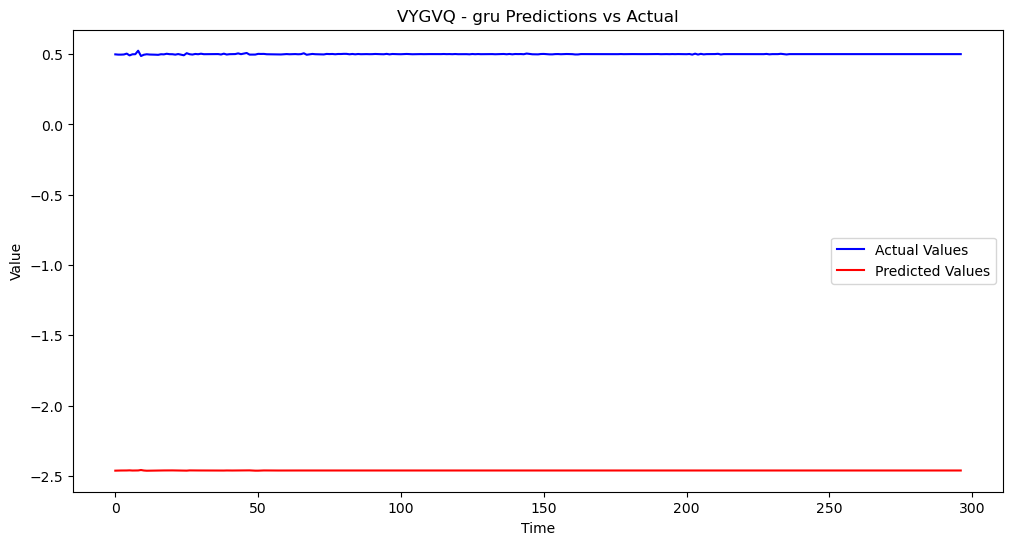

<Figure size 640x480 with 0 Axes>

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate metrics
def calculate_metrics(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted)
    return rmse, mae, mape

# Function to plot predictions
def plot_predictions(actual, predicted, title):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Values', color='blue')
    plt.plot(predicted, label='Predicted Values', color='red')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# After the optimization process is complete
for (symbol, model_type), model in final_models.items():
    # Load the test data
    test_sequences, test_labels = test_data[symbol]

    # Predictions
    predicted = model.predict(test_sequences).flatten()
    actual = test_labels.flatten()

    # Calculate metrics
    rmse, mae, mape = calculate_metrics(actual, predicted)

    # Print metrics
    print(f"{symbol} - {model_type} - RMSE: {rmse:.5f}, MAE: {mae:.5f}, MAPE: {mape:.5f}%")

    # Plot predictions
    title = f"{symbol} - {model_type} Predictions vs Actual"
    plot_predictions(actual, predicted, title)

    # Save the plot
    plt.savefig(f"{symbol}_{model_type}_predictions_vs_actual.png")